In [1]:
# Library imports

#standard libraries
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#audio processing specific library imports 
from python_speech_features import mfcc,logfbank
import librosa
from scipy.io import wavfile

#one hot encoding
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# standard plotting calls
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(1):
        for y in range(1):
            #axes.set_title(list(signals.keys())[i])
            axes.plot(list(signals.values())[i])
            axes.get_xaxis().set_visible(True)
            axes.get_yaxis().set_visible(True)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(1):
        for y in range(1):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            #axes.set_title(list(fft.keys())[i])
            axes.plot(freq, Y)
            axes.get_xaxis().set_visible(True)
            axes.get_yaxis().set_visible(True)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(1):
            #axes.set_title(list(fbank.keys())[i])
            axes.imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes.get_xaxis().set_visible(True)
            axes.get_yaxis().set_visible(True)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(1):
           # axes.set_title(list(mfccs.keys())[i])
            axes.imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes.get_xaxis().set_visible(True)
            axes.get_yaxis().set_visible(True)
            i += 1

## Step 1: Check the audio length distribution and bird sound presence class distribution

In [3]:
# 1.1 ff1010 bird data set
filepath_ff = os.path.join(os.getcwd(),'ff1010bird_metadata.csv')

df_ff = pd.read_csv(filepath_ff)
df_ff.set_index('itemid',inplace=True)


for f in df_ff.index:
    location = os.path.join('ff1010bird/'+str(f)+'.wav')
    rate,signal = wavfile.read(location)
    df_ff.at[f,'length'] = signal.shape[0]/rate
    df_ff.at[f,'rate'] = rate
    

# 1.2 And, warblrb10k bird data set

filepath_warblr = os.path.join(os.getcwd(),'warblrb10k_public_metadata.csv')

df_warblr = pd.read_csv(filepath_warblr)
df_warblr.set_index('itemid',inplace=True)

for f in df_warblr.index:
    location = os.path.join('warblrb10k/'+str(f)+'.wav')
    rate,signal = wavfile.read(location)
    df_warblr.at[f,'length'] = signal.shape[0]/rate
    df_warblr.at[f,'rate'] = rate
    
# 1.3
# confirm that ff1010 bird data is all 10 seconds and warblr is varying from 0.96 second to 48.413 seconds
# confirm that sampling rate is 44.1 kHz for all the sames across ff1010 and warblr datasets
print(df_ff.length.min(),df_ff.length.max(), df_ff.rate.min(), df_ff.rate.max())
print(df_warblr.length.min(),df_warblr.length.max(), df_warblr.rate.min(),df_warblr.rate.max())

1.18715 10.0 20000.0 44100.0
0.96 48.41360544217687 44100.0 44100.0


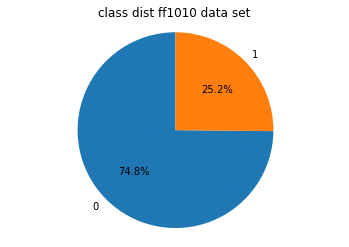

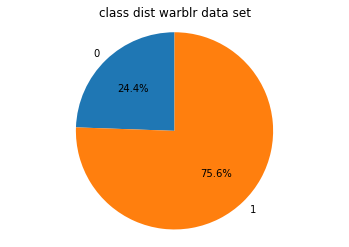

In [4]:
# 1.4 bird sound presence class distribution
class_dist_ff = df_ff.groupby(['hasbird'])['hasbird'].count()

fig,ax = plt.subplots()
ax.set_title('class dist ff1010 data set')
ax.pie(class_dist_ff,labels=class_dist_ff.index, autopct = '%1.1f%%', 
       shadow = False, startangle=90)
ax.axis ('equal')
plt.show()

class_dist_war = df_warblr.groupby(['hasbird'])['hasbird'].count()

fig,ax = plt.subplots()
ax.set_title('class dist warblr data set')
ax.pie(class_dist_war,labels=class_dist_war.index, autopct = '%1.1f%%', 
       shadow = False, startangle=90)
ax.axis ('equal')
plt.show()

In [5]:
# 1.5 reset the index back
df_ff.reset_index(inplace=True)
df_warblr.reset_index(inplace=True)


## Step 2: Calculate Spectral density features
### STFT
### Triangular filter bank
### Mel Frequency Ceps tral Coefficients

In [6]:
# 2.1 find meaningful signal first: signal envelope

def signal_envelope(signal, rate, threshold):
    mask = []
    y = pd.Series(signal).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


# 2.2 calculate signal power spectral densities (frequency time domain)

# 2.2.1 Discrete fast fourier Transform
def fft_cal(signal,sig_sample_rate):
    signal_length = len(signal)
    sample_spacing = 1/sig_sample_rate
    #print("fft",signal_length,sig_sample_rate, sample_spacing)
    frequency = np.fft.rfftfreq(signal_length,d = sample_spacing)
    amp = abs(np.fft.rfft(signal)/signal_length) # magnitude of the DFT normalized over signal length
    return (amp,frequency)

# Triangular filter bank
def filter_bank(signal, sig_sample_rate, num_filters, window_size):
    #number of samples (num_blocks) in an FFT of window_size of x seconds
    num_blocks = 1/window_size
    num_fft = math.ceil(sig_sample_rate/num_blocks) # of windows in the signal of window size x ms 
    #print("filterbank", num_blocks, num_fft)
    bank = logfbank(signal,sig_sample_rate,winlen = window_size, 
                    winstep = window_size/2, nfilt=num_filters, nfft = num_fft).T
    return (bank)

# MFCC transforamtion
def mel_transform (signal, sig_sample_rate, num_filters, window_size):
    #number of samples (num_blocks) in an FFT of window_size of x seconds
    num_blocks = 1/window_size
    num_fft = math.ceil(sig_sample_rate/num_blocks) # of windows in the signal of window size x ms 
    #print("mel", num_blocks, num_fft) 
    mel = mfcc(signal, sig_sample_rate, 
               winlen = window_size,
               winstep = window_size/2,
               numcep = num_filters,
               nfilt=num_filters, nfft = num_fft).T
    return (mel)
    



In [7]:
# define dictionaries to store MFCC  transformation coeffs

signals ={}
FFTs = {}
fbanks = {}
mfccs = {}


In [8]:
location = os.path.join('ff1010bird/'+str(df_ff['itemid'][4000])+'.wav')
rate,signal = wavfile.read(location)

In [9]:
# Envelope the signal

mask = signal_envelope(signal, rate, 0.0005)

print("len signal pre-masked", len(signal))
signal = signal[mask]
print("len signal masked", len(signal))

# find the power spectral features across frequency temporal domain
fft = fft_cal(signal,rate)
bank = filter_bank(signal, rate, 40, 0.040) # number of filters = 40, window size = 40 ms/ 0.040 seconds
mel = mel_transform(signal, rate, 40, 0.040) # number of filters = 40, window size = 40 ms/ 0.040 seconds

len signal pre-masked 441000
len signal masked 441000


In [10]:
signals[0] = signal
FFTs[0] = fft
fbanks[0] = bank
mfccs[0] = mel

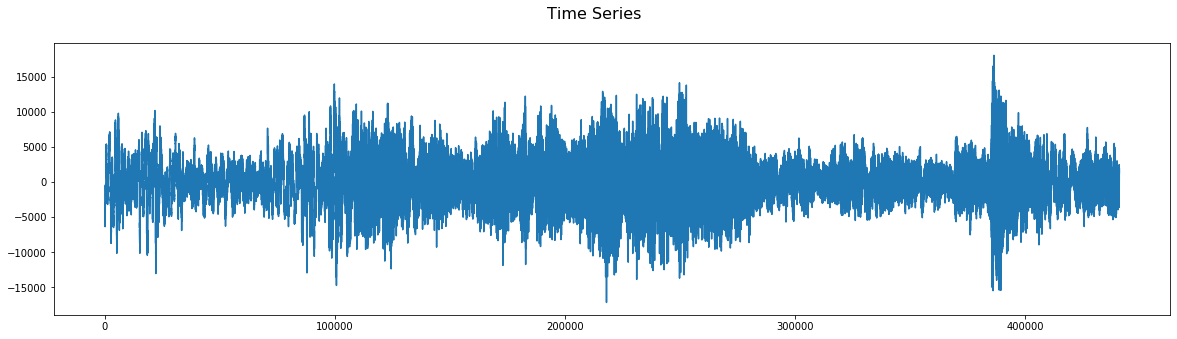

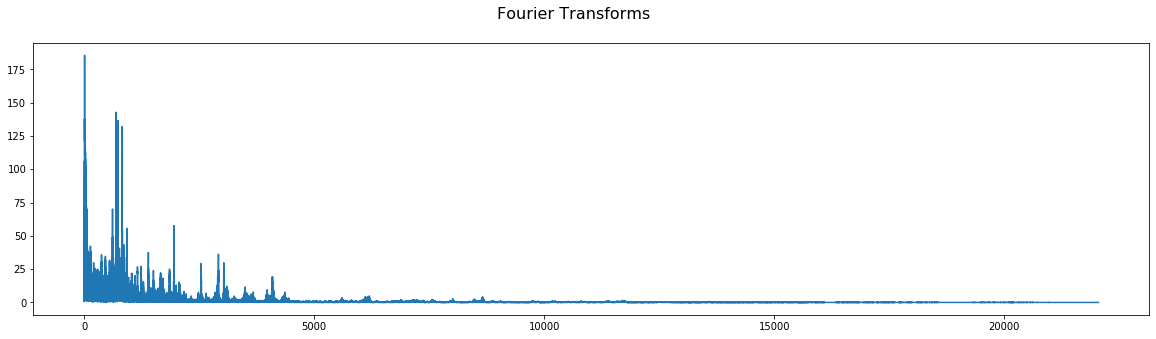

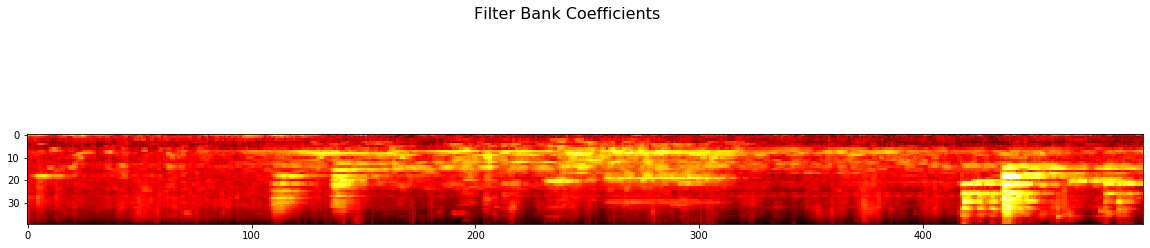

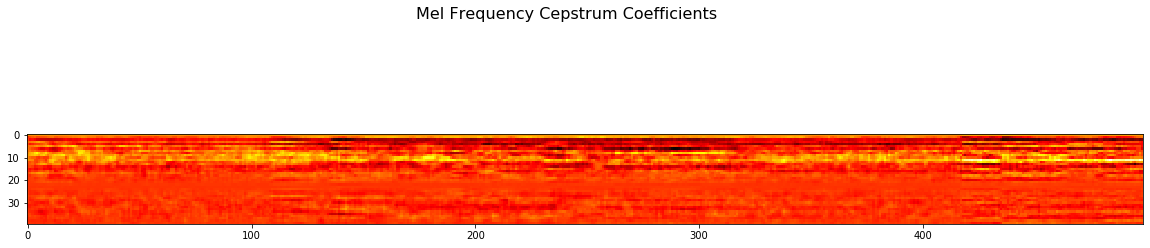

In [11]:
plot_signals(signals)
plt.show()

plot_fft(FFTs)
plt.show()

plot_fbank(fbanks)
plt.show()

plot_mfccs(mfccs)
plt.show()

## Step 3: clean and resample (downsample) and store the data

In [12]:
# 3.1 database ff1010 bird sampled for 20kHz sampling rate and removing noise by signal envelope

if len(os.listdir('ff1010bird-cleaned')) == 0:
    for t in tqdm(df_ff.itemid):
        signal, rate = librosa.load(os.path.join('ff1010bird/'+str(t)+'.wav'),sr = 20000)
        mask = signal_envelope(signal, rate, 0.0005)
        wavfile.write(filename=os.path.join('ff1010bird-cleaned/'+str(t)+'.wav'), 
                      rate = rate, data=signal[mask])
        

In [13]:
# 3.2 database ff1010 bird sampled for 20kHz sampling rate and removing noise by signal envelope


# if len(os.listdir('warblrb10k-cleaned')) == 0:
#     for t in tqdm(df_warblr.itemid):
#         signal, rate = librosa.load(os.path.join('warblrb10k/'+str(t)+'.wav'),sr = 20000)
#         mask = signal_envelope(signal, rate, 0.0005)
#         wavfile.write(filename=os.path.join('warblrb10k-cleaned/'+str(t)+'.wav'), 
#                       rate = rate, data=signal[mask])

## 4. Extract MFCC features

In [14]:
# 4.1 First, configure some constants for later tinkering
# nfft @ 800 is derived as number of samples in a 40 msecond (1/.04 slots/second) 
    #slot  of 20kHz (20 ksamples/second) sampled data. Hence 800 = 20000/(1/0.04)
# class Config:
#     def __init__(self, num_filters = 40, nfft = 800, rate = 20000, window_size=0.040):
#         self.nfilt = num_filters
#         self.nfft = nfft
#         self.rate = rate
#         self.window_size = window_size

rate = 20000
window_size=0.040
num_filters = 40
nfft = 800
_min, _max = float ('inf'), -float('inf')

In [15]:
## 4.2 Extract MFCC features at ff1010 bird sound database



X =[] # to store MFCC coeffs
y = [] # to store BAD (bird audio detection) 0/1 

i = 0
for i in tqdm(range(len(df_ff))):
    file = int(df_ff.iloc[i]['itemid'])
    rate, signal = wavfile.read(os.path.join('ff1010bird-cleaned/'+ str(file)+'.wav'))

    if (signal.shape[0] != 20*10**3*10):
        print(i, signal.shape[0])
        print("================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------")
        continue
    
    x_sample = mel_transform(signal, rate, num_filters, window_size)
    _min = min(np.amin(x_sample), _min)
    _max = max(np.amax(x_sample), _max)
    print(_min,_max)
    X.append(x_sample)
    y.append(int(df_ff.iloc[i]['hasbird']))
    print(i,df_ff.iloc[i]['itemid'],df_ff.iloc[i]['hasbird'])

  0%|                                                                                         | 0/7690 [00:00<?, ?it/s]

-66.47152257779521 41.05751050830919
0 64486.0 0.0
-66.47152257779521 41.05751050830919
1 2525.0 0.0
-66.47152257779521 41.05751050830919
2 44981.0 0.0
-66.47152257779521 41.05751050830919
3 101323.0 0.0


  0%|                                                                                 | 4/7690 [00:00<03:42, 34.52it/s]

4 21572
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-66.47152257779521 41.05751050830919
5 38232.0 0.0
-66.47152257779521 41.05751050830919
6 104540.0 0.0
-66.47152257779521 43.83994148172214
7 157473.0 0.0
-66.47152257779521 43.83994148172214
8 132129.0 0.0


  0%|                                                                                 | 9/7690 [00:00<03:29, 36.73it/s]

-66.47152257779521 51.808588922523526
9 127302.0 0.0
-67.50832728275304 59.52923005468922
10 24950.0 0.0
-67.50832728275304 59.52923005468922
11 39924.0 0.0


  0%|                                                                                | 12/7690 [00:00<03:43, 34.38it/s]

-67.50832728275304 59.52923005468922
12 19037.0 1.0
-67.50832728275304 59.52923005468922
13 86729.0 0.0
-67.50832728275304 59.52923005468922
14 92992.0 0.0


  0%|▏                                                                               | 15/7690 [00:00<04:10, 30.68it/s]

-67.50832728275304 59.52923005468922
15 69238.0 0.0
-67.50832728275304 59.52923005468922
16 102853.0 0.0
-67.50832728275304 59.52923005468922
17 124684.0 0.0


  0%|▏                                                                               | 18/7690 [00:00<04:11, 30.45it/s]

-67.50832728275304 59.52923005468922
18 81068.0 0.0
-69.47025048784255 59.52923005468922
19 123344.0 0.0
-69.47025048784255 59.52923005468922
20 102553.0 0.0


  0%|▏                                                                               | 21/7690 [00:00<04:13, 30.29it/s]

-69.47025048784255 59.52923005468922
21 70948.0 0.0
-69.47025048784255 59.52923005468922
22 55122.0 0.0
-70.61689072067922 100.30111023482438
23 104656.0 0.0


  0%|▏                                                                               | 24/7690 [00:00<04:14, 30.18it/s]

-70.61689072067922 100.30111023482438
24 124698.0 0.0
-70.61689072067922 100.30111023482438
25 79563.0 0.0
-70.61689072067922 100.30111023482438
26 77649.0 0.0


  0%|▎                                                                               | 27/7690 [00:00<04:14, 30.10it/s]

-70.61689072067922 100.30111023482438
27 146716.0 0.0
-74.22792165329129 100.30111023482438
28 146812.0 0.0
-74.22792165329129 100.30111023482438
29 141255.0 0.0


  0%|▎                                                                               | 30/7690 [00:00<04:14, 30.05it/s]

-74.22792165329129 100.30111023482438
30 192790.0 0.0
-74.22792165329129 100.30111023482438
31 91760.0 0.0
32 79558
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-74.22792165329129 100.30111023482438
33 132941.0 0.0


  0%|▎                                                                               | 34/7690 [00:01<04:04, 31.26it/s]

-74.22792165329129 100.30111023482438
34 97375.0 1.0
-74.22792165329129 100.30111023482438
35 63806.0 0.0
-74.22792165329129 100.30111023482438
36 38282.0 0.0
-74.22792165329129 100.30111023482438
37 44223.0 0.0


  0%|▍                                                                               | 38/7690 [00:01<03:57, 32.17it/s]

-74.22792165329129 100.30111023482438
38 72827.0 1.0
-74.22792165329129 100.30111023482438
39 157204.0 0.0
-74.22792165329129 100.30111023482438
40 50678.0 0.0
-74.22792165329129 100.30111023482438
41 148814.0 0.0
-74.22792165329129 100.30111023482438
42 166175.0 1.0


  1%|▍                                                                               | 43/7690 [00:01<03:39, 34.83it/s]

-96.27117106718099 100.30111023482438
43 87526.0 0.0
-96.27117106718099 100.30111023482438
44 54803.0 1.0
-96.27117106718099 100.30111023482438
45 43830.0 0.0
-96.27117106718099 100.30111023482438
46 156039.0 0.0


  1%|▍                                                                               | 47/7690 [00:01<03:31, 36.21it/s]

-96.27117106718099 100.30111023482438
47 89677.0 1.0
-96.27117106718099 100.30111023482438
48 7885.0 0.0
-96.27117106718099 100.30111023482438
49 17008.0 0.0
-96.27117106718099 100.30111023482438
50 65676.0 0.0


  1%|▌                                                                               | 51/7690 [00:01<03:25, 37.25it/s]

-96.27117106718099 100.30111023482438
51 137885.0 0.0
-96.27117106718099 100.30111023482438
52 42805.0 1.0
-96.27117106718099 100.30111023482438
53 28807.0 0.0
-96.27117106718099 100.30111023482438
54 194705.0 0.0


  1%|▌                                                                               | 55/7690 [00:01<03:20, 38.01it/s]

-96.27117106718099 100.30111023482438
55 127361.0 0.0
-96.27117106718099 100.30111023482438
56 69090.0 1.0
-96.27117106718099 100.30111023482438
57 94833.0 0.0
-96.27117106718099 100.30111023482438
58 77308.0 0.0


  1%|▌                                                                               | 59/7690 [00:01<03:30, 36.21it/s]

-96.27117106718099 100.30111023482438
59 155250.0 0.0
-96.27117106718099 100.30111023482438
60 43443.0 0.0
-96.27117106718099 100.30111023482438
61 40130.0 1.0
-96.27117106718099 100.30111023482438
62 146713.0 1.0


  1%|▋                                                                               | 63/7690 [00:01<03:38, 34.94it/s]

-96.27117106718099 100.30111023482438
63 67419.0 0.0
-96.27117106718099 100.30111023482438
64 109156.0 1.0
65 199917
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-96.27117106718099 100.30111023482438
66 160784.0 0.0
-96.27117106718099 100.30111023482438
67 126154.0 1.0


  1%|▋                                                                               | 68/7690 [00:01<03:28, 36.52it/s]

-96.27117106718099 100.30111023482438
68 46222.0 0.0
-96.27117106718099 100.30111023482438
69 123144.0 1.0
-96.27117106718099 100.30111023482438
70 147582.0 1.0
-96.27117106718099 100.30111023482438
71 107636.0 0.0


  1%|▋                                                                               | 72/7690 [00:02<03:23, 37.47it/s]

-96.27117106718099 100.30111023482438
72 32261.0 1.0
-96.27117106718099 100.30111023482438
73 155126.0 0.0
-96.27117106718099 100.30111023482438
74 79704.0 0.0
-96.27117106718099 100.30111023482438
75 54536.0 1.0


  1%|▊                                                                               | 76/7690 [00:02<03:19, 38.17it/s]

-96.27117106718099 100.30111023482438
76 47701.0 0.0
-96.27117106718099 100.30111023482438
77 193483.0 1.0
-96.27117106718099 100.30111023482438
78 113346.0 0.0
-96.27117106718099 100.30111023482438
79 191373.0 0.0


  1%|▊                                                                               | 80/7690 [00:02<03:16, 38.67it/s]

-96.27117106718099 100.30111023482438
80 37798.0 1.0
-96.27117106718099 100.30111023482438
81 146695.0 1.0
-96.27117106718099 100.30111023482438
82 43444.0 0.0
-96.27117106718099 100.30111023482438
83 147937.0 0.0


  1%|▊                                                                               | 84/7690 [00:02<03:14, 39.04it/s]

-96.27117106718099 100.30111023482438
84 23771.0 1.0
-96.27117106718099 100.30111023482438
85 140798.0 0.0
-96.27117106718099 100.30111023482438
86 44048.0 0.0
-96.27117106718099 100.30111023482438
87 173444.0 1.0


  1%|▉                                                                               | 88/7690 [00:02<03:13, 39.32it/s]

-96.27117106718099 100.30111023482438
88 86763.0 0.0
-96.27117106718099 100.30111023482438
89 60589.0 0.0
-96.27117106718099 100.30111023482438
90 192681.0 0.0
-96.27117106718099 100.30111023482438
91 80712.0 1.0
-96.27117106718099 100.30111023482438
92 172997.0 0.0


  1%|▉                                                                               | 93/7690 [00:02<03:08, 40.39it/s]

-96.27117106718099 100.30111023482438
93 65281.0 0.0
-96.27117106718099 100.30111023482438
94 45923.0 0.0
-96.27117106718099 100.30111023482438
95 78784.0 1.0
-96.27117106718099 100.30111023482438
96 156363.0 0.0
-96.27117106718099 100.30111023482438
97 41192.0 0.0


  1%|█                                                                               | 98/7690 [00:02<02:57, 42.84it/s]

-96.27117106718099 100.30111023482438
98 34218.0 0.0
-96.27117106718099 100.30111023482438
99 188172.0 0.0
-96.27117106718099 100.30111023482438
100 58511.0 0.0
-96.27117106718099 100.30111023482438
101 145529.0 0.0
-96.27117106718099 100.30111023482438
102 138650.0 1.0


  1%|█                                                                              | 103/7690 [00:02<02:56, 42.93it/s]

-96.27117106718099 100.30111023482438
103 156607.0 0.0
-96.27117106718099 100.30111023482438
104 66035.0 0.0
-96.27117106718099 100.30111023482438
105 91267.0 0.0
-96.27117106718099 100.30111023482438
106 162729.0 0.0
-96.27117106718099 100.30111023482438
107 39652.0 1.0


  1%|█                                                                              | 108/7690 [00:02<03:03, 41.33it/s]

-96.27117106718099 100.30111023482438
108 39985.0 0.0
-96.27117106718099 100.30111023482438
109 124679.0 0.0
-96.27117106718099 100.30111023482438
110 48995.0 0.0
-96.27117106718099 100.30111023482438
111 142335.0 0.0
-96.27117106718099 100.30111023482438
112 194675.0 1.0


  1%|█▏                                                                             | 113/7690 [00:03<03:00, 41.86it/s]

-96.27117106718099 100.30111023482438
113 71056.0 1.0
-96.27117106718099 100.30111023482438
114 90846.0 0.0
-96.27117106718099 100.30111023482438
115 68152.0 0.0
-96.27117106718099 100.30111023482438
116 32494.0 0.0
-96.27117106718099 100.30111023482438
117 146863.0 0.0


  2%|█▏                                                                             | 118/7690 [00:03<02:55, 43.24it/s]

-96.27117106718099 100.30111023482438
118 164378.0 0.0
-96.27117106718099 100.30111023482438
119 159998.0 0.0
-103.5331634512182 100.30111023482438
120 17354.0 1.0
-103.5331634512182 100.30111023482438
121 150113.0 1.0
-103.5331634512182 100.30111023482438
122 63742.0 0.0


  2%|█▎                                                                             | 123/7690 [00:03<03:02, 41.53it/s]

123 159352
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-103.5331634512182 100.30111023482438
124 176589.0 0.0
-103.5331634512182 100.30111023482438
125 140825.0 1.0
-103.5331634512182 100.30111023482438
126 44186.0 0.0
-103.5331634512182 100.30111023482438
127 23415.0 0.0
-103.5331634512182 100.30111023482438
128 7320.0 1.0


  2%|█▎                                                                             | 129/7690 [00:03<02:47, 45.11it/s]

-103.5331634512182 100.30111023482438
129 85160.0 0.0
-103.5331634512182 100.30111023482438
130 111040.0 1.0
-103.5331634512182 100.30111023482438
131 107522.0 1.0
-103.5331634512182 100.30111023482438
132 175040.0 0.0
-103.5331634512182 100.30111023482438
133 137884.0 1.0


  2%|█▍                                                                             | 134/7690 [00:03<02:47, 45.00it/s]

-103.5331634512182 100.30111023482438
134 91476.0 0.0
-103.5331634512182 100.30111023482438
135 80689.0 1.0
-103.5331634512182 100.30111023482438
136 155209.0 0.0
-103.5331634512182 100.30111023482438
137 73116.0 0.0
-103.5331634512182 100.30111023482438
138 103026.0 0.0


  2%|█▍                                                                             | 139/7690 [00:03<02:45, 45.76it/s]

-103.5331634512182 100.30111023482438
139 178878.0 1.0
-103.5331634512182 100.30111023482438
140 171427.0 0.0
-103.5331634512182 100.30111023482438
141 147777.0 0.0
-103.5331634512182 100.30111023482438
142 184633.0 0.0
-103.5331634512182 100.30111023482438
143 19992.0 0.0


  2%|█▍                                                                             | 144/7690 [00:03<02:50, 44.37it/s]

-103.5331634512182 100.30111023482438
144 50883.0 1.0
-103.5331634512182 100.30111023482438
145 52073.0 1.0
-103.5331634512182 100.30111023482438
146 150882.0 1.0
-103.5331634512182 100.30111023482438
147 118595.0 0.0
-103.5331634512182 100.30111023482438
148 179678.0 0.0


  2%|█▌                                                                             | 149/7690 [00:03<02:55, 43.08it/s]

-103.5331634512182 100.30111023482438
149 86960.0 0.0
-103.5331634512182 100.30111023482438
150 35692.0 0.0
-103.5331634512182 100.30111023482438
151 73078.0 0.0
-103.5331634512182 100.30111023482438
152 182093.0 0.0
-103.5331634512182 100.30111023482438
153 111092.0 1.0


  2%|█▌                                                                             | 154/7690 [00:03<02:58, 42.14it/s]

-103.5331634512182 100.30111023482438
154 54485.0 0.0
-103.5331634512182 100.30111023482438
155 191737.0 1.0
-103.5331634512182 100.30111023482438
156 188261.0 1.0
-103.5331634512182 100.30111023482438
157 73517.0 0.0
-103.5331634512182 100.30111023482438
158 109657.0 1.0


  2%|█▋                                                                             | 159/7690 [00:04<03:04, 40.83it/s]

-103.5331634512182 100.30111023482438
159 85362.0 0.0
-103.5331634512182 100.30111023482438
160 187125.0 0.0
-103.5331634512182 100.30111023482438
161 46347.0 0.0
-103.5331634512182 100.30111023482438
162 72233.0 1.0
-103.5331634512182 100.30111023482438
163 146223.0 0.0


  2%|█▋                                                                             | 164/7690 [00:04<03:01, 41.50it/s]

-103.5331634512182 100.30111023482438
164 154921.0 1.0
-103.5331634512182 100.30111023482438
165 88409.0 0.0
-103.5331634512182 100.30111023482438
166 71862.0 0.0
-103.5331634512182 100.30111023482438
167 66594.0 1.0
-103.5331634512182 100.30111023482438
168 57147.0 0.0


  2%|█▋                                                                             | 169/7690 [00:04<02:59, 41.98it/s]

-103.5331634512182 100.30111023482438
169 184200.0 1.0
-103.5331634512182 100.30111023482438
170 189862.0 0.0
-103.5331634512182 100.30111023482438
171 95956.0 0.0
-103.5331634512182 100.30111023482438
172 109373.0 0.0
-103.5331634512182 100.30111023482438
173 125243.0 0.0


  2%|█▊                                                                             | 174/7690 [00:04<02:57, 42.33it/s]

-103.5331634512182 100.30111023482438
174 172519.0 0.0
-103.5331634512182 100.30111023482438
175 176591.0 1.0
-103.5331634512182 100.30111023482438
176 16990.0 0.0
-103.5331634512182 100.30111023482438
177 78793.0 0.0
-103.5331634512182 100.30111023482438
178 102552.0 1.0


  2%|█▊                                                                             | 179/7690 [00:04<02:59, 41.88it/s]

-103.5331634512182 100.30111023482438
179 11692.0 0.0
-103.5331634512182 100.30111023482438
180 100302.0 0.0
-103.5331634512182 100.30111023482438
181 90352.0 0.0
-103.5331634512182 100.30111023482438
182 56875.0 0.0
-103.5331634512182 100.30111023482438
183 71964.0 0.0


  2%|█▉                                                                             | 184/7690 [00:04<02:57, 42.25it/s]

-103.5331634512182 100.30111023482438
184 137886.0 0.0
-103.5331634512182 100.30111023482438
185 176124.0 0.0
-103.5331634512182 100.30111023482438
186 173888.0 0.0
-103.5331634512182 100.30111023482438
187 31244.0 1.0
-103.5331634512182 100.30111023482438
188 157733.0 0.0


  2%|█▉                                                                             | 189/7690 [00:04<03:03, 40.89it/s]

-103.5331634512182 100.30111023482438
189 77783.0 0.0
-103.5331634512182 100.30111023482438
190 66785.0 1.0
-103.5331634512182 100.30111023482438
191 52833.0 1.0
-103.5331634512182 100.30111023482438
192 147599.0 0.0
-103.5331634512182 100.30111023482438
193 134971.0 0.0


  3%|█▉                                                                             | 194/7690 [00:04<03:00, 41.54it/s]

-103.5331634512182 100.30111023482438
194 20019.0 0.0
-103.5331634512182 100.30111023482438
195 3188.0 1.0
-103.5331634512182 100.30111023482438
196 69103.0 1.0
-103.5331634512182 100.30111023482438
197 31454.0 0.0
-103.5331634512182 100.30111023482438
198 127282.0 0.0


  3%|██                                                                             | 199/7690 [00:05<02:58, 42.01it/s]

-103.5331634512182 100.30111023482438
199 180544.0 1.0
-103.5331634512182 100.30111023482438
200 15657.0 1.0
-103.5331634512182 100.30111023482438
201 127234.0 0.0
-103.5331634512182 100.30111023482438
202 104541.0 0.0
-103.5331634512182 100.30111023482438
203 77666.0 1.0


  3%|██                                                                             | 204/7690 [00:05<03:06, 40.09it/s]

-103.5331634512182 100.30111023482438
204 108763.0 1.0
-103.5331634512182 100.30111023482438
205 7875.0 0.0
206 91183
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-103.5331634512182 100.30111023482438
207 126762.0 0.0
-103.5331634512182 100.30111023482438
208 169097.0 0.0


  3%|██▏                                                                            | 209/7690 [00:05<02:55, 42.60it/s]

-103.5331634512182 100.30111023482438
209 142293.0 0.0
-103.5331634512182 100.30111023482438
210 111175.0 0.0
-103.5331634512182 100.30111023482438
211 112535.0 1.0
-103.5331634512182 100.30111023482438
212 162727.0 0.0
-103.5331634512182 100.30111023482438
213 162768.0 0.0


  3%|██▏                                                                            | 214/7690 [00:05<02:54, 42.77it/s]

-103.5331634512182 100.30111023482438
214 187943.0 1.0
-103.5331634512182 100.30111023482438
215 188469.0 0.0
-103.5331634512182 100.30111023482438
216 54753.0 0.0
-103.5331634512182 100.30111023482438
217 95488.0 1.0
-103.5331634512182 100.30111023482438
218 62166.0 0.0


  3%|██▏                                                                            | 219/7690 [00:05<02:56, 42.29it/s]

-103.5331634512182 100.30111023482438
219 164939.0 0.0
-103.5331634512182 100.30111023482438
220 9225.0 0.0
-103.5331634512182 100.30111023482438
221 118745.0 0.0
-103.5331634512182 100.30111023482438
222 57327.0 1.0
-103.5331634512182 100.30111023482438
223 71294.0 1.0


  3%|██▎                                                                            | 224/7690 [00:05<03:06, 40.02it/s]

-103.5331634512182 100.30111023482438
224 100180.0 1.0
225 174409
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-103.5331634512182 100.30111023482438
226 165048.0 1.0
-103.5331634512182 100.30111023482438
227 41848.0 0.0
-103.5331634512182 100.30111023482438
228 188140.0 0.0


  3%|██▎                                                                            | 229/7690 [00:05<03:00, 41.44it/s]

-103.5331634512182 100.30111023482438
229 2531.0 0.0
-103.5331634512182 100.30111023482438
230 112758.0 1.0
-103.5331634512182 100.30111023482438
231 86935.0 0.0
-103.5331634512182 100.30111023482438
232 38584.0 0.0
-103.5331634512182 100.30111023482438
233 99437.0 0.0


  3%|██▍                                                                            | 234/7690 [00:05<02:59, 41.58it/s]

-103.5331634512182 100.30111023482438
234 81924.0 0.0
-103.5331634512182 100.30111023482438
235 89675.0 0.0
-103.5331634512182 100.30111023482438
236 99687.0 1.0
-103.5331634512182 100.30111023482438
237 58233.0 1.0
-103.5331634512182 100.30111023482438
238 42200.0 0.0


  3%|██▍                                                                            | 239/7690 [00:06<03:00, 41.32it/s]

-103.5331634512182 100.30111023482438
239 90359.0 0.0
-103.5331634512182 100.30111023482438
240 121554.0 1.0
-104.17308645603545 100.30111023482438
241 34773.0 1.0
-104.17308645603545 100.30111023482438
242 38273.0 0.0
-104.17308645603545 100.30111023482438
243 25380.0 0.0


  3%|██▌                                                                            | 244/7690 [00:06<03:00, 41.35it/s]

-104.17308645603545 100.30111023482438
244 51036.0 0.0
-104.17308645603545 100.30111023482438
245 18515.0 1.0
-104.17308645603545 100.30111023482438
246 87944.0 0.0
-104.17308645603545 100.30111023482438
247 104390.0 0.0
-104.17308645603545 100.30111023482438
248 94828.0 0.0


  3%|██▌                                                                            | 249/7690 [00:06<02:59, 41.39it/s]

-104.17308645603545 100.30111023482438
249 160911.0 0.0
-104.17308645603545 100.30111023482438
250 174774.0 0.0
-104.17308645603545 100.30111023482438
251 146693.0 0.0
-104.17308645603545 100.30111023482438
252 162682.0 0.0
-104.17308645603545 100.30111023482438
253 60135.0 1.0


  3%|██▌                                                                            | 254/7690 [00:06<02:58, 41.60it/s]

-104.17308645603545 100.30111023482438
254 74316.0 1.0
-104.17308645603545 100.30111023482438
255 164165.0 0.0
-104.17308645603545 100.30111023482438
256 191926.0 0.0
-104.17308645603545 100.30111023482438
257 168049.0 0.0
-104.17308645603545 100.30111023482438
258 151254.0 0.0


  3%|██▋                                                                            | 259/7690 [00:06<02:59, 41.34it/s]

-104.17308645603545 100.30111023482438
259 100842.0 0.0
-104.17308645603545 100.30111023482438
260 17632.0 0.0
-104.17308645603545 100.30111023482438
261 145535.0 0.0
-104.17308645603545 100.30111023482438
262 164926.0 0.0
-104.17308645603545 100.30111023482438
263 35038.0 0.0


  3%|██▋                                                                            | 264/7690 [00:06<02:59, 41.36it/s]

-104.17308645603545 100.30111023482438
264 33640.0 0.0
-104.17308645603545 100.30111023482438
265 149763.0 1.0
-104.17308645603545 100.30111023482438
266 157740.0 0.0
-104.17308645603545 100.30111023482438
267 157470.0 0.0
-104.17308645603545 100.30111023482438
268 64174.0 0.0


  3%|██▊                                                                            | 269/7690 [00:06<02:54, 42.45it/s]

-104.17308645603545 100.30111023482438
269 128116.0 0.0
-104.17308645603545 100.30111023482438
270 68642.0 1.0
-104.17308645603545 100.30111023482438
271 50920.0 0.0
-104.17308645603545 100.30111023482438
272 48644.0 0.0
-104.17308645603545 100.30111023482438
273 123993.0 1.0


  4%|██▊                                                                            | 274/7690 [00:06<02:59, 41.27it/s]

-104.17308645603545 100.30111023482438
274 68495.0 0.0
-104.17308645603545 100.30111023482438
275 122186.0 0.0
-104.17308645603545 100.30111023482438
276 50934.0 0.0
-104.17308645603545 100.30111023482438
277 168901.0 0.0
-116.14502288847498 100.30111023482438
278 75073.0 0.0


  4%|██▊                                                                            | 279/7690 [00:06<03:00, 41.11it/s]

-116.14502288847498 100.30111023482438
279 113437.0 0.0
-116.14502288847498 100.30111023482438
280 156354.0 0.0
-116.14502288847498 100.30111023482438
281 193803.0 0.0
-116.14502288847498 100.30111023482438
282 69004.0 0.0
-116.14502288847498 100.30111023482438
283 183448.0 1.0


  4%|██▉                                                                            | 284/7690 [00:07<02:59, 41.21it/s]

-116.14502288847498 100.30111023482438
284 169134.0 1.0
-116.14502288847498 100.30111023482438
285 125821.0 0.0
-116.14502288847498 100.30111023482438
286 151381.0 0.0
287 188706
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-116.14502288847498 100.30111023482438
288 103558.0 0.0


  4%|██▉                                                                            | 289/7690 [00:07<03:08, 39.30it/s]

-116.14502288847498 100.30111023482438
289 101319.0 0.0
-116.14502288847498 100.30111023482438
290 38755.0 0.0
-116.14502288847498 100.30111023482438
291 146703.0 1.0
-116.14502288847498 100.30111023482438
292 188367.0 0.0


  4%|███                                                                            | 293/7690 [00:07<03:12, 38.50it/s]

-116.14502288847498 100.30111023482438
293 19030.0 0.0
-116.14502288847498 100.30111023482438
294 38306.0 0.0
-116.14502288847498 100.30111023482438
295 17143.0 0.0
-116.14502288847498 100.30111023482438
296 147935.0 0.0


  4%|███                                                                            | 297/7690 [00:07<03:11, 38.66it/s]

297 193102
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-116.14502288847498 100.30111023482438
298 157512.0 0.0
-116.14502288847498 100.30111023482438
299 7173.0 0.0
-116.14502288847498 100.30111023482438
300 42198.0 1.0
-116.14502288847498 100.30111023482438
301 95954.0 0.0


  4%|███                                                                            | 302/7690 [00:07<03:02, 40.41it/s]

-116.14502288847498 100.30111023482438
302 57668.0 1.0
-116.14502288847498 100.30111023482438
303 19264.0 1.0
-116.14502288847498 100.30111023482438
304 144066.0 0.0
-116.14502288847498 100.30111023482438
305 72858.0 1.0
-116.14502288847498 100.30111023482438
306 184204.0 0.0


  4%|███▏                                                                           | 307/7690 [00:07<03:05, 39.73it/s]

-116.14502288847498 100.30111023482438
307 95811.0 0.0
-116.14502288847498 100.30111023482438
308 191991.0 1.0
-116.14502288847498 100.30111023482438
309 117406.0 0.0
-116.14502288847498 100.30111023482438
310 58386.0 0.0
-116.14502288847498 100.30111023482438
311 74477.0 0.0


  4%|███▏                                                                           | 312/7690 [00:07<03:03, 40.22it/s]

-116.14502288847498 100.30111023482438
312 174042.0 0.0
-116.14502288847498 100.30111023482438
313 56964.0 0.0
-116.14502288847498 100.30111023482438
314 48652.0 0.0
-116.14502288847498 100.30111023482438
315 133470.0 1.0
-116.14502288847498 100.30111023482438
316 147015.0 0.0


  4%|███▎                                                                           | 317/7690 [00:07<03:01, 40.57it/s]

-116.14502288847498 100.30111023482438
317 65346.0 0.0
-116.14502288847498 100.30111023482438
318 123691.0 0.0
-116.14502288847498 100.30111023482438
319 59197.0 0.0
-116.14502288847498 100.30111023482438
320 52905.0 1.0
-116.14502288847498 100.30111023482438
321 160514.0 1.0


  4%|███▎                                                                           | 322/7690 [00:08<03:08, 39.09it/s]

-116.14502288847498 100.30111023482438
322 146869.0 1.0
-116.14502288847498 100.30111023482438
323 69192.0 0.0
-116.14502288847498 100.30111023482438
324 186517.0 0.0
-116.14502288847498 100.30111023482438
325 190573.0 1.0


  4%|███▎                                                                           | 326/7690 [00:08<03:08, 39.05it/s]

-116.14502288847498 100.30111023482438
326 102082.0 0.0
-116.14502288847498 100.30111023482438
327 174237.0 0.0
-116.14502288847498 100.30111023482438
328 73617.0 1.0
-116.14502288847498 100.30111023482438
329 99449.0 0.0


  4%|███▍                                                                           | 330/7690 [00:08<03:07, 39.19it/s]

-116.14502288847498 100.30111023482438
330 86641.0 0.0
-116.14502288847498 100.30111023482438
331 78805.0 0.0
-116.14502288847498 100.30111023482438
332 166698.0 0.0
-116.14502288847498 100.30111023482438
333 90421.0 0.0


  4%|███▍                                                                           | 334/7690 [00:08<03:14, 37.82it/s]

-116.14502288847498 100.30111023482438
334 170835.0 0.0
-116.14502288847498 100.30111023482438
335 46918.0 0.0
-116.14502288847498 100.30111023482438
336 92818.0 0.0
-116.14502288847498 100.30111023482438
337 31456.0 0.0


  4%|███▍                                                                           | 338/7690 [00:08<03:17, 37.30it/s]

-116.14502288847498 100.30111023482438
338 73181.0 0.0
-116.14502288847498 100.30111023482438
339 181412.0 0.0
-116.14502288847498 100.30111023482438
340 193802.0 0.0
-116.14502288847498 100.30111023482438
341 155639.0 0.0


  4%|███▌                                                                           | 342/7690 [00:08<03:14, 37.77it/s]

-116.14502288847498 100.30111023482438
342 70300.0 0.0
-116.14502288847498 100.30111023482438
343 65355.0 0.0
-116.14502288847498 100.30111023482438
344 126607.0 0.0
-116.14502288847498 100.30111023482438
345 73542.0 1.0


  4%|███▌                                                                           | 346/7690 [00:08<03:12, 38.12it/s]

-116.14502288847498 100.30111023482438
346 57860.0 0.0
-116.14502288847498 100.30111023482438
347 180448.0 0.0
-116.14502288847498 100.30111023482438
348 19376.0 0.0
-116.14502288847498 100.30111023482438
349 157822.0 0.0


  5%|███▌                                                                           | 350/7690 [00:08<03:10, 38.58it/s]

-116.14502288847498 100.30111023482438
350 104386.0 0.0
-116.14502288847498 100.30111023482438
351 166426.0 0.0
-116.14502288847498 100.30111023482438
352 171463.0 1.0
-116.14502288847498 100.30111023482438
353 146075.0 0.0
-116.14502288847498 100.30111023482438
354 60858.0 0.0


  5%|███▋                                                                           | 355/7690 [00:08<03:06, 39.39it/s]

-116.14502288847498 100.30111023482438
355 118958.0 0.0
-116.14502288847498 100.30111023482438
356 40132.0 0.0
-124.58574020208121 100.30111023482438
357 39859.0 0.0
-124.58574020208121 100.30111023482438
358 68998.0 0.0


  5%|███▋                                                                           | 359/7690 [00:09<03:05, 39.50it/s]

-124.58574020208121 100.30111023482438
359 86248.0 0.0
-124.58574020208121 100.30111023482438
360 86968.0 0.0
-124.58574020208121 100.30111023482438
361 155193.0 0.0
-124.58574020208121 100.30111023482438
362 39658.0 0.0


  5%|███▋                                                                           | 363/7690 [00:09<03:10, 38.40it/s]

-124.58574020208121 100.30111023482438
363 128705.0 1.0
-124.58574020208121 100.30111023482438
364 147899.0 0.0
-124.58574020208121 100.30111023482438
365 173192.0 0.0
-124.58574020208121 100.30111023482438
366 186730.0 1.0


  5%|███▊                                                                           | 367/7690 [00:09<03:14, 37.71it/s]

-124.58574020208121 100.30111023482438
367 160004.0 0.0
-124.58574020208121 100.30111023482438
368 28809.0 0.0
-124.58574020208121 100.30111023482438
369 184234.0 0.0
-124.58574020208121 100.30111023482438
370 76271.0 0.0


  5%|███▊                                                                           | 371/7690 [00:09<03:16, 37.22it/s]

-124.58574020208121 100.30111023482438
371 138459.0 0.0
-124.58574020208121 100.30111023482438
372 121539.0 0.0
-124.58574020208121 100.30111023482438
373 184796.0 1.0
-124.58574020208121 100.30111023482438
374 87404.0 0.0


  5%|███▊                                                                           | 375/7690 [00:09<03:12, 37.95it/s]

-124.58574020208121 100.30111023482438
375 120645.0 1.0
-124.58574020208121 100.30111023482438
376 58232.0 1.0
-124.58574020208121 100.30111023482438
377 94632.0 0.0
-124.58574020208121 100.30111023482438
378 172687.0 0.0
-124.58574020208121 100.30111023482438
379 158606.0 0.0


  5%|███▉                                                                           | 380/7690 [00:09<03:07, 38.93it/s]

-124.58574020208121 100.30111023482438
380 17005.0 0.0
-124.58574020208121 100.30111023482438
381 169860.0 0.0
-124.58574020208121 100.30111023482438
382 127185.0 0.0
-124.58574020208121 100.30111023482438
383 147638.0 1.0


  5%|███▉                                                                           | 384/7690 [00:09<03:06, 39.16it/s]

-124.58574020208121 100.30111023482438
384 112252.0 0.0
-124.58574020208121 100.30111023482438
385 187586.0 0.0
-124.58574020208121 100.30111023482438
386 146199.0 0.0
-124.58574020208121 100.30111023482438
387 161651.0 1.0


  5%|███▉                                                                           | 388/7690 [00:09<03:05, 39.34it/s]

-124.58574020208121 100.30111023482438
388 173196.0 0.0
-124.58574020208121 100.30111023482438
389 115700.0 0.0
-124.58574020208121 100.30111023482438
390 162490.0 0.0
-124.58574020208121 100.30111023482438
391 71861.0 0.0


  5%|████                                                                           | 392/7690 [00:09<03:04, 39.53it/s]

-124.58574020208121 100.30111023482438
392 102087.0 0.0
-124.58574020208121 100.30111023482438
393 46237.0 0.0
-124.58574020208121 100.30111023482438
394 30168.0 0.0
-124.58574020208121 100.30111023482438
395 127637.0 0.0


  5%|████                                                                           | 396/7690 [00:10<03:08, 38.68it/s]

-124.58574020208121 100.30111023482438
396 119065.0 0.0
-124.58574020208121 100.30111023482438
397 96145.0 0.0
-124.58574020208121 100.30111023482438
398 64193.0 0.0
-124.58574020208121 100.30111023482438
399 132640.0 0.0


  5%|████                                                                           | 400/7690 [00:10<03:08, 38.76it/s]

-124.58574020208121 100.30111023482438
400 131130.0 0.0
-124.58574020208121 100.30111023482438
401 15470.0 0.0
-124.58574020208121 100.30111023482438
402 176022.0 0.0
-124.58574020208121 100.30111023482438
403 66052.0 1.0


  5%|████▏                                                                          | 404/7690 [00:10<03:10, 38.15it/s]

-124.58574020208121 100.30111023482438
404 58838.0 1.0
-124.58574020208121 100.30111023482438
405 86736.0 0.0
-124.58574020208121 100.30111023482438
406 91762.0 0.0
-124.58574020208121 100.30111023482438
407 99083.0 1.0
-124.58574020208121 100.30111023482438
408 157596.0 0.0


  5%|████▏                                                                          | 409/7690 [00:10<03:02, 39.83it/s]

-124.58574020208121 100.30111023482438
409 147905.0 0.0
-124.58574020208121 100.30111023482438
410 39942.0 0.0
-124.58574020208121 100.30111023482438
411 122194.0 0.0
-124.58574020208121 100.30111023482438
412 165126.0 0.0
-124.58574020208121 100.30111023482438
413 167245.0 1.0


  5%|████▎                                                                          | 414/7690 [00:10<03:04, 39.35it/s]

-124.58574020208121 100.30111023482438
414 195598.0 0.0
-124.58574020208121 100.30111023482438
415 121361.0 0.0
-124.58574020208121 100.30111023482438
416 100839.0 0.0
-124.58574020208121 100.30111023482438
417 155301.0 0.0


  5%|████▎                                                                          | 418/7690 [00:10<03:08, 38.56it/s]

-124.58574020208121 100.30111023482438
418 84910.0 0.0
-124.58574020208121 100.30111023482438
419 80790.0 0.0
-124.58574020208121 100.30111023482438
420 58180.0 0.0
421 104855
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
422 94635.0 0.0


  6%|████▎                                                                          | 423/7690 [00:10<02:56, 41.13it/s]

-124.58574020208121 100.30111023482438
423 164844.0 0.0
-124.58574020208121 100.30111023482438
424 54884.0 0.0
-124.58574020208121 100.30111023482438
425 92846.0 0.0
-124.58574020208121 100.30111023482438
426 62280.0 1.0
-124.58574020208121 100.30111023482438
427 20008.0 0.0


  6%|████▍                                                                          | 428/7690 [00:10<03:04, 39.30it/s]

-124.58574020208121 100.30111023482438
428 18050.0 1.0
-124.58574020208121 100.30111023482438
429 86756.0 0.0
-124.58574020208121 100.30111023482438
430 7151.0 0.0
431 196901
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
432 191934.0 0.0


  6%|████▍                                                                          | 433/7690 [00:10<02:53, 41.85it/s]

-124.58574020208121 100.30111023482438
433 65344.0 0.0
-124.58574020208121 100.30111023482438
434 109154.0 0.0
-124.58574020208121 100.30111023482438
435 55857.0 0.0
-124.58574020208121 100.30111023482438
436 97382.0 1.0
-124.58574020208121 100.30111023482438
437 151774.0 1.0


  6%|████▍                                                                          | 438/7690 [00:11<03:02, 39.71it/s]

-124.58574020208121 100.30111023482438
438 52171.0 1.0
-124.58574020208121 100.30111023482438
439 184751.0 1.0
-124.58574020208121 100.30111023482438
440 37911.0 1.0
-124.58574020208121 100.30111023482438
441 99081.0 0.0
-124.58574020208121 100.30111023482438
442 131488.0 0.0


  6%|████▌                                                                          | 443/7690 [00:11<03:04, 39.27it/s]

-124.58574020208121 100.30111023482438
443 41182.0 0.0
-124.58574020208121 100.30111023482438
444 169947.0 1.0
-124.58574020208121 100.30111023482438
445 153126.0 0.0
-124.58574020208121 100.30111023482438
446 45485.0 0.0


  6%|████▌                                                                          | 447/7690 [00:11<03:09, 38.27it/s]

-124.58574020208121 100.30111023482438
447 53693.0 1.0
-124.58574020208121 100.30111023482438
448 191744.0 1.0
-124.58574020208121 100.30111023482438
449 82058.0 0.0
-124.58574020208121 100.30111023482438
450 73079.0 0.0


  6%|████▋                                                                          | 451/7690 [00:11<03:07, 38.70it/s]

-124.58574020208121 100.30111023482438
451 38388.0 0.0
-124.58574020208121 100.30111023482438
452 51631.0 0.0
-124.58574020208121 100.30111023482438
453 195090.0 1.0
-124.58574020208121 100.30111023482438
454 2151.0 0.0


  6%|████▋                                                                          | 455/7690 [00:11<03:09, 38.11it/s]

-124.58574020208121 100.30111023482438
455 169081.0 0.0
-124.58574020208121 100.30111023482438
456 65946.0 0.0
-124.58574020208121 100.30111023482438
457 125812.0 0.0
-124.58574020208121 100.30111023482438
458 127347.0 0.0
-124.58574020208121 100.30111023482438
459 184641.0 0.0


  6%|████▋                                                                          | 460/7690 [00:11<03:06, 38.86it/s]

-124.58574020208121 100.30111023482438
460 171006.0 0.0
-124.58574020208121 100.30111023482438
461 96429.0 1.0
-124.58574020208121 100.30111023482438
462 175020.0 1.0
-124.58574020208121 100.30111023482438
463 87954.0 0.0


  6%|████▊                                                                          | 464/7690 [00:11<03:04, 39.15it/s]

-124.58574020208121 100.30111023482438
464 162748.0 0.0
-124.58574020208121 100.30111023482438
465 186338.0 0.0
-124.58574020208121 100.30111023482438
466 188509.0 0.0
-124.58574020208121 100.30111023482438
467 127511.0 0.0


  6%|████▊                                                                          | 468/7690 [00:11<03:03, 39.26it/s]

-124.58574020208121 100.30111023482438
468 115409.0 1.0
-124.58574020208121 100.30111023482438
469 173185.0 1.0
-124.58574020208121 100.30111023482438
470 25526.0 0.0
-124.58574020208121 100.30111023482438
471 86943.0 0.0


  6%|████▊                                                                          | 472/7690 [00:11<03:08, 38.26it/s]

-124.58574020208121 100.30111023482438
472 140797.0 0.0
-124.58574020208121 100.30111023482438
473 192153.0 1.0
-124.58574020208121 100.30111023482438
474 155214.0 0.0
-124.58574020208121 100.30111023482438
475 188619.0 1.0


  6%|████▉                                                                          | 476/7690 [00:12<03:11, 37.61it/s]

-124.58574020208121 100.30111023482438
476 75098.0 0.0
-124.58574020208121 100.30111023482438
477 111185.0 0.0
-124.58574020208121 100.30111023482438
478 64430.0 0.0
-124.58574020208121 100.30111023482438
479 71500.0 0.0


  6%|████▉                                                                          | 480/7690 [00:12<03:12, 37.36it/s]

-124.58574020208121 100.30111023482438
480 78384.0 0.0
-124.58574020208121 100.30111023482438
481 73257.0 0.0
-124.58574020208121 100.30111023482438
482 111023.0 1.0
-124.58574020208121 100.30111023482438
483 66596.0 0.0


  6%|████▉                                                                          | 484/7690 [00:12<03:10, 37.82it/s]

-124.58574020208121 100.30111023482438
484 16633.0 0.0
-124.58574020208121 100.30111023482438
485 155196.0 0.0
-124.58574020208121 100.30111023482438
486 157294.0 0.0
-124.58574020208121 100.30111023482438
487 32536.0 1.0


  6%|█████                                                                          | 488/7690 [00:12<03:07, 38.40it/s]

-124.58574020208121 100.30111023482438
488 87950.0 0.0
-124.58574020208121 100.30111023482438
489 66324.0 0.0
-124.58574020208121 100.30111023482438
490 164176.0 0.0
-124.58574020208121 100.30111023482438
491 20193.0 1.0


  6%|█████                                                                          | 492/7690 [00:12<03:10, 37.69it/s]

-124.58574020208121 100.30111023482438
492 105029.0 0.0
-124.58574020208121 100.30111023482438
493 155111.0 0.0
-124.58574020208121 100.30111023482438
494 56513.0 1.0
-124.58574020208121 100.30111023482438
495 176246.0 1.0


  6%|█████                                                                          | 496/7690 [00:12<03:08, 38.26it/s]

-124.58574020208121 100.30111023482438
496 147923.0 0.0
-124.58574020208121 100.30111023482438
497 61842.0 0.0
-124.58574020208121 100.30111023482438
498 152549.0 1.0
-124.58574020208121 100.30111023482438
499 15468.0 0.0


  7%|█████▏                                                                         | 500/7690 [00:12<03:05, 38.71it/s]

-124.58574020208121 100.30111023482438
500 26912.0 1.0
-124.58574020208121 100.30111023482438
501 72545.0 0.0
-124.58574020208121 100.30111023482438
502 113979.0 1.0
-124.58574020208121 100.30111023482438
503 22522.0 0.0


  7%|█████▏                                                                         | 504/7690 [00:12<03:09, 37.89it/s]

-124.58574020208121 100.30111023482438
504 102070.0 0.0
-124.58574020208121 100.30111023482438
505 58833.0 0.0
-124.58574020208121 100.30111023482438
506 39920.0 0.0
-124.58574020208121 100.30111023482438
507 65520.0 0.0


  7%|█████▏                                                                         | 508/7690 [00:12<03:06, 38.44it/s]

-124.58574020208121 100.30111023482438
508 127291.0 0.0
509 119241
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
510 92994.0 0.0
-124.58574020208121 100.30111023482438
511 62065.0 0.0
-124.58574020208121 100.30111023482438
512 93452.0 1.0


  7%|█████▎                                                                         | 513/7690 [00:13<02:58, 40.24it/s]

-124.58574020208121 100.30111023482438
513 51728.0 0.0
-124.58574020208121 100.30111023482438
514 155252.0 1.0
-124.58574020208121 100.30111023482438
515 131131.0 0.0
-124.58574020208121 100.30111023482438
516 97374.0 1.0
-124.58574020208121 100.30111023482438
517 184563.0 1.0


  7%|█████▎                                                                         | 518/7690 [00:13<03:05, 38.69it/s]

-124.58574020208121 100.30111023482438
518 108764.0 1.0
-124.58574020208121 100.30111023482438
519 187002.0 0.0
-124.58574020208121 100.30111023482438
520 95256.0 1.0
-124.58574020208121 100.30111023482438
521 166262.0 0.0


  7%|█████▎                                                                         | 522/7690 [00:13<03:08, 38.10it/s]

-124.58574020208121 100.30111023482438
522 99228.0 0.0
-124.58574020208121 100.30111023482438
523 128419.0 0.0
-124.58574020208121 100.30111023482438
524 13735.0 0.0
-124.58574020208121 100.30111023482438
525 30950.0 0.0


  7%|█████▍                                                                         | 526/7690 [00:13<03:05, 38.58it/s]

-124.58574020208121 100.30111023482438
526 38766.0 0.0
-124.58574020208121 100.30111023482438
527 163688.0 0.0
-124.58574020208121 100.30111023482438
528 81269.0 1.0
-124.58574020208121 100.30111023482438
529 130087.0 0.0


  7%|█████▍                                                                         | 530/7690 [00:13<03:05, 38.58it/s]

-124.58574020208121 100.30111023482438
530 81764.0 1.0
-124.58574020208121 100.30111023482438
531 188145.0 0.0
-124.58574020208121 100.30111023482438
532 127508.0 0.0
-124.58574020208121 100.30111023482438
533 109088.0 0.0


  7%|█████▍                                                                         | 534/7690 [00:13<03:06, 38.46it/s]

-124.58574020208121 100.30111023482438
534 29932.0 0.0
535 198000
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
536 58267.0 0.0
-124.58574020208121 100.30111023482438
537 176175.0 0.0
-124.58574020208121 100.30111023482438
538 160537.0 0.0


  7%|█████▌                                                                         | 539/7690 [00:13<02:54, 41.02it/s]

-124.58574020208121 100.30111023482438
539 187654.0 0.0
-124.58574020208121 100.30111023482438
540 157462.0 0.0
-124.58574020208121 100.30111023482438
541 15426.0 0.0
-124.58574020208121 100.30111023482438
542 111405.0 0.0
-124.58574020208121 100.30111023482438
543 151773.0 1.0


  7%|█████▌                                                                         | 544/7690 [00:13<02:58, 40.14it/s]

-124.58574020208121 100.30111023482438
544 77915.0 0.0
-124.58574020208121 100.30111023482438
545 102046.0 0.0
-124.58574020208121 100.30111023482438
546 56955.0 1.0
-124.58574020208121 100.30111023482438
547 181606.0 0.0
-124.58574020208121 100.30111023482438
548 25377.0 0.0


  7%|█████▋                                                                         | 549/7690 [00:13<02:56, 40.52it/s]

-124.58574020208121 100.30111023482438
549 30338.0 1.0
-124.58574020208121 100.30111023482438
550 79264.0 0.0
-124.58574020208121 100.30111023482438
551 125244.0 0.0
-124.58574020208121 100.30111023482438
552 66157.0 0.0
-124.58574020208121 100.30111023482438
553 20194.0 1.0


  7%|█████▋                                                                         | 554/7690 [00:14<03:03, 38.86it/s]

-124.58574020208121 100.30111023482438
554 138160.0 0.0
-124.58574020208121 100.30111023482438
555 184463.0 1.0
-124.58574020208121 100.30111023482438
556 77785.0 0.0
-124.58574020208121 100.30111023482438
557 162743.0 1.0


  7%|█████▋                                                                         | 558/7690 [00:14<03:07, 38.02it/s]

-124.58574020208121 100.30111023482438
558 82542.0 0.0
-124.58574020208121 100.30111023482438
559 147940.0 0.0
-124.58574020208121 100.30111023482438
560 164118.0 0.0
-124.58574020208121 100.30111023482438
561 172167.0 1.0


  7%|█████▊                                                                         | 562/7690 [00:14<03:10, 37.43it/s]

-124.58574020208121 100.30111023482438
562 137957.0 0.0
-124.58574020208121 100.30111023482438
563 34347.0 0.0
-124.58574020208121 100.30111023482438
564 56413.0 1.0
-124.58574020208121 100.30111023482438
565 165568.0 0.0


  7%|█████▊                                                                         | 566/7690 [00:14<03:07, 38.10it/s]

-124.58574020208121 100.30111023482438
566 54857.0 0.0
-124.58574020208121 100.30111023482438
567 98739.0 0.0
-124.58574020208121 100.30111023482438
568 160533.0 0.0
-124.58574020208121 100.30111023482438
569 127725.0 0.0


  7%|█████▊                                                                         | 570/7690 [00:14<03:04, 38.58it/s]

-124.58574020208121 100.30111023482438
570 184273.0 0.0
-124.58574020208121 100.30111023482438
571 146344.0 0.0
-124.58574020208121 100.30111023482438
572 127607.0 0.0
-124.58574020208121 100.30111023482438
573 147929.0 0.0


  7%|█████▉                                                                         | 574/7690 [00:14<03:02, 38.93it/s]

-124.58574020208121 100.30111023482438
574 185151.0 0.0
-124.58574020208121 100.30111023482438
575 30337.0 1.0
-124.58574020208121 100.30111023482438
576 184199.0 1.0
-124.58574020208121 100.30111023482438
577 20190.0 1.0


  8%|█████▉                                                                         | 578/7690 [00:14<03:01, 39.17it/s]

-124.58574020208121 100.30111023482438
578 104392.0 0.0
-124.58574020208121 100.30111023482438
579 57066.0 0.0
-124.58574020208121 100.30111023482438
580 7887.0 0.0
-124.58574020208121 100.30111023482438
581 17138.0 0.0


  8%|█████▉                                                                         | 582/7690 [00:14<03:00, 39.37it/s]

-124.58574020208121 100.30111023482438
582 75224.0 0.0
-124.58574020208121 100.30111023482438
583 42193.0 0.0
-124.58574020208121 100.30111023482438
584 132047.0 0.0
-124.58574020208121 100.30111023482438
585 64610.0 0.0


  8%|██████                                                                         | 586/7690 [00:14<03:02, 38.94it/s]

586 185549
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
587 132108.0 1.0
-124.58574020208121 100.30111023482438
588 156142.0 0.0
-124.58574020208121 100.30111023482438
589 52403.0 0.0
-124.58574020208121 100.30111023482438
590 150881.0 0.0


  8%|██████                                                                         | 591/7690 [00:14<02:52, 41.13it/s]

-124.58574020208121 100.30111023482438
591 174879.0 0.0
-124.58574020208121 100.30111023482438
592 73097.0 0.0
-124.58574020208121 100.30111023482438
593 181408.0 0.0
-124.58574020208121 100.30111023482438
594 31027.0 1.0
-124.58574020208121 100.30111023482438
595 150169.0 0.0


  8%|██████                                                                         | 596/7690 [00:15<03:00, 39.26it/s]

-124.58574020208121 100.30111023482438
596 174011.0 1.0
-124.58574020208121 100.30111023482438
597 130483.0 1.0
-124.58574020208121 100.30111023482438
598 23417.0 0.0
-124.58574020208121 100.30111023482438
599 116428.0 0.0


  8%|██████▏                                                                        | 600/7690 [00:15<03:04, 38.49it/s]

-124.58574020208121 100.30111023482438
600 56403.0 0.0
-124.58574020208121 100.30111023482438
601 150888.0 1.0
-124.58574020208121 100.30111023482438
602 63842.0 1.0
-124.58574020208121 100.30111023482438
603 172442.0 0.0


  8%|██████▏                                                                        | 604/7690 [00:15<03:03, 38.65it/s]

-124.58574020208121 100.30111023482438
604 17007.0 1.0
-124.58574020208121 100.30111023482438
605 146273.0 0.0
-124.58574020208121 100.30111023482438
606 118596.0 0.0
-124.58574020208121 100.30111023482438
607 123685.0 0.0


  8%|██████▏                                                                        | 608/7690 [00:15<03:05, 38.08it/s]

-124.58574020208121 100.30111023482438
608 127279.0 0.0
-124.58574020208121 100.30111023482438
609 30789.0 0.0
-124.58574020208121 100.30111023482438
610 92820.0 0.0
-124.58574020208121 100.30111023482438
611 153575.0 0.0


  8%|██████▎                                                                        | 612/7690 [00:15<03:04, 38.34it/s]

-124.58574020208121 100.30111023482438
612 109098.0 1.0
-124.58574020208121 100.30111023482438
613 116399.0 0.0
-124.58574020208121 100.30111023482438
614 23554.0 0.0
-124.58574020208121 100.30111023482438
615 146221.0 0.0


  8%|██████▎                                                                        | 616/7690 [00:15<03:02, 38.75it/s]

-124.58574020208121 100.30111023482438
616 64467.0 0.0
-124.58574020208121 100.30111023482438
617 141177.0 0.0
-124.58574020208121 100.30111023482438
618 128701.0 0.0
-124.58574020208121 100.30111023482438
619 18928.0 1.0


  8%|██████▎                                                                        | 620/7690 [00:15<03:01, 39.05it/s]

-124.58574020208121 100.30111023482438
620 79270.0 0.0
-124.58574020208121 100.30111023482438
621 127629.0 0.0
-124.58574020208121 100.30111023482438
622 105272.0 1.0
-124.58574020208121 100.30111023482438
623 160018.0 0.0


  8%|██████▍                                                                        | 624/7690 [00:15<03:00, 39.25it/s]

-124.58574020208121 100.30111023482438
624 84540.0 0.0
-124.58574020208121 100.30111023482438
625 54919.0 1.0
-124.58574020208121 100.30111023482438
626 138467.0 0.0
-124.58574020208121 100.30111023482438
627 186998.0 1.0


  8%|██████▍                                                                        | 628/7690 [00:15<02:59, 39.42it/s]

-124.58574020208121 100.30111023482438
628 139987.0 0.0
-124.58574020208121 100.30111023482438
629 74409.0 0.0
630 35308
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
631 33641.0 0.0
-124.58574020208121 100.30111023482438
632 184491.0 0.0


  8%|██████▌                                                                        | 633/7690 [00:16<02:56, 39.98it/s]

-124.58574020208121 100.30111023482438
633 39873.0 0.0
-124.58574020208121 100.30111023482438
634 123039.0 0.0
-124.58574020208121 100.30111023482438
635 174092.0 0.0
-124.58574020208121 100.30111023482438
636 29645.0 0.0
-124.58574020208121 100.30111023482438
637 91987.0 0.0


  8%|██████▌                                                                        | 638/7690 [00:16<02:58, 39.43it/s]

-124.58574020208121 100.30111023482438
638 153502.0 1.0
-124.58574020208121 100.30111023482438
639 44122.0 0.0
-124.58574020208121 100.30111023482438
640 45476.0 1.0
-124.58574020208121 100.30111023482438
641 127210.0 0.0


  8%|██████▌                                                                        | 642/7690 [00:16<03:02, 38.60it/s]

-124.58574020208121 100.30111023482438
642 57050.0 0.0
-124.58574020208121 100.30111023482438
643 138240.0 0.0
-124.58574020208121 100.30111023482438
644 55657.0 0.0
-124.58574020208121 100.30111023482438
645 81485.0 0.0


  8%|██████▋                                                                        | 646/7690 [00:16<03:00, 38.94it/s]

-124.58574020208121 100.30111023482438
646 176245.0 1.0
-124.58574020208121 100.30111023482438
647 119300.0 1.0
-124.58574020208121 100.30111023482438
648 131105.0 0.0
-124.58574020208121 100.30111023482438
649 96174.0 1.0


  8%|██████▋                                                                        | 650/7690 [00:16<03:05, 38.02it/s]

-124.58574020208121 100.30111023482438
650 159166.0 0.0
-124.58574020208121 100.30111023482438
651 53691.0 0.0
-124.58574020208121 100.30111023482438
652 77660.0 0.0
-124.58574020208121 100.30111023482438
653 15552.0 1.0


  9%|██████▋                                                                        | 654/7690 [00:16<03:07, 37.50it/s]

-124.58574020208121 100.30111023482438
654 126849.0 0.0
-124.58574020208121 100.30111023482438
655 56414.0 1.0
-124.58574020208121 100.30111023482438
656 151775.0 1.0
-124.58574020208121 100.30111023482438
657 61684.0 0.0


  9%|██████▊                                                                        | 658/7690 [00:16<03:10, 36.88it/s]

-124.58574020208121 100.30111023482438
658 60587.0 1.0
-124.58574020208121 100.30111023482438
659 93651.0 0.0
-124.58574020208121 100.30111023482438
660 117663.0 1.0
-124.58574020208121 100.30111023482438
661 149871.0 1.0


  9%|██████▊                                                                        | 662/7690 [00:16<03:06, 37.70it/s]

-124.58574020208121 100.30111023482438
662 168490.0 0.0
-124.58574020208121 100.30111023482438
663 158613.0 0.0
-124.58574020208121 100.30111023482438
664 141162.0 0.0
-124.58574020208121 100.30111023482438
665 56135.0 0.0


  9%|██████▊                                                                        | 666/7690 [00:16<03:08, 37.22it/s]

-124.58574020208121 100.30111023482438
666 190896.0 0.0
-124.58574020208121 100.30111023482438
667 127441.0 0.0
-124.58574020208121 100.30111023482438
668 54814.0 0.0
-124.58574020208121 100.30111023482438
669 76935.0 0.0


  9%|██████▉                                                                        | 670/7690 [00:17<03:04, 37.95it/s]

-124.58574020208121 100.30111023482438
670 127238.0 0.0
-124.58574020208121 100.30111023482438
671 1052.0 1.0
-124.58574020208121 100.30111023482438
672 143115.0 0.0
-124.58574020208121 100.30111023482438
673 140776.0 0.0


  9%|██████▉                                                                        | 674/7690 [00:17<03:07, 37.40it/s]

-124.58574020208121 100.30111023482438
674 127228.0 0.0
-124.58574020208121 100.30111023482438
675 184218.0 1.0
-124.58574020208121 100.30111023482438
676 194851.0 1.0
-124.58574020208121 100.30111023482438
677 168056.0 0.0


  9%|██████▉                                                                        | 678/7690 [00:17<03:13, 36.19it/s]

-124.58574020208121 100.30111023482438
678 117785.0 0.0
-124.58574020208121 100.30111023482438
679 65263.0 1.0
-124.58574020208121 100.30111023482438
680 96921.0 1.0
-124.58574020208121 100.30111023482438
681 94826.0 0.0


  9%|███████                                                                        | 682/7690 [00:17<03:08, 37.19it/s]

-124.58574020208121 100.30111023482438
682 93667.0 0.0
-124.58574020208121 100.30111023482438
683 166204.0 0.0
-124.58574020208121 100.30111023482438
684 189324.0 1.0
-124.58574020208121 100.30111023482438
685 110996.0 0.0


  9%|███████                                                                        | 686/7690 [00:17<03:05, 37.72it/s]

-124.58574020208121 100.30111023482438
686 149112.0 1.0
-124.58574020208121 100.30111023482438
687 124488.0 1.0
-124.58574020208121 100.30111023482438
688 96181.0 0.0
-124.58574020208121 100.30111023482438
689 172922.0 0.0


  9%|███████                                                                        | 690/7690 [00:17<03:02, 38.31it/s]

-124.58574020208121 100.30111023482438
690 160006.0 0.0
-124.58574020208121 100.30111023482438
691 71705.0 0.0
-124.58574020208121 100.30111023482438
692 23026.0 0.0
-124.58574020208121 100.30111023482438
693 56345.0 0.0


  9%|███████▏                                                                       | 694/7690 [00:17<03:04, 37.84it/s]

-124.58574020208121 100.30111023482438
694 181398.0 1.0
695 143143
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
696 63925.0 0.0
-124.58574020208121 100.30111023482438
697 107521.0 1.0
698 153698
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
699 164177.0 0.0


  9%|███████▏                                                                       | 700/7690 [00:17<02:48, 41.59it/s]

-124.58574020208121 100.30111023482438
700 78782.0 1.0
-124.58574020208121 100.30111023482438
701 33449.0 1.0
-124.58574020208121 100.30111023482438
702 127627.0 0.0
-124.58574020208121 100.30111023482438
703 80791.0 0.0
-124.58574020208121 100.30111023482438
704 162710.0 0.0


  9%|███████▏                                                                       | 705/7690 [00:17<02:48, 41.33it/s]

-124.58574020208121 100.30111023482438
705 124587.0 0.0
-124.58574020208121 100.30111023482438
706 177860.0 0.0
-124.58574020208121 100.30111023482438
707 39675.0 0.0
-124.58574020208121 100.30111023482438
708 42916.0 1.0
-124.58574020208121 100.30111023482438
709 169103.0 0.0


  9%|███████▎                                                                       | 710/7690 [00:18<02:57, 39.38it/s]

-124.58574020208121 100.30111023482438
710 104745.0 0.0
-124.58574020208121 100.30111023482438
711 20067.0 0.0
-124.58574020208121 100.30111023482438
712 34157.0 0.0
-124.58574020208121 100.30111023482438
713 123994.0 0.0
-124.58574020208121 100.30111023482438
714 34651.0 0.0


  9%|███████▎                                                                       | 715/7690 [00:18<03:06, 37.44it/s]

-124.58574020208121 100.30111023482438
715 37907.0 1.0
-124.58574020208121 100.30111023482438
716 39497.0 0.0
-124.58574020208121 100.30111023482438
717 34328.0 0.0
-124.58574020208121 100.30111023482438
718 149293.0 0.0


  9%|███████▍                                                                       | 719/7690 [00:18<03:04, 37.88it/s]

-124.58574020208121 100.30111023482438
719 56941.0 0.0
-124.58574020208121 100.30111023482438
720 72225.0 1.0
-124.58574020208121 100.30111023482438
721 64099.0 0.0
-124.58574020208121 100.30111023482438
722 32834.0 0.0


  9%|███████▍                                                                       | 723/7690 [00:18<03:03, 37.87it/s]

-124.58574020208121 100.30111023482438
723 187126.0 0.0
-124.58574020208121 100.30111023482438
724 161924.0 1.0
-124.58574020208121 100.30111023482438
725 20989.0 1.0
-124.58574020208121 100.30111023482438
726 50935.0 0.0


  9%|███████▍                                                                       | 727/7690 [00:18<03:01, 38.40it/s]

-124.58574020208121 100.30111023482438
727 131920.0 0.0
-124.58574020208121 100.30111023482438
728 167207.0 1.0
-124.58574020208121 100.30111023482438
729 32046.0 1.0
-124.58574020208121 100.30111023482438
730 40861.0 0.0


 10%|███████▌                                                                       | 731/7690 [00:18<03:00, 38.55it/s]

-124.58574020208121 100.30111023482438
731 76727.0 0.0
-124.58574020208121 100.30111023482438
732 104805.0 0.0
-124.58574020208121 100.30111023482438
733 73368.0 0.0
-124.58574020208121 100.30111023482438
734 107606.0 0.0


 10%|███████▌                                                                       | 735/7690 [00:18<02:58, 38.90it/s]

-124.58574020208121 100.30111023482438
735 65357.0 0.0
-124.58574020208121 100.30111023482438
736 38731.0 0.0
-124.58574020208121 100.30111023482438
737 65748.0 0.0
-124.58574020208121 100.30111023482438
738 28376.0 0.0


 10%|███████▌                                                                       | 739/7690 [00:18<03:01, 38.25it/s]

-124.58574020208121 100.30111023482438
739 41317.0 0.0
-124.58574020208121 100.30111023482438
740 97379.0 1.0
-124.58574020208121 100.30111023482438
741 149932.0 1.0
-124.58574020208121 100.30111023482438
742 165185.0 0.0


 10%|███████▋                                                                       | 743/7690 [00:18<03:00, 38.49it/s]

-124.58574020208121 100.30111023482438
743 161878.0 0.0
-124.58574020208121 100.30111023482438
744 62487.0 0.0
-124.58574020208121 100.30111023482438
745 183654.0 0.0
746 192589
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
747 110686.0 0.0


 10%|███████▋                                                                       | 748/7690 [00:19<02:56, 39.32it/s]

-124.58574020208121 100.30111023482438
748 28775.0 0.0
-124.58574020208121 100.30111023482438
749 53582.0 0.0
-124.58574020208121 100.30111023482438
750 115725.0 0.0
-124.58574020208121 100.30111023482438
751 156526.0 1.0


 10%|███████▋                                                                       | 752/7690 [00:19<03:01, 38.28it/s]

-124.58574020208121 100.30111023482438
752 30788.0 0.0
-124.58574020208121 100.30111023482438
753 184235.0 0.0
-124.58574020208121 100.30111023482438
754 40833.0 1.0
-124.58574020208121 100.30111023482438
755 47181.0 0.0


 10%|███████▊                                                                       | 756/7690 [00:19<03:04, 37.61it/s]

-124.58574020208121 100.30111023482438
756 72011.0 0.0
-124.58574020208121 100.30111023482438
757 157227.0 0.0
-124.58574020208121 100.30111023482438
758 59176.0 0.0
-124.58574020208121 100.30111023482438
759 29982.0 0.0


 10%|███████▊                                                                       | 760/7690 [00:19<03:06, 37.15it/s]

-124.58574020208121 100.30111023482438
760 54640.0 1.0
-124.58574020208121 100.30111023482438
761 7543.0 0.0
-124.58574020208121 100.30111023482438
762 68380.0 0.0
-124.58574020208121 100.30111023482438
763 75248.0 0.0


 10%|███████▊                                                                       | 764/7690 [00:19<03:02, 37.88it/s]

-124.58574020208121 100.30111023482438
764 70958.0 1.0
-124.58574020208121 100.30111023482438
765 84687.0 0.0
-124.58574020208121 100.30111023482438
766 167569.0 0.0
-124.58574020208121 100.30111023482438
767 173897.0 0.0


 10%|███████▉                                                                       | 768/7690 [00:19<03:10, 36.34it/s]

-124.58574020208121 100.30111023482438
768 38886.0 0.0
-124.58574020208121 100.30111023482438
769 189583.0 0.0
-124.58574020208121 100.30111023482438
770 69962.0 1.0
-124.58574020208121 100.30111023482438
771 7996.0 0.0


 10%|███████▉                                                                       | 772/7690 [00:19<03:05, 37.31it/s]

-124.58574020208121 100.30111023482438
772 1945.0 0.0
-124.58574020208121 100.30111023482438
773 347.0 0.0
-124.58574020208121 100.30111023482438
774 56301.0 1.0
-124.58574020208121 100.30111023482438
775 167370.0 0.0


 10%|███████▉                                                                       | 776/7690 [00:19<03:05, 37.37it/s]

-124.58574020208121 100.30111023482438
776 72010.0 0.0
-124.58574020208121 100.30111023482438
777 195862.0 0.0
-124.58574020208121 100.30111023482438
778 127281.0 0.0
-124.58574020208121 100.30111023482438
779 124733.0 0.0
-124.58574020208121 100.30111023482438
780 3182.0 1.0


 10%|████████                                                                       | 781/7690 [00:19<03:01, 37.98it/s]

-124.58574020208121 100.30111023482438
781 57062.0 0.0
-124.58574020208121 100.30111023482438
782 155203.0 0.0
-124.58574020208121 100.30111023482438
783 57035.0 0.0
-124.58574020208121 100.30111023482438
784 73282.0 0.0


 10%|████████                                                                       | 785/7690 [00:20<03:03, 37.72it/s]

-124.58574020208121 100.30111023482438
785 164120.0 0.0
-124.58574020208121 100.30111023482438
786 21245.0 1.0
-124.58574020208121 100.30111023482438
787 45336.0 1.0
-124.58574020208121 100.30111023482438
788 30034.0 0.0


 10%|████████                                                                       | 789/7690 [00:20<03:04, 37.40it/s]

-124.58574020208121 100.30111023482438
789 57034.0 0.0
-124.58574020208121 100.30111023482438
790 37930.0 0.0
-124.58574020208121 100.30111023482438
791 54595.0 1.0
-124.58574020208121 100.30111023482438
792 146860.0 0.0


 10%|████████▏                                                                      | 793/7690 [00:20<03:06, 37.01it/s]

-124.58574020208121 100.30111023482438
793 43717.0 0.0
-124.58574020208121 100.30111023482438
794 104649.0 1.0
-124.58574020208121 100.30111023482438
795 169041.0 0.0
-124.58574020208121 100.30111023482438
796 67483.0 1.0


 10%|████████▏                                                                      | 797/7690 [00:20<03:02, 37.80it/s]

-124.58574020208121 100.30111023482438
797 148356.0 0.0
-124.58574020208121 100.30111023482438
798 78794.0 0.0
-124.58574020208121 100.30111023482438
799 7542.0 0.0
-124.58574020208121 100.30111023482438
800 157883.0 0.0


 10%|████████▏                                                                      | 801/7690 [00:20<03:03, 37.50it/s]

-124.58574020208121 100.30111023482438
801 179738.0 0.0
-124.58574020208121 100.30111023482438
802 17075.0 0.0
-124.58574020208121 100.30111023482438
803 44111.0 1.0
-124.58574020208121 100.30111023482438
804 185121.0 0.0


 10%|████████▎                                                                      | 805/7690 [00:20<03:00, 38.13it/s]

-124.58574020208121 100.30111023482438
805 108770.0 1.0
-124.58574020208121 100.30111023482438
806 140204.0 0.0
-124.58574020208121 100.30111023482438
807 63726.0 0.0
-124.58574020208121 100.30111023482438
808 5929.0 0.0


 11%|████████▎                                                                      | 809/7690 [00:20<02:59, 38.39it/s]

-124.58574020208121 100.30111023482438
809 121572.0 0.0
-124.58574020208121 100.30111023482438
810 66046.0 0.0
-124.58574020208121 100.30111023482438
811 162686.0 0.0
-124.58574020208121 100.30111023482438
812 163727.0 1.0


 11%|████████▎                                                                      | 813/7690 [00:20<02:57, 38.81it/s]

-124.58574020208121 100.30111023482438
813 167406.0 0.0
-124.58574020208121 100.30111023482438
814 156597.0 0.0
-124.58574020208121 100.30111023482438
815 188065.0 1.0
-124.58574020208121 100.30111023482438
816 140158.0 0.0


 11%|████████▍                                                                      | 817/7690 [00:20<02:55, 39.10it/s]

-124.58574020208121 100.30111023482438
817 31909.0 1.0
-124.58574020208121 100.30111023482438
818 86749.0 0.0
-124.58574020208121 100.30111023482438
819 173893.0 0.0
-124.58574020208121 100.30111023482438
820 188937.0 0.0


 11%|████████▍                                                                      | 821/7690 [00:21<02:59, 38.17it/s]

-124.58574020208121 100.30111023482438
821 111049.0 1.0
-124.58574020208121 100.30111023482438
822 162744.0 1.0
-124.58574020208121 100.30111023482438
823 54914.0 1.0
-124.58574020208121 100.30111023482438
824 127370.0 0.0


 11%|████████▍                                                                      | 825/7690 [00:21<03:02, 37.53it/s]

-124.58574020208121 100.30111023482438
825 91991.0 0.0
-124.58574020208121 100.30111023482438
826 120375.0 0.0
-124.58574020208121 100.30111023482438
827 170338.0 0.0
-124.58574020208121 100.30111023482438
828 126042.0 0.0


 11%|████████▌                                                                      | 829/7690 [00:21<03:03, 37.32it/s]

-124.58574020208121 100.30111023482438
829 61631.0 0.0
-124.58574020208121 100.30111023482438
830 56947.0 0.0
-124.58574020208121 100.30111023482438
831 79268.0 0.0
-124.58574020208121 100.30111023482438
832 78792.0 1.0


 11%|████████▌                                                                      | 833/7690 [00:21<03:05, 36.96it/s]

-124.58574020208121 100.30111023482438
833 159449.0 0.0
-124.58574020208121 100.30111023482438
834 76685.0 0.0
-124.58574020208121 100.30111023482438
835 80792.0 0.0
-124.58574020208121 100.30111023482438
836 180920.0 0.0


 11%|████████▌                                                                      | 837/7690 [00:21<03:02, 37.56it/s]

-124.58574020208121 100.30111023482438
837 164174.0 0.0
-124.58574020208121 100.30111023482438
838 97381.0 0.0
-124.58574020208121 100.30111023482438
839 51372.0 0.0
-124.58574020208121 100.30111023482438
840 133091.0 0.0


 11%|████████▋                                                                      | 841/7690 [00:21<02:59, 38.20it/s]

-124.58574020208121 100.30111023482438
841 15553.0 0.0
-124.58574020208121 100.30111023482438
842 153376.0 1.0
843 35984
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 100.30111023482438
844 121304.0 1.0
-124.58574020208121 100.30111023482438
845 102074.0 0.0


 11%|████████▋                                                                      | 846/7690 [00:21<02:46, 41.05it/s]

-124.58574020208121 100.30111023482438
846 127240.0 0.0
-124.58574020208121 100.30111023482438
847 32311.0 1.0
-124.58574020208121 100.30111023482438
848 121356.0 0.0
-124.58574020208121 100.30111023482438
849 132045.0 0.0
-124.58574020208121 100.30111023482438
850 131238.0 0.0


 11%|████████▋                                                                      | 851/7690 [00:21<02:50, 40.16it/s]

-124.58574020208121 100.30111023482438
851 57067.0 0.0
-124.58574020208121 100.30111023482438
852 45486.0 0.0
-124.58574020208121 100.30111023482438
853 56549.0 1.0
-124.58574020208121 100.30111023482438
854 147819.0 0.0
-124.58574020208121 100.30111023482438
855 100883.0 0.0


 11%|████████▊                                                                      | 856/7690 [00:21<02:52, 39.55it/s]

-124.58574020208121 100.30111023482438
856 54033.0 0.0
-124.58574020208121 100.30111023482438
857 61363.0 0.0
-124.58574020208121 100.30111023482438
858 157864.0 0.0
-124.58574020208121 100.30111023482438
859 117786.0 0.0


 11%|████████▊                                                                      | 860/7690 [00:22<02:56, 38.70it/s]

-124.58574020208121 100.30111023482438
860 127262.0 0.0
-124.58574020208121 100.30111023482438
861 147945.0 0.0
-124.58574020208121 100.30111023482438
862 50424.0 0.0
-124.58574020208121 100.30111023482438
863 74468.0 0.0


 11%|████████▉                                                                      | 864/7690 [00:22<02:56, 38.78it/s]

-124.58574020208121 100.30111023482438
864 194489.0 0.0
-124.58574020208121 100.30111023482438
865 117783.0 0.0
-124.58574020208121 100.30111023482438
866 144019.0 1.0
-124.58574020208121 100.30111023482438
867 148817.0 0.0


 11%|████████▉                                                                      | 868/7690 [00:22<02:59, 37.94it/s]

-124.58574020208121 100.30111023482438
868 195343.0 0.0
-124.58574020208121 100.30111023482438
869 48161.0 0.0
-124.58574020208121 100.30111023482438
870 113441.0 1.0
-124.58574020208121 100.30111023482438
871 47052.0 1.0


 11%|████████▉                                                                      | 872/7690 [00:22<03:02, 37.38it/s]

-124.58574020208121 100.30111023482438
872 89690.0 0.0
-124.58574020208121 100.30111023482438
873 80716.0 1.0
-124.58574020208121 100.30111023482438
874 98941.0 1.0
-124.58574020208121 100.30111023482438
875 122191.0 0.0


 11%|████████▉                                                                      | 876/7690 [00:22<02:59, 38.06it/s]

-124.58574020208121 100.30111023482438
876 49408.0 1.0
-124.58574020208121 100.30111023482438
877 65811.0 1.0
-124.58574020208121 100.30111023482438
878 110913.0 0.0
-124.58574020208121 100.30111023482438
879 101236.0 1.0


 11%|█████████                                                                      | 880/7690 [00:22<03:00, 37.68it/s]

-124.58574020208121 100.30111023482438
880 61496.0 0.0
-124.58574020208121 100.30111023482438
881 44881.0 0.0
-124.58574020208121 100.30111023482438
882 62602.0 0.0
-124.58574020208121 105.08570637490503
883 35722.0 0.0


 11%|█████████                                                                      | 884/7690 [00:22<02:57, 38.30it/s]

-124.58574020208121 105.08570637490503
884 63693.0 0.0
-124.58574020208121 105.08570637490503
885 5997.0 0.0
-124.58574020208121 105.08570637490503
886 90338.0 0.0
-124.58574020208121 105.08570637490503
887 58274.0 0.0


 12%|█████████                                                                      | 888/7690 [00:22<02:56, 38.49it/s]

-124.58574020208121 105.08570637490503
888 59765.0 0.0
-124.58574020208121 105.08570637490503
889 123142.0 0.0
-124.58574020208121 105.08570637490503
890 114627.0 0.0
-124.58574020208121 105.08570637490503
891 80745.0 0.0


 12%|█████████▏                                                                     | 892/7690 [00:22<02:54, 38.86it/s]

-124.58574020208121 105.08570637490503
892 71121.0 0.0
-124.58574020208121 105.08570637490503
893 89054.0 0.0
-124.58574020208121 105.08570637490503
894 36596.0 1.0
-124.58574020208121 105.08570637490503
895 189851.0 0.0


 12%|█████████▏                                                                     | 896/7690 [00:22<02:53, 39.14it/s]

-124.58574020208121 105.08570637490503
896 56367.0 0.0
-124.58574020208121 105.08570637490503
897 11685.0 0.0
-124.58574020208121 105.08570637490503
898 104501.0 1.0
-124.58574020208121 105.08570637490503
899 160489.0 0.0


 12%|█████████▏                                                                     | 900/7690 [00:23<02:57, 38.19it/s]

-124.58574020208121 105.08570637490503
900 46348.0 0.0
-124.58574020208121 105.08570637490503
901 180542.0 0.0
-124.58574020208121 105.08570637490503
902 126333.0 0.0
-124.58574020208121 105.08570637490503
903 117890.0 1.0


 12%|█████████▎                                                                     | 904/7690 [00:23<03:00, 37.57it/s]

-124.58574020208121 105.08570637490503
904 158598.0 0.0
-124.58574020208121 105.08570637490503
905 43708.0 0.0
-124.58574020208121 105.08570637490503
906 108697.0 1.0
-124.58574020208121 105.08570637490503
907 90084.0 0.0


 12%|█████████▎                                                                     | 908/7690 [00:23<03:02, 37.13it/s]

-124.58574020208121 105.08570637490503
908 56958.0 0.0
-124.58574020208121 105.08570637490503
909 169037.0 0.0
-124.58574020208121 105.08570637490503
910 113355.0 0.0
-124.58574020208121 105.08570637490503
911 187132.0 0.0


 12%|█████████▎                                                                     | 912/7690 [00:23<03:00, 37.51it/s]

-124.58574020208121 105.08570637490503
912 74514.0 1.0
-124.58574020208121 105.08570637490503
913 96175.0 0.0
-124.58574020208121 105.08570637490503
914 155285.0 0.0
-124.58574020208121 105.08570637490503
915 31154.0 0.0


 12%|█████████▍                                                                     | 916/7690 [00:23<02:58, 38.04it/s]

-124.58574020208121 105.08570637490503
916 108355.0 0.0
-124.58574020208121 105.08570637490503
917 80314.0 0.0
-124.58574020208121 105.08570637490503
918 55240.0 0.0
-124.58574020208121 105.08570637490503
919 34619.0 1.0


 12%|█████████▍                                                                     | 920/7690 [00:23<02:58, 37.98it/s]

-124.58574020208121 105.08570637490503
920 122063.0 0.0
-124.58574020208121 105.08570637490503
921 42786.0 0.0
-124.58574020208121 105.08570637490503
922 45910.0 0.0
-124.58574020208121 105.08570637490503
923 14909.0 1.0
-124.58574020208121 105.08570637490503
924 148652.0 0.0


 12%|█████████▌                                                                     | 925/7690 [00:23<02:56, 38.43it/s]

-124.58574020208121 105.08570637490503
925 148288.0 0.0
-124.58574020208121 105.08570637490503
926 155296.0 0.0
-124.58574020208121 105.08570637490503
927 149928.0 0.0
-124.58574020208121 105.08570637490503
928 91032.0 1.0


 12%|█████████▌                                                                     | 929/7690 [00:23<02:55, 38.57it/s]

-124.58574020208121 105.08570637490503
929 102068.0 0.0
930 42315
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 105.08570637490503
931 58174.0 0.0
-124.58574020208121 105.08570637490503
932 46225.0 0.0
-124.58574020208121 105.08570637490503
933 150338.0 0.0


 12%|█████████▌                                                                     | 934/7690 [00:23<02:43, 41.35it/s]

-124.58574020208121 105.08570637490503
934 91286.0 0.0
-124.58574020208121 105.08570637490503
935 39943.0 0.0
-124.58574020208121 105.08570637490503
936 38303.0 1.0
-124.58574020208121 105.08570637490503
937 90342.0 1.0
-124.58574020208121 105.08570637490503
938 187075.0 0.0


 12%|█████████▋                                                                     | 939/7690 [00:24<02:51, 39.41it/s]

-124.58574020208121 105.08570637490503
939 21322.0 0.0
-124.58574020208121 105.08570637490503
940 78922.0 0.0
-124.58574020208121 105.08570637490503
941 156227.0 1.0
-124.58574020208121 105.08570637490503
942 86748.0 0.0
-124.58574020208121 105.08570637490503
943 39659.0 0.0


 12%|█████████▋                                                                     | 944/7690 [00:24<02:56, 38.15it/s]

-124.58574020208121 105.08570637490503
944 3187.0 0.0
-124.58574020208121 105.08570637490503
945 95692.0 0.0
-124.58574020208121 105.08570637490503
946 16837.0 0.0
-124.58574020208121 105.08570637490503
947 162732.0 0.0


 12%|█████████▋                                                                     | 948/7690 [00:24<02:59, 37.52it/s]

-124.58574020208121 105.08570637490503
948 188701.0 1.0
-124.58574020208121 105.08570637490503
949 118327.0 0.0
-124.58574020208121 105.08570637490503
950 76904.0 0.0
-124.58574020208121 105.08570637490503
951 31256.0 0.0


 12%|█████████▊                                                                     | 952/7690 [00:24<03:01, 37.12it/s]

-124.58574020208121 105.08570637490503
952 44569.0 0.0
-124.58574020208121 105.08570637490503
953 87456.0 1.0
-124.58574020208121 105.08570637490503
954 12699.0 0.0
-124.58574020208121 105.08570637490503
955 79564.0 0.0


 12%|█████████▊                                                                     | 956/7690 [00:24<02:57, 37.86it/s]

-124.58574020208121 105.08570637490503
956 127360.0 0.0
-124.58574020208121 105.08570637490503
957 112203.0 1.0
-124.58574020208121 105.08570637490503
958 97973.0 1.0
-124.58574020208121 105.08570637490503
959 66350.0 1.0


 12%|█████████▊                                                                     | 960/7690 [00:24<02:55, 38.41it/s]

-124.58574020208121 105.08570637490503
960 17136.0 0.0
-124.58574020208121 105.08570637490503
961 176250.0 0.0
-124.58574020208121 105.08570637490503
962 20988.0 1.0
-124.58574020208121 105.08570637490503
963 172443.0 0.0


 13%|█████████▉                                                                     | 964/7690 [00:24<02:57, 37.91it/s]

-124.58574020208121 105.08570637490503
964 116847.0 0.0
-124.58574020208121 105.08570637490503
965 105395.0 1.0
-124.58574020208121 105.08570637490503
966 82539.0 1.0
-124.58574020208121 105.08570637490503
967 164163.0 0.0


 13%|█████████▉                                                                     | 968/7690 [00:24<02:55, 38.27it/s]

-124.58574020208121 105.08570637490503
968 181400.0 0.0
-124.58574020208121 105.08570637490503
969 87519.0 0.0
-124.58574020208121 105.08570637490503
970 82905.0 0.0
-124.58574020208121 105.08570637490503
971 55121.0 0.0


 13%|█████████▉                                                                     | 972/7690 [00:24<02:56, 38.14it/s]

972 199682
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 105.08570637490503
973 73354.0 0.0
-124.58574020208121 105.08570637490503
974 73082.0 0.0
-124.58574020208121 105.08570637490503
975 67191.0 0.0
-124.58574020208121 105.08570637490503
976 17147.0 0.0


 13%|██████████                                                                     | 977/7690 [00:25<02:49, 39.70it/s]

-124.58574020208121 105.08570637490503
977 52836.0 1.0
-124.58574020208121 105.08570637490503
978 110916.0 0.0
-124.58574020208121 105.08570637490503
979 128015.0 0.0
-124.58574020208121 105.08570637490503
980 59445.0 0.0


 13%|██████████                                                                     | 981/7690 [00:25<02:58, 37.68it/s]

-124.58574020208121 105.08570637490503
981 15225.0 1.0
-124.58574020208121 105.08570637490503
982 107224.0 0.0
-124.58574020208121 105.08570637490503
983 173896.0 0.0
-124.58574020208121 105.08570637490503
984 155048.0 0.0


 13%|██████████                                                                     | 985/7690 [00:25<02:56, 38.06it/s]

-124.58574020208121 105.08570637490503
985 148154.0 0.0
-124.58574020208121 105.08570637490503
986 167403.0 0.0
-124.58574020208121 105.08570637490503
987 38396.0 1.0
-124.58574020208121 105.08570637490503
988 80793.0 0.0


 13%|██████████▏                                                                    | 989/7690 [00:25<02:58, 37.46it/s]

-124.58574020208121 105.08570637490503
989 63583.0 0.0
-124.58574020208121 105.08570637490503
990 162693.0 0.0
-124.58574020208121 105.08570637490503
991 104520.0 0.0
-124.58574020208121 105.08570637490503
992 38888.0 0.0


 13%|██████████▏                                                                    | 993/7690 [00:25<02:59, 37.27it/s]

-124.58574020208121 105.08570637490503
993 44698.0 0.0
-124.58574020208121 105.08570637490503
994 180530.0 0.0
-124.58574020208121 105.08570637490503
995 140805.0 0.0
-124.58574020208121 105.08570637490503
996 176247.0 0.0


 13%|██████████▏                                                                    | 997/7690 [00:25<02:57, 37.79it/s]

-124.58574020208121 105.08570637490503
997 169024.0 1.0
-124.58574020208121 105.08570637490503
998 69091.0 0.0
-124.58574020208121 105.08570637490503
999 74469.0 0.0
-124.58574020208121 105.08570637490503
1000 22863.0 0.0


 13%|██████████▏                                                                   | 1001/7690 [00:25<02:58, 37.50it/s]

-124.58574020208121 105.08570637490503
1001 63507.0 0.0
-124.58574020208121 105.08570637490503
1002 150328.0 0.0
-124.58574020208121 105.08570637490503
1003 86646.0 0.0
-124.58574020208121 105.08570637490503
1004 5996.0 1.0


 13%|██████████▏                                                                   | 1005/7690 [00:25<02:56, 37.92it/s]

-124.58574020208121 105.08570637490503
1005 33444.0 0.0
-124.58574020208121 105.08570637490503
1006 43778.0 1.0
-124.58574020208121 105.08570637490503
1007 94415.0 0.0
-124.58574020208121 105.08570637490503
1008 15226.0 0.0


 13%|██████████▏                                                                   | 1009/7690 [00:25<02:53, 38.45it/s]

-124.58574020208121 105.08570637490503
1009 165388.0 0.0
-124.58574020208121 105.08570637490503
1010 157915.0 0.0
-124.58574020208121 105.08570637490503
1011 18755.0 0.0
-124.58574020208121 105.08570637490503
1012 140350.0 0.0


 13%|██████████▎                                                                   | 1013/7690 [00:26<02:56, 37.73it/s]

-124.58574020208121 105.08570637490503
1013 75088.0 1.0
-124.58574020208121 105.08570637490503
1014 187129.0 0.0
-124.58574020208121 105.08570637490503
1015 36735.0 0.0
-124.58574020208121 105.08570637490503
1016 81049.0 1.0


 13%|██████████▎                                                                   | 1017/7690 [00:26<02:59, 37.23it/s]

-124.58574020208121 105.08570637490503
1017 60033.0 0.0
-124.58574020208121 105.08570637490503
1018 104287.0 0.0
-124.58574020208121 105.08570637490503
1019 181232.0 1.0
-124.58574020208121 105.08570637490503
1020 65471.0 0.0


 13%|██████████▎                                                                   | 1021/7690 [00:26<03:00, 36.91it/s]

-124.58574020208121 105.08570637490503
1021 69106.0 0.0
-124.58574020208121 105.08570637490503
1022 93756.0 1.0
-124.58574020208121 105.08570637490503
1023 38732.0 0.0
-124.58574020208121 105.08570637490503
1024 89958.0 0.0


 13%|██████████▍                                                                   | 1025/7690 [00:26<03:01, 36.67it/s]

-124.58574020208121 105.08570637490503
1025 65337.0 0.0
-124.58574020208121 105.08570637490503
1026 111080.0 1.0
-124.58574020208121 105.08570637490503
1027 155229.0 1.0
-124.58574020208121 105.08570637490503
1028 159999.0 0.0


 13%|██████████▍                                                                   | 1029/7690 [00:26<02:57, 37.54it/s]

-124.58574020208121 105.08570637490503
1029 191911.0 0.0
-124.58574020208121 105.08570637490503
1030 109232.0 0.0
-124.58574020208121 105.08570637490503
1031 38279.0 0.0
-124.58574020208121 105.08570637490503
1032 157192.0 0.0


 13%|██████████▍                                                                   | 1033/7690 [00:26<02:54, 38.16it/s]

-124.58574020208121 105.08570637490503
1033 131032.0 0.0
-124.58574020208121 105.08570637490503
1034 56909.0 0.0
-124.58574020208121 105.08570637490503
1035 74848.0 0.0
-124.58574020208121 105.08570637490503
1036 78807.0 0.0


 13%|██████████▌                                                                   | 1037/7690 [00:26<02:52, 38.63it/s]

-124.58574020208121 105.08570637490503
1037 127251.0 0.0
-124.58574020208121 105.08570637490503
1038 76407.0 0.0
-124.58574020208121 105.08570637490503
1039 2537.0 1.0
-124.58574020208121 105.08570637490503
1040 113577.0 1.0


 14%|██████████▌                                                                   | 1041/7690 [00:26<02:54, 38.07it/s]

-124.58574020208121 105.08570637490503
1041 44109.0 1.0
-124.58574020208121 105.08570637490503
1042 191918.0 0.0
-124.58574020208121 105.08570637490503
1043 52170.0 0.0
-124.58574020208121 105.08570637490503
1044 113337.0 0.0


 14%|██████████▌                                                                   | 1045/7690 [00:26<02:56, 37.67it/s]

-124.58574020208121 105.08570637490503
1045 160427.0 1.0
-124.58574020208121 105.08570637490503
1046 171647.0 0.0
-124.58574020208121 105.08570637490503
1047 158782.0 0.0
-124.58574020208121 105.08570637490503
1048 136280.0 0.0


 14%|██████████▋                                                                   | 1049/7690 [00:26<02:58, 37.20it/s]

-124.58574020208121 105.08570637490503
1049 73392.0 1.0
-124.58574020208121 105.08570637490503
1050 190696.0 0.0
-124.58574020208121 105.08570637490503
1051 177300.0 0.0
-124.58574020208121 105.08570637490503
1052 69108.0 1.0


 14%|██████████▋                                                                   | 1053/7690 [00:27<03:00, 36.87it/s]

-124.58574020208121 105.08570637490503
1053 160538.0 0.0
-124.58574020208121 105.08570637490503
1054 148229.0 1.0
-124.58574020208121 105.08570637490503
1055 185762.0 0.0
-124.58574020208121 105.08570637490503
1056 155638.0 0.0


 14%|██████████▋                                                                   | 1057/7690 [00:27<02:56, 37.64it/s]

-124.58574020208121 105.08570637490503
1057 58240.0 0.0
-124.58574020208121 105.08570637490503
1058 100506.0 1.0
-124.58574020208121 105.08570637490503
1059 147863.0 0.0
-124.58574020208121 105.08570637490503
1060 37796.0 1.0


 14%|██████████▊                                                                   | 1061/7690 [00:27<02:53, 38.25it/s]

-124.58574020208121 105.08570637490503
1061 102852.0 0.0
-124.58574020208121 105.08570637490503
1062 194488.0 0.0
-124.58574020208121 105.08570637490503
1063 42964.0 0.0
-124.58574020208121 105.08570637490503
1064 63695.0 0.0


 14%|██████████▊                                                                   | 1065/7690 [00:27<02:55, 37.80it/s]

-124.58574020208121 105.08570637490503
1065 148422.0 0.0
1066 27103
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 105.08570637490503
1067 157395.0 0.0
-124.58574020208121 105.08570637490503
1068 123297.0 0.0
-124.58574020208121 105.08570637490503
1069 177183.0 0.0


 14%|██████████▊                                                                   | 1070/7690 [00:27<02:43, 40.53it/s]

-124.58574020208121 105.08570637490503
1070 38392.0 0.0
-124.58574020208121 105.08570637490503
1071 98118.0 0.0
-124.58574020208121 105.08570637490503
1072 99225.0 0.0
-124.58574020208121 105.08570637490503
1073 91557.0 0.0
-124.58574020208121 105.08570637490503
1074 169157.0 0.0


 14%|██████████▉                                                                   | 1075/7690 [00:27<02:46, 39.82it/s]

-124.58574020208121 105.08570637490503
1075 87614.0 0.0
-124.58574020208121 105.08570637490503
1076 60639.0 0.0
-124.58574020208121 105.08570637490503
1077 91450.0 0.0
-124.58574020208121 105.08570637490503
1078 158597.0 1.0
-124.58574020208121 105.08570637490503
1079 108656.0 0.0


 14%|██████████▉                                                                   | 1080/7690 [00:27<02:48, 39.31it/s]

-124.58574020208121 105.08570637490503
1080 157393.0 0.0
-124.58574020208121 105.08570637490503
1081 151829.0 1.0
-124.58574020208121 105.08570637490503
1082 145275.0 0.0
-124.58574020208121 105.08570637490503
1083 90179.0 0.0


 14%|██████████▉                                                                   | 1084/7690 [00:27<02:47, 39.42it/s]

-124.58574020208121 105.08570637490503
1084 15792.0 0.0
-124.58574020208121 105.08570637490503
1085 34129.0 0.0
-124.58574020208121 105.08570637490503
1086 35027.0 1.0
-124.58574020208121 105.08570637490503
1087 104124.0 0.0


 14%|███████████                                                                   | 1088/7690 [00:27<02:52, 38.36it/s]

-124.58574020208121 105.08570637490503
1088 63756.0 1.0
-124.58574020208121 105.08570637490503
1089 98937.0 1.0
-124.58574020208121 105.08570637490503
1090 162450.0 0.0
-124.58574020208121 105.08570637490503
1091 147245.0 0.0


 14%|███████████                                                                   | 1092/7690 [00:28<02:50, 38.79it/s]

-124.58574020208121 105.08570637490503
1092 106859.0 0.0
-124.58574020208121 105.08570637490503
1093 121568.0 0.0
-124.58574020208121 105.08570637490503
1094 145484.0 0.0
-124.58574020208121 105.08570637490503
1095 30547.0 0.0


 14%|███████████                                                                   | 1096/7690 [00:28<02:48, 39.06it/s]

-124.58574020208121 105.08570637490503
1096 92824.0 0.0
-124.58574020208121 105.08570637490503
1097 17082.0 0.0
-124.58574020208121 105.08570637490503
1098 127180.0 0.0
-124.58574020208121 105.08570637490503
1099 104583.0 0.0


 14%|███████████▏                                                                  | 1100/7690 [00:28<02:52, 38.13it/s]

-124.58574020208121 105.08570637490503
1100 121364.0 0.0
-124.58574020208121 105.08570637490503
1101 187560.0 1.0
-124.58574020208121 105.08570637490503
1102 55110.0 0.0
-124.58574020208121 105.08570637490503
1103 103353.0 0.0


 14%|███████████▏                                                                  | 1104/7690 [00:28<02:55, 37.54it/s]

-124.58574020208121 105.08570637490503
1104 66591.0 0.0
-124.58574020208121 105.08570637490503
1105 26913.0 0.0
-124.58574020208121 105.08570637490503
1106 87618.0 1.0
-124.58574020208121 105.08570637490503
1107 155299.0 1.0


 14%|███████████▏                                                                  | 1108/7690 [00:28<02:55, 37.52it/s]

-124.58574020208121 105.08570637490503
1108 160017.0 0.0
-124.58574020208121 105.08570637490503
1109 62931.0 0.0
-124.58574020208121 105.08570637490503
1110 41503.0 0.0
-124.58574020208121 105.08570637490503
1111 176628.0 0.0


 14%|███████████▎                                                                  | 1112/7690 [00:28<03:00, 36.49it/s]

-124.58574020208121 105.08570637490503
1112 172439.0 0.0
-124.58574020208121 105.08570637490503
1113 90417.0 0.0
-124.58574020208121 105.08570637490503
1114 160526.0 0.0
-124.58574020208121 105.08570637490503
1115 81463.0 0.0


 15%|███████████▎                                                                  | 1116/7690 [00:28<03:03, 35.83it/s]

-124.58574020208121 105.08570637490503
1116 101459.0 1.0
-124.58574020208121 105.08570637490503
1117 127377.0 0.0
-124.58574020208121 105.08570637490503
1118 127356.0 0.0
-124.58574020208121 105.08570637490503
1119 142295.0 0.0


 15%|███████████▎                                                                  | 1120/7690 [00:28<03:02, 35.92it/s]

-124.58574020208121 105.08570637490503
1120 49085.0 0.0
-124.58574020208121 105.08570637490503
1121 39674.0 1.0
-124.58574020208121 105.08570637490503
1122 127844.0 0.0
-124.58574020208121 105.08570637490503
1123 147030.0 0.0


 15%|███████████▍                                                                  | 1124/7690 [00:28<03:02, 35.98it/s]

-124.58574020208121 105.08570637490503
1124 126846.0 0.0
-124.58574020208121 105.08570637490503
1125 112628.0 0.0
-124.58574020208121 105.08570637490503
1126 50498.0 1.0
-124.58574020208121 105.08570637490503
1127 97378.0 0.0


 15%|███████████▍                                                                  | 1128/7690 [00:29<02:57, 37.03it/s]

-124.58574020208121 105.08570637490503
1128 89445.0 0.0
-124.58574020208121 105.08570637490503
1129 146862.0 0.0
-124.58574020208121 105.08570637490503
1130 76441.0 1.0
-124.58574020208121 105.08570637490503
1131 62892.0 0.0


 15%|███████████▍                                                                  | 1132/7690 [00:29<02:58, 36.82it/s]

-124.58574020208121 105.08570637490503
1132 110378.0 0.0
-124.58574020208121 105.08570637490503
1133 167034.0 0.0
-124.58574020208121 105.08570637490503
1134 123996.0 0.0
-124.58574020208121 105.08570637490503
1135 173447.0 1.0


 15%|███████████▌                                                                  | 1136/7690 [00:29<02:58, 36.62it/s]

-124.58574020208121 105.08570637490503
1136 165184.0 0.0
-124.58574020208121 105.08570637490503
1137 172053.0 0.0
-124.58574020208121 105.08570637490503
1138 185127.0 0.0
-124.58574020208121 105.08570637490503
1139 185529.0 0.0


 15%|███████████▌                                                                  | 1140/7690 [00:29<02:58, 36.68it/s]

-124.58574020208121 105.08570637490503
1140 102080.0 0.0
-124.58574020208121 105.08570637490503
1141 194231.0 0.0
-124.58574020208121 105.08570637490503
1142 102934.0 0.0
-124.58574020208121 105.08570637490503
1143 41303.0 0.0


 15%|███████████▌                                                                  | 1144/7690 [00:29<02:55, 37.33it/s]

-124.58574020208121 105.08570637490503
1144 95033.0 1.0
-124.58574020208121 105.08570637490503
1145 50619.0 1.0
-124.58574020208121 105.08570637490503
1146 188955.0 0.0
-124.58574020208121 105.08570637490503
1147 136473.0 0.0


 15%|███████████▋                                                                  | 1148/7690 [00:29<02:55, 37.18it/s]

-124.58574020208121 105.08570637490503
1148 12704.0 0.0
-124.58574020208121 105.08570637490503
1149 11696.0 0.0
-124.58574020208121 105.08570637490503
1150 97739.0 0.0
-124.58574020208121 105.08570637490503
1151 124492.0 0.0


 15%|███████████▋                                                                  | 1152/7690 [00:29<02:53, 37.71it/s]

-124.58574020208121 105.08570637490503
1152 48409.0 1.0
-124.58574020208121 105.08570637490503
1153 171165.0 0.0
-124.58574020208121 105.08570637490503
1154 33542.0 1.0
-124.58574020208121 105.08570637490503
1155 22326.0 1.0


 15%|███████████▋                                                                  | 1156/7690 [00:29<02:52, 37.96it/s]

-124.58574020208121 105.08570637490503
1156 143963.0 0.0
-124.58574020208121 105.08570637490503
1157 148872.0 1.0
-124.58574020208121 105.08570637490503
1158 164924.0 1.0
-124.58574020208121 105.08570637490503
1159 21601.0 1.0


 15%|███████████▊                                                                  | 1160/7690 [00:29<02:50, 38.25it/s]

-124.58574020208121 105.08570637490503
1160 132991.0 0.0
-124.58574020208121 105.08570637490503
1161 68376.0 0.0
-124.58574020208121 105.08570637490503
1162 113356.0 0.0
-124.58574020208121 105.08570637490503
1163 66155.0 0.0


 15%|███████████▊                                                                  | 1164/7690 [00:30<02:50, 38.25it/s]

-124.58574020208121 105.08570637490503
1164 52904.0 1.0
-124.58574020208121 105.08570637490503
1165 121208.0 0.0
-124.58574020208121 105.08570637490503
1166 168776.0 1.0
-124.58574020208121 105.08570637490503
1167 188699.0 1.0


 15%|███████████▊                                                                  | 1168/7690 [00:30<02:58, 36.55it/s]

-124.58574020208121 105.08570637490503
1168 97605.0 0.0
-124.58574020208121 105.08570637490503
1169 126666.0 1.0
-124.58574020208121 105.08570637490503
1170 191739.0 1.0
-124.58574020208121 105.08570637490503
1171 45487.0 0.0


 15%|███████████▉                                                                  | 1172/7690 [00:30<03:03, 35.44it/s]

-124.58574020208121 105.08570637490503
1172 89444.0 1.0
-124.58574020208121 105.08570637490503
1173 127640.0 0.0
-124.58574020208121 105.08570637490503
1174 178423.0 0.0
-124.58574020208121 105.08570637490503
1175 120806.0 0.0


 15%|███████████▉                                                                  | 1176/7690 [00:30<03:12, 33.82it/s]

1176 122539
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 105.08570637490503
1177 135718.0 0.0
-124.58574020208121 105.08570637490503
1178 188477.0 0.0
-124.58574020208121 105.08570637490503
1179 120807.0 0.0
-124.58574020208121 105.08570637490503
1180 39374.0 0.0


 15%|███████████▉                                                                  | 1181/7690 [00:30<02:57, 36.59it/s]

-124.58574020208121 105.08570637490503
1181 117503.0 0.0
-124.58574020208121 105.08570637490503
1182 58293.0 0.0
-124.58574020208121 105.08570637490503
1183 187653.0 0.0
-124.58574020208121 105.08570637490503
1184 101408.0 1.0


 15%|████████████                                                                  | 1185/7690 [00:30<02:58, 36.45it/s]

1185 196429
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 105.08570637490503
1186 39495.0 0.0
-124.58574020208121 105.08570637490503
1187 155119.0 0.0
-124.58574020208121 105.08570637490503
1188 80754.0 0.0
-124.58574020208121 105.08570637490503
1189 72241.0 0.0


 15%|████████████                                                                  | 1190/7690 [00:30<02:47, 38.69it/s]

-124.58574020208121 105.08570637490503
1190 165856.0 1.0
-124.58574020208121 105.08570637490503
1191 174276.0 1.0
-124.58574020208121 105.08570637490503
1192 162083.0 1.0
-124.58574020208121 105.08570637490503
1193 86639.0 0.0


 16%|████████████                                                                  | 1194/7690 [00:30<02:46, 39.00it/s]

-124.58574020208121 105.08570637490503
1194 72224.0 1.0
-124.58574020208121 105.08570637490503
1195 39498.0 0.0
-124.58574020208121 105.08570637490503
1196 39933.0 0.0
-124.58574020208121 105.08570637490503
1197 52778.0 1.0


 16%|████████████▏                                                                 | 1198/7690 [00:30<02:50, 38.10it/s]

-124.58574020208121 105.08570637490503
1198 55172.0 0.0
-124.58574020208121 105.08570637490503
1199 186329.0 1.0
-124.58574020208121 105.08570637490503
1200 139767.0 0.0
-124.58574020208121 105.08570637490503
1201 42367.0 0.0


 16%|████████████▏                                                                 | 1202/7690 [00:31<02:48, 38.58it/s]

-124.58574020208121 105.08570637490503
1202 91559.0 0.0
-124.58574020208121 105.08570637490503
1203 91755.0 0.0
-124.58574020208121 105.08570637490503
1204 124586.0 0.0
-124.58574020208121 105.08570637490503
1205 58237.0 1.0


 16%|████████████▏                                                                 | 1206/7690 [00:31<02:51, 37.83it/s]

-124.58574020208121 105.08570637490503
1206 176028.0 1.0
-124.58574020208121 105.08570637490503
1207 75970.0 1.0
-124.58574020208121 105.08570637490503
1208 90082.0 1.0
-124.58574020208121 105.08570637490503
1209 105086.0 0.0


 16%|████████████▎                                                                 | 1210/7690 [00:31<02:53, 37.31it/s]

-124.58574020208121 105.08570637490503
1210 62066.0 0.0
-124.58574020208121 105.08570637490503
1211 79090.0 0.0
-124.58574020208121 105.08570637490503
1212 54920.0 1.0
-124.58574020208121 105.08570637490503
1213 148844.0 0.0


 16%|████████████▎                                                                 | 1214/7690 [00:31<02:50, 38.00it/s]

-124.58574020208121 105.08570637490503
1214 69105.0 0.0
-124.58574020208121 105.08570637490503
1215 26975.0 1.0
-124.58574020208121 105.08570637490503
1216 148034.0 0.0
-124.58574020208121 105.08570637490503
1217 141182.0 0.0


 16%|████████████▎                                                                 | 1218/7690 [00:31<02:52, 37.42it/s]

-124.58574020208121 105.08570637490503
1218 112187.0 0.0
-124.58574020208121 105.08570637490503
1219 178425.0 0.0
-124.58574020208121 105.08570637490503
1220 81837.0 1.0
-124.58574020208121 105.08570637490503
1221 188089.0 0.0


 16%|████████████▍                                                                 | 1222/7690 [00:31<02:49, 38.09it/s]

-124.58574020208121 105.08570637490503
1222 32859.0 0.0
-124.58574020208121 105.08570637490503
1223 142905.0 0.0
-124.58574020208121 105.08570637490503
1224 191484.0 0.0
-124.58574020208121 105.08570637490503
1225 143623.0 0.0


 16%|████████████▍                                                                 | 1226/7690 [00:31<02:47, 38.59it/s]

-124.58574020208121 105.08570637490503
1226 167091.0 0.0
-124.58574020208121 105.08570637490503
1227 56545.0 1.0
-124.58574020208121 105.08570637490503
1228 32511.0 0.0
-124.58574020208121 105.08570637490503
1229 184237.0 0.0


 16%|████████████▍                                                                 | 1230/7690 [00:31<02:50, 37.83it/s]

-124.58574020208121 105.08570637490503
1230 162753.0 0.0
-124.58574020208121 105.08570637490503
1231 128938.0 1.0
-124.58574020208121 105.08570637490503
1232 184354.0 0.0
-124.58574020208121 105.08570637490503
1233 172460.0 0.0


 16%|████████████▌                                                                 | 1234/7690 [00:31<02:48, 38.38it/s]

-124.58574020208121 105.08570637490503
1234 157381.0 0.0
-124.58574020208121 105.08570637490503
1235 185225.0 0.0
-124.58574020208121 105.08570637490503
1236 125556.0 0.0
-124.58574020208121 105.08570637490503
1237 191667.0 1.0


 16%|████████████▌                                                                 | 1238/7690 [00:31<02:46, 38.79it/s]

-124.58574020208121 105.08570637490503
1238 147538.0 1.0
-124.58574020208121 105.08570637490503
1239 112760.0 0.0
-124.58574020208121 105.08570637490503
1240 55098.0 0.0
-124.58574020208121 105.08570637490503
1241 88408.0 1.0


 16%|████████████▌                                                                 | 1242/7690 [00:32<02:45, 39.07it/s]

-124.58574020208121 105.08570637490503
1242 49811.0 1.0
-124.58574020208121 105.08570637490503
1243 103559.0 0.0
-124.58574020208121 105.08570637490503
1244 75972.0 1.0
-124.58574020208121 105.08570637490503
1245 127304.0 0.0


 16%|████████████▋                                                                 | 1246/7690 [00:32<02:44, 39.27it/s]

-124.58574020208121 105.08570637490503
1246 93647.0 0.0
-124.58574020208121 105.08570637490503
1247 110688.0 0.0
-124.58574020208121 105.08570637490503
1248 46346.0 0.0
-124.58574020208121 105.08570637490503
1249 54523.0 1.0


 16%|████████████▋                                                                 | 1250/7690 [00:32<02:48, 38.29it/s]

-124.58574020208121 105.08570637490503
1250 48603.0 0.0
-124.58574020208121 105.08570637490503
1251 121292.0 1.0
-124.58574020208121 105.08570637490503
1252 55511.0 0.0
-124.58574020208121 105.08570637490503
1253 165112.0 0.0


 16%|████████████▋                                                                 | 1254/7690 [00:32<02:46, 38.64it/s]

-124.58574020208121 105.08570637490503
1254 150856.0 0.0
-124.58574020208121 105.08570637490503
1255 155288.0 1.0
-124.58574020208121 105.08570637490503
1256 120368.0 0.0
-124.58574020208121 105.08570637490503
1257 192150.0 1.0


 16%|████████████▊                                                                 | 1258/7690 [00:32<02:49, 37.86it/s]

-124.58574020208121 105.08570637490503
1258 174029.0 1.0
-124.58574020208121 105.08570637490503
1259 49799.0 1.0
-124.58574020208121 105.08570637490503
1260 47194.0 0.0
-124.58574020208121 105.08570637490503
1261 170023.0 0.0


 16%|████████████▊                                                                 | 1262/7690 [00:32<02:47, 38.42it/s]

-124.58574020208121 105.08570637490503
1262 164377.0 0.0
-124.58574020208121 105.08570637490503
1263 81872.0 0.0
-124.58574020208121 105.08570637490503
1264 95028.0 0.0
-124.58574020208121 105.08570637490503
1265 113438.0 1.0


 16%|████████████▊                                                                 | 1266/7690 [00:32<02:50, 37.70it/s]

-124.58574020208121 105.08570637490503
1266 149455.0 0.0
-124.58574020208121 105.08570637490503
1267 43819.0 0.0
-124.58574020208121 105.08570637490503
1268 57613.0 1.0
-124.58574020208121 105.08570637490503
1269 40971.0 0.0


 17%|████████████▉                                                                 | 1270/7690 [00:32<02:55, 36.60it/s]

-124.58574020208121 105.08570637490503
1270 74847.0 0.0
-124.58574020208121 105.08570637490503
1271 48651.0 0.0
-124.58574020208121 105.27942835696629
1272 54575.0 1.0
-124.58574020208121 105.27942835696629
1273 54207.0 0.0


 17%|████████████▉                                                                 | 1274/7690 [00:32<02:57, 36.06it/s]

-124.58574020208121 105.27942835696629
1274 127961.0 0.0
-124.58574020208121 105.27942835696629
1275 51662.0 0.0
-124.58574020208121 105.27942835696629
1276 104586.0 0.0
-124.58574020208121 105.27942835696629
1277 55115.0 1.0


 17%|████████████▉                                                                 | 1278/7690 [00:33<02:54, 36.68it/s]

-124.58574020208121 105.27942835696629
1278 72762.0 0.0
-124.58574020208121 105.27942835696629
1279 38580.0 0.0
-124.58574020208121 105.27942835696629
1280 18049.0 1.0
-124.58574020208121 105.27942835696629
1281 75702.0 0.0
-124.58574020208121 105.27942835696629
1282 89284.0 1.0


 17%|█████████████                                                                 | 1283/7690 [00:33<02:48, 38.08it/s]

-124.58574020208121 105.27942835696629
1283 147263.0 0.0
-124.58574020208121 105.27942835696629
1284 147894.0 0.0
-124.58574020208121 105.27942835696629
1285 172938.0 0.0
-124.58574020208121 105.27942835696629
1286 38682.0 0.0


 17%|█████████████                                                                 | 1287/7690 [00:33<02:45, 38.61it/s]

-124.58574020208121 105.27942835696629
1287 20787.0 0.0
-124.58574020208121 105.27942835696629
1288 113318.0 0.0
-124.58574020208121 105.27942835696629
1289 127437.0 0.0
-124.58574020208121 105.27942835696629
1290 22132.0 0.0


 17%|█████████████                                                                 | 1291/7690 [00:33<02:47, 38.10it/s]

-124.58574020208121 105.27942835696629
1291 155213.0 0.0
-124.58574020208121 105.27942835696629
1292 137150.0 0.0
-124.58574020208121 105.27942835696629
1293 73254.0 0.0
-124.58574020208121 105.27942835696629
1294 157280.0 0.0


 17%|█████████████▏                                                                | 1295/7690 [00:33<02:45, 38.57it/s]

-124.58574020208121 105.27942835696629
1295 55516.0 0.0
-124.58574020208121 105.27942835696629
1296 38642.0 0.0
1297 197881
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 105.27942835696629
1298 162696.0 0.0
-124.58574020208121 105.27942835696629
1299 66988.0 0.0


 17%|█████████████▏                                                                | 1300/7690 [00:33<02:38, 40.34it/s]

-124.58574020208121 105.27942835696629
1300 45991.0 0.0
-124.58574020208121 105.27942835696629
1301 37799.0 0.0
-124.58574020208121 105.27942835696629
1302 61027.0 0.0
-124.58574020208121 105.27942835696629
1303 56512.0 1.0
-124.58574020208121 105.27942835696629
1304 157223.0 0.0


 17%|█████████████▏                                                                | 1305/7690 [00:33<02:40, 39.90it/s]

-124.58574020208121 105.27942835696629
1305 170247.0 0.0
-124.58574020208121 105.27942835696629
1306 66105.0 0.0
-124.58574020208121 105.27942835696629
1307 17139.0 0.0
-124.58574020208121 105.27942835696629
1308 44206.0 0.0
-124.58574020208121 105.27942835696629
1309 45992.0 1.0


 17%|█████████████▎                                                                | 1310/7690 [00:33<02:42, 39.34it/s]

-124.58574020208121 105.27942835696629
1310 18930.0 1.0
-124.58574020208121 105.27942835696629
1311 56371.0 0.0
-124.58574020208121 105.27942835696629
1312 104388.0 0.0
-124.58574020208121 105.27942835696629
1313 139094.0 0.0


 17%|█████████████▎                                                                | 1314/7690 [00:33<02:41, 39.45it/s]

-124.58574020208121 105.27942835696629
1314 60576.0 0.0
-124.58574020208121 105.27942835696629
1315 56294.0 0.0
-124.58574020208121 105.27942835696629
1316 90090.0 0.0
-124.58574020208121 105.27942835696629
1317 110740.0 0.0


 17%|█████████████▎                                                                | 1318/7690 [00:34<02:45, 38.62it/s]

-124.58574020208121 105.27942835696629
1318 72213.0 1.0
-124.58574020208121 105.27942835696629
1319 16765.0 1.0
-124.58574020208121 105.27942835696629
1320 128712.0 0.0
-124.58574020208121 105.27942835696629
1321 178825.0 0.0
-124.58574020208121 105.27942835696629
1322 194366.0 1.0


 17%|█████████████▍                                                                | 1323/7690 [00:34<02:39, 39.99it/s]

-124.58574020208121 105.27942835696629
1323 127231.0 0.0
-124.58574020208121 105.27942835696629
1324 54979.0 1.0
-124.58574020208121 105.27942835696629
1325 148326.0 0.0
-124.58574020208121 105.27942835696629
1326 165812.0 0.0
-124.58574020208121 105.27942835696629
1327 101885.0 1.0


 17%|█████████████▍                                                                | 1328/7690 [00:34<02:41, 39.38it/s]

-124.58574020208121 105.27942835696629
1328 120823.0 1.0
-124.58574020208121 105.27942835696629
1329 146866.0 0.0
-124.58574020208121 105.27942835696629
1330 148314.0 1.0
-124.58574020208121 105.27942835696629
1331 145538.0 0.0


 17%|█████████████▌                                                                | 1332/7690 [00:34<02:40, 39.53it/s]

-124.58574020208121 105.27942835696629
1332 57048.0 0.0
-124.58574020208121 105.27942835696629
1333 191745.0 0.0
-124.58574020208121 105.27942835696629
1334 150165.0 0.0
-124.58574020208121 105.27942835696629
1335 113352.0 0.0


 17%|█████████████▌                                                                | 1336/7690 [00:34<02:40, 39.64it/s]

-124.58574020208121 105.27942835696629
1336 168107.0 0.0
-124.58574020208121 105.27942835696629
1337 157392.0 0.0
-124.58574020208121 105.27942835696629
1338 162488.0 0.0
-124.58574020208121 105.27942835696629
1339 108403.0 0.0


 17%|█████████████▌                                                                | 1340/7690 [00:34<02:47, 37.96it/s]

-124.58574020208121 105.27942835696629
1340 86728.0 0.0
-124.58574020208121 105.27942835696629
1341 37928.0 0.0
-124.58574020208121 105.27942835696629
1342 146699.0 1.0
-124.58574020208121 105.27942835696629
1343 159436.0 1.0


 17%|█████████████▋                                                                | 1344/7690 [00:34<02:52, 36.86it/s]

-124.58574020208121 105.27942835696629
1344 53703.0 1.0
-124.58574020208121 105.27942835696629
1345 135879.0 1.0
-124.58574020208121 105.27942835696629
1346 126850.0 0.0
-124.58574020208121 105.27942835696629
1347 34267.0 0.0


 18%|█████████████▋                                                                | 1348/7690 [00:34<02:58, 35.50it/s]

-124.58574020208121 105.27942835696629
1348 126158.0 0.0
-124.58574020208121 105.27942835696629
1349 191298.0 0.0
-124.58574020208121 105.27942835696629
1350 157726.0 1.0
-124.58574020208121 105.27942835696629
1351 169559.0 0.0


 18%|█████████████▋                                                                | 1352/7690 [00:34<03:00, 35.20it/s]

-124.58574020208121 105.27942835696629
1352 126828.0 0.0
-124.58574020208121 105.27942835696629
1353 169286.0 0.0
-124.58574020208121 105.27942835696629
1354 108761.0 1.0
-124.58574020208121 105.27942835696629
1355 98454.0 0.0


 18%|█████████████▊                                                                | 1356/7690 [00:35<02:53, 36.49it/s]

-124.58574020208121 105.27942835696629
1356 177784.0 1.0
-124.58574020208121 105.27942835696629
1357 67899.0 0.0
-124.58574020208121 105.27942835696629
1358 145480.0 0.0
-124.58574020208121 105.27942835696629
1359 128010.0 1.0


 18%|█████████████▊                                                                | 1360/7690 [00:35<02:49, 37.45it/s]

-124.58574020208121 105.27942835696629
1360 76726.0 0.0
-124.58574020208121 105.27942835696629
1361 166260.0 0.0
-124.58574020208121 105.27942835696629
1362 184271.0 0.0
-124.58574020208121 105.27942835696629
1363 181071.0 0.0


 18%|█████████████▊                                                                | 1364/7690 [00:35<02:53, 36.52it/s]

-124.58574020208121 105.27942835696629
1364 169625.0 0.0
-124.58574020208121 105.27942835696629
1365 86929.0 0.0
-124.58574020208121 105.27942835696629
1366 157371.0 1.0
-124.58574020208121 105.27942835696629
1367 95694.0 0.0


 18%|█████████████▉                                                                | 1368/7690 [00:35<02:48, 37.47it/s]

-124.58574020208121 105.27942835696629
1368 184191.0 1.0
-124.58574020208121 105.27942835696629
1369 113351.0 1.0
-124.58574020208121 105.27942835696629
1370 82271.0 0.0
-124.58574020208121 105.27942835696629
1371 59136.0 0.0


 18%|█████████████▉                                                                | 1372/7690 [00:35<02:52, 36.54it/s]

-124.58574020208121 105.27942835696629
1372 164923.0 0.0
-124.58574020208121 105.27942835696629
1373 3191.0 1.0
-124.58574020208121 105.27942835696629
1374 155114.0 0.0
-124.58574020208121 105.27942835696629
1375 191920.0 0.0


 18%|█████████████▉                                                                | 1376/7690 [00:35<02:48, 37.49it/s]

-124.58574020208121 105.27942835696629
1376 104542.0 0.0
-124.58574020208121 105.27942835696629
1377 159989.0 0.0
-124.58574020208121 105.27942835696629
1378 113325.0 0.0
-124.58574020208121 105.27942835696629
1379 51037.0 0.0
-124.58574020208121 105.27942835696629
1380 42965.0 0.0


 18%|██████████████                                                                | 1381/7690 [00:35<02:41, 39.02it/s]

-124.58574020208121 105.27942835696629
1381 189844.0 0.0
-124.58574020208121 105.27942835696629
1382 155221.0 1.0
-124.58574020208121 105.27942835696629
1383 194304.0 0.0
-124.58574020208121 105.27942835696629
1384 32175.0 1.0
-124.58574020208121 105.27942835696629
1385 58403.0 0.0


 18%|██████████████                                                                | 1386/7690 [00:35<02:39, 39.48it/s]

-124.58574020208121 105.27942835696629
1386 168555.0 1.0
-124.58574020208121 105.27942835696629
1387 149041.0 0.0
-124.58574020208121 105.27942835696629
1388 77667.0 0.0
-124.58574020208121 105.27942835696629
1389 60585.0 0.0
-124.58574020208121 105.27942835696629
1390 103376.0 0.0


 18%|██████████████                                                                | 1391/7690 [00:35<02:40, 39.13it/s]

-124.58574020208121 105.27942835696629
1391 140198.0 1.0
-124.58574020208121 105.27942835696629
1392 55858.0 0.0
-124.58574020208121 105.27942835696629
1393 64208.0 0.0
-124.58574020208121 105.27942835696629
1394 113982.0 0.0
-124.58574020208121 105.27942835696629
1395 61237.0 0.0


 18%|██████████████▏                                                               | 1396/7690 [00:36<02:36, 40.26it/s]

-124.58574020208121 105.27942835696629
1396 155121.0 0.0
-124.58574020208121 105.27942835696629
1397 65247.0 0.0
-124.58574020208121 105.27942835696629
1398 49803.0 1.0
-124.58574020208121 105.27942835696629
1399 153545.0 0.0
-124.58574020208121 105.27942835696629
1400 47702.0 0.0


 18%|██████████████▏                                                               | 1401/7690 [00:36<02:38, 39.56it/s]

-124.58574020208121 105.27942835696629
1401 127340.0 0.0
-124.58574020208121 105.27942835696629
1402 194743.0 1.0
-124.58574020208121 105.27942835696629
1403 162558.0 1.0
-124.58574020208121 105.27942835696629
1404 127605.0 0.0


 18%|██████████████▎                                                               | 1405/7690 [00:36<02:51, 36.60it/s]

-124.58574020208121 105.27942835696629
1405 173866.0 1.0
-124.58574020208121 105.27942835696629
1406 46903.0 0.0
-124.58574020208121 105.27942835696629
1407 104936.0 0.0
-124.58574020208121 105.27942835696629
1408 88225.0 0.0


 18%|██████████████▎                                                               | 1409/7690 [00:36<02:48, 37.28it/s]

-124.58574020208121 105.27942835696629
1409 162684.0 0.0
-124.58574020208121 105.27942835696629
1410 108358.0 0.0
-124.58574020208121 105.27942835696629
1411 80315.0 0.0
-124.58574020208121 105.27942835696629
1412 165998.0 0.0


 18%|██████████████▎                                                               | 1413/7690 [00:36<02:48, 37.16it/s]

-124.58574020208121 105.27942835696629
1413 56369.0 0.0
-124.58574020208121 105.27942835696629
1414 20785.0 0.0
-124.58574020208121 105.27942835696629
1415 59450.0 1.0
-124.58574020208121 105.27942835696629
1416 164162.0 0.0


 18%|██████████████▎                                                               | 1417/7690 [00:36<02:46, 37.69it/s]

-124.58574020208121 105.27942835696629
1417 127610.0 0.0
-124.58574020208121 105.27942835696629
1418 73109.0 0.0
-124.58574020208121 105.27942835696629
1419 52879.0 1.0
-124.58574020208121 105.27942835696629
1420 96916.0 0.0


 18%|██████████████▍                                                               | 1421/7690 [00:36<02:48, 37.21it/s]

-124.58574020208121 105.27942835696629
1421 121887.0 1.0
-124.58574020208121 105.27942835696629
1422 143956.0 0.0
-124.58574020208121 105.27942835696629
1423 78797.0 1.0
-124.58574020208121 105.27942835696629
1424 1046.0 0.0


 19%|██████████████▍                                                               | 1425/7690 [00:36<02:45, 37.94it/s]

-124.58574020208121 105.27942835696629
1425 113324.0 0.0
1426 60923
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-124.58574020208121 105.27942835696629
1427 127376.0 0.0
-124.58574020208121 105.27942835696629
1428 156646.0 0.0
-124.58574020208121 105.27942835696629
1429 127635.0 0.0


 19%|██████████████▌                                                               | 1430/7690 [00:36<02:37, 39.85it/s]

-124.58574020208121 105.27942835696629
1430 189856.0 0.0
-124.58574020208121 105.27942835696629
1431 148101.0 0.0
-124.58574020208121 105.27942835696629
1432 32592.0 1.0
-124.58574020208121 105.27942835696629
1433 58557.0 0.0
-124.58574020208121 105.27942835696629
1434 94400.0 0.0


 19%|██████████████▌                                                               | 1435/7690 [00:37<02:38, 39.36it/s]

-124.58574020208121 105.27942835696629
1435 49410.0 1.0
-124.58574020208121 105.27942835696629
1436 190951.0 0.0
-124.58574020208121 105.27942835696629
1437 104575.0 1.0
-124.58574020208121 105.27942835696629
1438 38756.0 0.0


 19%|██████████████▌                                                               | 1439/7690 [00:37<02:43, 38.33it/s]

-124.58574020208121 105.27942835696629
1439 72261.0 0.0
-124.58574020208121 105.27942835696629
1440 156905.0 0.0
-124.58574020208121 105.27942835696629
1441 123125.0 0.0
-124.58574020208121 105.27942835696629
1442 56945.0 0.0


 19%|██████████████▋                                                               | 1443/7690 [00:37<02:45, 37.64it/s]

-124.58574020208121 105.27942835696629
1443 118768.0 0.0
-124.58574020208121 105.27942835696629
1444 2432.0 0.0
-124.58574020208121 105.27942835696629
1445 50054.0 0.0
-124.58574020208121 105.27942835696629
1446 25067.0 0.0


 19%|██████████████▋                                                               | 1447/7690 [00:37<02:47, 37.38it/s]

-124.58574020208121 105.27942835696629
1447 170260.0 0.0
-124.58574020208121 105.27942835696629
1448 191274.0 0.0
-124.58574020208121 105.27942835696629
1449 188465.0 0.0
-124.58574020208121 105.27942835696629
1450 99233.0 1.0
-124.58574020208121 105.27942835696629
1451 126334.0 0.0


 19%|██████████████▋                                                               | 1452/7690 [00:37<02:42, 38.33it/s]

-124.58574020208121 105.27942835696629
1452 187001.0 1.0
-124.58574020208121 105.27942835696629
1453 110694.0 0.0
-124.58574020208121 105.27942835696629
1454 122195.0 0.0
-124.58574020208121 105.27942835696629
1455 32587.0 1.0


 19%|██████████████▊                                                               | 1456/7690 [00:37<02:40, 38.75it/s]

-126.25308726627148 105.27942835696629
1456 131689.0 1.0
-126.25308726627148 105.27942835696629
1457 141174.0 0.0
-126.25308726627148 105.27942835696629
1458 83058.0 1.0
1459 134567
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-126.25308726627148 105.27942835696629
1460 156196.0 0.0


 19%|██████████████▊                                                               | 1461/7690 [00:37<02:33, 40.69it/s]

-126.25308726627148 105.27942835696629
1461 185131.0 0.0
-126.25308726627148 105.27942835696629
1462 146191.0 0.0
-126.25308726627148 105.27942835696629
1463 173183.0 0.0
-126.25308726627148 105.27942835696629
1464 144059.0 0.0
-126.25308726627148 105.27942835696629
1465 55171.0 1.0


 19%|██████████████▊                                                               | 1466/7690 [00:37<02:34, 40.33it/s]

-126.25308726627148 105.27942835696629
1466 81487.0 0.0
-126.25308726627148 105.27942835696629
1467 90088.0 0.0
-126.25308726627148 105.27942835696629
1468 145551.0 0.0
-126.25308726627148 105.27942835696629
1469 161879.0 0.0
-126.25308726627148 105.27942835696629
1470 69081.0 1.0


 19%|██████████████▉                                                               | 1471/7690 [00:38<02:34, 40.12it/s]

-126.25308726627148 105.27942835696629
1471 39672.0 1.0
-126.25308726627148 105.27942835696629
1472 123689.0 0.0
-126.25308726627148 105.27942835696629
1473 55660.0 0.0
-126.25308726627148 105.27942835696629
1474 111103.0 1.0
-126.25308726627148 105.27942835696629
1475 78492.0 0.0


 19%|██████████████▉                                                               | 1476/7690 [00:38<02:37, 39.54it/s]

-126.25308726627148 105.27942835696629
1476 69086.0 1.0
-126.25308726627148 105.27942835696629
1477 7321.0 0.0
-126.25308726627148 105.27942835696629
1478 32797.0 0.0
-126.25308726627148 105.27942835696629
1479 38274.0 0.0


 19%|███████████████                                                               | 1480/7690 [00:38<02:41, 38.44it/s]

-126.25308726627148 105.27942835696629
1480 72017.0 0.0
-126.25308726627148 105.27942835696629
1481 145482.0 0.0
-126.25308726627148 105.27942835696629
1482 156609.0 1.0
-126.25308726627148 105.27942835696629
1483 146858.0 0.0


 19%|███████████████                                                               | 1484/7690 [00:38<02:46, 37.19it/s]

-126.25308726627148 105.27942835696629
1484 186331.0 0.0
-126.25308726627148 105.27942835696629
1485 113576.0 1.0
-126.25308726627148 105.27942835696629
1486 146855.0 0.0
-126.25308726627148 105.27942835696629
1487 30838.0 0.0


 19%|███████████████                                                               | 1488/7690 [00:38<02:45, 37.49it/s]

-126.25308726627148 105.27942835696629
1488 18231.0 1.0
-126.25308726627148 105.27942835696629
1489 187656.0 0.0
-126.25308726627148 105.27942835696629
1490 121362.0 0.0
-126.25308726627148 105.27942835696629
1491 133494.0 1.0


 19%|███████████████▏                                                              | 1492/7690 [00:38<02:43, 37.91it/s]

-126.25308726627148 105.27942835696629
1492 113332.0 0.0
-126.25308726627148 105.27942835696629
1493 165285.0 0.0
-126.25308726627148 105.27942835696629
1494 17351.0 1.0
-126.25308726627148 105.27942835696629
1495 77669.0 0.0
-126.25308726627148 105.27942835696629
1496 42148.0 1.0


 19%|███████████████▏                                                              | 1497/7690 [00:38<02:41, 38.30it/s]

-126.25308726627148 105.27942835696629
1497 69528.0 1.0
-126.25308726627148 105.27942835696629
1498 146229.0 0.0
-126.25308726627148 105.27942835696629
1499 102867.0 0.0
-126.25308726627148 105.27942835696629
1500 82541.0 1.0


 20%|███████████████▏                                                              | 1501/7690 [00:38<02:48, 36.79it/s]

-126.25308726627148 105.27942835696629
1501 165281.0 0.0
-126.25308726627148 105.27942835696629
1502 164185.0 0.0
-126.25308726627148 105.27942835696629
1503 152985.0 0.0
-126.25308726627148 105.27942835696629
1504 59681.0 1.0


 20%|███████████████▎                                                              | 1505/7690 [00:38<02:53, 35.71it/s]

-126.25308726627148 105.27942835696629
1505 69760.0 0.0
-126.25308726627148 105.27942835696629
1506 63694.0 0.0
-126.25308726627148 105.27942835696629
1507 58647.0 0.0
-126.25308726627148 105.27942835696629
1508 103374.0 0.0


 20%|███████████████▎                                                              | 1509/7690 [00:39<02:52, 35.89it/s]

-126.25308726627148 105.27942835696629
1509 109377.0 0.0
-126.25308726627148 105.27942835696629
1510 191350.0 0.0
-126.25308726627148 105.27942835696629
1511 18230.0 1.0
-126.25308726627148 105.27942835696629
1512 75966.0 1.0


 20%|███████████████▎                                                              | 1513/7690 [00:39<02:48, 36.76it/s]

-126.25308726627148 105.27942835696629
1513 144069.0 0.0
-126.25308726627148 105.27942835696629
1514 100271.0 0.0
1515 0
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-126.25308726627148 105.27942835696629
1516 66047.0 0.0
-126.25308726627148 105.27942835696629
1517 376.0 0.0


 20%|███████████████▍                                                              | 1518/7690 [00:39<02:42, 38.04it/s]

-126.25308726627148 105.27942835696629
1518 32165.0 0.0
-126.25308726627148 105.27942835696629
1519 69087.0 1.0
-126.25308726627148 105.27942835696629
1520 180160.0 0.0
-126.25308726627148 105.27942835696629
1521 79686.0 0.0


 20%|███████████████▍                                                              | 1522/7690 [00:39<02:44, 37.45it/s]

-126.25308726627148 105.27942835696629
1522 146359.0 0.0
-126.25308726627148 105.27942835696629
1523 113148.0 0.0
-126.25308726627148 105.27942835696629
1524 127633.0 0.0
-126.25308726627148 105.27942835696629
1525 63232.0 0.0


 20%|███████████████▍                                                              | 1526/7690 [00:39<02:41, 38.11it/s]

-126.25308726627148 105.27942835696629
1526 167400.0 1.0
-126.25308726627148 105.27942835696629
1527 190701.0 0.0
-126.25308726627148 105.27942835696629
1528 194868.0 0.0
-126.25308726627148 105.27942835696629
1529 192600.0 1.0


 20%|███████████████▌                                                              | 1530/7690 [00:39<02:44, 37.52it/s]

-126.25308726627148 105.27942835696629
1530 164811.0 1.0
-126.25308726627148 105.27942835696629
1531 106560.0 0.0
-126.25308726627148 105.27942835696629
1532 69311.0 0.0
-126.25308726627148 105.27942835696629
1533 110124.0 0.0


 20%|███████████████▌                                                              | 1534/7690 [00:39<02:45, 37.30it/s]

-126.25308726627148 105.27942835696629
1534 25907.0 0.0
-126.25308726627148 105.27942835696629
1535 160040.0 0.0
-126.25308726627148 105.27942835696629
1536 127207.0 0.0
-126.25308726627148 105.27942835696629
1537 48263.0 0.0


 20%|███████████████▌                                                              | 1538/7690 [00:39<02:42, 37.79it/s]

-126.25308726627148 105.27942835696629
1538 101389.0 1.0
1539 199775
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-126.25308726627148 105.27942835696629
1540 161607.0 0.0
-126.25308726627148 105.27942835696629
1541 31040.0 0.0
-126.25308726627148 105.27942835696629
1542 155287.0 1.0


 20%|███████████████▋                                                              | 1543/7690 [00:39<02:34, 39.74it/s]

-126.25308726627148 105.27942835696629
1543 29872.0 1.0
-126.25308726627148 105.27942835696629
1544 50055.0 0.0
-126.25308726627148 105.27942835696629
1545 62258.0 0.0
-126.25308726627148 105.27942835696629
1546 123303.0 0.0
-126.25308726627148 105.27942835696629
1547 124688.0 0.0


 20%|███████████████▋                                                              | 1548/7690 [00:40<02:40, 38.35it/s]

-126.25308726627148 105.27942835696629
1548 115415.0 0.0
-126.25308726627148 105.27942835696629
1549 2534.0 0.0
-126.25308726627148 105.27942835696629
1550 163327.0 0.0
-126.25308726627148 105.27942835696629
1551 164166.0 0.0


 20%|███████████████▋                                                              | 1552/7690 [00:40<02:47, 36.64it/s]

-126.25308726627148 105.27942835696629
1552 156666.0 1.0
1553 173792
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-126.25308726627148 105.27942835696629
1554 127275.0 0.0
-126.25308726627148 105.27942835696629
1555 107523.0 0.0
-126.25308726627148 105.27942835696629
1556 16007.0 0.0


 20%|███████████████▊                                                              | 1557/7690 [00:40<02:44, 37.26it/s]

-126.25308726627148 105.27942835696629
1557 127208.0 0.0
-126.25308726627148 105.27942835696629
1558 132175.0 0.0
-126.25308726627148 105.27942835696629
1559 169159.0 0.0
-126.25308726627148 105.27942835696629
1560 42140.0 1.0


 20%|███████████████▊                                                              | 1561/7690 [00:40<02:46, 36.71it/s]

-126.25308726627148 105.27942835696629
1561 64468.0 0.0
-126.25308726627148 105.27942835696629
1562 36321.0 0.0
-126.25308726627148 105.27942835696629
1563 42801.0 0.0
-126.25308726627148 105.27942835696629
1564 185129.0 0.0


 20%|███████████████▊                                                              | 1565/7690 [00:40<02:47, 36.54it/s]

-126.25308726627148 105.27942835696629
1565 155130.0 0.0
-126.25308726627148 105.27942835696629
1566 124693.0 0.0
-126.25308726627148 105.27942835696629
1567 155284.0 0.0
-126.25308726627148 105.27942835696629
1568 160897.0 0.0


 20%|███████████████▉                                                              | 1569/7690 [00:40<02:43, 37.44it/s]

-126.25308726627148 105.27942835696629
1569 102805.0 1.0
-126.25308726627148 105.27942835696629
1570 11701.0 0.0
-126.25308726627148 105.27942835696629
1571 76684.0 0.0
-126.25308726627148 105.27942835696629
1572 155015.0 0.0


 20%|███████████████▉                                                              | 1573/7690 [00:40<02:45, 37.06it/s]

-126.25308726627148 105.27942835696629
1573 155129.0 0.0
-126.25308726627148 105.27942835696629
1574 86936.0 0.0
-126.25308726627148 105.27942835696629
1575 100507.0 1.0
-126.25308726627148 105.27942835696629
1576 16992.0 0.0


 21%|███████████████▉                                                              | 1577/7690 [00:40<02:46, 36.78it/s]

1577 37683
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-126.25308726627148 105.27942835696629
1578 40723.0 0.0
-126.25308726627148 105.27942835696629
1579 76691.0 0.0
-126.25308726627148 105.27942835696629
1580 57735.0 0.0
-126.25308726627148 105.27942835696629
1581 58554.0 0.0


 21%|████████████████                                                              | 1582/7690 [00:40<02:36, 38.95it/s]

-126.25308726627148 105.27942835696629
1582 152039.0 0.0
-126.25308726627148 105.27942835696629
1583 113340.0 0.0
-126.25308726627148 105.27942835696629
1584 27154.0 0.0
-126.25308726627148 105.27942835696629
1585 173442.0 1.0


 21%|████████████████                                                              | 1586/7690 [00:41<02:40, 38.06it/s]

-126.25308726627148 105.27942835696629
1586 76191.0 0.0
-126.25308726627148 105.27942835696629
1587 15222.0 1.0
-126.25308726627148 105.27942835696629
1588 188170.0 0.0
-126.25308726627148 105.27942835696629
1589 181026.0 0.0


 21%|████████████████▏                                                             | 1590/7690 [00:41<02:47, 36.43it/s]

-126.25308726627148 105.27942835696629
1590 54639.0 1.0
-126.25308726627148 105.27942835696629
1591 155239.0 0.0
1592 180308
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-126.25308726627148 105.27942835696629
1593 44681.0 0.0
-126.25308726627148 105.27942835696629
1594 69079.0 1.0


 21%|████████████████▏                                                             | 1595/7690 [00:41<02:41, 37.80it/s]

-126.25308726627148 105.27942835696629
1595 169282.0 0.0
-126.25308726627148 105.27942835696629
1596 86957.0 0.0
-126.25308726627148 105.27942835696629
1597 20697.0 0.0
-126.25308726627148 105.27942835696629
1598 71050.0 1.0


 21%|████████████████▏                                                             | 1599/7690 [00:41<02:43, 37.28it/s]

-126.25308726627148 105.27942835696629
1599 38110.0 0.0
-126.25308726627148 105.27942835696629
1600 158753.0 0.0
-126.25308726627148 105.27942835696629
1601 162487.0 0.0
-126.25308726627148 105.27942835696629
1602 169562.0 1.0


 21%|████████████████▎                                                             | 1603/7690 [00:41<02:40, 37.99it/s]

-126.25308726627148 105.27942835696629
1603 87130.0 0.0
-126.25308726627148 105.27942835696629
1604 69095.0 1.0
-126.25308726627148 105.27942835696629
1605 169249.0 0.0
-126.25308726627148 105.27942835696629
1606 77749.0 0.0


 21%|████████████████▎                                                             | 1607/7690 [00:41<02:37, 38.50it/s]

-126.25308726627148 105.27942835696629
1607 192677.0 0.0
-126.25308726627148 105.27942835696629
1608 87940.0 0.0
-126.25308726627148 105.27942835696629
1609 124119.0 0.0
-126.25308726627148 105.27942835696629
1610 87617.0 0.0


 21%|████████████████▎                                                             | 1611/7690 [00:41<02:40, 37.77it/s]

-126.25308726627148 105.27942835696629
1611 179389.0 1.0
-126.25308726627148 105.27942835696629
1612 76903.0 0.0
-126.25308726627148 105.27942835696629
1613 129218.0 1.0
-126.25308726627148 105.27942835696629
1614 169231.0 0.0


 21%|████████████████▍                                                             | 1615/7690 [00:41<02:43, 37.26it/s]

-126.25308726627148 105.27942835696629
1615 126858.0 0.0
-126.25308726627148 105.27942835696629
1616 9219.0 0.0
-126.25308726627148 105.27942835696629
1617 74217.0 0.0
-126.25308726627148 105.27942835696629
1618 160540.0 0.0


 21%|████████████████▍                                                             | 1619/7690 [00:41<02:44, 36.94it/s]

-126.25308726627148 105.27942835696629
1619 86954.0 0.0
-126.25308726627148 105.27942835696629
1620 144075.0 0.0
-126.25308726627148 105.27942835696629
1621 66351.0 0.0
-126.25308726627148 105.27942835696629
1622 63733.0 0.0


 21%|████████████████▍                                                             | 1623/7690 [00:42<02:44, 36.90it/s]

-126.25308726627148 105.27942835696629
1623 90896.0 0.0
-126.25308726627148 105.27942835696629
1624 50586.0 0.0
-126.25308726627148 105.27942835696629
1625 101460.0 0.0
-126.25308726627148 105.27942835696629
1626 101458.0 1.0


 21%|████████████████▌                                                             | 1627/7690 [00:42<02:46, 36.46it/s]

-126.25308726627148 105.27942835696629
1627 187732.0 0.0
-126.25308726627148 105.27942835696629
1628 192290.0 0.0
-126.25308726627148 105.27942835696629
1629 108696.0 1.0
-126.25308726627148 105.27942835696629
1630 3189.0 0.0


 21%|████████████████▌                                                             | 1631/7690 [00:42<02:46, 36.36it/s]

-126.25308726627148 105.27942835696629
1631 171175.0 0.0
-126.25308726627148 105.27942835696629
1632 53699.0 1.0
-126.25308726627148 105.27942835696629
1633 59446.0 0.0
-126.25308726627148 105.27942835696629
1634 168083.0 0.0


 21%|████████████████▌                                                             | 1635/7690 [00:42<02:50, 35.50it/s]

-126.25308726627148 105.27942835696629
1635 160009.0 0.0
-126.25308726627148 105.27942835696629
1636 102864.0 0.0
-126.25308726627148 105.27942835696629
1637 154916.0 1.0
-126.25308726627148 105.27942835696629
1638 75977.0 0.0


 21%|████████████████▌                                                             | 1639/7690 [00:42<02:49, 35.72it/s]

-126.25308726627148 105.27942835696629
1639 182399.0 0.0
-126.25308726627148 105.27942835696629
1640 165265.0 0.0
-126.25308726627148 105.27942835696629
1641 113353.0 0.0
-126.25308726627148 105.27942835696629
1642 48503.0 0.0


 21%|████████████████▋                                                             | 1643/7690 [00:42<02:45, 36.64it/s]

-126.25308726627148 105.27942835696629
1643 112184.0 0.0
-126.25308726627148 105.27942835696629
1644 160534.0 0.0
-126.25308726627148 105.27942835696629
1645 131485.0 0.0
-126.25308726627148 105.27942835696629
1646 179506.0 1.0


 21%|████████████████▋                                                             | 1647/7690 [00:42<02:45, 36.46it/s]

-126.25308726627148 105.27942835696629
1647 71054.0 1.0
-126.25308726627148 105.27942835696629
1648 95255.0 1.0
-126.25308726627148 105.27942835696629
1649 109376.0 0.0
-126.25308726627148 105.27942835696629
1650 112199.0 1.0


 21%|████████████████▋                                                             | 1651/7690 [00:42<02:46, 36.36it/s]

-126.25308726627148 105.27942835696629
1651 127799.0 0.0
-126.25308726627148 105.27942835696629
1652 169534.0 0.0
-126.25308726627148 105.27942835696629
1653 40825.0 1.0
-126.25308726627148 105.27942835696629
1654 3186.0 1.0


 22%|████████████████▊                                                             | 1655/7690 [00:42<02:46, 36.30it/s]

-126.25308726627148 105.27942835696629
1655 170584.0 0.0
-126.25308726627148 105.27942835696629
1656 157863.0 1.0
-126.25308726627148 105.27942835696629
1657 115406.0 0.0
-126.25308726627148 105.27942835696629
1658 135661.0 0.0


 22%|████████████████▊                                                             | 1659/7690 [00:43<02:45, 36.46it/s]

-126.25308726627148 105.27942835696629
1659 34268.0 0.0
-126.25308726627148 105.27942835696629
1660 80316.0 0.0
-126.25308726627148 105.27942835696629
1661 92345.0 0.0
-126.25308726627148 105.27942835696629
1662 139981.0 0.0


 22%|████████████████▊                                                             | 1663/7690 [00:43<02:46, 36.18it/s]

-126.25308726627148 105.27942835696629
1663 17916.0 0.0
-126.25308726627148 105.27942835696629
1664 179355.0 0.0
-126.25308726627148 105.27942835696629
1665 104485.0 1.0
-126.25308726627148 105.27942835696629
1666 124484.0 1.0


 22%|████████████████▉                                                             | 1667/7690 [00:43<02:50, 35.37it/s]

-126.25308726627148 105.27942835696629
1667 195310.0 1.0
-126.25308726627148 105.27942835696629
1668 168791.0 0.0
-126.25308726627148 105.27942835696629
1669 17507.0 1.0
-126.25308726627148 105.27942835696629
1670 20018.0 0.0


 22%|████████████████▉                                                             | 1671/7690 [00:43<02:47, 35.94it/s]

-126.25308726627148 105.27942835696629
1671 191924.0 0.0
-126.25308726627148 105.27942835696629
1672 135504.0 0.0
1673 199209
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-126.25308726627148 105.27942835696629
1674 62028.0 1.0
-126.25308726627148 105.27942835696629
1675 126274.0 1.0


 22%|████████████████▉                                                             | 1676/7690 [00:43<02:39, 37.68it/s]

-126.25308726627148 105.27942835696629
1676 45987.0 0.0
-126.25308726627148 105.27942835696629
1677 71462.0 0.0
-126.25308726627148 105.27942835696629
1678 127260.0 0.0
-126.25308726627148 105.27942835696629
1679 68149.0 0.0


 22%|█████████████████                                                             | 1680/7690 [00:43<02:39, 37.61it/s]

-126.25308726627148 105.27942835696629
1680 90857.0 0.0
-126.25308726627148 105.27942835696629
1681 80718.0 1.0
-126.25308726627148 105.27942835696629
1682 155199.0 0.0
-126.25308726627148 105.27942835696629
1683 111015.0 1.0


 22%|█████████████████                                                             | 1684/7690 [00:43<02:41, 37.17it/s]

-126.25308726627148 105.27942835696629
1684 75703.0 0.0
-126.25308726627148 105.27942835696629
1685 140844.0 0.0
-126.25308726627148 105.27942835696629
1686 1934.0 0.0
-126.25308726627148 105.27942835696629
1687 46344.0 0.0


 22%|█████████████████                                                             | 1688/7690 [00:43<02:45, 36.32it/s]

-126.25308726627148 105.27942835696629
1688 87616.0 0.0
-126.25308726627148 105.27942835696629
1689 144067.0 0.0
-126.25308726627148 105.27942835696629
1690 113329.0 0.0
1691 192018
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-126.25308726627148 105.27942835696629
1692 56927.0 0.0


 22%|█████████████████▏                                                            | 1693/7690 [00:44<02:35, 38.45it/s]

-126.25308726627148 105.27942835696629
1693 151385.0 0.0
-126.25308726627148 105.27942835696629
1694 97589.0 0.0
-126.25308726627148 105.27942835696629
1695 102089.0 0.0
-126.25308726627148 105.27942835696629
1696 145473.0 0.0


 22%|█████████████████▏                                                            | 1697/7690 [00:44<02:35, 38.61it/s]

-126.25308726627148 105.27942835696629
1697 2155.0 0.0
-126.25308726627148 105.27942835696629
1698 77244.0 1.0
-126.25308726627148 105.27942835696629
1699 50885.0 0.0
-126.25308726627148 105.27942835696629
1700 104585.0 0.0


 22%|█████████████████▎                                                            | 1701/7690 [00:44<02:41, 36.99it/s]

-126.25308726627148 105.27942835696629
1701 69241.0 0.0
-126.25308726627148 105.27942835696629
1702 121223.0 0.0
-126.25308726627148 105.27942835696629
1703 105219.0 0.0
-126.25308726627148 105.27942835696629
1704 53938.0 0.0


 22%|█████████████████▎                                                            | 1705/7690 [00:44<02:43, 36.52it/s]

-126.25308726627148 105.27942835696629
1705 169158.0 0.0
-126.25308726627148 105.27942835696629
1706 170565.0 0.0
-126.25308726627148 105.27942835696629
1707 63863.0 0.0
-126.25308726627148 105.27942835696629
1708 146346.0 0.0


 22%|█████████████████▎                                                            | 1709/7690 [00:44<02:44, 36.40it/s]

-126.25308726627148 105.27942835696629
1709 136408.0 1.0
-126.25308726627148 105.27942835696629
1710 179504.0 1.0
-126.25308726627148 105.27942835696629
1711 56712.0 0.0
-129.06232222269804 105.27942835696629
1712 67829.0 0.0


 22%|█████████████████▍                                                            | 1713/7690 [00:44<02:44, 36.32it/s]

-129.06232222269804 105.27942835696629
1713 164194.0 0.0
-129.06232222269804 105.27942835696629
1714 116230.0 1.0
-129.06232222269804 105.27942835696629
1715 121566.0 1.0
-129.06232222269804 105.27942835696629
1716 85365.0 0.0


 22%|█████████████████▍                                                            | 1717/7690 [00:44<02:53, 34.38it/s]

-129.06232222269804 105.27942835696629
1717 21890.0 0.0
-129.06232222269804 105.27942835696629
1718 80709.0 0.0
-129.06232222269804 105.27942835696629
1719 17006.0 0.0
-129.06232222269804 105.27942835696629
1720 145092.0 1.0


 22%|█████████████████▍                                                            | 1721/7690 [00:44<03:08, 31.72it/s]

-129.06232222269804 105.27942835696629
1721 162854.0 0.0
-129.06232222269804 105.27942835696629
1722 195221.0 1.0
-129.06232222269804 105.27942835696629
1723 188940.0 0.0
-129.06232222269804 105.27942835696629
1724 100275.0 0.0


 22%|█████████████████▍                                                            | 1725/7690 [00:44<03:14, 30.65it/s]

-129.06232222269804 105.27942835696629
1725 59290.0 0.0
-129.06232222269804 105.27942835696629
1726 191916.0 0.0
-129.06232222269804 105.27942835696629
1727 194714.0 0.0
-129.06232222269804 105.27942835696629
1728 156619.0 1.0


 22%|█████████████████▌                                                            | 1729/7690 [00:45<03:10, 31.35it/s]

-129.06232222269804 105.27942835696629
1729 16371.0 0.0
-129.06232222269804 105.27942835696629
1730 98860.0 1.0
-129.06232222269804 105.27942835696629
1731 195318.0 0.0
-129.06232222269804 105.27942835696629
1732 160041.0 0.0


 23%|█████████████████▌                                                            | 1733/7690 [00:45<03:07, 31.71it/s]

-129.06232222269804 105.27942835696629
1733 158591.0 0.0
-129.06232222269804 105.27942835696629
1734 127726.0 0.0
-129.06232222269804 105.27942835696629
1735 52789.0 0.0
-129.06232222269804 105.27942835696629
1736 38694.0 0.0


 23%|█████████████████▌                                                            | 1737/7690 [00:45<03:26, 28.83it/s]

1737 151299
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-129.06232222269804 105.27942835696629
1738 58388.0 0.0
-129.06232222269804 105.27942835696629
1739 135135.0 0.0
-129.06232222269804 105.27942835696629
1740 185118.0 0.0


 23%|█████████████████▋                                                            | 1741/7690 [00:45<03:16, 30.29it/s]

-129.06232222269804 105.27942835696629
1741 169100.0 0.0
-129.06232222269804 105.27942835696629
1742 120780.0 0.0
-129.06232222269804 105.27942835696629
1743 2530.0 0.0
-129.06232222269804 105.27942835696629
1744 187009.0 0.0


 23%|█████████████████▋                                                            | 1745/7690 [00:45<03:24, 29.05it/s]

-129.06232222269804 105.27942835696629
1745 113439.0 1.0
-129.06232222269804 105.27942835696629
1746 188781.0 1.0
-129.06232222269804 105.27942835696629
1747 76683.0 0.0
-129.06232222269804 105.27942835696629
1748 123224.0 0.0


 23%|█████████████████▋                                                            | 1749/7690 [00:45<03:13, 30.73it/s]

-129.06232222269804 105.27942835696629
1749 76442.0 1.0
-129.06232222269804 105.27942835696629
1750 137078.0 0.0
-129.06232222269804 105.27942835696629
1751 132985.0 0.0
-129.06232222269804 105.27942835696629
1752 168968.0 0.0


 23%|█████████████████▊                                                            | 1753/7690 [00:45<03:14, 30.46it/s]

-129.06232222269804 105.27942835696629
1753 155093.0 0.0
-129.06232222269804 105.27942835696629
1754 55174.0 0.0
-129.06232222269804 105.27942835696629
1755 71694.0 0.0
-129.06232222269804 105.27942835696629
1756 104484.0 1.0


 23%|█████████████████▊                                                            | 1757/7690 [00:46<03:19, 29.76it/s]

-129.06232222269804 105.27942835696629
1757 130016.0 0.0
-129.06232222269804 105.27942835696629
1758 176049.0 0.0
-129.06232222269804 105.27942835696629
1759 173901.0 0.0
-129.06232222269804 105.27942835696629
1760 173998.0 0.0


 23%|█████████████████▊                                                            | 1761/7690 [00:46<03:10, 31.13it/s]

-129.06232222269804 105.27942835696629
1761 7314.0 0.0
-129.06232222269804 105.27942835696629
1762 65342.0 0.0
-129.06232222269804 105.27942835696629
1763 127371.0 0.0
-129.06232222269804 105.27942835696629
1764 125072.0 0.0


 23%|█████████████████▉                                                            | 1765/7690 [00:46<03:11, 30.96it/s]

-129.06232222269804 105.27942835696629
1765 9227.0 0.0
-129.06232222269804 105.27942835696629
1766 76371.0 0.0
-129.06232222269804 105.27942835696629
1767 169925.0 0.0
-129.06232222269804 105.27942835696629
1768 22950.0 0.0


 23%|█████████████████▉                                                            | 1769/7690 [00:46<03:52, 25.45it/s]

-129.06232222269804 105.27942835696629
1769 39983.0 0.0
-129.06232222269804 105.27942835696629
1770 151808.0 0.0
-129.06232222269804 105.27942835696629
1771 62255.0 0.0


 23%|█████████████████▉                                                            | 1772/7690 [00:46<04:28, 22.07it/s]

-129.06232222269804 105.27942835696629
1772 109371.0 0.0
-129.06232222269804 105.27942835696629
1773 111666.0 0.0
-129.06232222269804 105.27942835696629
1774 39919.0 0.0


 23%|██████████████████                                                            | 1775/7690 [00:46<04:30, 21.87it/s]

-129.06232222269804 105.27942835696629
1775 139099.0 1.0
-129.06232222269804 105.27942835696629
1776 54941.0 0.0
1777 119516
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-129.06232222269804 105.27942835696629
1778 120147.0 1.0


 23%|██████████████████                                                            | 1779/7690 [00:46<04:02, 24.38it/s]

-129.06232222269804 105.27942835696629
1779 94765.0 0.0
-129.06232222269804 105.27942835696629
1780 157650.0 0.0
-129.06232222269804 105.27942835696629
1781 15790.0 0.0


 23%|██████████████████                                                            | 1782/7690 [00:47<03:52, 25.37it/s]

-129.06232222269804 105.27942835696629
1782 133670.0 0.0
-129.06232222269804 105.27942835696629
1783 50057.0 0.0
-129.06232222269804 105.27942835696629
1784 113387.0 0.0


 23%|██████████████████                                                            | 1785/7690 [00:47<03:49, 25.69it/s]

-129.06232222269804 105.27942835696629
1785 158600.0 0.0
-129.06232222269804 105.27942835696629
1786 138466.0 0.0
-129.06232222269804 105.27942835696629
1787 126761.0 0.0


 23%|██████████████████▏                                                           | 1788/7690 [00:47<03:50, 25.57it/s]

-129.06232222269804 105.27942835696629
1788 65330.0 0.0
-129.06232222269804 105.27942835696629
1789 71718.0 0.0
-129.06232222269804 105.27942835696629
1790 146712.0 1.0


 23%|██████████████████▏                                                           | 1791/7690 [00:47<04:04, 24.10it/s]

-129.06232222269804 105.27942835696629
1791 184634.0 0.0
-129.06232222269804 105.27942835696629
1792 113330.0 0.0
-129.06232222269804 105.27942835696629
1793 60074.0 0.0


 23%|██████████████████▏                                                           | 1794/7690 [00:47<04:07, 23.83it/s]

-129.06232222269804 105.27942835696629
1794 74922.0 0.0
-129.06232222269804 105.27942835696629
1795 141977.0 0.0
1796 197373
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-129.06232222269804 105.27942835696629
1797 93656.0 0.0


 23%|██████████████████▏                                                           | 1798/7690 [00:47<03:47, 25.90it/s]

-129.06232222269804 105.27942835696629
1798 162741.0 0.0
-129.06232222269804 105.27942835696629
1799 53683.0 1.0
-129.06232222269804 105.27942835696629
1800 174860.0 0.0


 23%|██████████████████▎                                                           | 1801/7690 [00:47<03:45, 26.11it/s]

-129.06232222269804 105.27942835696629
1801 94836.0 0.0
-129.06232222269804 105.27942835696629
1802 157913.0 0.0
-129.06232222269804 105.27942835696629
1803 70323.0 0.0


 23%|██████████████████▎                                                           | 1804/7690 [00:47<03:45, 26.14it/s]

-129.06232222269804 105.27942835696629
1804 20011.0 1.0
-129.06232222269804 105.27942835696629
1805 170582.0 0.0
-129.06232222269804 105.27942835696629
1806 127628.0 0.0


 23%|██████████████████▎                                                           | 1807/7690 [00:48<03:42, 26.44it/s]

-129.06232222269804 105.27942835696629
1807 123995.0 0.0
-129.06232222269804 105.27942835696629
1808 149049.0 0.0
-129.06232222269804 105.27942835696629
1809 94216.0 0.0


 24%|██████████████████▎                                                           | 1810/7690 [00:48<03:37, 27.04it/s]

-129.06232222269804 105.27942835696629
1810 188031.0 0.0
-129.06232222269804 105.27942835696629
1811 148871.0 1.0
-129.06232222269804 105.27942835696629
1812 74471.0 0.0
-129.06232222269804 105.27942835696629
1813 171388.0 0.0


 24%|██████████████████▍                                                           | 1814/7690 [00:48<03:29, 28.08it/s]

-129.06232222269804 105.27942835696629
1814 79267.0 0.0
-129.06232222269804 105.27942835696629
1815 184636.0 0.0
-129.06232222269804 105.27942835696629
1816 146275.0 1.0
-129.06232222269804 105.27942835696629
1817 127800.0 0.0


 24%|██████████████████▍                                                           | 1818/7690 [00:48<03:24, 28.77it/s]

-129.06232222269804 105.27942835696629
1818 52419.0 0.0
-129.06232222269804 105.27942835696629
1819 181399.0 1.0
-129.06232222269804 105.27942835696629
1820 156191.0 0.0
-129.06232222269804 105.27942835696629
1821 188686.0 0.0


 24%|██████████████████▍                                                           | 1822/7690 [00:48<03:14, 30.16it/s]

-129.06232222269804 105.27942835696629
1822 172768.0 0.0
-129.06232222269804 105.27942835696629
1823 87785.0 0.0
-129.06232222269804 105.27942835696629
1824 77469.0 0.0
-129.06232222269804 105.27942835696629
1825 107092.0 1.0


 24%|██████████████████▌                                                           | 1826/7690 [00:48<03:14, 30.16it/s]

-129.06232222269804 105.27942835696629
1826 133094.0 0.0
-129.06232222269804 105.27942835696629
1827 56609.0 0.0
-129.06232222269804 105.27942835696629
1828 132145.0 0.0
-129.06232222269804 105.27942835696629
1829 126758.0 0.0


 24%|██████████████████▌                                                           | 1830/7690 [00:48<03:12, 30.43it/s]

-129.06232222269804 105.27942835696629
1830 60687.0 0.0
-129.06232222269804 105.27942835696629
1831 125424.0 1.0
-129.06232222269804 105.27942835696629
1832 58858.0 0.0
-129.06232222269804 105.27942835696629
1833 147928.0 0.0


 24%|██████████████████▌                                                           | 1834/7690 [00:48<03:11, 30.52it/s]

-129.06232222269804 105.27942835696629
1834 104539.0 0.0
-129.06232222269804 105.27942835696629
1835 99085.0 0.0
-129.06232222269804 105.27942835696629
1836 165385.0 0.0
-129.06232222269804 105.27942835696629
1837 102855.0 0.0


 24%|██████████████████▋                                                           | 1838/7690 [00:49<03:09, 30.96it/s]

1838 73644
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-129.06232222269804 105.27942835696629
1839 44978.0 0.0
-129.06232222269804 105.27942835696629
1840 58272.0 0.0
-129.06232222269804 105.27942835696629
1841 70950.0 1.0


 24%|██████████████████▋                                                           | 1842/7690 [00:49<02:57, 32.95it/s]

-129.06232222269804 105.27942835696629
1842 160039.0 0.0
-129.06232222269804 105.27942835696629
1843 50677.0 0.0
-129.06232222269804 105.27942835696629
1844 155095.0 0.0
-129.06232222269804 105.27942835696629
1845 48153.0 0.0


 24%|██████████████████▋                                                           | 1846/7690 [00:49<02:57, 32.92it/s]

-129.06232222269804 105.27942835696629
1846 70954.0 1.0
-129.06232222269804 105.27942835696629
1847 193801.0 0.0
-129.06232222269804 105.27942835696629
1848 119500.0 0.0
-129.06232222269804 105.27942835696629
1849 187863.0 0.0


 24%|██████████████████▊                                                           | 1850/7690 [00:49<02:56, 33.05it/s]

-129.06232222269804 105.27942835696629
1850 161192.0 0.0
-129.06232222269804 105.27942835696629
1851 144077.0 0.0
-129.06232222269804 105.27942835696629
1852 177861.0 0.0
-129.06232222269804 105.27942835696629
1853 56938.0 0.0


 24%|██████████████████▊                                                           | 1854/7690 [00:49<02:58, 32.73it/s]

-129.06232222269804 105.27942835696629
1854 181401.0 0.0
-129.06232222269804 105.27942835696629
1855 51095.0 1.0
-129.06232222269804 105.27942835696629
1856 51022.0 0.0
-129.06232222269804 105.27942835696629
1857 160528.0 0.0


 24%|██████████████████▊                                                           | 1858/7690 [00:49<02:59, 32.50it/s]

-129.06232222269804 105.27942835696629
1858 66592.0 0.0
-129.06232222269804 105.27942835696629
1859 121571.0 1.0
-129.06232222269804 105.27942835696629
1860 75401.0 1.0
-129.06232222269804 105.27942835696629
1861 157240.0 0.0


 24%|██████████████████▉                                                           | 1862/7690 [00:49<03:02, 31.97it/s]

1862 199992
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-129.06232222269804 105.27942835696629
1863 153457.0 1.0
-129.06232222269804 105.27942835696629
1864 167374.0 1.0
-129.06232222269804 105.27942835696629
1865 64396.0 0.0


 24%|██████████████████▉                                                           | 1866/7690 [00:49<02:51, 33.92it/s]

-129.06232222269804 105.27942835696629
1866 46228.0 0.0
-129.06232222269804 105.27942835696629
1867 3178.0 0.0
-129.06232222269804 105.27942835696629
1868 39446.0 0.0
-129.06232222269804 105.27942835696629
1869 146198.0 0.0


 24%|██████████████████▉                                                           | 1870/7690 [00:49<02:55, 33.20it/s]

-129.06232222269804 105.27942835696629
1870 127639.0 0.0
-129.06232222269804 105.27942835696629
1871 161605.0 0.0
-129.06232222269804 105.27942835696629
1872 64471.0 0.0
-129.06232222269804 105.27942835696629
1873 112662.0 0.0


 24%|███████████████████                                                           | 1874/7690 [00:50<02:58, 32.61it/s]

-129.06232222269804 105.27942835696629
1874 86734.0 0.0
-129.06232222269804 105.27942835696629
1875 185172.0 0.0
-129.06232222269804 105.27942835696629
1876 176105.0 1.0
-129.06232222269804 105.27942835696629
1877 157762.0 1.0


 24%|███████████████████                                                           | 1878/7690 [00:50<02:59, 32.30it/s]

-129.06232222269804 105.27942835696629
1878 149977.0 0.0
-129.06232222269804 105.27942835696629
1879 71114.0 0.0
-129.06232222269804 105.27942835696629
1880 17080.0 0.0
-129.06232222269804 105.27942835696629
1881 68151.0 0.0


 24%|███████████████████                                                           | 1882/7690 [00:50<02:59, 32.35it/s]

-129.06232222269804 105.27942835696629
1882 53590.0 1.0
-129.06232222269804 105.27942835696629
1883 118332.0 0.0
-129.06232222269804 105.27942835696629
1884 93661.0 0.0
-129.06232222269804 105.27942835696629
1885 155194.0 0.0


 25%|███████████████████▏                                                          | 1886/7690 [00:50<03:01, 31.98it/s]

-129.06232222269804 105.27942835696629
1886 60638.0 0.0
-129.06232222269804 105.27942835696629
1887 52072.0 1.0
-129.06232222269804 105.27942835696629
1888 169099.0 0.0
-129.06232222269804 105.27942835696629
1889 172446.0 0.0


 25%|███████████████████▏                                                          | 1890/7690 [00:50<03:04, 31.52it/s]

-129.06232222269804 105.27942835696629
1890 41301.0 1.0
-129.06232222269804 105.27942835696629
1891 36736.0 0.0
-129.06232222269804 105.27942835696629
1892 147933.0 0.0
-129.06232222269804 105.27942835696629
1893 80710.0 1.0


 25%|███████████████████▏                                                          | 1894/7690 [00:50<03:05, 31.20it/s]

-129.06232222269804 105.27942835696629
1894 150854.0 1.0
-129.06232222269804 105.27942835696629
1895 155237.0 1.0
-129.06232222269804 105.27942835696629
1896 99232.0 1.0
-129.06232222269804 105.27942835696629
1897 38278.0 0.0


 25%|███████████████████▎                                                          | 1898/7690 [00:50<03:06, 31.13it/s]

-129.06232222269804 105.27942835696629
1898 71863.0 0.0
-129.06232222269804 105.27942835696629
1899 38305.0 0.0
-129.06232222269804 105.27942835696629
1900 154911.0 0.0
-129.06232222269804 105.27942835696629
1901 46850.0 0.0


 25%|███████████████████▎                                                          | 1902/7690 [00:51<03:07, 30.94it/s]

-129.06232222269804 105.27942835696629
1902 146847.0 0.0
-129.06232222269804 105.27942835696629
1903 160531.0 0.0
-129.06232222269804 105.27942835696629
1904 44534.0 1.0
-129.06232222269804 105.27942835696629
1905 145552.0 0.0


 25%|███████████████████▎                                                          | 1906/7690 [00:51<02:58, 32.33it/s]

-129.06232222269804 105.27942835696629
1906 167804.0 1.0
-129.06232222269804 105.27942835696629
1907 159167.0 0.0
-129.06232222269804 105.27942835696629
1908 65929.0 1.0
-129.06232222269804 105.27942835696629
1909 21106.0 1.0


 25%|███████████████████▎                                                          | 1910/7690 [00:51<02:54, 33.19it/s]

-129.06232222269804 105.27942835696629
1910 24944.0 0.0
-129.06232222269804 105.27942835696629
1911 69239.0 0.0
-129.06232222269804 105.27942835696629
1912 80705.0 1.0
-129.06232222269804 105.27942835696629
1913 105013.0 0.0


 25%|███████████████████▍                                                          | 1914/7690 [00:51<02:45, 34.95it/s]

-129.06232222269804 105.27942835696629
1914 184202.0 1.0
-129.06232222269804 105.27942835696629
1915 119175.0 0.0
-129.06232222269804 105.27942835696629
1916 63723.0 0.0
-129.06232222269804 105.27942835696629
1917 169300.0 1.0


 25%|███████████████████▍                                                          | 1918/7690 [00:51<02:43, 35.26it/s]

-129.06232222269804 105.27942835696629
1918 139100.0 0.0
-129.06232222269804 105.27942835696629
1919 192289.0 0.0
-129.06232222269804 105.27942835696629
1920 155217.0 0.0
-129.06232222269804 105.27942835696629
1921 157643.0 0.0


 25%|███████████████████▍                                                          | 1922/7690 [00:51<02:38, 36.38it/s]

-129.06232222269804 105.27942835696629
1922 135488.0 1.0
-129.06232222269804 105.27942835696629
1923 40552.0 0.0
-129.06232222269804 105.27942835696629
1924 157380.0 0.0
-129.06232222269804 105.27942835696629
1925 155249.0 0.0
-129.06232222269804 105.27942835696629
1926 104429.0 1.0


 25%|███████████████████▌                                                          | 1927/7690 [00:51<02:32, 37.84it/s]

-129.06232222269804 105.27942835696629
1927 69306.0 0.0
-129.06232222269804 105.27942835696629
1928 78500.0 0.0
-129.06232222269804 105.27942835696629
1929 140822.0 1.0
-129.06232222269804 105.27942835696629
1930 137880.0 1.0


 25%|███████████████████▌                                                          | 1931/7690 [00:51<02:30, 38.36it/s]

-129.06232222269804 105.27942835696629
1931 121303.0 1.0
-129.06232222269804 105.27942835696629
1932 66598.0 0.0
-129.06232222269804 105.27942835696629
1933 120902.0 1.0
-129.06232222269804 105.27942835696629
1934 54801.0 1.0


 25%|███████████████████▋                                                          | 1935/7690 [00:51<02:30, 38.14it/s]

-129.06232222269804 105.27942835696629
1935 20204.0 1.0
-129.06232222269804 105.27942835696629
1936 128740.0 0.0
-129.06232222269804 105.27942835696629
1937 162676.0 0.0
-129.06232222269804 105.27942835696629
1938 139964.0 0.0


 25%|███████████████████▋                                                          | 1939/7690 [00:51<02:32, 37.60it/s]

-129.06232222269804 105.27942835696629
1939 17078.0 0.0
-129.06232222269804 105.27942835696629
1940 187658.0 1.0
-129.06232222269804 105.27942835696629
1941 25386.0 0.0
-129.06232222269804 105.27942835696629
1942 58558.0 1.0


 25%|███████████████████▋                                                          | 1943/7690 [00:52<02:33, 37.54it/s]

-129.06232222269804 105.27942835696629
1943 101384.0 0.0
-129.06232222269804 105.27942835696629
1944 117407.0 1.0
-129.06232222269804 105.27942835696629
1945 147936.0 0.0
-129.06232222269804 105.27942835696629
1946 16994.0 1.0


 25%|███████████████████▋                                                          | 1947/7690 [00:52<02:34, 37.13it/s]

-129.06232222269804 105.27942835696629
1947 56878.0 0.0
-129.06232222269804 105.27942835696629
1948 149250.0 0.0
-129.06232222269804 105.27942835696629
1949 117784.0 0.0
-129.06232222269804 105.27942835696629
1950 33446.0 1.0


 25%|███████████████████▊                                                          | 1951/7690 [00:52<02:32, 37.66it/s]

-129.06232222269804 105.27942835696629
1951 187208.0 0.0
-129.06232222269804 105.27942835696629
1952 130869.0 0.0
-129.06232222269804 105.27942835696629
1953 168054.0 0.0
-129.06232222269804 105.27942835696629
1954 18929.0 1.0


 25%|███████████████████▊                                                          | 1955/7690 [00:52<02:31, 37.80it/s]

-129.06232222269804 105.27942835696629
1955 160142.0 0.0
-129.06232222269804 105.27942835696629
1956 140075.0 0.0
-129.06232222269804 105.27942835696629
1957 178428.0 0.0
1958 43761
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-129.06232222269804 105.27942835696629
1959 194370.0 1.0


 25%|███████████████████▉                                                          | 1960/7690 [00:52<02:23, 39.83it/s]

-129.06232222269804 105.27942835696629
1960 163454.0 0.0
-129.06232222269804 105.27942835696629
1961 89959.0 0.0
-129.06232222269804 105.27942835696629
1962 133085.0 0.0
-129.06232222269804 105.27942835696629
1963 96919.0 1.0
-129.06232222269804 105.27942835696629
1964 187829.0 1.0


 26%|███████████████████▉                                                          | 1965/7690 [00:52<02:23, 39.84it/s]

-129.06232222269804 105.27942835696629
1965 3183.0 1.0
-129.06232222269804 105.27942835696629
1966 180159.0 0.0
-129.06232222269804 105.27942835696629
1967 87613.0 0.0
-129.06232222269804 105.27942835696629
1968 187135.0 0.0
-129.06232222269804 105.27942835696629
1969 150974.0 1.0


 26%|███████████████████▉                                                          | 1970/7690 [00:52<02:25, 39.29it/s]

-129.06232222269804 105.27942835696629
1970 77779.0 0.0
-129.06232222269804 105.27942835696629
1971 187134.0 0.0
-129.06232222269804 105.27942835696629
1972 159438.0 0.0
-129.06232222269804 105.27942835696629
1973 162752.0 0.0


 26%|████████████████████                                                          | 1974/7690 [00:52<02:29, 38.32it/s]

-129.06232222269804 105.27942835696629
1974 73222.0 1.0
-129.06232222269804 105.27942835696629
1975 87558.0 0.0
-129.06232222269804 105.27942835696629
1976 194713.0 0.0
-129.06232222269804 105.27942835696629
1977 118212.0 1.0


 26%|████████████████████                                                          | 1978/7690 [00:52<02:31, 37.63it/s]

-129.06232222269804 105.27942835696629
1978 104937.0 1.0
-129.06232222269804 105.27942835696629
1979 104519.0 0.0
-129.06232222269804 105.27942835696629
1980 84541.0 0.0
-129.06232222269804 105.27942835696629
1981 159443.0 0.0


 26%|████████████████████                                                          | 1982/7690 [00:53<02:29, 38.22it/s]

-129.06232222269804 105.27942835696629
1982 90339.0 0.0
-129.06232222269804 105.27942835696629
1983 65298.0 1.0
-129.06232222269804 105.27942835696629
1984 186335.0 0.0
-129.06232222269804 105.27942835696629
1985 111669.0 0.0


 26%|████████████████████▏                                                         | 1986/7690 [00:53<02:27, 38.64it/s]

-129.06232222269804 105.27942835696629
1986 162180.0 1.0
-129.06232222269804 105.27942835696629
1987 140795.0 0.0
-129.06232222269804 105.27942835696629
1988 132363.0 0.0
-129.06232222269804 105.27942835696629
1989 157580.0 1.0


 26%|████████████████████▏                                                         | 1990/7690 [00:53<02:28, 38.39it/s]

-129.06232222269804 105.27942835696629
1990 70956.0 0.0
-129.06232222269804 105.27942835696629
1991 78926.0 0.0
-129.06232222269804 105.27942835696629
1992 76273.0 0.0
-129.06232222269804 105.27942835696629
1993 24952.0 0.0


 26%|████████████████████▏                                                         | 1994/7690 [00:53<02:27, 38.55it/s]

-129.06232222269804 105.27942835696629
1994 57799.0 1.0
-129.06232222269804 105.27942835696629
1995 159988.0 0.0
-129.06232222269804 105.27942835696629
1996 73370.0 0.0
-130.8307031187929 105.27942835696629
1997 32405.0 0.0


 26%|████████████████████▎                                                         | 1998/7690 [00:53<02:28, 38.45it/s]

-130.8307031187929 105.27942835696629
1998 78501.0 0.0
-130.8307031187929 105.27942835696629
1999 39637.0 1.0
-130.8307031187929 105.27942835696629
2000 128370.0 0.0
-130.8307031187929 105.27942835696629
2001 44063.0 0.0


 26%|████████████████████▎                                                         | 2002/7690 [00:53<02:29, 38.15it/s]

-130.8307031187929 105.27942835696629
2002 52298.0 1.0
-130.8307031187929 105.27942835696629
2003 13779.0 0.0
-130.8307031187929 105.27942835696629
2004 160013.0 1.0
-130.8307031187929 105.27942835696629
2005 68032.0 0.0
-130.8307031187929 105.27942835696629
2006 145486.0 0.0


 26%|████████████████████▎                                                         | 2007/7690 [00:53<02:27, 38.63it/s]

-130.8307031187929 105.27942835696629
2007 7126.0 0.0
-130.8307031187929 105.27942835696629
2008 25823.0 0.0
-130.8307031187929 105.27942835696629
2009 70150.0 1.0
-130.8307031187929 105.27942835696629
2010 54951.0 1.0


 26%|████████████████████▍                                                         | 2011/7690 [00:53<02:28, 38.27it/s]

-130.8307031187929 105.27942835696629
2011 100390.0 0.0
-130.8307031187929 105.27942835696629
2012 109140.0 0.0
-130.8307031187929 105.27942835696629
2013 192151.0 1.0
-130.8307031187929 105.27942835696629
2014 115871.0 1.0


 26%|████████████████████▍                                                         | 2015/7690 [00:53<02:27, 38.43it/s]

-130.8307031187929 105.27942835696629
2015 45994.0 0.0
-130.8307031187929 105.27942835696629
2016 111003.0 0.0
-130.8307031187929 105.27942835696629
2017 95036.0 1.0
-130.8307031187929 105.27942835696629
2018 105232.0 0.0


 26%|████████████████████▍                                                         | 2019/7690 [00:54<02:25, 38.86it/s]

-130.8307031187929 105.27942835696629
2019 157467.0 0.0
-130.8307031187929 105.27942835696629
2020 66371.0 0.0
-130.8307031187929 105.27942835696629
2021 25901.0 0.0
-130.8307031187929 105.27942835696629
2022 91758.0 0.0


 26%|████████████████████▌                                                         | 2023/7690 [00:54<02:27, 38.40it/s]

-130.8307031187929 105.27942835696629
2023 95691.0 1.0
-130.8307031187929 105.27942835696629
2024 64186.0 0.0
-130.8307031187929 105.27942835696629
2025 146743.0 0.0
-130.8307031187929 105.27942835696629
2026 176090.0 1.0


 26%|████████████████████▌                                                         | 2027/7690 [00:54<02:26, 38.57it/s]

-130.8307031187929 105.27942835696629
2027 108768.0 1.0
-130.8307031187929 105.27942835696629
2028 377.0 1.0
-130.8307031187929 105.27942835696629
2029 160564.0 0.0
-130.8307031187929 105.27942835696629
2030 103560.0 0.0


 26%|████████████████████▌                                                         | 2031/7690 [00:54<02:25, 38.88it/s]

-130.8307031187929 105.27942835696629
2031 45477.0 0.0
-130.8307031187929 105.27942835696629
2032 23064.0 0.0
-130.8307031187929 105.27942835696629
2033 132933.0 0.0
-130.8307031187929 105.27942835696629
2034 15467.0 1.0


 26%|████████████████████▋                                                         | 2035/7690 [00:54<02:24, 39.11it/s]

-130.8307031187929 105.27942835696629
2035 155243.0 1.0
-130.8307031187929 105.27942835696629
2036 154812.0 0.0
-130.8307031187929 105.27942835696629
2037 192297.0 0.0
-130.8307031187929 105.27942835696629
2038 17510.0 1.0


 27%|████████████████████▋                                                         | 2039/7690 [00:54<02:28, 38.14it/s]

-130.8307031187929 105.27942835696629
2039 64123.0 0.0
-130.8307031187929 105.27942835696629
2040 126388.0 1.0
-130.8307031187929 105.27942835696629
2041 95946.0 0.0
-130.8307031187929 105.27942835696629
2042 113323.0 0.0


 27%|████████████████████▋                                                         | 2043/7690 [00:54<02:30, 37.49it/s]

-130.8307031187929 105.27942835696629
2043 83905.0 1.0
-130.8307031187929 105.27942835696629
2044 45481.0 1.0
-130.8307031187929 105.27942835696629
2045 109375.0 0.0
-130.8307031187929 105.27942835696629
2046 113343.0 0.0


 27%|████████████████████▊                                                         | 2047/7690 [00:54<02:31, 37.28it/s]

-130.8307031187929 105.27942835696629
2047 55116.0 1.0
-130.8307031187929 105.27942835696629
2048 25385.0 1.0
-130.8307031187929 105.27942835696629
2049 17356.0 1.0
-130.8307031187929 105.27942835696629
2050 148226.0 1.0


 27%|████████████████████▊                                                         | 2051/7690 [00:54<02:29, 37.70it/s]

-130.8307031187929 105.27942835696629
2051 112757.0 1.0
-130.8307031187929 105.27942835696629
2052 73519.0 1.0
-130.8307031187929 105.27942835696629
2053 73359.0 0.0
-130.8307031187929 105.27942835696629
2054 50123.0 1.0


 27%|████████████████████▊                                                         | 2055/7690 [00:54<02:27, 38.26it/s]

-130.8307031187929 105.27942835696629
2055 104543.0 0.0
-130.8307031187929 105.27942835696629
2056 33481.0 1.0
-130.8307031187929 105.27942835696629
2057 167304.0 0.0
-130.8307031187929 105.27942835696629
2058 38289.0 0.0


 27%|████████████████████▉                                                         | 2059/7690 [00:55<02:26, 38.34it/s]

-130.8307031187929 105.27942835696629
2059 70953.0 1.0
-130.8307031187929 105.27942835696629
2060 102071.0 0.0
-130.8307031187929 105.27942835696629
2061 49142.0 1.0
-130.8307031187929 105.27942835696629
2062 146696.0 1.0
-130.8307031187929 105.27942835696629
2063 34193.0 0.0


 27%|████████████████████▉                                                         | 2064/7690 [00:55<02:23, 39.29it/s]

-130.8307031187929 105.27942835696629
2064 164168.0 0.0
-130.8307031187929 105.27942835696629
2065 126272.0 1.0
-130.8307031187929 105.27942835696629
2066 38391.0 0.0
-130.8307031187929 105.27942835696629
2067 79089.0 0.0


 27%|████████████████████▉                                                         | 2068/7690 [00:55<02:26, 38.48it/s]

-130.8307031187929 105.27942835696629
2068 111172.0 0.0
-130.8307031187929 105.27942835696629
2069 159512.0 0.0
-130.8307031187929 105.27942835696629
2070 192141.0 0.0
-130.8307031187929 105.27942835696629
2071 95552.0 1.0


 27%|█████████████████████                                                         | 2072/7690 [00:55<02:26, 38.30it/s]

-130.8307031187929 105.27942835696629
2072 108760.0 1.0
-130.8307031187929 105.27942835696629
2073 152662.0 1.0
-130.8307031187929 105.27942835696629
2074 146745.0 0.0
-130.8307031187929 105.27942835696629
2075 47230.0 0.0


 27%|█████████████████████                                                         | 2076/7690 [00:55<02:27, 38.16it/s]

-130.8307031187929 105.27942835696629
2076 36486.0 0.0
-130.8307031187929 105.27942835696629
2077 47229.0 0.0
-130.8307031187929 105.27942835696629
2078 67832.0 0.0
-130.8307031187929 105.27942835696629
2079 79088.0 0.0


 27%|█████████████████████                                                         | 2080/7690 [00:55<02:25, 38.57it/s]

-130.8307031187929 105.27942835696629
2080 117103.0 1.0
-130.8307031187929 105.27942835696629
2081 36056.0 0.0
-130.8307031187929 105.27942835696629
2082 122175.0 1.0
-130.8307031187929 105.27942835696629
2083 156143.0 0.0


 27%|█████████████████████▏                                                        | 2084/7690 [00:55<02:27, 38.00it/s]

-130.8307031187929 105.27942835696629
2084 71699.0 0.0
-130.8307031187929 105.27942835696629
2085 157391.0 0.0
-130.8307031187929 105.27942835696629
2086 90411.0 0.0
-130.8307031187929 105.27942835696629
2087 86958.0 0.0


 27%|█████████████████████▏                                                        | 2088/7690 [00:55<02:26, 38.21it/s]

-130.8307031187929 105.27942835696629
2088 76436.0 1.0
-130.8307031187929 105.27942835696629
2089 43713.0 0.0
-130.8307031187929 105.27942835696629
2090 82907.0 0.0
-130.8307031187929 105.27942835696629
2091 60179.0 0.0


 27%|█████████████████████▏                                                        | 2092/7690 [00:55<02:24, 38.66it/s]

-130.8307031187929 105.27942835696629
2092 61311.0 0.0
-130.8307031187929 105.27942835696629
2093 161893.0 0.0
-130.8307031187929 105.27942835696629
2094 189235.0 0.0
-130.8307031187929 105.27942835696629
2095 155132.0 0.0


 27%|█████████████████████▎                                                        | 2096/7690 [00:56<02:23, 38.97it/s]

-130.8307031187929 105.27942835696629
2096 140581.0 0.0
-130.8307031187929 105.27942835696629
2097 113454.0 1.0
-130.8307031187929 105.27942835696629
2098 89683.0 0.0
-130.8307031187929 105.27942835696629
2099 182530.0 0.0


 27%|█████████████████████▎                                                        | 2100/7690 [00:56<02:26, 38.04it/s]

-130.8307031187929 105.27942835696629
2100 128000.0 0.0
-130.8307031187929 105.27942835696629
2101 126448.0 0.0
-130.8307031187929 105.27942835696629
2102 157375.0 0.0
-130.8307031187929 105.27942835696629
2103 160011.0 1.0


 27%|█████████████████████▎                                                        | 2104/7690 [00:56<02:25, 38.51it/s]

-130.8307031187929 105.27942835696629
2104 87406.0 1.0
-130.8307031187929 105.27942835696629
2105 109086.0 0.0
-130.8307031187929 105.27942835696629
2106 127996.0 0.0
-130.8307031187929 105.27942835696629
2107 147602.0 0.0


 27%|█████████████████████▍                                                        | 2108/7690 [00:56<02:25, 38.45it/s]

-130.8307031187929 105.27942835696629
2108 149252.0 0.0
-130.8307031187929 105.27942835696629
2109 177139.0 0.0
-130.8307031187929 105.27942835696629
2110 34127.0 0.0
-130.8307031187929 105.27942835696629
2111 35053.0 1.0


 27%|█████████████████████▍                                                        | 2112/7690 [00:56<02:28, 37.67it/s]

-130.8307031187929 105.27942835696629
2112 104391.0 0.0
-130.8307031187929 105.27942835696629
2113 125228.0 0.0
-130.8307031187929 105.27942835696629
2114 130136.0 0.0
-130.8307031187929 105.27942835696629
2115 78799.0 0.0


 28%|█████████████████████▍                                                        | 2116/7690 [00:56<02:29, 37.20it/s]

2116 49009
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2117 54883.0 0.0
-130.8307031187929 105.27942835696629
2118 126826.0 0.0
-130.8307031187929 105.27942835696629
2119 155212.0 0.0
-130.8307031187929 105.27942835696629
2120 167084.0 0.0


 28%|█████████████████████▌                                                        | 2121/7690 [00:56<02:21, 39.28it/s]

-130.8307031187929 105.27942835696629
2121 39932.0 0.0
-130.8307031187929 105.27942835696629
2122 89442.0 0.0
-130.8307031187929 105.27942835696629
2123 74244.0 1.0
-130.8307031187929 105.27942835696629
2124 95944.0 1.0


 28%|█████████████████████▌                                                        | 2125/7690 [00:56<02:25, 38.24it/s]

-130.8307031187929 105.27942835696629
2125 60075.0 0.0
-130.8307031187929 105.27942835696629
2126 63734.0 0.0
-130.8307031187929 105.27942835696629
2127 160038.0 0.0
-130.8307031187929 105.27942835696629
2128 56960.0 0.0
-130.8307031187929 105.27942835696629
2129 32493.0 0.0


 28%|█████████████████████▌                                                        | 2130/7690 [00:56<02:21, 39.22it/s]

-130.8307031187929 105.27942835696629
2130 156652.0 1.0
-130.8307031187929 105.27942835696629
2131 58269.0 0.0
-130.8307031187929 105.27942835696629
2132 138424.0 0.0
-130.8307031187929 105.27942835696629
2133 69339.0 0.0


 28%|█████████████████████▋                                                        | 2134/7690 [00:57<02:26, 38.00it/s]

-130.8307031187929 105.27942835696629
2134 120803.0 0.0
-130.8307031187929 105.27942835696629
2135 38591.0 0.0
-130.8307031187929 105.27942835696629
2136 153538.0 0.0
-130.8307031187929 105.27942835696629
2137 75070.0 0.0


 28%|█████████████████████▋                                                        | 2138/7690 [00:57<02:31, 36.58it/s]

-130.8307031187929 105.27942835696629
2138 107610.0 0.0
-130.8307031187929 105.27942835696629
2139 146200.0 0.0
-130.8307031187929 105.27942835696629
2140 68637.0 0.0
-130.8307031187929 105.27942835696629
2141 33395.0 1.0


 28%|█████████████████████▋                                                        | 2142/7690 [00:57<02:30, 36.85it/s]

-130.8307031187929 105.27942835696629
2142 73106.0 0.0
-130.8307031187929 105.27942835696629
2143 100276.0 1.0
-130.8307031187929 105.27942835696629
2144 49613.0 0.0
-130.8307031187929 105.27942835696629
2145 162733.0 0.0


 28%|█████████████████████▊                                                        | 2146/7690 [00:57<02:27, 37.71it/s]

-130.8307031187929 105.27942835696629
2146 52788.0 0.0
-130.8307031187929 105.27942835696629
2147 45637.0 0.0
-130.8307031187929 105.27942835696629
2148 107216.0 0.0
-130.8307031187929 105.27942835696629
2149 161896.0 0.0
-130.8307031187929 105.27942835696629
2150 169230.0 0.0


 28%|█████████████████████▊                                                        | 2151/7690 [00:57<02:26, 37.83it/s]

-130.8307031187929 105.27942835696629
2151 111174.0 0.0
-130.8307031187929 105.27942835696629
2152 155300.0 1.0
-130.8307031187929 105.27942835696629
2153 17853.0 0.0
-130.8307031187929 105.27942835696629
2154 63741.0 0.0


 28%|█████████████████████▊                                                        | 2155/7690 [00:57<02:24, 38.43it/s]

-130.8307031187929 105.27942835696629
2155 51034.0 0.0
-130.8307031187929 105.27942835696629
2156 187655.0 0.0
-130.8307031187929 105.27942835696629
2157 184207.0 1.0
-130.8307031187929 105.27942835696629
2158 145524.0 1.0


 28%|█████████████████████▉                                                        | 2159/7690 [00:57<02:22, 38.86it/s]

-130.8307031187929 105.27942835696629
2159 176594.0 0.0
-130.8307031187929 105.27942835696629
2160 126007.0 0.0
2161 176375
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2162 111212.0 0.0
-130.8307031187929 105.27942835696629
2163 58559.0 1.0


 28%|█████████████████████▉                                                        | 2164/7690 [00:57<02:17, 40.06it/s]

-130.8307031187929 105.27942835696629
2164 102724.0 1.0
-130.8307031187929 105.27942835696629
2165 173337.0 1.0
-130.8307031187929 105.27942835696629
2166 157162.0 1.0
-130.8307031187929 105.27942835696629
2167 187473.0 1.0
-130.8307031187929 105.27942835696629
2168 56877.0 0.0


 28%|██████████████████████                                                        | 2169/7690 [00:57<02:20, 39.42it/s]

-130.8307031187929 105.27942835696629
2169 123899.0 1.0
-130.8307031187929 105.27942835696629
2170 73274.0 1.0
-130.8307031187929 105.27942835696629
2171 189509.0 1.0
-130.8307031187929 105.27942835696629
2172 97607.0 0.0


 28%|██████████████████████                                                        | 2173/7690 [00:58<02:42, 34.04it/s]

-130.8307031187929 105.27942835696629
2173 146846.0 0.0
-130.8307031187929 105.27942835696629
2174 65991.0 0.0
-130.8307031187929 105.27942835696629
2175 89961.0 1.0
-130.8307031187929 105.27942835696629
2176 43549.0 1.0


 28%|██████████████████████                                                        | 2177/7690 [00:58<02:58, 30.90it/s]

-130.8307031187929 105.27942835696629
2177 157193.0 1.0
-130.8307031187929 105.27942835696629
2178 177190.0 0.0
-130.8307031187929 105.27942835696629
2179 172767.0 0.0
-130.8307031187929 105.27942835696629
2180 25021.0 0.0


 28%|██████████████████████                                                        | 2181/7690 [00:58<02:56, 31.15it/s]

-130.8307031187929 105.27942835696629
2181 66597.0 0.0
-130.8307031187929 105.27942835696629
2182 122956.0 0.0
-130.8307031187929 105.27942835696629
2183 68034.0 0.0
-130.8307031187929 105.27942835696629
2184 58496.0 0.0


 28%|██████████████████████▏                                                       | 2185/7690 [00:58<02:49, 32.57it/s]

-130.8307031187929 105.27942835696629
2185 51632.0 0.0
-130.8307031187929 105.27942835696629
2186 137736.0 0.0
-130.8307031187929 105.27942835696629
2187 108357.0 0.0
-130.8307031187929 105.27942835696629
2188 123440.0 0.0


 28%|██████████████████████▏                                                       | 2189/7690 [00:58<02:43, 33.65it/s]

-130.8307031187929 105.27942835696629
2189 111171.0 0.0
-130.8307031187929 105.27942835696629
2190 69654.0 1.0
-130.8307031187929 105.27942835696629
2191 60575.0 0.0
-130.8307031187929 105.27942835696629
2192 43357.0 0.0


 29%|██████████████████████▏                                                       | 2193/7690 [00:58<02:39, 34.50it/s]

-130.8307031187929 105.27942835696629
2193 36865.0 1.0
-130.8307031187929 105.27942835696629
2194 130542.0 1.0
-130.8307031187929 105.27942835696629
2195 77747.0 0.0
-130.8307031187929 105.27942835696629
2196 27232.0 0.0


 29%|██████████████████████▎                                                       | 2197/7690 [00:58<02:38, 34.58it/s]

-130.8307031187929 105.27942835696629
2197 44125.0 0.0
-130.8307031187929 105.27942835696629
2198 62932.0 0.0
-130.8307031187929 105.27942835696629
2199 131111.0 0.0
-130.8307031187929 105.27942835696629
2200 138229.0 1.0


 29%|██████████████████████▎                                                       | 2201/7690 [00:58<02:35, 35.21it/s]

-130.8307031187929 105.27942835696629
2201 175904.0 0.0
-130.8307031187929 105.27942835696629
2202 113341.0 0.0
-130.8307031187929 105.27942835696629
2203 74383.0 0.0
-130.8307031187929 105.27942835696629
2204 190680.0 1.0


 29%|██████████████████████▎                                                       | 2205/7690 [00:59<02:32, 36.01it/s]

-130.8307031187929 105.27942835696629
2205 155202.0 0.0
-130.8307031187929 105.27942835696629
2206 54885.0 0.0
-130.8307031187929 105.27942835696629
2207 63740.0 0.0
-130.8307031187929 105.27942835696629
2208 52835.0 1.0


 29%|██████████████████████▍                                                       | 2209/7690 [00:59<02:28, 36.84it/s]

-130.8307031187929 105.27942835696629
2209 157897.0 1.0
-130.8307031187929 105.27942835696629
2210 59728.0 0.0
-130.8307031187929 105.27942835696629
2211 145530.0 0.0
-130.8307031187929 105.27942835696629
2212 111005.0 1.0
-130.8307031187929 105.27942835696629
2213 147958.0 1.0


 29%|██████████████████████▍                                                       | 2214/7690 [00:59<02:23, 38.10it/s]

-130.8307031187929 105.27942835696629
2214 184349.0 1.0
-130.8307031187929 105.27942835696629
2215 55494.0 0.0
-130.8307031187929 105.27942835696629
2216 65252.0 0.0
-130.8307031187929 105.27942835696629
2217 22160.0 0.0


 29%|██████████████████████▍                                                       | 2218/7690 [00:59<02:21, 38.58it/s]

-130.8307031187929 105.27942835696629
2218 195739.0 0.0
-130.8307031187929 105.27942835696629
2219 78648.0 1.0
-130.8307031187929 105.27942835696629
2220 64485.0 0.0
-130.8307031187929 105.27942835696629
2221 62277.0 1.0


 29%|██████████████████████▌                                                       | 2222/7690 [00:59<02:20, 38.92it/s]

-130.8307031187929 105.27942835696629
2222 26269.0 0.0
-130.8307031187929 105.27942835696629
2223 48653.0 0.0
-130.8307031187929 105.27942835696629
2224 87405.0 0.0
-130.8307031187929 105.27942835696629
2225 70952.0 0.0


 29%|██████████████████████▌                                                       | 2226/7690 [00:59<02:19, 39.19it/s]

-130.8307031187929 105.27942835696629
2226 126840.0 0.0
-130.8307031187929 105.27942835696629
2227 178022.0 0.0
-130.8307031187929 105.27942835696629
2228 114628.0 0.0
2229 86564
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2230 36481.0 0.0


 29%|██████████████████████▋                                                       | 2231/7690 [00:59<02:13, 40.81it/s]

-130.8307031187929 105.27942835696629
2231 125423.0 1.0
-130.8307031187929 105.27942835696629
2232 58364.0 1.0
-130.8307031187929 105.27942835696629
2233 147931.0 0.0
-130.8307031187929 105.27942835696629
2234 72811.0 1.0
-130.8307031187929 105.27942835696629
2235 15469.0 1.0


 29%|██████████████████████▋                                                       | 2236/7690 [00:59<02:15, 40.19it/s]

-130.8307031187929 105.27942835696629
2236 145081.0 1.0
-130.8307031187929 105.27942835696629
2237 110990.0 1.0
-130.8307031187929 105.27942835696629
2238 62027.0 0.0
-130.8307031187929 105.27942835696629
2239 113997.0 0.0
-130.8307031187929 105.27942835696629
2240 145523.0 0.0


 29%|██████████████████████▋                                                       | 2241/7690 [00:59<02:15, 40.35it/s]

-130.8307031187929 105.27942835696629
2241 56410.0 1.0
-130.8307031187929 105.27942835696629
2242 78786.0 0.0
-130.8307031187929 105.27942835696629
2243 63730.0 0.0
-130.8307031187929 105.27942835696629
2244 101412.0 1.0
-130.8307031187929 105.27942835696629
2245 174644.0 0.0


 29%|██████████████████████▊                                                       | 2246/7690 [01:00<02:16, 39.87it/s]

-130.8307031187929 105.27942835696629
2246 161608.0 0.0
-130.8307031187929 105.27942835696629
2247 67883.0 0.0
-130.8307031187929 105.27942835696629
2248 52790.0 0.0
-130.8307031187929 105.27942835696629
2249 140707.0 1.0


 29%|██████████████████████▊                                                       | 2250/7690 [01:00<02:17, 39.63it/s]

-130.8307031187929 105.27942835696629
2250 48927.0 0.0
-130.8307031187929 105.27942835696629
2251 46874.0 0.0
-130.8307031187929 105.27942835696629
2252 122185.0 0.0
-130.8307031187929 105.27942835696629
2253 132983.0 0.0


 29%|██████████████████████▊                                                       | 2254/7690 [01:00<02:21, 38.51it/s]

-130.8307031187929 105.27942835696629
2254 113339.0 0.0
-130.8307031187929 105.27942835696629
2255 174026.0 1.0
-130.8307031187929 105.27942835696629
2256 95050.0 1.0
-130.8307031187929 105.27942835696629
2257 156127.0 0.0


 29%|██████████████████████▉                                                       | 2258/7690 [01:00<02:23, 37.97it/s]

-130.8307031187929 105.27942835696629
2258 124689.0 0.0
-130.8307031187929 105.27942835696629
2259 39894.0 1.0
-130.8307031187929 105.27942835696629
2260 192787.0 1.0
-130.8307031187929 105.27942835696629
2261 191090.0 0.0


 29%|██████████████████████▉                                                       | 2262/7690 [01:00<02:22, 38.15it/s]

-130.8307031187929 105.27942835696629
2262 94827.0 0.0
-130.8307031187929 105.27942835696629
2263 56747.0 0.0
-130.8307031187929 105.27942835696629
2264 50126.0 0.0
-130.8307031187929 105.27942835696629
2265 25579.0 0.0
-130.8307031187929 105.27942835696629
2266 46938.0 0.0


 29%|██████████████████████▉                                                       | 2267/7690 [01:00<02:18, 39.19it/s]

-130.8307031187929 105.27942835696629
2267 104483.0 1.0
-130.8307031187929 105.27942835696629
2268 176593.0 0.0
-130.8307031187929 105.27942835696629
2269 164169.0 0.0
-130.8307031187929 105.27942835696629
2270 158614.0 0.0


 30%|███████████████████████                                                       | 2271/7690 [01:00<02:17, 39.36it/s]

-130.8307031187929 105.27942835696629
2271 94411.0 0.0
-130.8307031187929 105.27942835696629
2272 107225.0 0.0
-130.8307031187929 105.27942835696629
2273 108356.0 0.0
-130.8307031187929 105.27942835696629
2274 21771.0 1.0


 30%|███████████████████████                                                       | 2275/7690 [01:00<02:21, 38.35it/s]

-130.8307031187929 105.27942835696629
2275 7993.0 0.0
-130.8307031187929 105.27942835696629
2276 146698.0 0.0
-130.8307031187929 105.27942835696629
2277 156042.0 0.0
-130.8307031187929 105.27942835696629
2278 126825.0 0.0


 30%|███████████████████████                                                       | 2279/7690 [01:00<02:23, 37.66it/s]

-130.8307031187929 105.27942835696629
2279 172449.0 1.0
-130.8307031187929 105.27942835696629
2280 44682.0 0.0
-130.8307031187929 105.27942835696629
2281 192152.0 1.0
-130.8307031187929 105.27942835696629
2282 164810.0 0.0


 30%|███████████████████████▏                                                      | 2283/7690 [01:01<02:24, 37.41it/s]

-130.8307031187929 105.27942835696629
2283 169620.0 0.0
-130.8307031187929 105.27942835696629
2284 165877.0 0.0
-130.8307031187929 105.27942835696629
2285 56416.0 0.0
-130.8307031187929 105.27942835696629
2286 63755.0 0.0


 30%|███████████████████████▏                                                      | 2287/7690 [01:01<02:22, 37.86it/s]

-130.8307031187929 105.27942835696629
2287 193480.0 0.0
-130.8307031187929 105.27942835696629
2288 64166.0 0.0
-130.8307031187929 105.27942835696629
2289 69963.0 0.0
-130.8307031187929 105.27942835696629
2290 157908.0 0.0


 30%|███████████████████████▏                                                      | 2291/7690 [01:01<02:20, 38.45it/s]

-130.8307031187929 105.27942835696629
2291 44977.0 0.0
-130.8307031187929 105.27942835696629
2292 35723.0 0.0
-130.8307031187929 105.27942835696629
2293 72937.0 0.0
-130.8307031187929 105.27942835696629
2294 62833.0 0.0


 30%|███████████████████████▎                                                      | 2295/7690 [01:01<02:25, 37.18it/s]

-130.8307031187929 105.27942835696629
2295 24718.0 0.0
-130.8307031187929 105.27942835696629
2296 132987.0 0.0
-130.8307031187929 105.27942835696629
2297 71342.0 0.0
-130.8307031187929 105.27942835696629
2298 75071.0 0.0


 30%|███████████████████████▎                                                      | 2299/7690 [01:01<02:28, 36.34it/s]

-130.8307031187929 105.27942835696629
2299 73495.0 0.0
-130.8307031187929 105.27942835696629
2300 100250.0 1.0
-130.8307031187929 105.27942835696629
2301 141859.0 0.0
-130.8307031187929 105.27942835696629
2302 32330.0 1.0


 30%|███████████████████████▎                                                      | 2303/7690 [01:01<02:26, 36.67it/s]

-130.8307031187929 105.27942835696629
2303 69236.0 0.0
-130.8307031187929 105.27942835696629
2304 90353.0 0.0
-130.8307031187929 105.27942835696629
2305 161883.0 0.0
-130.8307031187929 105.27942835696629
2306 105270.0 0.0


 30%|███████████████████████▍                                                      | 2307/7690 [01:01<02:23, 37.59it/s]

-130.8307031187929 105.27942835696629
2307 71761.0 0.0
-130.8307031187929 105.27942835696629
2308 89441.0 1.0
-130.8307031187929 105.27942835696629
2309 64165.0 0.0
-130.8307031187929 105.27942835696629
2310 86961.0 0.0


 30%|███████████████████████▍                                                      | 2311/7690 [01:01<02:26, 36.61it/s]

-130.8307031187929 105.27942835696629
2311 157369.0 1.0
-130.8307031187929 105.27942835696629
2312 79120.0 0.0
-130.8307031187929 105.27942835696629
2313 7888.0 0.0
-130.8307031187929 105.27942835696629
2314 20207.0 1.0


 30%|███████████████████████▍                                                      | 2315/7690 [01:01<02:26, 36.62it/s]

-130.8307031187929 105.27942835696629
2315 86731.0 0.0
-130.8307031187929 105.27942835696629
2316 65340.0 0.0
-130.8307031187929 105.27942835696629
2317 160566.0 0.0
-130.8307031187929 105.27942835696629
2318 184230.0 0.0


 30%|███████████████████████▌                                                      | 2319/7690 [01:02<02:27, 36.47it/s]

-130.8307031187929 105.27942835696629
2319 160569.0 1.0
-130.8307031187929 105.27942835696629
2320 125070.0 0.0
-130.8307031187929 105.27942835696629
2321 94763.0 0.0
-130.8307031187929 105.27942835696629
2322 89685.0 0.0


 30%|███████████████████████▌                                                      | 2323/7690 [01:02<02:29, 35.98it/s]

-130.8307031187929 105.27942835696629
2323 188471.0 0.0
-130.8307031187929 105.27942835696629
2324 143964.0 0.0
-130.8307031187929 105.27942835696629
2325 189810.0 0.0
-130.8307031187929 105.27942835696629
2326 145777.0 0.0


 30%|███████████████████████▌                                                      | 2327/7690 [01:02<02:30, 35.73it/s]

-130.8307031187929 105.27942835696629
2327 38237.0 0.0
-130.8307031187929 105.27942835696629
2328 114629.0 0.0
-130.8307031187929 105.27942835696629
2329 86768.0 0.0
-130.8307031187929 105.27942835696629
2330 73418.0 0.0


 30%|███████████████████████▋                                                      | 2331/7690 [01:02<02:31, 35.36it/s]

-130.8307031187929 105.27942835696629
2331 165279.0 1.0
-130.8307031187929 105.27942835696629
2332 51413.0 0.0
-130.8307031187929 105.27942835696629
2333 38290.0 0.0
-130.8307031187929 105.27942835696629
2334 127294.0 0.0


 30%|███████████████████████▋                                                      | 2335/7690 [01:02<02:35, 34.53it/s]

-130.8307031187929 105.27942835696629
2335 1044.0 0.0
-130.8307031187929 105.27942835696629
2336 53690.0 1.0
-130.8307031187929 105.27942835696629
2337 113338.0 0.0
-130.8307031187929 105.27942835696629
2338 14522.0 0.0


 30%|███████████████████████▋                                                      | 2339/7690 [01:02<02:28, 35.98it/s]

-130.8307031187929 105.27942835696629
2339 113486.0 0.0
-130.8307031187929 105.27942835696629
2340 158434.0 0.0
2341 112717
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2342 22350.0 0.0


 30%|███████████████████████▊                                                      | 2343/7690 [01:02<02:24, 37.08it/s]

-130.8307031187929 105.27942835696629
2343 44250.0 0.0
-130.8307031187929 105.27942835696629
2344 160519.0 0.0
-130.8307031187929 105.27942835696629
2345 176242.0 0.0
-130.8307031187929 105.27942835696629
2346 36479.0 0.0


 31%|███████████████████████▊                                                      | 2347/7690 [01:02<02:29, 35.75it/s]

-130.8307031187929 105.27942835696629
2347 54197.0 0.0
-130.8307031187929 105.27942835696629
2348 128005.0 0.0
-130.8307031187929 105.27942835696629
2349 50933.0 0.0
-130.8307031187929 105.27942835696629
2350 66620.0 0.0


 31%|███████████████████████▊                                                      | 2351/7690 [01:02<02:28, 35.90it/s]

-130.8307031187929 105.27942835696629
2351 149254.0 0.0
-130.8307031187929 105.27942835696629
2352 22424.0 1.0
-130.8307031187929 105.27942835696629
2353 123225.0 1.0
-130.8307031187929 105.27942835696629
2354 54161.0 1.0


 31%|███████████████████████▉                                                      | 2355/7690 [01:03<02:30, 35.47it/s]

-130.8307031187929 105.27942835696629
2355 63729.0 1.0
-130.8307031187929 105.27942835696629
2356 107223.0 0.0
-130.8307031187929 105.27942835696629
2357 69874.0 0.0
-130.8307031187929 105.27942835696629
2358 115870.0 1.0


 31%|███████████████████████▉                                                      | 2359/7690 [01:03<02:31, 35.18it/s]

-130.8307031187929 105.27942835696629
2359 152778.0 0.0
-130.8307031187929 105.27942835696629
2360 125227.0 0.0
-130.8307031187929 105.27942835696629
2361 73273.0 0.0
-130.8307031187929 105.27942835696629
2362 160532.0 0.0


 31%|███████████████████████▉                                                      | 2363/7690 [01:03<02:32, 34.98it/s]

-130.8307031187929 105.27942835696629
2363 38692.0 0.0
2364 38897
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2365 125740.0 0.0
-130.8307031187929 105.27942835696629
2366 187079.0 0.0
-130.8307031187929 105.27942835696629
2367 168074.0 0.0


 31%|████████████████████████                                                      | 2368/7690 [01:03<02:23, 37.09it/s]

-130.8307031187929 105.27942835696629
2368 124690.0 0.0
-130.8307031187929 105.27942835696629
2369 141378.0 0.0
-130.8307031187929 105.27942835696629
2370 119160.0 1.0
-130.8307031187929 105.27942835696629
2371 17505.0 1.0


 31%|████████████████████████                                                      | 2372/7690 [01:03<02:21, 37.60it/s]

-130.8307031187929 105.27942835696629
2372 88572.0 0.0
-130.8307031187929 105.27942835696629
2373 38885.0 0.0
-130.8307031187929 105.27942835696629
2374 153486.0 0.0
-130.8307031187929 105.27942835696629
2375 72265.0 1.0


 31%|████████████████████████                                                      | 2376/7690 [01:03<02:19, 37.99it/s]

-130.8307031187929 105.27942835696629
2376 110646.0 1.0
-130.8307031187929 105.27942835696629
2377 140044.0 0.0
-130.8307031187929 105.27942835696629
2378 139095.0 0.0
-130.8307031187929 105.27942835696629
2379 112250.0 0.0
-130.8307031187929 105.27942835696629
2380 121220.0 0.0


 31%|████████████████████████▏                                                     | 2381/7690 [01:03<02:17, 38.58it/s]

-130.8307031187929 105.27942835696629
2381 49853.0 0.0
-130.8307031187929 105.27942835696629
2382 78804.0 1.0
-130.8307031187929 105.27942835696629
2383 146710.0 1.0
-130.8307031187929 105.27942835696629
2384 102077.0 0.0


 31%|████████████████████████▏                                                     | 2385/7690 [01:03<02:16, 38.82it/s]

-130.8307031187929 105.27942835696629
2385 64464.0 0.0
-130.8307031187929 105.27942835696629
2386 178424.0 1.0
-130.8307031187929 105.27942835696629
2387 52075.0 1.0
-130.8307031187929 105.27942835696629
2388 104430.0 1.0


 31%|████████████████████████▏                                                     | 2389/7690 [01:03<02:18, 38.16it/s]

-130.8307031187929 105.27942835696629
2389 72219.0 0.0
-130.8307031187929 105.27942835696629
2390 51693.0 1.0
-130.8307031187929 105.27942835696629
2391 110118.0 1.0
-130.8307031187929 105.27942835696629
2392 143961.0 0.0


 31%|████████████████████████▎                                                     | 2393/7690 [01:04<02:20, 37.75it/s]

-130.8307031187929 105.27942835696629
2393 14387.0 0.0
-130.8307031187929 105.27942835696629
2394 125204.0 0.0
-130.8307031187929 105.27942835696629
2395 93345.0 0.0
-130.8307031187929 105.27942835696629
2396 36487.0 0.0


 31%|████████████████████████▎                                                     | 2397/7690 [01:04<02:18, 38.12it/s]

-130.8307031187929 105.27942835696629
2397 80685.0 1.0
-130.8307031187929 105.27942835696629
2398 61606.0 1.0
-130.8307031187929 105.27942835696629
2399 103589.0 0.0
-130.8307031187929 105.27942835696629
2400 87952.0 0.0


 31%|████████████████████████▎                                                     | 2401/7690 [01:04<02:17, 38.60it/s]

-130.8307031187929 105.27942835696629
2401 173890.0 0.0
-130.8307031187929 105.27942835696629
2402 167434.0 1.0
-130.8307031187929 105.27942835696629
2403 99451.0 0.0
-130.8307031187929 105.27942835696629
2404 94636.0 0.0


 31%|████████████████████████▍                                                     | 2405/7690 [01:04<02:15, 38.95it/s]

-130.8307031187929 105.27942835696629
2405 48159.0 0.0
-130.8307031187929 105.27942835696629
2406 95858.0 1.0
-130.8307031187929 105.27942835696629
2407 74926.0 0.0
-130.8307031187929 105.27942835696629
2408 61602.0 0.0


 31%|████████████████████████▍                                                     | 2409/7690 [01:04<02:14, 39.20it/s]

-130.8307031187929 105.27942835696629
2409 54196.0 1.0
-130.8307031187929 105.27942835696629
2410 25945.0 1.0
-130.8307031187929 105.27942835696629
2411 111000.0 0.0
-130.8307031187929 105.27942835696629
2412 101411.0 1.0


 31%|████████████████████████▍                                                     | 2413/7690 [01:04<02:14, 39.36it/s]

-130.8307031187929 105.27942835696629
2413 87128.0 0.0
-130.8307031187929 105.27942835696629
2414 182314.0 1.0
-130.8307031187929 105.27942835696629
2415 133818.0 0.0
-130.8307031187929 105.27942835696629
2416 102114.0 1.0


 31%|████████████████████████▌                                                     | 2417/7690 [01:04<02:13, 39.48it/s]

-130.8307031187929 105.27942835696629
2417 64170.0 0.0
-130.8307031187929 105.27942835696629
2418 82694.0 0.0
2419 35260
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2420 67196.0 0.0
-130.8307031187929 105.27942835696629
2421 88578.0 0.0


 31%|████████████████████████▌                                                     | 2422/7690 [01:04<02:07, 41.25it/s]

-130.8307031187929 105.27942835696629
2422 54956.0 0.0
-130.8307031187929 105.27942835696629
2423 194844.0 0.0
-130.8307031187929 105.27942835696629
2424 155248.0 1.0
-130.8307031187929 105.27942835696629
2425 78096.0 0.0
-130.8307031187929 105.27942835696629
2426 17913.0 0.0


 32%|████████████████████████▌                                                     | 2427/7690 [01:04<02:11, 40.10it/s]

-130.8307031187929 105.27942835696629
2427 133096.0 0.0
-130.8307031187929 105.27942835696629
2428 68150.0 0.0
-130.8307031187929 105.27942835696629
2429 39986.0 0.0
-130.8307031187929 105.27942835696629
2430 169352.0 0.0
-130.8307031187929 105.27942835696629
2431 184196.0 1.0


 32%|████████████████████████▋                                                     | 2432/7690 [01:05<02:21, 37.04it/s]

-130.8307031187929 105.27942835696629
2432 165342.0 0.0
-130.8307031187929 105.27942835696629
2433 127247.0 0.0
-130.8307031187929 105.27942835696629
2434 92819.0 0.0
-130.8307031187929 105.27942835696629
2435 43694.0 0.0


 32%|████████████████████████▋                                                     | 2436/7690 [01:05<02:23, 36.56it/s]

-130.8307031187929 105.27942835696629
2436 178485.0 1.0
-130.8307031187929 105.27942835696629
2437 24943.0 0.0
-130.8307031187929 105.27942835696629
2438 53581.0 0.0
-130.8307031187929 105.27942835696629
2439 140818.0 0.0


 32%|████████████████████████▋                                                     | 2440/7690 [01:05<02:24, 36.44it/s]

-130.8307031187929 105.27942835696629
2440 101316.0 0.0
2441 45457
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2442 54942.0 0.0
-130.8307031187929 105.27942835696629
2443 54856.0 0.0
-130.8307031187929 105.27942835696629
2444 33772.0 0.0


 32%|████████████████████████▊                                                     | 2445/7690 [01:05<02:14, 38.85it/s]

-130.8307031187929 105.27942835696629
2445 11682.0 1.0
-130.8307031187929 105.27942835696629
2446 73386.0 1.0
-130.8307031187929 105.27942835696629
2447 127246.0 0.0
-130.8307031187929 105.27942835696629
2448 66154.0 0.0


 32%|████████████████████████▊                                                     | 2449/7690 [01:05<02:14, 38.89it/s]

-130.8307031187929 105.27942835696629
2449 164180.0 1.0
-130.8307031187929 105.27942835696629
2450 15541.0 1.0
-130.8307031187929 105.27942835696629
2451 120905.0 1.0
-130.8307031187929 105.27942835696629
2452 127317.0 1.0


 32%|████████████████████████▉                                                     | 2453/7690 [01:05<02:21, 36.96it/s]

-130.8307031187929 105.27942835696629
2453 124489.0 0.0
-130.8307031187929 105.27942835696629
2454 133093.0 0.0
-130.8307031187929 105.27942835696629
2455 91757.0 0.0
-130.8307031187929 105.27942835696629
2456 69947.0 1.0


 32%|████████████████████████▉                                                     | 2457/7690 [01:05<02:22, 36.73it/s]

-130.8307031187929 105.27942835696629
2457 39930.0 0.0
-130.8307031187929 105.27942835696629
2458 54900.0 0.0
-130.8307031187929 105.27942835696629
2459 90412.0 1.0
-130.8307031187929 105.27942835696629
2460 113442.0 1.0


 32%|████████████████████████▉                                                     | 2461/7690 [01:05<02:22, 36.75it/s]

-130.8307031187929 105.27942835696629
2461 18757.0 0.0
-130.8307031187929 105.27942835696629
2462 95948.0 0.0
-130.8307031187929 105.27942835696629
2463 127890.0 1.0
-130.8307031187929 105.27942835696629
2464 90297.0 0.0


 32%|█████████████████████████                                                     | 2465/7690 [01:05<02:23, 36.36it/s]

-130.8307031187929 105.27942835696629
2465 48398.0 1.0
-130.8307031187929 105.27942835696629
2466 146857.0 0.0
-130.8307031187929 105.27942835696629
2467 141161.0 0.0
-130.8307031187929 105.27942835696629
2468 157600.0 0.0


 32%|█████████████████████████                                                     | 2469/7690 [01:06<02:23, 36.28it/s]

-130.8307031187929 105.27942835696629
2469 161579.0 0.0
-130.8307031187929 105.27942835696629
2470 157305.0 0.0
-130.8307031187929 105.27942835696629
2471 162127.0 0.0
-130.8307031187929 105.27942835696629
2472 67771.0 0.0


 32%|█████████████████████████                                                     | 2473/7690 [01:06<02:20, 37.26it/s]

-130.8307031187929 105.27942835696629
2473 38683.0 0.0
-130.8307031187929 105.27942835696629
2474 65331.0 0.0
-130.8307031187929 105.27942835696629
2475 159435.0 0.0
-130.8307031187929 105.27942835696629
2476 115872.0 0.0


 32%|█████████████████████████                                                     | 2477/7690 [01:06<02:17, 38.00it/s]

-130.8307031187929 105.27942835696629
2477 42804.0 0.0
-130.8307031187929 105.27942835696629
2478 159171.0 0.0
-130.8307031187929 105.27942835696629
2479 134077.0 1.0
-130.8307031187929 105.27942835696629
2480 43620.0 0.0


 32%|█████████████████████████▏                                                    | 2481/7690 [01:06<02:15, 38.50it/s]

-130.8307031187929 105.27942835696629
2481 38938.0 0.0
-130.8307031187929 105.27942835696629
2482 161618.0 0.0
-130.8307031187929 105.27942835696629
2483 57047.0 0.0
-130.8307031187929 105.27942835696629
2484 42814.0 0.0


 32%|█████████████████████████▏                                                    | 2485/7690 [01:06<02:21, 36.71it/s]

-130.8307031187929 105.27942835696629
2485 25524.0 0.0
-130.8307031187929 105.27942835696629
2486 64395.0 0.0
-130.8307031187929 105.27942835696629
2487 64192.0 0.0
-130.8307031187929 105.27942835696629
2488 138434.0 0.0


 32%|█████████████████████████▏                                                    | 2489/7690 [01:06<02:22, 36.53it/s]

2489 0
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2490 97587.0 1.0
-130.8307031187929 105.27942835696629
2491 47353.0 0.0
-130.8307031187929 105.27942835696629
2492 130151.0 1.0
-130.8307031187929 105.27942835696629
2493 78097.0 1.0


 32%|█████████████████████████▎                                                    | 2494/7690 [01:06<02:14, 38.75it/s]

-130.8307031187929 105.27942835696629
2494 127522.0 0.0
-130.8307031187929 105.27942835696629
2495 150946.0 0.0
-130.8307031187929 105.27942835696629
2496 106559.0 0.0
-130.8307031187929 105.27942835696629
2497 18905.0 0.0


 32%|█████████████████████████▎                                                    | 2498/7690 [01:06<02:16, 37.93it/s]

-130.8307031187929 105.27942835696629
2498 90360.0 0.0
-130.8307031187929 105.27942835696629
2499 128616.0 0.0
-130.8307031187929 105.27942835696629
2500 42194.0 0.0
-130.8307031187929 105.27942835696629
2501 157648.0 0.0


 33%|█████████████████████████▍                                                    | 2502/7690 [01:06<02:22, 36.32it/s]

-130.8307031187929 105.27942835696629
2502 19257.0 1.0
-130.8307031187929 105.27942835696629
2503 76084.0 1.0
-130.8307031187929 105.27942835696629
2504 190606.0 0.0
-130.8307031187929 105.27942835696629
2505 63735.0 0.0


 33%|█████████████████████████▍                                                    | 2506/7690 [01:07<02:26, 35.40it/s]

-130.8307031187929 105.27942835696629
2506 184818.0 1.0
-130.8307031187929 105.27942835696629
2507 124675.0 0.0
-130.8307031187929 105.27942835696629
2508 147946.0 0.0
-130.8307031187929 105.27942835696629
2509 76236.0 0.0


 33%|█████████████████████████▍                                                    | 2510/7690 [01:07<02:24, 35.93it/s]

-130.8307031187929 105.27942835696629
2510 20191.0 0.0
-130.8307031187929 105.27942835696629
2511 46349.0 0.0
-130.8307031187929 105.27942835696629
2512 36739.0 0.0
-130.8307031187929 105.27942835696629
2513 66758.0 0.0


 33%|█████████████████████████▍                                                    | 2514/7690 [01:07<02:20, 36.79it/s]

-130.8307031187929 105.27942835696629
2514 80713.0 0.0
-130.8307031187929 105.27942835696629
2515 126157.0 1.0
-130.8307031187929 105.27942835696629
2516 134968.0 0.0
-130.8307031187929 105.27942835696629
2517 128940.0 0.0


 33%|█████████████████████████▌                                                    | 2518/7690 [01:07<02:21, 36.60it/s]

-130.8307031187929 105.27942835696629
2518 161278.0 0.0
-130.8307031187929 105.27942835696629
2519 39731.0 0.0
-130.8307031187929 105.27942835696629
2520 51492.0 0.0
-130.8307031187929 105.27942835696629
2521 74467.0 0.0


 33%|█████████████████████████▌                                                    | 2522/7690 [01:07<02:17, 37.48it/s]

-130.8307031187929 105.27942835696629
2522 74823.0 0.0
-130.8307031187929 105.27942835696629
2523 171746.0 0.0
-130.8307031187929 105.27942835696629
2524 166894.0 0.0
-130.8307031187929 105.27942835696629
2525 36759.0 0.0


 33%|█████████████████████████▌                                                    | 2526/7690 [01:07<02:15, 38.13it/s]

-130.8307031187929 105.27942835696629
2526 49140.0 1.0
-130.8307031187929 105.27942835696629
2527 113436.0 1.0
-130.8307031187929 105.27942835696629
2528 159439.0 0.0
-130.8307031187929 105.27942835696629
2529 127346.0 0.0


 33%|█████████████████████████▋                                                    | 2530/7690 [01:07<02:16, 37.73it/s]

-130.8307031187929 105.27942835696629
2530 119501.0 1.0
-130.8307031187929 105.27942835696629
2531 56418.0 0.0
-130.8307031187929 105.27942835696629
2532 52077.0 0.0
-130.8307031187929 105.27942835696629
2533 143294.0 0.0


 33%|█████████████████████████▋                                                    | 2534/7690 [01:07<02:15, 38.10it/s]

-130.8307031187929 105.27942835696629
2534 93055.0 0.0
-130.8307031187929 105.27942835696629
2535 49252.0 0.0
-130.8307031187929 105.27942835696629
2536 56511.0 1.0
-130.8307031187929 105.27942835696629
2537 155232.0 1.0


 33%|█████████████████████████▋                                                    | 2538/7690 [01:07<02:17, 37.48it/s]

-130.8307031187929 105.27942835696629
2538 62276.0 1.0
-130.8307031187929 105.27942835696629
2539 41180.0 0.0
-130.8307031187929 105.27942835696629
2540 52871.0 0.0
-130.8307031187929 105.27942835696629
2541 61180.0 0.0


 33%|█████████████████████████▊                                                    | 2542/7690 [01:07<02:18, 37.07it/s]

-130.8307031187929 105.27942835696629
2542 139988.0 0.0
-130.8307031187929 105.27942835696629
2543 76437.0 1.0
-130.8307031187929 105.27942835696629
2544 73253.0 0.0
-130.8307031187929 105.27942835696629
2545 41502.0 0.0


 33%|█████████████████████████▊                                                    | 2546/7690 [01:08<02:19, 36.81it/s]

-130.8307031187929 105.27942835696629
2546 156415.0 0.0
-130.8307031187929 105.27942835696629
2547 29650.0 0.0
-130.8307031187929 105.27942835696629
2548 74479.0 0.0
-130.8307031187929 105.27942835696629
2549 91270.0 1.0


 33%|█████████████████████████▊                                                    | 2550/7690 [01:08<02:20, 36.61it/s]

-130.8307031187929 105.27942835696629
2550 130076.0 0.0
-130.8307031187929 105.27942835696629
2551 133083.0 0.0
-130.8307031187929 105.27942835696629
2552 1051.0 1.0
-130.8307031187929 105.27942835696629
2553 112202.0 1.0


 33%|█████████████████████████▉                                                    | 2554/7690 [01:08<02:20, 36.46it/s]

-130.8307031187929 105.27942835696629
2554 99231.0 1.0
-130.8307031187929 105.27942835696629
2555 42366.0 0.0
-130.8307031187929 105.27942835696629
2556 69242.0 0.0
-130.8307031187929 105.27942835696629
2557 71376.0 1.0


 33%|█████████████████████████▉                                                    | 2558/7690 [01:08<02:23, 35.72it/s]

-130.8307031187929 105.27942835696629
2558 76322.0 0.0
-130.8307031187929 105.27942835696629
2559 146197.0 0.0
-130.8307031187929 105.27942835696629
2560 92821.0 0.0
-130.8307031187929 105.27942835696629
2561 173445.0 1.0


 33%|█████████████████████████▉                                                    | 2562/7690 [01:08<02:24, 35.56it/s]

2562 170879
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
2563 98027
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2564 16784.0 0.0
-130.8307031187929 105.27942835696629
2565 32588.0 1.0
-130.8307031187929 105.27942835696629
2566 55168.0 0.0
-130.8307031187929 105.27942835696629
2567 169576.0 0.0


 33%|██████████████████████████                                                    | 2568/7690 [01:08<02:11, 39.03it/s]

-130.8307031187929 105.27942835696629
2568 137151.0 0.0
-130.8307031187929 105.27942835696629
2569 165019.0 0.0
-130.8307031187929 105.27942835696629
2570 55114.0 0.0
-130.8307031187929 105.27942835696629
2571 133747.0 0.0
-130.8307031187929 105.27942835696629
2572 152548.0 0.0


 33%|██████████████████████████                                                    | 2573/7690 [01:08<02:11, 38.80it/s]

-130.8307031187929 105.27942835696629
2573 94835.0 0.0
-130.8307031187929 105.27942835696629
2574 173900.0 0.0
-130.8307031187929 105.27942835696629
2575 43724.0 0.0
-130.8307031187929 105.27942835696629
2576 137072.0 1.0


 34%|██████████████████████████▏                                                   | 2577/7690 [01:08<02:19, 36.70it/s]

-130.8307031187929 105.27942835696629
2577 186771.0 1.0
-130.8307031187929 105.27942835696629
2578 156594.0 0.0
-130.8307031187929 105.27942835696629
2579 15223.0 1.0
-130.8307031187929 105.27942835696629
2580 53493.0 0.0


 34%|██████████████████████████▏                                                   | 2581/7690 [01:09<02:23, 35.65it/s]

-130.8307031187929 105.27942835696629
2581 28808.0 0.0
-130.8307031187929 105.27942835696629
2582 44187.0 0.0
-130.8307031187929 105.27942835696629
2583 55374.0 0.0
-130.8307031187929 105.27942835696629
2584 72015.0 0.0


 34%|██████████████████████████▏                                                   | 2585/7690 [01:09<02:21, 35.99it/s]

-130.8307031187929 105.27942835696629
2585 59200.0 0.0
-130.8307031187929 105.27942835696629
2586 78390.0 0.0
-130.8307031187929 105.27942835696629
2587 133095.0 0.0
-130.8307031187929 105.27942835696629
2588 127617.0 0.0


 34%|██████████████████████████▎                                                   | 2589/7690 [01:09<02:20, 36.25it/s]

-130.8307031187929 105.27942835696629
2589 62057.0 0.0
-130.8307031187929 105.27942835696629
2590 54918.0 1.0
-130.8307031187929 105.27942835696629
2591 164875.0 1.0
-130.8307031187929 105.27942835696629
2592 78650.0 1.0


 34%|██████████████████████████▎                                                   | 2593/7690 [01:09<02:19, 36.42it/s]

-130.8307031187929 105.27942835696629
2593 11695.0 0.0
-130.8307031187929 105.27942835696629
2594 161927.0 0.0
-130.8307031187929 105.27942835696629
2595 31225.0 0.0
-130.8307031187929 105.27942835696629
2596 55440.0 0.0


 34%|██████████████████████████▎                                                   | 2597/7690 [01:09<02:17, 37.15it/s]

-130.8307031187929 105.27942835696629
2597 31250.0 1.0
-130.8307031187929 105.27942835696629
2598 74216.0 0.0
-130.8307031187929 105.27942835696629
2599 105026.0 0.0
-130.8307031187929 105.27942835696629
2600 118899.0 1.0


 34%|██████████████████████████▍                                                   | 2601/7690 [01:09<02:18, 36.84it/s]

-130.8307031187929 105.27942835696629
2601 187210.0 0.0
-130.8307031187929 105.27942835696629
2602 127379.0 1.0
-130.8307031187929 105.27942835696629
2603 158595.0 0.0
-130.8307031187929 105.27942835696629
2604 172520.0 0.0


 34%|██████████████████████████▍                                                   | 2605/7690 [01:09<02:14, 37.68it/s]

-130.8307031187929 105.27942835696629
2605 113349.0 0.0
-130.8307031187929 105.27942835696629
2606 11699.0 0.0
2607 197308
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2608 156147.0 0.0
-130.8307031187929 105.27942835696629
2609 45906.0 1.0


 34%|██████████████████████████▍                                                   | 2610/7690 [01:09<02:08, 39.66it/s]

-130.8307031187929 105.27942835696629
2610 31677.0 1.0
-130.8307031187929 105.27942835696629
2611 111201.0 0.0
-130.8307031187929 105.27942835696629
2612 156946.0 0.0
-130.8307031187929 105.27942835696629
2613 8060.0 1.0
-130.8307031187929 105.27942835696629
2614 43714.0 0.0


 34%|██████████████████████████▌                                                   | 2615/7690 [01:09<02:09, 39.23it/s]

-130.8307031187929 105.27942835696629
2615 146194.0 0.0
-130.8307031187929 105.27942835696629
2616 70326.0 0.0
-130.8307031187929 105.27942835696629
2617 157511.0 0.0
-130.8307031187929 105.27942835696629
2618 21683.0 0.0


 34%|██████████████████████████▌                                                   | 2619/7690 [01:10<02:11, 38.47it/s]

-130.8307031187929 105.27942835696629
2619 176089.0 0.0
-130.8307031187929 105.27942835696629
2620 160016.0 0.0
-130.8307031187929 105.27942835696629
2621 58238.0 0.0
-130.8307031187929 105.27942835696629
2622 186944.0 0.0


 34%|██████████████████████████▌                                                   | 2623/7690 [01:10<02:11, 38.63it/s]

-130.8307031187929 105.27942835696629
2623 146868.0 1.0
-130.8307031187929 105.27942835696629
2624 184228.0 0.0
-130.8307031187929 105.27942835696629
2625 28314.0 0.0
-130.8307031187929 105.27942835696629
2626 175965.0 0.0


 34%|██████████████████████████▋                                                   | 2627/7690 [01:10<02:09, 38.96it/s]

-130.8307031187929 105.27942835696629
2627 126039.0 0.0
-130.8307031187929 105.27942835696629
2628 62488.0 0.0
-130.8307031187929 105.27942835696629
2629 127229.0 0.0
-130.8307031187929 105.27942835696629
2630 93648.0 0.0


 34%|██████████████████████████▋                                                   | 2631/7690 [01:10<02:12, 38.29it/s]

-130.8307031187929 105.27942835696629
2631 24054.0 0.0
-130.8307031187929 105.27942835696629
2632 43114.0 0.0
-130.8307031187929 105.27942835696629
2633 49768.0 0.0
-130.8307031187929 105.27942835696629
2634 120830.0 1.0


 34%|██████████████████████████▋                                                   | 2635/7690 [01:10<02:11, 38.48it/s]

-130.8307031187929 105.27942835696629
2635 157911.0 0.0
-130.8307031187929 105.27942835696629
2636 164375.0 0.0
-130.8307031187929 105.27942835696629
2637 7313.0 0.0
-130.8307031187929 105.27942835696629
2638 35058.0 0.0


 34%|██████████████████████████▊                                                   | 2639/7690 [01:10<02:12, 37.98it/s]

-130.8307031187929 105.27942835696629
2639 66737.0 0.0
-130.8307031187929 105.27942835696629
2640 115413.0 0.0
-130.8307031187929 105.27942835696629
2641 16673.0 0.0
-130.8307031187929 105.27942835696629
2642 106239.0 0.0
-130.8307031187929 105.27942835696629
2643 171305.0 0.0


 34%|██████████████████████████▊                                                   | 2644/7690 [01:10<02:10, 38.77it/s]

-130.8307031187929 105.27942835696629
2644 140720.0 0.0
-130.8307031187929 105.27942835696629
2645 98852.0 0.0
-130.8307031187929 105.27942835696629
2646 169926.0 0.0
-130.8307031187929 105.27942835696629
2647 78389.0 1.0


 34%|██████████████████████████▊                                                   | 2648/7690 [01:10<02:09, 39.06it/s]

-130.8307031187929 105.27942835696629
2648 124491.0 1.0
-130.8307031187929 105.27942835696629
2649 190653.0 0.0
-130.8307031187929 105.27942835696629
2650 60134.0 0.0
-130.8307031187929 105.27942835696629
2651 28464.0 0.0


 34%|██████████████████████████▉                                                   | 2652/7690 [01:10<02:12, 38.14it/s]

-130.8307031187929 105.27942835696629
2652 112398.0 0.0
-130.8307031187929 105.27942835696629
2653 127244.0 0.0
-130.8307031187929 105.27942835696629
2654 28167.0 0.0
-130.8307031187929 105.27942835696629
2655 25903.0 0.0


 35%|██████████████████████████▉                                                   | 2656/7690 [01:10<02:14, 37.51it/s]

-130.8307031187929 105.27942835696629
2656 51024.0 1.0
-130.8307031187929 105.27942835696629
2657 2532.0 0.0
-130.8307031187929 105.27942835696629
2658 54540.0 0.0
-130.8307031187929 105.27942835696629
2659 173906.0 0.0


 35%|██████████████████████████▉                                                   | 2660/7690 [01:11<02:15, 37.12it/s]

-130.8307031187929 105.27942835696629
2660 146861.0 0.0
-130.8307031187929 105.27942835696629
2661 63846.0 1.0
-130.8307031187929 105.27942835696629
2662 64189.0 0.0
-130.8307031187929 105.27942835696629
2663 127307.0 0.0


 35%|███████████████████████████                                                   | 2664/7690 [01:11<02:12, 37.88it/s]

-130.8307031187929 105.27942835696629
2664 42540.0 0.0
-130.8307031187929 105.27942835696629
2665 81272.0 0.0
-130.8307031187929 105.27942835696629
2666 57065.0 0.0
-130.8307031187929 105.27942835696629
2667 118583.0 0.0


 35%|███████████████████████████                                                   | 2668/7690 [01:11<02:10, 38.43it/s]

-130.8307031187929 105.27942835696629
2668 77647.0 0.0
-130.8307031187929 105.27942835696629
2669 185140.0 0.0
-130.8307031187929 105.27942835696629
2670 71754.0 1.0
-130.8307031187929 105.27942835696629
2671 55510.0 0.0


 35%|███████████████████████████                                                   | 2672/7690 [01:11<02:09, 38.82it/s]

-130.8307031187929 105.27942835696629
2672 63354.0 0.0
-130.8307031187929 105.27942835696629
2673 61238.0 0.0
-130.8307031187929 105.27942835696629
2674 174469.0 0.0
-130.8307031187929 105.27942835696629
2675 127719.0 0.0


 35%|███████████████████████████▏                                                  | 2676/7690 [01:11<02:11, 38.19it/s]

-130.8307031187929 105.27942835696629
2676 23454.0 0.0
-130.8307031187929 105.27942835696629
2677 2529.0 0.0
-130.8307031187929 105.27942835696629
2678 118898.0 1.0
-130.8307031187929 105.27942835696629
2679 52874.0 0.0


 35%|███████████████████████████▏                                                  | 2680/7690 [01:11<02:10, 38.42it/s]

-130.8307031187929 105.27942835696629
2680 130015.0 0.0
-130.8307031187929 105.27942835696629
2681 73211.0 1.0
-130.8307031187929 105.27942835696629
2682 86755.0 0.0
-130.8307031187929 105.27942835696629
2683 33314.0 0.0
-130.8307031187929 105.27942835696629
2684 17091.0 0.0


 35%|███████████████████████████▏                                                  | 2685/7690 [01:11<02:07, 39.29it/s]

-130.8307031187929 105.27942835696629
2685 112188.0 0.0
-130.8307031187929 105.27942835696629
2686 182696.0 1.0
-130.8307031187929 105.27942835696629
2687 188252.0 1.0
-130.8307031187929 105.27942835696629
2688 56361.0 0.0


 35%|███████████████████████████▎                                                  | 2689/7690 [01:11<02:10, 38.22it/s]

-130.8307031187929 105.27942835696629
2689 109089.0 0.0
-130.8307031187929 105.27942835696629
2690 20692.0 0.0
-130.8307031187929 105.27942835696629
2691 54045.0 1.0
-130.8307031187929 105.27942835696629
2692 141978.0 0.0


 35%|███████████████████████████▎                                                  | 2693/7690 [01:11<02:12, 37.78it/s]

-130.8307031187929 105.27942835696629
2693 56546.0 1.0
-130.8307031187929 105.27942835696629
2694 108767.0 1.0
-130.8307031187929 105.27942835696629
2695 73277.0 0.0
-130.8307031187929 105.27942835696629
2696 101455.0 1.0


 35%|███████████████████████████▎                                                  | 2697/7690 [01:12<02:10, 38.13it/s]

-130.8307031187929 105.27942835696629
2697 104505.0 1.0
-130.8307031187929 105.27942835696629
2698 151830.0 0.0
-130.8307031187929 105.27942835696629
2699 147942.0 0.0
-130.8307031187929 105.27942835696629
2700 128104.0 0.0


 35%|███████████████████████████▍                                                  | 2701/7690 [01:12<02:12, 37.74it/s]

-130.8307031187929 105.27942835696629
2701 171005.0 0.0
-130.8307031187929 105.27942835696629
2702 145553.0 0.0
-130.8307031187929 105.27942835696629
2703 85423.0 0.0
-130.8307031187929 105.27942835696629
2704 162719.0 0.0


 35%|███████████████████████████▍                                                  | 2705/7690 [01:12<02:10, 38.31it/s]

-130.8307031187929 105.27942835696629
2705 191747.0 0.0
-130.8307031187929 105.27942835696629
2706 22518.0 0.0
-130.8307031187929 105.27942835696629
2707 173841.0 1.0
-130.8307031187929 105.27942835696629
2708 127620.0 0.0


 35%|███████████████████████████▍                                                  | 2709/7690 [01:12<02:08, 38.75it/s]

-130.8307031187929 105.27942835696629
2709 64167.0 0.0
-130.8307031187929 105.27942835696629
2710 25580.0 0.0
-130.8307031187929 105.27942835696629
2711 118741.0 0.0
-130.8307031187929 105.27942835696629
2712 141992.0 0.0


 35%|███████████████████████████▌                                                  | 2713/7690 [01:12<02:07, 39.02it/s]

-130.8307031187929 105.27942835696629
2713 66104.0 0.0
-130.8307031187929 105.27942835696629
2714 195071.0 0.0
-130.8307031187929 105.27942835696629
2715 52407.0 1.0
-130.8307031187929 105.27942835696629
2716 122328.0 0.0


 35%|███████████████████████████▌                                                  | 2717/7690 [01:12<02:06, 39.24it/s]

-130.8307031187929 105.27942835696629
2717 127796.0 0.0
-130.8307031187929 105.27942835696629
2718 115414.0 1.0
-130.8307031187929 105.27942835696629
2719 127266.0 0.0
-130.8307031187929 105.27942835696629
2720 19938.0 0.0


 35%|███████████████████████████▌                                                  | 2721/7690 [01:12<02:06, 39.17it/s]

-130.8307031187929 105.27942835696629
2721 138235.0 0.0
-130.8307031187929 105.27942835696629
2722 127590.0 0.0
-130.8307031187929 105.27942835696629
2723 54162.0 0.0
-130.8307031187929 105.27942835696629
2724 96657.0 0.0


 35%|███████████████████████████▋                                                  | 2725/7690 [01:12<02:06, 39.34it/s]

-130.8307031187929 105.27942835696629
2725 162230.0 1.0
-130.8307031187929 105.27942835696629
2726 156037.0 0.0
-130.8307031187929 105.27942835696629
2727 41487.0 0.0
-130.8307031187929 105.27942835696629
2728 61048.0 1.0


 35%|███████████████████████████▋                                                  | 2729/7690 [01:12<02:12, 37.35it/s]

-130.8307031187929 105.27942835696629
2729 68395.0 0.0
-130.8307031187929 105.27942835696629
2730 144343.0 1.0
-130.8307031187929 105.27942835696629
2731 87408.0 0.0
-130.8307031187929 105.27942835696629
2732 139104.0 1.0


 36%|███████████████████████████▋                                                  | 2733/7690 [01:13<02:13, 37.07it/s]

-130.8307031187929 105.27942835696629
2733 189180.0 1.0
-130.8307031187929 105.27942835696629
2734 58157.0 0.0
-130.8307031187929 105.27942835696629
2735 161816.0 1.0
-130.8307031187929 105.27942835696629
2736 167518.0 1.0


 36%|███████████████████████████▊                                                  | 2737/7690 [01:13<02:13, 36.99it/s]

-130.8307031187929 105.27942835696629
2737 95625.0 0.0
-130.8307031187929 105.27942835696629
2738 80776.0 0.0
-130.8307031187929 105.27942835696629
2739 79706.0 0.0
-130.8307031187929 105.27942835696629
2740 192599.0 0.0


 36%|███████████████████████████▊                                                  | 2741/7690 [01:13<02:11, 37.57it/s]

-130.8307031187929 105.27942835696629
2741 132362.0 0.0
-130.8307031187929 105.27942835696629
2742 124485.0 1.0
-130.8307031187929 105.27942835696629
2743 185198.0 0.0
-130.8307031187929 105.27942835696629
2744 124674.0 0.0


 36%|███████████████████████████▊                                                  | 2745/7690 [01:13<02:09, 38.21it/s]

-130.8307031187929 105.27942835696629
2745 90344.0 0.0
-130.8307031187929 105.27942835696629
2746 117501.0 0.0
-130.8307031187929 105.27942835696629
2747 187005.0 1.0
-130.8307031187929 105.27942835696629
2748 105080.0 1.0


 36%|███████████████████████████▉                                                  | 2749/7690 [01:13<02:11, 37.60it/s]

-130.8307031187929 105.27942835696629
2749 52046.0 0.0
-130.8307031187929 105.27942835696629
2750 31526.0 0.0
-130.8307031187929 105.27942835696629
2751 93450.0 0.0
-130.8307031187929 105.27942835696629
2752 56874.0 1.0


 36%|███████████████████████████▉                                                  | 2753/7690 [01:13<02:09, 37.99it/s]

-130.8307031187929 105.27942835696629
2753 161583.0 0.0
-130.8307031187929 105.27942835696629
2754 88575.0 0.0
-130.8307031187929 105.27942835696629
2755 59726.0 1.0
-130.8307031187929 105.27942835696629
2756 115351.0 0.0
-130.8307031187929 105.27942835696629
2757 30787.0 0.0


 36%|███████████████████████████▉                                                  | 2758/7690 [01:13<02:07, 38.69it/s]

-130.8307031187929 105.27942835696629
2758 89438.0 0.0
-130.8307031187929 105.27942835696629
2759 180050.0 0.0
-130.8307031187929 105.27942835696629
2760 80703.0 1.0
-130.8307031187929 105.27942835696629
2761 54539.0 0.0


 36%|████████████████████████████                                                  | 2762/7690 [01:13<02:07, 38.69it/s]

-130.8307031187929 105.27942835696629
2762 121569.0 0.0
-130.8307031187929 105.27942835696629
2763 143285.0 0.0
-130.8307031187929 105.27942835696629
2764 17156.0 0.0
-130.8307031187929 105.27942835696629
2765 113322.0 0.0


 36%|████████████████████████████                                                  | 2766/7690 [01:13<02:07, 38.50it/s]

-130.8307031187929 105.27942835696629
2766 155233.0 1.0
-130.8307031187929 105.27942835696629
2767 127308.0 0.0
-130.8307031187929 105.27942835696629
2768 165386.0 0.0
-130.8307031187929 105.27942835696629
2769 75300.0 0.0


 36%|████████████████████████████                                                  | 2770/7690 [01:13<02:09, 38.08it/s]

-130.8307031187929 105.27942835696629
2770 125211.0 0.0
-130.8307031187929 105.27942835696629
2771 130874.0 1.0
-130.8307031187929 105.27942835696629
2772 55177.0 0.0
-130.8307031187929 105.27942835696629
2773 184659.0 0.0


 36%|████████████████████████████▏                                                 | 2774/7690 [01:14<02:09, 37.87it/s]

-130.8307031187929 105.27942835696629
2774 43890.0 0.0
-130.8307031187929 105.27942835696629
2775 115521.0 0.0
-130.8307031187929 105.27942835696629
2776 48568.0 0.0
-130.8307031187929 105.27942835696629
2777 114522.0 1.0


 36%|████████████████████████████▏                                                 | 2778/7690 [01:14<02:07, 38.43it/s]

-130.8307031187929 105.27942835696629
2778 12727.0 0.0
-130.8307031187929 105.27942835696629
2779 71241.0 0.0
-130.8307031187929 105.27942835696629
2780 131980.0 0.0
-130.8307031187929 105.27942835696629
2781 117147.0 0.0


 36%|████████████████████████████▏                                                 | 2782/7690 [01:14<02:09, 37.93it/s]

-130.8307031187929 105.27942835696629
2782 109091.0 0.0
-130.8307031187929 105.27942835696629
2783 97606.0 0.0
-130.8307031187929 105.27942835696629
2784 59043.0 1.0
-130.8307031187929 105.27942835696629
2785 41719.0 0.0


 36%|████████████████████████████▎                                                 | 2786/7690 [01:14<02:08, 38.22it/s]

-130.8307031187929 105.27942835696629
2786 174496.0 0.0
-130.8307031187929 105.27942835696629
2787 76714.0 0.0
-130.8307031187929 105.27942835696629
2788 113333.0 0.0
-130.8307031187929 105.27942835696629
2789 102857.0 0.0


 36%|████████████████████████████▎                                                 | 2790/7690 [01:14<02:06, 38.67it/s]

-130.8307031187929 105.27942835696629
2790 191927.0 0.0
-130.8307031187929 105.27942835696629
2791 127264.0 0.0
2792 196047
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2793 21107.0 1.0
-130.8307031187929 105.27942835696629
2794 96920.0 0.0


 36%|████████████████████████████▎                                                 | 2795/7690 [01:14<02:01, 40.42it/s]

-130.8307031187929 105.27942835696629
2795 135877.0 0.0
-130.8307031187929 105.27942835696629
2796 62241.0 0.0
-130.8307031187929 105.27942835696629
2797 175296.0 1.0
-130.8307031187929 105.27942835696629
2798 127309.0 0.0
-130.8307031187929 105.27942835696629
2799 73081.0 0.0


 36%|████████████████████████████▍                                                 | 2800/7690 [01:14<02:02, 39.76it/s]

-130.8307031187929 105.27942835696629
2800 81209.0 0.0
-130.8307031187929 105.27942835696629
2801 111028.0 1.0
-130.8307031187929 105.27942835696629
2802 124683.0 0.0
-130.8307031187929 105.27942835696629
2803 52043.0 0.0


 36%|████████████████████████████▍                                                 | 2804/7690 [01:14<02:02, 39.75it/s]

-130.8307031187929 105.27942835696629
2804 181362.0 0.0
-130.8307031187929 105.27942835696629
2805 38296.0 1.0
-130.8307031187929 105.27942835696629
2806 164385.0 1.0
-130.8307031187929 105.27942835696629
2807 140816.0 0.0


 37%|████████████████████████████▍                                                 | 2808/7690 [01:14<02:02, 39.76it/s]

-130.8307031187929 105.27942835696629
2808 155127.0 0.0
-130.8307031187929 105.27942835696629
2809 160014.0 1.0
-130.8307031187929 105.27942835696629
2810 127611.0 0.0
-130.8307031187929 105.27942835696629
2811 117408.0 1.0


 37%|████████████████████████████▌                                                 | 2812/7690 [01:15<02:02, 39.76it/s]

2812 165157
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2813 147926.0 0.0
-130.8307031187929 105.27942835696629
2814 44882.0 0.0
-130.8307031187929 105.27942835696629
2815 158596.0 0.0
-130.8307031187929 105.27942835696629
2816 127563.0 0.0


 37%|████████████████████████████▌                                                 | 2817/7690 [01:15<01:58, 41.25it/s]

-130.8307031187929 105.27942835696629
2817 126156.0 0.0
-130.8307031187929 105.27942835696629
2818 111001.0 0.0
-130.8307031187929 105.27942835696629
2819 120325.0 1.0
-130.8307031187929 105.27942835696629
2820 154976.0 1.0
-130.8307031187929 105.27942835696629
2821 188494.0 0.0


 37%|████████████████████████████▌                                                 | 2822/7690 [01:15<01:57, 41.30it/s]

-130.8307031187929 105.27942835696629
2822 38109.0 1.0
-130.8307031187929 105.27942835696629
2823 41362.0 0.0
-130.8307031187929 105.27942835696629
2824 33391.0 0.0
-130.8307031187929 105.27942835696629
2825 161890.0 0.0
-130.8307031187929 105.27942835696629
2826 113326.0 0.0


 37%|████████████████████████████▋                                                 | 2827/7690 [01:15<02:00, 40.29it/s]

-130.8307031187929 105.27942835696629
2827 127839.0 0.0
-130.8307031187929 105.27942835696629
2828 140503.0 1.0
-130.8307031187929 105.27942835696629
2829 143299.0 0.0
-130.8307031187929 105.27942835696629
2830 75223.0 0.0
-130.8307031187929 105.27942835696629
2831 72559.0 0.0


 37%|████████████████████████████▋                                                 | 2832/7690 [01:15<02:04, 38.90it/s]

-130.8307031187929 105.27942835696629
2832 147924.0 0.0
-130.8307031187929 105.27942835696629
2833 46084.0 0.0
-130.8307031187929 105.27942835696629
2834 73107.0 0.0
-130.8307031187929 105.27942835696629
2835 128239.0 0.0


 37%|████████████████████████████▊                                                 | 2836/7690 [01:15<02:04, 38.93it/s]

-130.8307031187929 105.27942835696629
2836 112589.0 0.0
-130.8307031187929 105.27942835696629
2837 150873.0 1.0
-130.8307031187929 105.27942835696629
2838 128917.0 0.0
-130.8307031187929 105.27942835696629
2839 57031.0 0.0


 37%|████████████████████████████▊                                                 | 2840/7690 [01:15<02:07, 38.04it/s]

-130.8307031187929 105.27942835696629
2840 32492.0 0.0
-130.8307031187929 105.27942835696629
2841 164929.0 0.0
-130.8307031187929 105.27942835696629
2842 76367.0 0.0
-130.8307031187929 105.27942835696629
2843 11690.0 0.0


 37%|████████████████████████████▊                                                 | 2844/7690 [01:15<02:05, 38.54it/s]

-130.8307031187929 105.27942835696629
2844 128939.0 1.0
-130.8307031187929 105.27942835696629
2845 40700.0 0.0
-130.8307031187929 105.27942835696629
2846 181929.0 0.0
-130.8307031187929 105.27942835696629
2847 124680.0 0.0


 37%|████████████████████████████▉                                                 | 2848/7690 [01:15<02:04, 38.91it/s]

-130.8307031187929 105.27942835696629
2848 61637.0 0.0
-130.8307031187929 105.27942835696629
2849 152546.0 1.0
-130.8307031187929 105.27942835696629
2850 41190.0 0.0
-130.8307031187929 105.27942835696629
2851 168895.0 0.0


 37%|████████████████████████████▉                                                 | 2852/7690 [01:16<02:03, 39.16it/s]

-130.8307031187929 105.27942835696629
2852 190734.0 0.0
-130.8307031187929 105.27942835696629
2853 169575.0 0.0
-130.8307031187929 105.27942835696629
2854 161621.0 0.0
-130.8307031187929 105.27942835696629
2855 34094.0 0.0


 37%|████████████████████████████▉                                                 | 2856/7690 [01:16<02:02, 39.35it/s]

-130.8307031187929 105.27942835696629
2856 157469.0 0.0
-130.8307031187929 105.27942835696629
2857 74945.0 1.0
-130.8307031187929 105.27942835696629
2858 57604.0 0.0
-130.8307031187929 105.27942835696629
2859 177301.0 0.0


 37%|█████████████████████████████                                                 | 2860/7690 [01:16<02:06, 38.30it/s]

-130.8307031187929 105.27942835696629
2860 156043.0 0.0
-130.8307031187929 105.27942835696629
2861 171040.0 0.0
-130.8307031187929 105.27942835696629
2862 56910.0 0.0
-130.8307031187929 105.27942835696629
2863 162562.0 1.0


 37%|█████████████████████████████                                                 | 2864/7690 [01:16<02:04, 38.72it/s]

-130.8307031187929 105.27942835696629
2864 18042.0 0.0
-130.8307031187929 105.27942835696629
2865 153500.0 1.0
-130.8307031187929 105.27942835696629
2866 139768.0 0.0
-130.8307031187929 105.27942835696629
2867 65882.0 1.0


 37%|█████████████████████████████                                                 | 2868/7690 [01:16<02:03, 39.02it/s]

-130.8307031187929 105.27942835696629
2868 45480.0 1.0
-130.8307031187929 105.27942835696629
2869 147948.0 0.0
-130.8307031187929 105.27942835696629
2870 60081.0 0.0
-130.8307031187929 105.27942835696629
2871 172314.0 0.0


 37%|█████████████████████████████▏                                                | 2872/7690 [01:16<02:10, 37.05it/s]

-130.8307031187929 105.27942835696629
2872 55729.0 0.0
-130.8307031187929 105.27942835696629
2873 140043.0 0.0
-130.8307031187929 105.27942835696629
2874 164206.0 0.0
-130.8307031187929 105.27942835696629
2875 73188.0 1.0


 37%|█████████████████████████████▏                                                | 2876/7690 [01:16<02:14, 35.77it/s]

-130.8307031187929 105.27942835696629
2876 25590.0 0.0
-130.8307031187929 105.27942835696629
2877 167364.0 0.0
-130.8307031187929 105.27942835696629
2878 19999.0 1.0
-130.8307031187929 105.27942835696629
2879 164903.0 0.0


 37%|█████████████████████████████▏                                                | 2880/7690 [01:16<02:14, 35.88it/s]

-130.8307031187929 105.27942835696629
2880 90357.0 0.0
-130.8307031187929 105.27942835696629
2881 164373.0 0.0
-130.8307031187929 105.27942835696629
2882 44123.0 0.0
-130.8307031187929 105.27942835696629
2883 157474.0 0.0


 38%|█████████████████████████████▎                                                | 2884/7690 [01:16<02:10, 36.97it/s]

-130.8307031187929 105.27942835696629
2884 127841.0 0.0
-130.8307031187929 105.27942835696629
2885 20017.0 0.0
-130.8307031187929 105.27942835696629
2886 106558.0 1.0
-130.8307031187929 105.27942835696629
2887 107612.0 0.0


 38%|█████████████████████████████▎                                                | 2888/7690 [01:17<02:07, 37.76it/s]

-130.8307031187929 105.27942835696629
2888 16995.0 0.0
-130.8307031187929 105.27942835696629
2889 169152.0 0.0
-130.8307031187929 105.27942835696629
2890 57027.0 0.0
-130.8307031187929 105.27942835696629
2891 169181.0 0.0


 38%|█████████████████████████████▎                                                | 2892/7690 [01:17<02:08, 37.43it/s]

-130.8307031187929 105.27942835696629
2892 136605.0 0.0
-130.8307031187929 105.27942835696629
2893 178023.0 0.0
-130.8307031187929 105.27942835696629
2894 169763.0 0.0
-130.8307031187929 105.27942835696629
2895 51688.0 0.0


 38%|█████████████████████████████▎                                                | 2896/7690 [01:17<02:06, 37.88it/s]

-130.8307031187929 105.27942835696629
2896 59963.0 0.0
-130.8307031187929 105.27942835696629
2897 131712.0 0.0
-130.8307031187929 105.27942835696629
2898 29606.0 0.0
-130.8307031187929 105.27942835696629
2899 148327.0 0.0
-130.8307031187929 105.27942835696629
2900 58273.0 0.0


 38%|█████████████████████████████▍                                                | 2901/7690 [01:17<02:03, 38.89it/s]

-130.8307031187929 105.27942835696629
2901 185132.0 0.0
-130.8307031187929 105.27942835696629
2902 17092.0 0.0
-130.8307031187929 105.27942835696629
2903 46236.0 1.0
-130.8307031187929 105.27942835696629
2904 126186.0 1.0
-130.8307031187929 105.27942835696629
2905 40830.0 1.0


 38%|█████████████████████████████▍                                                | 2906/7690 [01:17<02:00, 39.61it/s]

-130.8307031187929 105.27942835696629
2906 155097.0 0.0
-130.8307031187929 105.27942835696629
2907 48989.0 0.0
-130.8307031187929 105.27942835696629
2908 171608.0 0.0
-130.8307031187929 105.27942835696629
2909 95254.0 0.0


 38%|█████████████████████████████▌                                                | 2910/7690 [01:17<02:00, 39.64it/s]

-130.8307031187929 105.27942835696629
2910 194673.0 1.0
2911 197651
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2912 184638.0 0.0
-130.8307031187929 105.27942835696629
2913 165287.0 0.0
-130.8307031187929 105.27942835696629
2914 91993.0 0.0


 38%|█████████████████████████████▌                                                | 2915/7690 [01:17<01:53, 42.21it/s]

-130.8307031187929 105.27942835696629
2915 48157.0 0.0
-130.8307031187929 105.27942835696629
2916 137737.0 1.0
-130.8307031187929 105.27942835696629
2917 127436.0 0.0
-130.8307031187929 105.27942835696629
2918 187832.0 0.0
-130.8307031187929 105.27942835696629
2919 115408.0 0.0


 38%|█████████████████████████████▌                                                | 2920/7690 [01:17<01:53, 41.99it/s]

-130.8307031187929 105.27942835696629
2920 64164.0 0.0
-130.8307031187929 105.27942835696629
2921 165170.0 0.0
-130.8307031187929 105.27942835696629
2922 160529.0 0.0
-130.8307031187929 105.27942835696629
2923 158746.0 1.0
-130.8307031187929 105.27942835696629
2924 104428.0 1.0


 38%|█████████████████████████████▋                                                | 2925/7690 [01:17<01:53, 41.88it/s]

-130.8307031187929 105.27942835696629
2925 166330.0 0.0
-130.8307031187929 105.27942835696629
2926 186340.0 0.0
-130.8307031187929 105.27942835696629
2927 157644.0 0.0
-130.8307031187929 105.27942835696629
2928 54538.0 1.0
-130.8307031187929 105.27942835696629
2929 33394.0 1.0


 38%|█████████████████████████████▋                                                | 2930/7690 [01:18<01:54, 41.75it/s]

-130.8307031187929 105.27942835696629
2930 11505.0 0.0
-130.8307031187929 105.27942835696629
2931 55512.0 0.0
-130.8307031187929 105.27942835696629
2932 40835.0 1.0
-130.8307031187929 105.27942835696629
2933 162690.0 0.0
-130.8307031187929 105.27942835696629
2934 155208.0 0.0


 38%|█████████████████████████████▊                                                | 2935/7690 [01:18<01:57, 40.63it/s]

-130.8307031187929 105.27942835696629
2935 126856.0 0.0
-130.8307031187929 105.27942835696629
2936 192863.0 0.0
-130.8307031187929 105.27942835696629
2937 49662.0 0.0
-130.8307031187929 105.27942835696629
2938 132836.0 0.0
-130.8307031187929 105.27942835696629
2939 15293.0 0.0


 38%|█████████████████████████████▊                                                | 2940/7690 [01:18<01:56, 40.86it/s]

-130.8307031187929 105.27942835696629
2940 161928.0 0.0
-130.8307031187929 105.27942835696629
2941 159695.0 0.0
-130.8307031187929 105.27942835696629
2942 73518.0 0.0
-130.8307031187929 105.27942835696629
2943 121553.0 1.0
-130.8307031187929 105.27942835696629
2944 166203.0 0.0


 38%|█████████████████████████████▊                                                | 2945/7690 [01:18<01:59, 39.76it/s]

-130.8307031187929 105.27942835696629
2945 177610.0 1.0
-130.8307031187929 105.27942835696629
2946 127296.0 1.0
-130.8307031187929 105.27942835696629
2947 21435.0 0.0
-130.8307031187929 105.27942835696629
2948 149186.0 0.0


 38%|█████████████████████████████▉                                                | 2949/7690 [01:18<01:59, 39.74it/s]

-130.8307031187929 105.27942835696629
2949 73103.0 0.0
-130.8307031187929 105.27942835696629
2950 147947.0 0.0
-130.8307031187929 105.27942835696629
2951 109152.0 0.0
2952 198812
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
2953 63248.0 0.0


 38%|█████████████████████████████▉                                                | 2954/7690 [01:18<01:54, 41.23it/s]

-130.8307031187929 105.27942835696629
2954 195198.0 1.0
-130.8307031187929 105.27942835696629
2955 104488.0 0.0
-130.8307031187929 105.27942835696629
2956 28204.0 0.0
-130.8307031187929 105.27942835696629
2957 99450.0 0.0
-130.8307031187929 105.27942835696629
2958 104584.0 0.0


 38%|██████████████████████████████                                                | 2959/7690 [01:18<01:52, 41.97it/s]

-130.8307031187929 105.27942835696629
2959 127272.0 0.0
-130.8307031187929 105.27942835696629
2960 86643.0 0.0
-130.8307031187929 105.27942835696629
2961 111037.0 1.0
-130.8307031187929 105.27942835696629
2962 140703.0 1.0
-130.8307031187929 105.27942835696629
2963 91973.0 1.0


 39%|██████████████████████████████                                                | 2964/7690 [01:18<01:58, 39.86it/s]

-130.8307031187929 105.27942835696629
2964 14313.0 0.0
-130.8307031187929 105.27942835696629
2965 127184.0 0.0
-130.8307031187929 105.27942835696629
2966 77665.0 0.0
-130.8307031187929 105.27942835696629
2967 12728.0 0.0
-130.8307031187929 105.27942835696629
2968 64163.0 0.0


 39%|██████████████████████████████                                                | 2969/7690 [01:19<02:03, 38.20it/s]

-130.8307031187929 105.27942835696629
2969 124588.0 0.0
-130.8307031187929 105.27942835696629
2970 17508.0 1.0
-130.8307031187929 105.27942835696629
2971 125118.0 0.0
-130.8307031187929 105.27942835696629
2972 146848.0 0.0


 39%|██████████████████████████████▏                                               | 2973/7690 [01:19<02:05, 37.56it/s]

-130.8307031187929 105.27942835696629
2973 98212.0 0.0
-130.8307031187929 105.27942835696629
2974 54525.0 1.0
-130.8307031187929 105.27942835696629
2975 77463.0 0.0
-130.8307031187929 105.27942835696629
2976 55509.0 0.0


 39%|██████████████████████████████▏                                               | 2977/7690 [01:19<02:06, 37.13it/s]

-130.8307031187929 105.27942835696629
2977 3185.0 1.0
-130.8307031187929 105.27942835696629
2978 161681.0 0.0
-130.8307031187929 105.27942835696629
2979 191429.0 0.0
-130.8307031187929 105.27942835696629
2980 39975.0 0.0


 39%|██████████████████████████████▏                                               | 2981/7690 [01:19<02:07, 37.03it/s]

-130.8307031187929 105.27942835696629
2981 165289.0 0.0
-130.8307031187929 105.27942835696629
2982 159170.0 0.0
-130.8307031187929 105.27942835696629
2983 60051.0 0.0
-130.8307031187929 105.27942835696629
2984 17076.0 0.0


 39%|██████████████████████████████▎                                               | 2985/7690 [01:19<02:05, 37.59it/s]

-130.8307031187929 105.27942835696629
2985 19913.0 0.0
-130.8307031187929 105.27942835696629
2986 86642.0 0.0
-130.8307031187929 105.27942835696629
2987 167061.0 0.0
-130.8307031187929 105.27942835696629
2988 170482.0 0.0


 39%|██████████████████████████████▎                                               | 2989/7690 [01:19<02:02, 38.23it/s]

-130.8307031187929 105.27942835696629
2989 75299.0 0.0
-130.8307031187929 105.27942835696629
2990 137968.0 0.0
-130.8307031187929 105.27942835696629
2991 52185.0 1.0
-130.8307031187929 105.27942835696629
2992 104608.0 1.0


 39%|██████████████████████████████▎                                               | 2993/7690 [01:19<02:01, 38.68it/s]

-130.8307031187929 105.27942835696629
2993 118419.0 0.0
-130.8307031187929 105.27942835696629
2994 36628.0 0.0
-130.8307031187929 105.27942835696629
2995 140845.0 0.0
-130.8307031187929 105.27942835696629
2996 127241.0 0.0


 39%|██████████████████████████████▍                                               | 2997/7690 [01:19<02:03, 38.10it/s]

-130.8307031187929 105.27942835696629
2997 98154.0 1.0
-130.8307031187929 105.27942835696629
2998 121221.0 0.0
-130.8307031187929 105.27942835696629
2999 47703.0 0.0
-130.8307031187929 105.27942835696629
3000 157397.0 0.0


 39%|██████████████████████████████▍                                               | 3001/7690 [01:19<02:09, 36.25it/s]

-130.8307031187929 105.27942835696629
3001 148355.0 0.0
-130.8307031187929 105.27942835696629
3002 114492.0 0.0
-130.8307031187929 105.27942835696629
3003 65677.0 0.0
-130.8307031187929 105.27942835696629
3004 158601.0 0.0


 39%|██████████████████████████████▍                                               | 3005/7690 [01:19<02:09, 36.22it/s]

-130.8307031187929 105.27942835696629
3005 188825.0 1.0
-130.8307031187929 105.27942835696629
3006 127289.0 0.0
-130.8307031187929 105.27942835696629
3007 26906.0 0.0
-130.8307031187929 105.27942835696629
3008 39979.0 0.0


 39%|██████████████████████████████▌                                               | 3009/7690 [01:20<02:09, 36.19it/s]

-130.8307031187929 105.27942835696629
3009 132980.0 0.0
-130.8307031187929 105.27942835696629
3010 39671.0 1.0
-130.8307031187929 105.27942835696629
3011 55113.0 0.0
-130.8307031187929 105.27942835696629
3012 40829.0 1.0


 39%|██████████████████████████████▌                                               | 3013/7690 [01:20<02:05, 37.22it/s]

-130.8307031187929 105.27942835696629
3013 72013.0 0.0
-130.8307031187929 105.27942835696629
3014 171019.0 0.0
-130.8307031187929 105.27942835696629
3015 146211.0 0.0
-130.8307031187929 105.27942835696629
3016 75095.0 0.0


 39%|██████████████████████████████▌                                               | 3017/7690 [01:20<02:03, 37.95it/s]

-130.8307031187929 105.27942835696629
3017 89960.0 0.0
-130.8307031187929 105.27942835696629
3018 156036.0 0.0
-130.8307031187929 105.27942835696629
3019 162818.0 0.0
-130.8307031187929 105.27942835696629
3020 124098.0 1.0


 39%|██████████████████████████████▋                                               | 3021/7690 [01:20<02:04, 37.38it/s]

-130.8307031187929 105.27942835696629
3021 127375.0 0.0
-130.8307031187929 105.27942835696629
3022 42542.0 0.0
-130.8307031187929 105.27942835696629
3023 147934.0 0.0
-130.8307031187929 105.27942835696629
3024 57609.0 1.0


 39%|██████████████████████████████▋                                               | 3025/7690 [01:20<02:06, 37.00it/s]

-130.8307031187929 105.27942835696629
3025 34197.0 1.0
-130.8307031187929 105.27942835696629
3026 179344.0 1.0
-130.8307031187929 105.27942835696629
3027 63725.0 0.0
-130.8307031187929 105.27942835696629
3028 86648.0 0.0


 39%|██████████████████████████████▋                                               | 3029/7690 [01:20<02:03, 37.78it/s]

-130.8307031187929 105.27942835696629
3029 134068.0 0.0
-130.8307031187929 105.27942835696629
3030 117150.0 0.0
-130.8307031187929 105.27942835696629
3031 94914.0 1.0
-130.8307031187929 105.27942835696629
3032 74845.0 0.0


 39%|██████████████████████████████▊                                               | 3033/7690 [01:20<02:01, 38.35it/s]

-130.8307031187929 105.27942835696629
3033 145472.0 0.0
-130.8307031187929 105.27942835696629
3034 38283.0 1.0
-130.8307031187929 105.27942835696629
3035 64149.0 0.0
-130.8307031187929 105.27942835696629
3036 66415.0 1.0


 39%|██████████████████████████████▊                                               | 3037/7690 [01:20<02:00, 38.75it/s]

-130.8307031187929 105.27942835696629
3037 73276.0 0.0
-130.8307031187929 105.27942835696629
3038 145490.0 0.0
-130.8307031187929 105.27942835696629
3039 34112.0 1.0
-130.8307031187929 105.27942835696629
3040 74943.0 1.0


 40%|██████████████████████████████▊                                               | 3041/7690 [01:20<02:01, 38.15it/s]

-130.8307031187929 105.27942835696629
3041 59492.0 1.0
-130.8307031187929 105.27942835696629
3042 192525.0 0.0
-130.8307031187929 105.27942835696629
3043 63718.0 0.0
-130.8307031187929 105.27942835696629
3044 127359.0 0.0


 40%|██████████████████████████████▉                                               | 3045/7690 [01:21<02:00, 38.40it/s]

-130.8307031187929 105.27942835696629
3045 159493.0 0.0
-130.8307031187929 105.27942835696629
3046 184220.0 0.0
-130.8307031187929 105.27942835696629
3047 82807.0 0.0
-130.8307031187929 105.27942835696629
3048 149011.0 1.0


 40%|██████████████████████████████▉                                               | 3049/7690 [01:21<01:59, 38.80it/s]

-130.8307031187929 105.27942835696629
3049 132048.0 0.0
-130.8307031187929 105.27942835696629
3050 162223.0 0.0
-130.8307031187929 105.27942835696629
3051 90358.0 0.0
-130.8307031187929 105.27942835696629
3052 62256.0 1.0


 40%|██████████████████████████████▉                                               | 3053/7690 [01:21<01:58, 39.09it/s]

-130.8307031187929 105.27942835696629
3053 99229.0 1.0
-130.8307031187929 105.27942835696629
3054 116221.0 1.0
-130.8307031187929 105.27942835696629
3055 98192.0 0.0
-130.8307031187929 105.27942835696629
3056 125073.0 0.0


 40%|███████████████████████████████                                               | 3057/7690 [01:21<01:57, 39.30it/s]

-130.8307031187929 105.27942835696629
3057 70306.0 1.0
-130.8307031187929 105.27942835696629
3058 71706.0 1.0
-130.8307031187929 105.27942835696629
3059 66053.0 0.0
-130.8307031187929 105.27942835696629
3060 145546.0 0.0


 40%|███████████████████████████████                                               | 3061/7690 [01:21<02:04, 37.23it/s]

-130.8307031187929 105.27942835696629
3061 127382.0 0.0
-130.8307031187929 105.27942835696629
3062 38585.0 0.0
-130.8307031187929 105.27942835696629
3063 127626.0 0.0
-130.8307031187929 105.27942835696629
3064 180025.0 0.0


 40%|███████████████████████████████                                               | 3065/7690 [01:21<02:05, 36.89it/s]

-130.8307031187929 105.27942835696629
3065 191925.0 0.0
-130.8307031187929 105.27942835696629
3066 137893.0 0.0
-130.8307031187929 105.27942835696629
3067 135579.0 1.0
-130.8307031187929 105.27942835696629
3068 172883.0 0.0


 40%|███████████████████████████████▏                                              | 3069/7690 [01:21<02:06, 36.67it/s]

-130.8307031187929 105.27942835696629
3069 45995.0 0.0
-130.8307031187929 105.27942835696629
3070 39653.0 1.0
-130.8307031187929 105.27942835696629
3071 55019.0 0.0
3072 86742
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------


 40%|███████████████████████████████▏                                              | 3073/7690 [01:21<02:02, 37.55it/s]

-130.8307031187929 105.27942835696629
3073 99453.0 1.0
-130.8307031187929 105.27942835696629
3074 156673.0 0.0
-130.8307031187929 105.27942835696629
3075 17852.0 0.0
-130.8307031187929 105.27942835696629
3076 44626.0 1.0


 40%|███████████████████████████████▏                                              | 3077/7690 [01:21<02:08, 35.76it/s]

-130.8307031187929 105.27942835696629
3077 108759.0 1.0
-130.8307031187929 105.27942835696629
3078 172649.0 0.0
-130.8307031187929 105.27942835696629
3079 36344.0 1.0
-130.8307031187929 105.27942835696629
3080 371.0 0.0


 40%|███████████████████████████████▎                                              | 3081/7690 [01:22<02:07, 36.07it/s]

-130.8307031187929 105.27942835696629
3081 55508.0 0.0
-130.8307031187929 105.27942835696629
3082 61630.0 0.0
-130.8307031187929 105.27942835696629
3083 28287.0 1.0
-130.8307031187929 105.27942835696629
3084 116220.0 1.0


 40%|███████████████████████████████▎                                              | 3085/7690 [01:22<02:06, 36.40it/s]

-130.8307031187929 105.27942835696629
3085 36485.0 0.0
-130.8307031187929 105.27942835696629
3086 130135.0 0.0
-130.8307031187929 105.27942835696629
3087 161880.0 0.0
-130.8307031187929 105.27942835696629
3088 90298.0 0.0
-130.8307031187929 105.27942835696629
3089 56370.0 0.0


 40%|███████████████████████████████▎                                              | 3090/7690 [01:22<02:01, 37.77it/s]

-130.8307031187929 105.27942835696629
3090 127261.0 0.0
-130.8307031187929 105.27942835696629
3091 89111.0 0.0
-130.8307031187929 105.27942835696629
3092 185133.0 0.0
-130.8307031187929 105.27942835696629
3093 85161.0 0.0


 40%|███████████████████████████████▍                                              | 3094/7690 [01:22<01:59, 38.33it/s]

-130.8307031187929 105.27942835696629
3094 62679.0 0.0
-130.8307031187929 105.27942835696629
3095 141166.0 0.0
-130.8307031187929 105.27942835696629
3096 54902.0 0.0
-130.8307031187929 105.27942835696629
3097 76448.0 0.0


 40%|███████████████████████████████▍                                              | 3098/7690 [01:22<02:01, 37.65it/s]

-130.8307031187929 105.27942835696629
3098 38883.0 0.0
3099 28846
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3100 19797.0 0.0
-130.8307031187929 105.27942835696629
3101 102113.0 0.0
-130.8307031187929 105.27942835696629
3102 150189.0 1.0


 40%|███████████████████████████████▍                                              | 3103/7690 [01:22<01:58, 38.72it/s]

-130.8307031187929 105.27942835696629
3103 174043.0 0.0
-130.8307031187929 105.27942835696629
3104 165996.0 0.0
-130.8307031187929 105.27942835696629
3105 61517.0 0.0
-130.8307031187929 105.27942835696629
3106 57777.0 0.0


 40%|███████████████████████████████▌                                              | 3107/7690 [01:22<02:00, 37.90it/s]

-130.8307031187929 105.27942835696629
3107 103352.0 0.0
-130.8307031187929 105.27942835696629
3108 127729.0 0.0
-130.8307031187929 105.27942835696629
3109 48519.0 0.0
-130.8307031187929 105.27942835696629
3110 182525.0 0.0


 40%|███████████████████████████████▌                                              | 3111/7690 [01:22<01:59, 38.44it/s]

-130.8307031187929 105.27942835696629
3111 190683.0 0.0
-130.8307031187929 105.27942835696629
3112 100860.0 1.0
-130.8307031187929 105.27942835696629
3113 107212.0 0.0
-130.8307031187929 105.27942835696629
3114 95695.0 0.0


 41%|███████████████████████████████▌                                              | 3115/7690 [01:22<02:00, 37.91it/s]

-130.8307031187929 105.27942835696629
3115 186860.0 1.0
-130.8307031187929 105.27942835696629
3116 146274.0 0.0
-130.8307031187929 105.27942835696629
3117 38643.0 0.0
-130.8307031187929 105.27942835696629
3118 126544.0 0.0


 41%|███████████████████████████████▋                                              | 3119/7690 [01:23<02:05, 36.44it/s]

-130.8307031187929 105.27942835696629
3119 133471.0 0.0
-130.8307031187929 105.27942835696629
3120 118788.0 0.0
-130.8307031187929 105.27942835696629
3121 182800.0 0.0
-130.8307031187929 105.27942835696629
3122 38275.0 1.0


 41%|███████████████████████████████▋                                              | 3123/7690 [01:23<02:02, 37.29it/s]

-130.8307031187929 105.27942835696629
3123 157862.0 0.0
-130.8307031187929 105.27942835696629
3124 72220.0 0.0
-130.8307031187929 105.27942835696629
3125 58173.0 0.0
-130.8307031187929 105.27942835696629
3126 32490.0 0.0


 41%|███████████████████████████████▋                                              | 3127/7690 [01:23<02:03, 36.90it/s]

-130.8307031187929 105.27942835696629
3127 28221.0 1.0
-130.8307031187929 105.27942835696629
3128 21684.0 0.0
-130.8307031187929 105.27942835696629
3129 117891.0 0.0
-130.8307031187929 105.27942835696629
3130 72005.0 0.0


 41%|███████████████████████████████▊                                              | 3131/7690 [01:23<02:04, 36.67it/s]

-130.8307031187929 105.27942835696629
3131 86767.0 0.0
-130.8307031187929 105.27942835696629
3132 148228.0 0.0
-130.8307031187929 105.27942835696629
3133 38647.0 0.0
-130.8307031187929 105.27942835696629
3134 32550.0 1.0


 41%|███████████████████████████████▊                                              | 3135/7690 [01:23<02:07, 35.66it/s]

-130.8307031187929 105.27942835696629
3135 39651.0 1.0
-130.8307031187929 105.27942835696629
3136 151816.0 0.0
3137 135934
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3138 44088.0 0.0
3139 161593
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3140 63585.0 0.0


 41%|███████████████████████████████▊                                              | 3141/7690 [01:23<01:56, 38.96it/s]

-130.8307031187929 105.27942835696629
3141 20381.0 0.0
-130.8307031187929 105.27942835696629
3142 110920.0 1.0
-130.8307031187929 105.27942835696629
3143 42116.0 0.0
-130.8307031187929 105.27942835696629
3144 164188.0 0.0


 41%|███████████████████████████████▉                                              | 3145/7690 [01:23<01:57, 38.62it/s]

3145 99596
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3146 147673.0 0.0
-130.8307031187929 105.27942835696629
3147 155220.0 1.0
-130.8307031187929 105.27942835696629
3148 16993.0 0.0
-130.8307031187929 105.27942835696629
3149 72516.0 0.0


 41%|███████████████████████████████▉                                              | 3150/7690 [01:23<01:50, 41.02it/s]

-130.8307031187929 105.27942835696629
3150 17057.0 0.0
3151 182250
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3152 128703.0 0.0
-130.8307031187929 105.27942835696629
3153 56963.0 0.0
-130.8307031187929 105.27942835696629
3154 168693.0 0.0


 41%|████████████████████████████████                                              | 3155/7690 [01:23<01:46, 42.40it/s]

-130.8307031187929 105.27942835696629
3155 188508.0 0.0
-130.8307031187929 105.27942835696629
3156 56519.0 0.0
-130.8307031187929 105.27942835696629
3157 176966.0 1.0
-130.8307031187929 105.27942835696629
3158 71120.0 0.0
-130.8307031187929 105.27942835696629
3159 24025.0 0.0


 41%|████████████████████████████████                                              | 3160/7690 [01:24<01:53, 39.87it/s]

-130.8307031187929 105.27942835696629
3160 20788.0 0.0
3161 155837
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3162 50913.0 1.0
-130.8307031187929 105.27942835696629
3163 72234.0 1.0
-130.8307031187929 105.27942835696629
3164 104482.0 1.0


 41%|████████████████████████████████                                              | 3165/7690 [01:24<02:07, 35.40it/s]

-130.8307031187929 105.27942835696629
3165 72268.0 1.0
-130.8307031187929 105.27942835696629
3166 74242.0 1.0
-130.8307031187929 105.27942835696629
3167 123143.0 1.0
-130.8307031187929 105.27942835696629
3168 86752.0 1.0


 41%|████████████████████████████████▏                                             | 3169/7690 [01:24<02:23, 31.49it/s]

-130.8307031187929 105.27942835696629
3169 162736.0 1.0
-130.8307031187929 105.27942835696629
3170 76449.0 0.0
-130.8307031187929 105.27942835696629
3171 169255.0 0.0
-130.8307031187929 105.27942835696629
3172 167359.0 0.0


 41%|████████████████████████████████▏                                             | 3173/7690 [01:24<02:20, 32.24it/s]

-130.8307031187929 105.27942835696629
3173 124686.0 0.0
-130.8307031187929 105.27942835696629
3174 2519.0 0.0
-130.8307031187929 105.27942835696629
3175 17352.0 1.0
-130.8307031187929 105.27942835696629
3176 104506.0 1.0


 41%|████████████████████████████████▏                                             | 3177/7690 [01:24<02:23, 31.56it/s]

-130.8307031187929 105.27942835696629
3177 59006.0 0.0
-130.8307031187929 105.27942835696629
3178 58230.0 1.0
-130.8307031187929 105.27942835696629
3179 179501.0 1.0
-130.8307031187929 105.27942835696629
3180 65339.0 0.0


 41%|████████████████████████████████▎                                             | 3181/7690 [01:24<02:42, 27.72it/s]

-130.8307031187929 105.27942835696629
3181 63724.0 0.0
-130.8307031187929 105.27942835696629
3182 126838.0 0.0
-130.8307031187929 105.27942835696629
3183 127631.0 0.0
-130.8307031187929 105.27942835696629
3184 126827.0 0.0


 41%|████████████████████████████████▎                                             | 3185/7690 [01:24<02:33, 29.27it/s]

-130.8307031187929 105.27942835696629
3185 92825.0 0.0
-130.8307031187929 105.27942835696629
3186 114462.0 0.0
-130.8307031187929 105.27942835696629
3187 3177.0 0.0
-130.8307031187929 105.27942835696629
3188 96933.0 1.0


 41%|████████████████████████████████▎                                             | 3189/7690 [01:25<02:28, 30.34it/s]

-130.8307031187929 105.27942835696629
3189 94149.0 1.0
-130.8307031187929 105.27942835696629
3190 51681.0 0.0
-130.8307031187929 105.27942835696629
3191 114625.0 0.0
-130.8307031187929 105.27942835696629
3192 57051.0 0.0


 42%|████████████████████████████████▍                                             | 3193/7690 [01:25<02:31, 29.70it/s]

-130.8307031187929 105.27942835696629
3193 161678.0 0.0
-130.8307031187929 105.27942835696629
3194 127293.0 0.0
-130.8307031187929 105.27942835696629
3195 11687.0 0.0
3196 197187
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------


 42%|████████████████████████████████▍                                             | 3197/7690 [01:25<02:29, 30.03it/s]

-130.8307031187929 105.27942835696629
3197 57960.0 1.0
-130.8307031187929 105.27942835696629
3198 93344.0 0.0
-130.8307031187929 105.27942835696629
3199 3180.0 1.0
-130.8307031187929 105.27942835696629
3200 36052.0 1.0


 42%|████████████████████████████████▍                                             | 3201/7690 [01:25<02:33, 29.31it/s]

-130.8307031187929 105.27942835696629
3201 188822.0 0.0
-130.8307031187929 105.27942835696629
3202 86645.0 0.0
-130.8307031187929 105.27942835696629
3203 15851.0 0.0


 42%|████████████████████████████████▍                                             | 3204/7690 [01:25<02:37, 28.54it/s]

-130.8307031187929 105.27942835696629
3204 77786.0 0.0
-130.8307031187929 105.27942835696629
3205 191740.0 0.0
-130.8307031187929 105.27942835696629
3206 105269.0 1.0
-130.8307031187929 105.27942835696629
3207 51689.0 1.0


 42%|████████████████████████████████▌                                             | 3208/7690 [01:25<02:31, 29.56it/s]

-130.8307031187929 105.27942835696629
3208 111948.0 0.0
-130.8307031187929 105.27942835696629
3209 176087.0 0.0
-130.8307031187929 105.27942835696629
3210 77310.0 0.0
-130.8307031187929 105.27942835696629
3211 169561.0 1.0


 42%|████████████████████████████████▌                                             | 3212/7690 [01:25<02:23, 31.31it/s]

-130.8307031187929 105.27942835696629
3212 108762.0 1.0
-130.8307031187929 105.27942835696629
3213 89724.0 0.0
-130.8307031187929 105.27942835696629
3214 40133.0 0.0
-130.8307031187929 105.27942835696629
3215 57068.0 0.0


 42%|████████████████████████████████▌                                             | 3216/7690 [01:25<02:16, 32.68it/s]

-130.8307031187929 105.27942835696629
3216 162666.0 0.0
-130.8307031187929 105.27942835696629
3217 106849.0 1.0
-130.8307031187929 105.27942835696629
3218 148942.0 1.0
-130.8307031187929 105.27942835696629
3219 64198.0 0.0


 42%|████████████████████████████████▋                                             | 3220/7690 [01:26<02:16, 32.86it/s]

-130.8307031187929 105.27942835696629
3220 191517.0 0.0
-130.8307031187929 105.27942835696629
3221 48397.0 1.0
-130.8307031187929 105.27942835696629
3222 90405.0 0.0
-130.8307031187929 105.27942835696629
3223 38112.0 0.0


 42%|████████████████████████████████▋                                             | 3224/7690 [01:26<02:11, 33.86it/s]

-130.8307031187929 105.27942835696629
3224 58365.0 0.0
-130.8307031187929 105.27942835696629
3225 41313.0 0.0
-130.8307031187929 105.27942835696629
3226 140830.0 0.0
-130.8307031187929 105.27942835696629
3227 140704.0 1.0


 42%|████████████████████████████████▋                                             | 3228/7690 [01:26<02:09, 34.34it/s]

-130.8307031187929 105.27942835696629
3228 23019.0 0.0
-130.8307031187929 105.27942835696629
3229 24023.0 0.0
-130.8307031187929 105.27942835696629
3230 52102.0 0.0
-130.8307031187929 105.27942835696629
3231 58501.0 0.0


 42%|████████████████████████████████▊                                             | 3232/7690 [01:26<02:07, 35.03it/s]

-130.8307031187929 105.27942835696629
3232 159329.0 1.0
-130.8307031187929 105.27942835696629
3233 127518.0 0.0
-130.8307031187929 105.27942835696629
3234 111178.0 0.0
-130.8307031187929 105.27942835696629
3235 38291.0 0.0


 42%|████████████████████████████████▊                                             | 3236/7690 [01:26<02:06, 35.14it/s]

-130.8307031187929 105.27942835696629
3236 145550.0 1.0
-130.8307031187929 105.27942835696629
3237 133745.0 0.0
-130.8307031187929 105.27942835696629
3238 169234.0 0.0
-130.8307031187929 105.27942835696629
3239 110380.0 0.0


 42%|████████████████████████████████▊                                             | 3240/7690 [01:26<02:05, 35.39it/s]

-130.8307031187929 105.27942835696629
3240 175528.0 0.0
-130.8307031187929 105.27942835696629
3241 152584.0 0.0
-130.8307031187929 105.27942835696629
3242 121110.0 0.0
-130.8307031187929 105.27942835696629
3243 179335.0 1.0


 42%|████████████████████████████████▉                                             | 3244/7690 [01:26<02:04, 35.57it/s]

-130.8307031187929 105.27942835696629
3244 73182.0 0.0
-130.8307031187929 105.27942835696629
3245 75969.0 1.0
-130.8307031187929 105.27942835696629
3246 185240.0 0.0
-130.8307031187929 105.27942835696629
3247 170796.0 0.0


 42%|████████████████████████████████▉                                             | 3248/7690 [01:26<02:05, 35.51it/s]

-130.8307031187929 105.27942835696629
3248 44431.0 1.0
-130.8307031187929 105.27942835696629
3249 127517.0 0.0
3250 195361
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3251 57605.0 0.0
-130.8307031187929 105.27942835696629
3252 125742.0 0.0


 42%|████████████████████████████████▉                                             | 3253/7690 [01:26<01:59, 37.14it/s]

-130.8307031187929 105.27942835696629
3253 60133.0 0.0
-130.8307031187929 105.27942835696629
3254 117498.0 1.0
-130.8307031187929 105.27942835696629
3255 88568.0 0.0
-130.8307031187929 105.27942835696629
3256 120383.0 1.0


 42%|█████████████████████████████████                                             | 3257/7690 [01:27<01:58, 37.28it/s]

-130.8307031187929 105.27942835696629
3257 184221.0 0.0
-130.8307031187929 105.27942835696629
3258 189849.0 0.0
-130.8307031187929 105.27942835696629
3259 63803.0 0.0
-130.8307031187929 105.27942835696629
3260 55108.0 0.0


 42%|█████████████████████████████████                                             | 3261/7690 [01:27<02:00, 36.84it/s]

-130.8307031187929 105.27942835696629
3261 94407.0 0.0
-130.8307031187929 105.27942835696629
3262 55009.0 1.0
-130.8307031187929 105.27942835696629
3263 168697.0 0.0
-130.8307031187929 105.27942835696629
3264 188707.0 1.0


 42%|█████████████████████████████████                                             | 3265/7690 [01:27<02:01, 36.44it/s]

-130.8307031187929 105.27942835696629
3265 130875.0 0.0
-130.8307031187929 105.27942835696629
3266 41364.0 0.0
-130.8307031187929 105.27942835696629
3267 102847.0 0.0
-130.8307031187929 105.27942835696629
3268 79702.0 0.0


 43%|█████████████████████████████████▏                                            | 3269/7690 [01:27<02:00, 36.58it/s]

-130.8307031187929 105.27942835696629
3269 86772.0 0.0
-130.8307031187929 105.27942835696629
3270 54034.0 0.0
-130.8307031187929 105.27942835696629
3271 131129.0 0.0
-130.8307031187929 105.27942835696629
3272 94413.0 0.0


 43%|█████████████████████████████████▏                                            | 3273/7690 [01:27<02:01, 36.38it/s]

-130.8307031187929 105.27942835696629
3273 155181.0 0.0
-130.8307031187929 105.27942835696629
3274 122187.0 0.0
-130.8307031187929 105.27942835696629
3275 128572.0 0.0
-130.8307031187929 105.27942835696629
3276 160361.0 1.0


 43%|█████████████████████████████████▏                                            | 3277/7690 [01:27<01:58, 37.11it/s]

-130.8307031187929 105.27942835696629
3277 83105.0 0.0
-130.8307031187929 105.27942835696629
3278 157830.0 0.0
-130.8307031187929 105.27942835696629
3279 167104.0 0.0
-130.8307031187929 105.27942835696629
3280 111403.0 0.0


 43%|█████████████████████████████████▎                                            | 3281/7690 [01:27<01:59, 36.79it/s]

3281 199909
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3282 144914.0 0.0
-130.8307031187929 105.27942835696629
3283 54488.0 1.0
-130.8307031187929 105.27942835696629
3284 170599.0 0.0
-130.8307031187929 105.27942835696629
3285 34266.0 0.0


 43%|█████████████████████████████████▎                                            | 3286/7690 [01:27<01:55, 38.03it/s]

-130.8307031187929 105.27942835696629
3286 111012.0 1.0
-130.8307031187929 105.27942835696629
3287 23025.0 0.0
-130.8307031187929 105.27942835696629
3288 171182.0 0.0
-130.8307031187929 105.27942835696629
3289 191288.0 0.0


 43%|█████████████████████████████████▎                                            | 3290/7690 [01:27<01:57, 37.42it/s]

-130.8307031187929 105.27942835696629
3290 124600.0 0.0
-130.8307031187929 105.27942835696629
3291 79275.0 0.0
-130.8307031187929 105.27942835696629
3292 104628.0 0.0
-130.8307031187929 105.27942835696629
3293 177645.0 0.0


 43%|█████████████████████████████████▍                                            | 3294/7690 [01:28<01:58, 37.01it/s]

-130.8307031187929 105.27942835696629
3294 156041.0 0.0
-130.8307031187929 105.27942835696629
3295 130586.0 0.0
-130.8307031187929 105.27942835696629
3296 59314.0 0.0
-130.8307031187929 105.27942835696629
3297 86647.0 0.0


 43%|█████████████████████████████████▍                                            | 3298/7690 [01:28<01:59, 36.69it/s]

-130.8307031187929 105.27942835696629
3298 157767.0 1.0
-130.8307031187929 105.27942835696629
3299 73508.0 0.0
3300 193425
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3301 99159.0 1.0
3302 199396
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
3303 143521
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------


 43%|█████████████████████████████████▌                                            | 3304/7690 [01:28<01:45, 41.44it/s]

-130.8307031187929 105.27942835696629
3304 61026.0 0.0
-130.8307031187929 105.27942835696629
3305 162685.0 0.0
-130.8307031187929 105.27942835696629
3306 16989.0 0.0
-130.8307031187929 105.27942835696629
3307 58271.0 0.0
-130.8307031187929 105.27942835696629
3308 94401.0 0.0


 43%|█████████████████████████████████▌                                            | 3309/7690 [01:28<01:48, 40.35it/s]

-130.8307031187929 105.27942835696629
3309 50852.0 0.0
-130.8307031187929 105.27942835696629
3310 172166.0 1.0
-130.8307031187929 105.27942835696629
3311 126854.0 0.0
3312 54190
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3313 156940.0 0.0


 43%|█████████████████████████████████▌                                            | 3314/7690 [01:28<01:48, 40.17it/s]

-130.8307031187929 105.27942835696629
3314 95842.0 0.0
-130.8307031187929 105.27942835696629
3315 83106.0 0.0
-130.8307031187929 105.27942835696629
3316 157828.0 0.0
-130.8307031187929 105.27942835696629
3317 143284.0 1.0
-130.8307031187929 105.27942835696629
3318 127133.0 0.0


 43%|█████████████████████████████████▋                                            | 3319/7690 [01:28<01:52, 38.75it/s]

-130.8307031187929 105.27942835696629
3319 169924.0 0.0
-130.8307031187929 105.27942835696629
3320 75099.0 0.0
-130.8307031187929 105.27942835696629
3321 80397.0 1.0
-130.8307031187929 105.27942835696629
3322 102079.0 0.0


 43%|█████████████████████████████████▋                                            | 3323/7690 [01:28<01:55, 37.80it/s]

-130.8307031187929 105.27942835696629
3323 42813.0 0.0
-130.8307031187929 105.27942835696629
3324 127295.0 0.0
-130.8307031187929 105.27942835696629
3325 61640.0 0.0
-130.8307031187929 105.27942835696629
3326 131981.0 0.0


 43%|█████████████████████████████████▋                                            | 3327/7690 [01:28<01:59, 36.56it/s]

-130.8307031187929 105.27942835696629
3327 113348.0 0.0
-130.8307031187929 105.27942835696629
3328 127673.0 1.0
-130.8307031187929 105.27942835696629
3329 169038.0 1.0
-130.8307031187929 105.27942835696629
3330 38389.0 0.0


 43%|█████████████████████████████████▊                                            | 3331/7690 [01:29<01:58, 36.63it/s]

-130.8307031187929 105.27942835696629
3331 64173.0 0.0
-130.8307031187929 105.27942835696629
3332 50122.0 0.0
-130.8307031187929 105.27942835696629
3333 155379.0 0.0
-130.8307031187929 105.27942835696629
3334 38641.0 0.0


 43%|█████████████████████████████████▊                                            | 3335/7690 [01:29<01:59, 36.47it/s]

-130.8307031187929 105.27942835696629
3335 45986.0 0.0
-130.8307031187929 105.27942835696629
3336 64201.0 0.0
-130.8307031187929 105.27942835696629
3337 149931.0 0.0
-130.8307031187929 105.27942835696629
3338 118743.0 0.0


 43%|█████████████████████████████████▊                                            | 3339/7690 [01:29<01:59, 36.42it/s]

-130.8307031187929 105.27942835696629
3339 76372.0 0.0
-130.8307031187929 105.27942835696629
3340 28776.0 1.0
-130.8307031187929 105.27942835696629
3341 91753.0 0.0
-130.8307031187929 105.27942835696629
3342 183162.0 0.0


 43%|█████████████████████████████████▉                                            | 3343/7690 [01:29<01:58, 36.74it/s]

-130.8307031187929 105.27942835696629
3343 102094.0 0.0
-130.8307031187929 105.27942835696629
3344 164876.0 1.0
-130.8307031187929 105.27942835696629
3345 155120.0 0.0
-130.8307031187929 105.27942835696629
3346 192648.0 1.0


 44%|█████████████████████████████████▉                                            | 3347/7690 [01:29<01:59, 36.49it/s]

-130.8307031187929 105.27942835696629
3347 58405.0 0.0
3348 182139
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3349 58510.0 0.0
-130.8307031187929 105.27942835696629
3350 89681.0 1.0
-130.8307031187929 105.27942835696629
3351 157611.0 0.0


 44%|█████████████████████████████████▉                                            | 3352/7690 [01:29<01:54, 37.99it/s]

-130.8307031187929 105.27942835696629
3352 185139.0 0.0
-130.8307031187929 105.27942835696629
3353 72843.0 1.0
-130.8307031187929 105.27942835696629
3354 160010.0 0.0
-130.8307031187929 105.27942835696629
3355 22519.0 0.0


 44%|██████████████████████████████████                                            | 3356/7690 [01:29<01:54, 37.71it/s]

-130.8307031187929 105.27942835696629
3356 64142.0 0.0
-130.8307031187929 105.27942835696629
3357 149341.0 0.0
-130.8307031187929 105.27942835696629
3358 72812.0 0.0
-130.8307031187929 105.27942835696629
3359 56552.0 1.0


 44%|██████████████████████████████████                                            | 3360/7690 [01:29<01:57, 36.88it/s]

-130.8307031187929 105.27942835696629
3360 23024.0 0.0
-130.8307031187929 105.27942835696629
3361 26905.0 0.0
-130.8307031187929 105.27942835696629
3362 187776.0 0.0
-130.8307031187929 105.27942835696629
3363 79274.0 0.0


 44%|██████████████████████████████████                                            | 3364/7690 [01:29<01:58, 36.63it/s]

-130.8307031187929 105.27942835696629
3364 63719.0 0.0
-130.8307031187929 105.27942835696629
3365 178908.0 0.0
-130.8307031187929 105.27942835696629
3366 32491.0 0.0
-130.8307031187929 105.27942835696629
3367 127172.0 0.0


 44%|██████████████████████████████████▏                                           | 3368/7690 [01:30<01:58, 36.55it/s]

-130.8307031187929 105.27942835696629
3368 162648.0 1.0
-130.8307031187929 105.27942835696629
3369 72515.0 0.0
-130.8307031187929 105.27942835696629
3370 111183.0 0.0
-130.8307031187929 105.27942835696629
3371 149079.0 0.0


 44%|██████████████████████████████████▏                                           | 3372/7690 [01:30<01:58, 36.48it/s]

-130.8307031187929 105.27942835696629
3372 42797.0 0.0
-130.8307031187929 105.27942835696629
3373 188171.0 0.0
-130.8307031187929 105.27942835696629
3374 189852.0 1.0
-130.8307031187929 105.27942835696629
3375 18043.0 1.0


 44%|██████████████████████████████████▏                                           | 3376/7690 [01:30<01:59, 35.96it/s]

-130.8307031187929 105.27942835696629
3376 169283.0 0.0
-130.8307031187929 105.27942835696629
3377 70983.0 0.0
-130.8307031187929 105.27942835696629
3378 166221.0 0.0
-130.8307031187929 105.27942835696629
3379 75092.0 0.0


 44%|██████████████████████████████████▎                                           | 3380/7690 [01:30<01:59, 36.10it/s]

-130.8307031187929 105.27942835696629
3380 105274.0 0.0
-130.8307031187929 105.27942835696629
3381 136540.0 0.0
-130.8307031187929 105.27942835696629
3382 11694.0 0.0
3383 199662
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3384 134889.0 0.0


 44%|██████████████████████████████████▎                                           | 3385/7690 [01:30<01:51, 38.47it/s]

-130.8307031187929 105.27942835696629
3385 147944.0 0.0
-130.8307031187929 105.27942835696629
3386 14529.0 1.0
-130.8307031187929 105.27942835696629
3387 61181.0 0.0
-130.8307031187929 105.27942835696629
3388 168897.0 0.0


 44%|██████████████████████████████████▎                                           | 3389/7690 [01:30<01:56, 37.06it/s]

-130.8307031187929 105.27942835696629
3389 160523.0 0.0
-130.8307031187929 105.27942835696629
3390 95035.0 1.0
-130.8307031187929 105.27942835696629
3391 65674.0 0.0
-130.8307031187929 105.27942835696629
3392 124681.0 0.0


 44%|██████████████████████████████████▍                                           | 3393/7690 [01:30<01:57, 36.51it/s]

-130.8307031187929 105.27942835696629
3393 127171.0 0.0
-130.8307031187929 105.27942835696629
3394 44110.0 1.0
-130.8307031187929 105.27942835696629
3395 138465.0 0.0
-130.8307031187929 105.27942835696629
3396 56908.0 0.0


 44%|██████████████████████████████████▍                                           | 3397/7690 [01:30<01:58, 36.34it/s]

-130.8307031187929 105.27942835696629
3397 151384.0 0.0
-130.8307031187929 105.27942835696629
3398 91554.0 0.0
-130.8307031187929 105.27942835696629
3399 72227.0 0.0
-130.8307031187929 105.27942835696629
3400 156146.0 0.0


 44%|██████████████████████████████████▍                                           | 3401/7690 [01:30<01:58, 36.25it/s]

-130.8307031187929 105.27942835696629
3401 164172.0 1.0
-130.8307031187929 105.27942835696629
3402 36044.0 0.0
-130.8307031187929 105.27942835696629
3403 127998.0 0.0
-130.8307031187929 105.27942835696629
3404 6108.0 0.0


 44%|██████████████████████████████████▌                                           | 3405/7690 [01:31<01:58, 36.20it/s]

-130.8307031187929 105.27942835696629
3405 15472.0 0.0
-130.8307031187929 105.27942835696629
3406 57581.0 0.0
-130.8307031187929 105.27942835696629
3407 81484.0 0.0
-130.8307031187929 105.27942835696629
3408 157714.0 0.0


 44%|██████████████████████████████████▌                                           | 3409/7690 [01:31<02:00, 35.63it/s]

-130.8307031187929 105.27942835696629
3409 58948.0 0.0
3410 197067
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3411 107214.0 0.0
-130.8307031187929 105.27942835696629
3412 18525.0 0.0
-130.8307031187929 105.27942835696629
3413 81430.0 0.0


 44%|██████████████████████████████████▋                                           | 3414/7690 [01:31<01:54, 37.24it/s]

-130.8307031187929 105.27942835696629
3414 114640.0 0.0
-130.8307031187929 105.27942835696629
3415 97387.0 0.0
-130.8307031187929 105.27942835696629
3416 88226.0 0.0
-130.8307031187929 105.27942835696629
3417 46351.0 0.0


 44%|██████████████████████████████████▋                                           | 3418/7690 [01:31<01:55, 37.00it/s]

-130.8307031187929 105.27942835696629
3418 69084.0 0.0
-130.8307031187929 105.27942835696629
3419 184216.0 1.0
-130.8307031187929 105.27942835696629
3420 108903.0 1.0
-130.8307031187929 105.27942835696629
3421 111176.0 0.0


 44%|██████████████████████████████████▋                                           | 3422/7690 [01:31<01:56, 36.79it/s]

-130.8307031187929 105.27942835696629
3422 22721.0 0.0
-130.8307031187929 105.27942835696629
3423 98633.0 0.0
-130.8307031187929 105.27942835696629
3424 179390.0 0.0
-130.8307031187929 105.27942835696629
3425 179601.0 0.0


 45%|██████████████████████████████████▊                                           | 3426/7690 [01:31<01:56, 36.65it/s]

-130.8307031187929 105.27942835696629
3426 161933.0 1.0
-130.8307031187929 105.27942835696629
3427 86638.0 0.0
-130.8307031187929 105.27942835696629
3428 110915.0 0.0
-130.8307031187929 105.27942835696629
3429 51691.0 1.0


 45%|██████████████████████████████████▊                                           | 3430/7690 [01:31<01:56, 36.56it/s]

-130.8307031187929 105.27942835696629
3430 169094.0 0.0
-130.8307031187929 105.27942835696629
3431 38887.0 0.0
-130.8307031187929 105.27942835696629
3432 33196.0 1.0
-130.8307031187929 105.27942835696629
3433 47651.0 0.0


 45%|██████████████████████████████████▊                                           | 3434/7690 [01:31<01:56, 36.53it/s]

-130.8307031187929 105.27942835696629
3434 73618.0 1.0
3435 170129
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3436 180617.0 0.0
-130.8307031187929 105.27942835696629
3437 82267.0 0.0
-130.8307031187929 105.27942835696629
3438 179047.0 0.0


 45%|██████████████████████████████████▉                                           | 3439/7690 [01:31<01:50, 38.59it/s]

-130.8307031187929 105.27942835696629
3439 103073.0 1.0
-130.8307031187929 105.27942835696629
3440 15652.0 0.0
-130.8307031187929 105.27942835696629
3441 126831.0 0.0
-130.8307031187929 105.27942835696629
3442 162224.0 0.0


 45%|██████████████████████████████████▉                                           | 3443/7690 [01:32<01:49, 38.91it/s]

-130.8307031187929 105.27942835696629
3443 76082.0 1.0
-130.8307031187929 105.27942835696629
3444 73356.0 0.0
-130.8307031187929 105.27942835696629
3445 122065.0 0.0
-130.8307031187929 105.27942835696629
3446 82268.0 0.0


 45%|██████████████████████████████████▉                                           | 3447/7690 [01:32<01:50, 38.46it/s]

-130.8307031187929 105.27942835696629
3447 20714.0 0.0
-130.8307031187929 105.27942835696629
3448 52791.0 0.0
-130.8307031187929 105.27942835696629
3449 30414.0 0.0
-130.8307031187929 105.27942835696629
3450 46345.0 0.0


 45%|███████████████████████████████████                                           | 3451/7690 [01:32<01:52, 37.80it/s]

-130.8307031187929 105.27942835696629
3451 50061.0 0.0
-130.8307031187929 105.27942835696629
3452 104014.0 1.0
-130.8307031187929 105.27942835696629
3453 157711.0 0.0
-130.8307031187929 105.27942835696629
3454 31169.0 0.0


 45%|███████████████████████████████████                                           | 3455/7690 [01:32<01:50, 38.42it/s]

-130.8307031187929 105.27942835696629
3455 60119.0 1.0
-130.8307031187929 105.27942835696629
3456 170000.0 0.0
-130.8307031187929 105.27942835696629
3457 192592.0 0.0
-130.8307031187929 105.27942835696629
3458 176965.0 1.0


 45%|███████████████████████████████████                                           | 3459/7690 [01:32<01:50, 38.38it/s]

-130.8307031187929 105.27942835696629
3459 86764.0 0.0
-130.8307031187929 105.27942835696629
3460 109087.0 0.0
-130.8307031187929 105.27942835696629
3461 42284.0 0.0
-130.8307031187929 105.27942835696629
3462 65746.0 1.0


 45%|███████████████████████████████████▏                                          | 3463/7690 [01:32<01:49, 38.75it/s]

-130.8307031187929 105.27942835696629
3463 34165.0 1.0
-130.8307031187929 105.27942835696629
3464 109157.0 0.0
-130.8307031187929 105.27942835696629
3465 184448.0 0.0
-130.8307031187929 105.27942835696629
3466 19029.0 1.0


 45%|███████████████████████████████████▏                                          | 3467/7690 [01:32<01:49, 38.62it/s]

-130.8307031187929 105.27942835696629
3467 104427.0 1.0
-130.8307031187929 105.27942835696629
3468 157678.0 1.0
-130.8307031187929 105.27942835696629
3469 18228.0 1.0
-130.8307031187929 105.27942835696629
3470 127299.0 0.0


 45%|███████████████████████████████████▏                                          | 3471/7690 [01:32<01:51, 37.99it/s]

-130.8307031187929 105.27942835696629
3471 160539.0 0.0
-130.8307031187929 105.27942835696629
3472 148265.0 0.0
-130.8307031187929 105.27942835696629
3473 58231.0 1.0
-130.8307031187929 105.27942835696629
3474 57583.0 0.0


 45%|███████████████████████████████████▏                                          | 3475/7690 [01:32<01:49, 38.43it/s]

3475 191950
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3476 94796.0 1.0
-130.8307031187929 105.27942835696629
3477 132852.0 0.0
-130.8307031187929 105.27942835696629
3478 191295.0 0.0
-130.8307031187929 105.27942835696629
3479 188704.0 1.0


 45%|███████████████████████████████████▎                                          | 3480/7690 [01:32<01:44, 40.22it/s]

3480 197076
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3481 50049.0 0.0
-130.8307031187929 105.27942835696629
3482 81058.0 0.0
-130.8307031187929 105.27942835696629
3483 78497.0 0.0
-130.8307031187929 105.27942835696629
3484 15459.0 1.0


 45%|███████████████████████████████████▎                                          | 3485/7690 [01:33<01:41, 41.27it/s]

-130.8307031187929 105.27942835696629
3485 57028.0 0.0
-130.8307031187929 105.27942835696629
3486 71696.0 0.0
-130.8307031187929 105.27942835696629
3487 40974.0 0.0
-130.8307031187929 105.27942835696629
3488 41302.0 0.0
-130.8307031187929 105.27942835696629
3489 166816.0 0.0


 45%|███████████████████████████████████▍                                          | 3490/7690 [01:33<01:45, 39.84it/s]

-130.8307031187929 105.27942835696629
3490 156608.0 1.0
-130.8307031187929 105.27942835696629
3491 94412.0 0.0
-130.8307031187929 105.27942835696629
3492 22133.0 1.0
-130.8307031187929 105.27942835696629
3493 157652.0 0.0
-130.8307031187929 105.27942835696629
3494 57046.0 0.0


 45%|███████████████████████████████████▍                                          | 3495/7690 [01:33<01:47, 39.13it/s]

-130.8307031187929 105.27942835696629
3495 47051.0 1.0
-130.8307031187929 105.27942835696629
3496 38111.0 0.0
-130.8307031187929 105.27942835696629
3497 69315.0 0.0
-130.8307031187929 105.27942835696629
3498 126917.0 1.0


 46%|███████████████████████████████████▍                                          | 3499/7690 [01:33<01:49, 38.19it/s]

-130.8307031187929 105.27942835696629
3499 121570.0 0.0
-130.8307031187929 105.27942835696629
3500 14853.0 0.0
-130.8307031187929 105.27942835696629
3501 18765.0 1.0
-130.8307031187929 105.27942835696629
3502 47704.0 0.0


 46%|███████████████████████████████████▌                                          | 3503/7690 [01:33<01:51, 37.65it/s]

-130.8307031187929 105.27942835696629
3503 191743.0 1.0
-130.8307031187929 105.27942835696629
3504 17054.0 0.0
-130.8307031187929 105.27942835696629
3505 93657.0 0.0
-130.8307031187929 105.27942835696629
3506 164927.0 1.0


 46%|███████████████████████████████████▌                                          | 3507/7690 [01:33<01:50, 37.81it/s]

-130.8307031187929 105.27942835696629
3507 190682.0 0.0
-130.8307031187929 105.27942835696629
3508 115411.0 0.0
-130.8307031187929 105.27942835696629
3509 127802.0 0.0
-130.8307031187929 105.27942835696629
3510 192149.0 0.0


 46%|███████████████████████████████████▌                                          | 3511/7690 [01:33<01:52, 37.23it/s]

3511 97574
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3512 65332.0 0.0
-130.8307031187929 105.27942835696629
3513 150364.0 0.0
-130.8307031187929 105.27942835696629
3514 121357.0 0.0
3515 199806
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3516 65995.0 0.0


 46%|███████████████████████████████████▋                                          | 3517/7690 [01:33<01:44, 40.09it/s]

-130.8307031187929 105.27942835696629
3517 146867.0 0.0
-130.8307031187929 105.27942835696629
3518 55495.0 0.0
-130.8307031187929 105.27942835696629
3519 16629.0 0.0
-130.8307031187929 105.27942835696629
3520 91909.0 1.0
-130.8307031187929 105.27942835696629
3521 81873.0 0.0


 46%|███████████████████████████████████▋                                          | 3522/7690 [01:34<01:47, 38.93it/s]

-130.8307031187929 105.27942835696629
3522 171406.0 0.0
3523 199462
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3524 93663.0 0.0
-130.8307031187929 105.27942835696629
3525 139769.0 0.0
-130.8307031187929 105.27942835696629
3526 186999.0 1.0


 46%|███████████████████████████████████▊                                          | 3527/7690 [01:34<01:44, 39.72it/s]

-130.8307031187929 105.27942835696629
3527 80317.0 0.0
-130.8307031187929 105.27942835696629
3528 184635.0 0.0
-130.8307031187929 105.27942835696629
3529 63926.0 0.0
-130.8307031187929 105.27942835696629
3530 193889.0 0.0
-130.8307031187929 105.27942835696629
3531 89062.0 1.0


 46%|███████████████████████████████████▊                                          | 3532/7690 [01:34<01:48, 38.42it/s]

-130.8307031187929 105.27942835696629
3532 95234.0 0.0
-130.8307031187929 105.27942835696629
3533 141160.0 0.0
-130.8307031187929 105.27942835696629
3534 137837.0 0.0
-130.8307031187929 105.27942835696629
3535 73114.0 0.0


 46%|███████████████████████████████████▊                                          | 3536/7690 [01:34<01:49, 37.79it/s]

-130.8307031187929 105.27942835696629
3536 110379.0 0.0
-130.8307031187929 105.27942835696629
3537 14527.0 0.0
-130.8307031187929 105.27942835696629
3538 123126.0 1.0
-130.8307031187929 105.27942835696629
3539 157599.0 0.0


 46%|███████████████████████████████████▉                                          | 3540/7690 [01:34<01:51, 37.36it/s]

-130.8307031187929 105.27942835696629
3540 157311.0 1.0
-130.8307031187929 105.27942835696629
3541 65269.0 0.0
-130.8307031187929 105.27942835696629
3542 53695.0 1.0
-130.8307031187929 105.27942835696629
3543 108404.0 0.0


 46%|███████████████████████████████████▉                                          | 3544/7690 [01:34<01:52, 36.99it/s]

-130.8307031187929 105.27942835696629
3544 38882.0 0.0
-130.8307031187929 105.27942835696629
3545 55515.0 0.0
-130.8307031187929 105.27942835696629
3546 39984.0 0.0
-130.8307031187929 105.27942835696629
3547 125813.0 1.0


 46%|███████████████████████████████████▉                                          | 3548/7690 [01:34<01:53, 36.35it/s]

-130.8307031187929 105.27942835696629
3548 32496.0 0.0
-130.8307031187929 105.27942835696629
3549 124700.0 0.0
-130.8307031187929 105.27942835696629
3550 23257.0 0.0
-130.8307031187929 105.27942835696629
3551 91448.0 0.0


 46%|████████████████████████████████████                                          | 3552/7690 [01:34<01:52, 36.68it/s]

-130.8307031187929 105.27942835696629
3552 113147.0 0.0
-130.8307031187929 105.27942835696629
3553 108777.0 1.0
-130.8307031187929 105.27942835696629
3554 111034.0 1.0
3555 65622
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3556 105236.0 1.0


 46%|████████████████████████████████████                                          | 3557/7690 [01:34<01:48, 38.13it/s]

-130.8307031187929 105.27942835696629
3557 44397.0 1.0
-130.8307031187929 105.27942835696629
3558 101454.0 1.0
3559 187543
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3560 141168.0 0.0
-130.8307031187929 105.27942835696629
3561 187662.0 0.0


 46%|████████████████████████████████████▏                                         | 3562/7690 [01:35<01:43, 39.79it/s]

-130.8307031187929 105.27942835696629
3562 63738.0 0.0
-130.8307031187929 105.27942835696629
3563 140819.0 0.0
3564 44066
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3565 156906.0 0.0
-130.8307031187929 105.27942835696629
3566 38977.0 1.0


 46%|████████████████████████████████████▏                                         | 3567/7690 [01:35<01:43, 39.65it/s]

-130.8307031187929 105.27942835696629
3567 75167.0 1.0
-130.8307031187929 105.27942835696629
3568 160005.0 0.0
-130.8307031187929 105.27942835696629
3569 162103.0 0.0
-130.8307031187929 105.27942835696629
3570 147240.0 0.0


 46%|████████████████████████████████████▏                                         | 3571/7690 [01:35<01:46, 38.67it/s]

-130.8307031187929 105.27942835696629
3571 86928.0 0.0
-130.8307031187929 105.27942835696629
3572 74480.0 0.0
-130.8307031187929 105.27942835696629
3573 150337.0 0.0
-130.8307031187929 105.27942835696629
3574 176136.0 1.0


 46%|████████████████████████████████████▎                                         | 3575/7690 [01:35<01:48, 37.97it/s]

-130.8307031187929 105.27942835696629
3575 165120.0 0.0
-130.8307031187929 105.27942835696629
3576 66593.0 0.0
-130.8307031187929 105.27942835696629
3577 56939.0 0.0
-130.8307031187929 105.27942835696629
3578 28250.0 0.0


 47%|████████████████████████████████████▎                                         | 3579/7690 [01:35<01:48, 37.96it/s]

-130.8307031187929 105.27942835696629
3579 25523.0 1.0
-130.8307031187929 105.27942835696629
3580 168051.0 0.0
-130.8307031187929 105.27942835696629
3581 55377.0 0.0
-130.8307031187929 105.27942835696629
3582 166661.0 0.0


 47%|████████████████████████████████████▎                                         | 3583/7690 [01:35<01:49, 37.38it/s]

-130.8307031187929 105.27942835696629
3583 93074.0 1.0
-130.8307031187929 105.27942835696629
3584 145528.0 0.0
-130.8307031187929 105.27942835696629
3585 126164.0 0.0
-130.8307031187929 105.27942835696629
3586 57045.0 0.0


 47%|████████████████████████████████████▍                                         | 3587/7690 [01:35<01:50, 36.99it/s]

-130.8307031187929 105.27942835696629
3587 66093.0 1.0
-130.8307031187929 105.27942835696629
3588 50422.0 0.0
-130.8307031187929 105.27942835696629
3589 29522.0 0.0
-130.8307031187929 105.27942835696629
3590 96656.0 0.0


 47%|████████████████████████████████████▍                                         | 3591/7690 [01:35<01:51, 36.71it/s]

-130.8307031187929 105.27942835696629
3591 191923.0 0.0
-130.8307031187929 105.27942835696629
3592 107213.0 0.0
-130.8307031187929 105.27942835696629
3593 1042.0 0.0
-130.8307031187929 105.27942835696629
3594 92826.0 0.0


 47%|████████████████████████████████████▍                                         | 3595/7690 [01:35<01:48, 37.58it/s]

-130.8307031187929 105.27942835696629
3595 81153.0 0.0
-130.8307031187929 105.27942835696629
3596 51730.0 0.0
-130.8307031187929 105.27942835696629
3597 95957.0 0.0
-130.8307031187929 105.27942835696629
3598 42541.0 0.0


 47%|████████████████████████████████████▌                                         | 3599/7690 [01:36<01:53, 36.09it/s]

-130.8307031187929 105.27942835696629
3599 161972.0 0.0
-130.8307031187929 105.27942835696629
3600 114621.0 1.0
-130.8307031187929 105.27942835696629
3601 151383.0 0.0
-130.8307031187929 105.27942835696629
3602 52191.0 1.0


 47%|████████████████████████████████████▌                                         | 3603/7690 [01:36<01:53, 36.09it/s]

-130.8307031187929 105.27942835696629
3603 20020.0 1.0
-130.8307031187929 105.27942835696629
3604 131134.0 1.0
-130.8307031187929 105.27942835696629
3605 162711.0 0.0
-130.8307031187929 105.27942835696629
3606 20001.0 0.0


 47%|████████████████████████████████████▌                                         | 3607/7690 [01:36<01:50, 37.11it/s]

-130.8307031187929 105.27942835696629
3607 34180.0 1.0
-130.8307031187929 105.27942835696629
3608 127512.0 0.0
-130.8307031187929 105.27942835696629
3609 63924.0 0.0
-130.8307031187929 105.27942835696629
3610 15598.0 1.0


 47%|████████████████████████████████████▋                                         | 3611/7690 [01:36<01:48, 37.75it/s]

-130.8307031187929 105.27942835696629
3611 82908.0 1.0
-130.8307031187929 105.27942835696629
3612 124676.0 0.0
-130.8307031187929 105.27942835696629
3613 118331.0 0.0
-130.8307031187929 105.27942835696629
3614 173907.0 0.0


 47%|████████████████████████████████████▋                                         | 3615/7690 [01:36<01:49, 37.35it/s]

3615 199092
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3616 120482.0 0.0
-130.8307031187929 105.27942835696629
3617 50679.0 0.0
-130.8307031187929 105.27942835696629
3618 140799.0 1.0
-130.8307031187929 105.27942835696629
3619 23294.0 0.0


 47%|████████████████████████████████████▋                                         | 3620/7690 [01:36<01:43, 39.39it/s]

-130.8307031187929 105.27942835696629
3620 43779.0 1.0
-130.8307031187929 105.27942835696629
3621 143305.0 0.0
-130.8307031187929 105.27942835696629
3622 54818.0 0.0
-130.8307031187929 105.27942835696629
3623 162683.0 0.0


 47%|████████████████████████████████████▊                                         | 3624/7690 [01:36<01:46, 38.34it/s]

-130.8307031187929 105.27942835696629
3624 55659.0 0.0
-130.8307031187929 105.27942835696629
3625 65888.0 1.0
-130.8307031187929 105.27942835696629
3626 157468.0 0.0
-130.8307031187929 105.27942835696629
3627 176786.0 1.0


 47%|████████████████████████████████████▊                                         | 3628/7690 [01:36<01:47, 37.64it/s]

-130.8307031187929 105.27942835696629
3628 49806.0 1.0
-130.8307031187929 105.27942835696629
3629 17079.0 0.0
-130.8307031187929 105.27942835696629
3630 73258.0 0.0
-130.8307031187929 105.27942835696629
3631 39974.0 0.0


 47%|████████████████████████████████████▊                                         | 3632/7690 [01:36<01:46, 38.22it/s]

-130.8307031187929 105.27942835696629
3632 126163.0 1.0
-130.8307031187929 105.27942835696629
3633 42195.0 0.0
3634 197901
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3635 101413.0 1.0
-130.8307031187929 105.27942835696629
3636 159543.0 0.0


 47%|████████████████████████████████████▉                                         | 3637/7690 [01:37<01:38, 41.06it/s]

-130.8307031187929 105.27942835696629
3637 104205.0 1.0
-130.8307031187929 105.27942835696629
3638 194224.0 0.0
-130.8307031187929 105.27942835696629
3639 146835.0 0.0
-130.8307031187929 105.27942835696629
3640 66472.0 0.0
-130.8307031187929 105.27942835696629
3641 149077.0 0.0


 47%|████████████████████████████████████▉                                         | 3642/7690 [01:37<01:40, 40.17it/s]

-130.8307031187929 105.27942835696629
3642 182524.0 1.0
-130.8307031187929 105.27942835696629
3643 101422.0 1.0
-130.8307031187929 105.27942835696629
3644 60085.0 0.0
-130.8307031187929 105.27942835696629
3645 164694.0 0.0
-130.8307031187929 105.27942835696629
3646 94638.0 0.0


 47%|████████████████████████████████████▉                                         | 3647/7690 [01:37<02:03, 32.61it/s]

-130.8307031187929 105.27942835696629
3647 38393.0 0.0
-130.8307031187929 105.27942835696629
3648 127363.0 0.0
-130.8307031187929 105.27942835696629
3649 48412.0 0.0
-130.8307031187929 105.27942835696629
3650 184821.0 1.0


 47%|█████████████████████████████████████                                         | 3651/7690 [01:37<02:03, 32.63it/s]

-130.8307031187929 105.27942835696629
3651 75968.0 1.0
-130.8307031187929 105.27942835696629
3652 148410.0 0.0
-130.8307031187929 105.27942835696629
3653 156524.0 0.0
-130.8307031187929 105.27942835696629
3654 157312.0 1.0


 48%|█████████████████████████████████████                                         | 3655/7690 [01:37<02:00, 33.61it/s]

3655 112816
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 105.27942835696629
3656 48154.0 0.0
-130.8307031187929 105.27942835696629
3657 179360.0 0.0
-130.8307031187929 105.27942835696629
3658 171008.0 0.0
-130.8307031187929 105.27942835696629
3659 182397.0 0.0


 48%|█████████████████████████████████████                                         | 3660/7690 [01:37<01:50, 36.39it/s]

-130.8307031187929 105.27942835696629
3660 158602.0 0.0
-130.8307031187929 105.27942835696629
3661 127349.0 0.0
-130.8307031187929 105.27942835696629
3662 73101.0 0.0
-130.8307031187929 105.27942835696629
3663 87949.0 0.0


 48%|█████████████████████████████████████▏                                        | 3664/7690 [01:37<01:47, 37.35it/s]

-130.8307031187929 105.27942835696629
3664 138040.0 1.0
-130.8307031187929 105.27942835696629
3665 111090.0 1.0
-130.8307031187929 105.27942835696629
3666 72008.0 0.0
-130.8307031187929 105.27942835696629
3667 174776.0 0.0


 48%|█████████████████████████████████████▏                                        | 3668/7690 [01:37<01:48, 37.18it/s]

-130.8307031187929 105.27942835696629
3668 188687.0 0.0
-130.8307031187929 105.27942835696629
3669 33256.0 1.0
-130.8307031187929 105.27942835696629
3670 74264.0 0.0
-130.8307031187929 105.27942835696629
3671 40551.0 0.0
-130.8307031187929 105.27942835696629
3672 38579.0 0.0


 48%|█████████████████████████████████████▎                                        | 3673/7690 [01:38<01:45, 38.17it/s]

-130.8307031187929 105.27942835696629
3673 102088.0 1.0
-130.8307031187929 105.27942835696629
3674 69093.0 0.0
-130.8307031187929 105.27942835696629
3675 193481.0 1.0
-130.8307031187929 105.27942835696629
3676 90161.0 1.0


 48%|█████████████████████████████████████▎                                        | 3677/7690 [01:38<01:43, 38.64it/s]

-130.8307031187929 105.27942835696629
3677 157284.0 0.0
-130.8307031187929 105.27942835696629
3678 191201.0 0.0
-130.8307031187929 105.27942835696629
3679 190694.0 0.0
-130.8307031187929 105.27942835696629
3680 44052.0 0.0


 48%|█████████████████████████████████████▎                                        | 3681/7690 [01:38<01:45, 37.85it/s]

-130.8307031187929 105.27942835696629
3681 40175.0 0.0
-130.8307031187929 105.27942835696629
3682 120948.0 1.0
-130.8307031187929 105.27942835696629
3683 23040.0 0.0
-130.8307031187929 105.27942835696629
3684 187660.0 1.0


 48%|█████████████████████████████████████▍                                        | 3685/7690 [01:38<01:44, 38.41it/s]

-130.8307031187929 105.27942835696629
3685 174030.0 0.0
-130.8307031187929 105.27942835696629
3686 36602.0 0.0
-130.8307031187929 105.27942835696629
3687 98738.0 0.0
-130.8307031187929 105.27942835696629
3688 69529.0 1.0


 48%|█████████████████████████████████████▍                                        | 3689/7690 [01:38<01:44, 38.32it/s]

-130.8307031187929 105.27942835696629
3689 106724.0 0.0
-130.8307031187929 105.27942835696629
3690 91986.0 0.0
-130.8307031187929 105.27942835696629
3691 77654.0 0.0
-130.8307031187929 105.27942835696629
3692 21891.0 0.0


 48%|█████████████████████████████████████▍                                        | 3693/7690 [01:38<01:43, 38.50it/s]

-130.8307031187929 105.27942835696629
3693 21704.0 0.0
-130.8307031187929 105.27942835696629
3694 41854.0 0.0
-130.8307031187929 105.27942835696629
3695 176281.0 1.0
-130.8307031187929 105.27942835696629
3696 179351.0 0.0


 48%|█████████████████████████████████████▍                                        | 3697/7690 [01:38<01:43, 38.74it/s]

-130.8307031187929 105.27942835696629
3697 155207.0 0.0
-130.8307031187929 105.27942835696629
3698 53797.0 0.0
-130.8307031187929 105.27942835696629
3699 26959.0 1.0
-130.8307031187929 105.27942835696629
3700 117647.0 0.0


 48%|█████████████████████████████████████▌                                        | 3701/7690 [01:38<01:42, 39.09it/s]

-130.8307031187929 105.27942835696629
3701 38304.0 1.0
-130.8307031187929 105.27942835696629
3702 188473.0 0.0
-130.8307031187929 105.27942835696629
3703 34681.0 0.0
-130.8307031187929 105.27942835696629
3704 54949.0 0.0


 48%|█████████████████████████████████████▌                                        | 3705/7690 [01:38<01:43, 38.32it/s]

-130.8307031187929 105.27942835696629
3705 155096.0 0.0
-130.8307031187929 105.27942835696629
3706 131107.0 0.0
-130.8307031187929 105.27942835696629
3707 32495.0 0.0
-130.8307031187929 105.27942835696629
3708 12703.0 0.0


 48%|█████████████████████████████████████▌                                        | 3709/7690 [01:39<01:52, 35.40it/s]

-130.8307031187929 105.27942835696629
3709 72007.0 0.0
-130.8307031187929 107.57365391158537
3710 135720.0 0.0
-130.8307031187929 107.57365391158537
3711 78808.0 1.0
-130.8307031187929 107.57365391158537
3712 38892.0 0.0


 48%|█████████████████████████████████████▋                                        | 3713/7690 [01:39<01:51, 35.61it/s]

-130.8307031187929 107.57365391158537
3713 102244.0 0.0
-130.8307031187929 107.57365391158537
3714 66096.0 0.0
-130.8307031187929 107.57365391158537
3715 169135.0 1.0
-130.8307031187929 107.57365391158537
3716 36734.0 1.0


 48%|█████████████████████████████████████▋                                        | 3717/7690 [01:39<01:50, 35.97it/s]

-130.8307031187929 107.57365391158537
3717 141181.0 0.0
-130.8307031187929 107.57365391158537
3718 86931.0 0.0
-130.8307031187929 107.57365391158537
3719 56565.0 1.0
-130.8307031187929 107.57365391158537
3720 56508.0 0.0


 48%|█████████████████████████████████████▋                                        | 3721/7690 [01:39<01:47, 36.81it/s]

-130.8307031187929 107.57365391158537
3721 7886.0 0.0
-130.8307031187929 107.57365391158537
3722 95030.0 0.0
-130.8307031187929 107.57365391158537
3723 146201.0 0.0
3724 195005
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
3725 82578
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 107.57365391158537
3726 33722.0 1.0


 48%|█████████████████████████████████████▊                                        | 3727/7690 [01:39<01:37, 40.72it/s]

-130.8307031187929 107.57365391158537
3727 101457.0 1.0
-130.8307031187929 107.57365391158537
3728 43723.0 1.0
3729 197394
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 107.57365391158537
3730 140791.0 0.0
-130.8307031187929 107.57365391158537
3731 65338.0 0.0


 49%|█████████████████████████████████████▊                                        | 3732/7690 [01:39<01:31, 43.06it/s]

-130.8307031187929 107.57365391158537
3732 71047.0 1.0
-130.8307031187929 107.57365391158537
3733 127280.0 0.0
-130.8307031187929 107.57365391158537
3734 190699.0 0.0
-130.8307031187929 107.57365391158537
3735 184232.0 0.0
-130.8307031187929 107.57365391158537
3736 56292.0 1.0


 49%|█████████████████████████████████████▉                                        | 3737/7690 [01:39<01:35, 41.51it/s]

-130.8307031187929 107.57365391158537
3737 193885.0 0.0
-130.8307031187929 107.57365391158537
3738 127194.0 0.0
-130.8307031187929 107.57365391158537
3739 80078.0 1.0
-130.8307031187929 107.57365391158537
3740 102091.0 0.0
-130.8307031187929 107.57365391158537
3741 17004.0 0.0


 49%|█████████████████████████████████████▉                                        | 3742/7690 [01:39<01:41, 38.95it/s]

-130.8307031187929 107.57365391158537
3742 44535.0 0.0
-130.8307031187929 107.57365391158537
3743 96655.0 0.0
-130.8307031187929 107.57365391158537
3744 126946.0 0.0
-130.8307031187929 107.57365391158537
3745 46343.0 0.0
-130.8307031187929 107.57365391158537
3746 71864.0 1.0


 49%|██████████████████████████████████████                                        | 3747/7690 [01:39<01:42, 38.45it/s]

-130.8307031187929 107.57365391158537
3747 191914.0 0.0
-130.8307031187929 107.57365391158537
3748 39732.0 0.0
-130.8307031187929 107.57365391158537
3749 187133.0 0.0
-130.8307031187929 107.57365391158537
3750 181927.0 0.0


 49%|██████████████████████████████████████                                        | 3751/7690 [01:40<01:43, 37.94it/s]

-130.8307031187929 107.57365391158537
3751 53580.0 0.0
-130.8307031187929 107.57365391158537
3752 155242.0 1.0
-130.8307031187929 107.57365391158537
3753 73748.0 0.0
-130.8307031187929 107.57365391158537
3754 66156.0 0.0


 49%|██████████████████████████████████████                                        | 3755/7690 [01:40<01:45, 37.19it/s]

-130.8307031187929 107.57365391158537
3755 104655.0 0.0
3756 92169
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 107.57365391158537
3757 42915.0 1.0
-130.8307031187929 107.57365391158537
3758 155125.0 1.0
-130.8307031187929 107.57365391158537
3759 65250.0 1.0


 49%|██████████████████████████████████████▏                                       | 3760/7690 [01:40<01:40, 39.27it/s]

-130.8307031187929 107.57365391158537
3760 60974.0 0.0
-130.8307031187929 107.57365391158537
3761 128702.0 0.0
-130.8307031187929 107.57365391158537
3762 70947.0 0.0
-130.8307031187929 107.57365391158537
3763 65358.0 0.0


 49%|██████████████████████████████████████▏                                       | 3764/7690 [01:40<01:39, 39.41it/s]

-130.8307031187929 107.57365391158537
3764 47254.0 0.0
-130.8307031187929 107.57365391158537
3765 75628.0 0.0
-130.8307031187929 107.57365391158537
3766 107226.0 0.0
-130.8307031187929 107.57365391158537
3767 131919.0 1.0


 49%|██████████████████████████████████████▏                                       | 3768/7690 [01:40<01:45, 37.27it/s]

-130.8307031187929 107.57365391158537
3768 69083.0 0.0
-130.8307031187929 107.57365391158537
3769 95699.0 1.0
-130.8307031187929 107.57365391158537
3770 69761.0 1.0
-130.8307031187929 107.57365391158537
3771 160570.0 1.0


 49%|██████████████████████████████████████▎                                       | 3772/7690 [01:40<01:46, 36.93it/s]

-130.8307031187929 107.57365391158537
3772 194676.0 0.0
-130.8307031187929 107.57365391158537
3773 89291.0 0.0
-130.8307031187929 107.57365391158537
3774 80785.0 0.0
-130.8307031187929 107.57365391158537
3775 172441.0 0.0


 49%|██████████████████████████████████████▎                                       | 3776/7690 [01:40<01:43, 37.72it/s]

-130.8307031187929 107.57365391158537
3776 78803.0 0.0
-130.8307031187929 107.57365391158537
3777 60586.0 1.0
-130.8307031187929 107.57365391158537
3778 119173.0 0.0
-130.8307031187929 107.57365391158537
3779 72230.0 1.0
-130.8307031187929 107.57365391158537
3780 63277.0 0.0


 49%|██████████████████████████████████████▎                                       | 3781/7690 [01:40<01:40, 38.78it/s]

-130.8307031187929 107.57365391158537
3781 185128.0 0.0
-130.8307031187929 107.57365391158537
3782 50378.0 1.0
-130.8307031187929 107.57365391158537
3783 59246.0 0.0
-130.8307031187929 107.57365391158537
3784 15653.0 0.0


 49%|██████████████████████████████████████▍                                       | 3785/7690 [01:40<01:42, 37.94it/s]

-130.8307031187929 107.57365391158537
3785 135719.0 0.0
-130.8307031187929 107.57365391158537
3786 72512.0 1.0
-130.8307031187929 107.57365391158537
3787 102076.0 1.0
-130.8307031187929 107.57365391158537
3788 137077.0 1.0


 49%|██████████████████████████████████████▍                                       | 3789/7690 [01:41<01:44, 37.20it/s]

-130.8307031187929 107.57365391158537
3789 105087.0 0.0
-130.8307031187929 107.57365391158537
3790 18806.0 0.0
-130.8307031187929 107.57365391158537
3791 104633.0 0.0
3792 52604
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 107.57365391158537
3793 144164.0 1.0


 49%|██████████████████████████████████████▍                                       | 3794/7690 [01:41<01:38, 39.48it/s]

-130.8307031187929 107.57365391158537
3794 187004.0 0.0
-130.8307031187929 107.57365391158537
3795 163434.0 0.0
-130.8307031187929 107.57365391158537
3796 102854.0 1.0
-130.8307031187929 107.57365391158537
3797 37739.0 1.0
-130.8307031187929 107.57365391158537
3798 101238.0 1.0


 49%|██████████████████████████████████████▌                                       | 3799/7690 [01:41<01:37, 40.05it/s]

-130.8307031187929 107.57365391158537
3799 18047.0 1.0
-130.8307031187929 107.57365391158537
3800 187934.0 0.0
-130.8307031187929 107.57365391158537
3801 127634.0 0.0
-130.8307031187929 107.57365391158537
3802 58500.0 0.0
-130.8307031187929 107.57365391158537
3803 46226.0 0.0


 49%|██████████████████████████████████████▌                                       | 3804/7690 [01:41<01:36, 40.46it/s]

-130.8307031187929 107.57365391158537
3804 151599.0 1.0
-130.8307031187929 107.57365391158537
3805 39965.0 0.0
-130.8307031187929 107.57365391158537
3806 155206.0 0.0
-130.8307031187929 107.57365391158537
3807 164167.0 0.0
-130.8307031187929 107.57365391158537
3808 140034.0 0.0


 50%|██████████████████████████████████████▋                                       | 3809/7690 [01:41<01:37, 39.96it/s]

-130.8307031187929 107.57365391158537
3809 18229.0 0.0
-130.8307031187929 107.57365391158537
3810 72266.0 1.0
-130.8307031187929 107.57365391158537
3811 159172.0 1.0
-130.8307031187929 107.57365391158537
3812 93645.0 0.0
-130.8307031187929 107.57365391158537
3813 158609.0 0.0


 50%|██████████████████████████████████████▋                                       | 3814/7690 [01:41<01:36, 40.19it/s]

-130.8307031187929 107.57365391158537
3814 23574.0 0.0
-130.8307031187929 107.57365391158537
3815 179505.0 1.0
-130.8307031187929 107.57365391158537
3816 72839.0 0.0
-130.8307031187929 107.57365391158537
3817 131237.0 0.0
-130.8307031187929 107.57365391158537
3818 15473.0 0.0


 50%|██████████████████████████████████████▋                                       | 3819/7690 [01:41<01:35, 40.74it/s]

-130.8307031187929 107.57365391158537
3819 100181.0 0.0
-130.8307031187929 107.57365391158537
3820 62489.0 0.0
-130.8307031187929 107.57365391158537
3821 97380.0 0.0
-130.8307031187929 107.57365391158537
3822 131112.0 0.0
-130.8307031187929 107.57365391158537
3823 193032.0 1.0


 50%|██████████████████████████████████████▊                                       | 3824/7690 [01:41<01:37, 39.75it/s]

-130.8307031187929 107.57365391158537
3824 147639.0 1.0
-130.8307031187929 107.57365391158537
3825 118738.0 0.0
-130.8307031187929 107.57365391158537
3826 132176.0 0.0
-130.8307031187929 107.57365391158537
3827 51213.0 1.0


 50%|██████████████████████████████████████▊                                       | 3828/7690 [01:42<01:37, 39.78it/s]

-130.8307031187929 107.57365391158537
3828 69965.0 0.0
-130.8307031187929 107.57365391158537
3829 145554.0 0.0
-130.8307031187929 107.57365391158537
3830 77918.0 0.0
-130.8307031187929 107.57365391158537
3831 64122.0 0.0


 50%|██████████████████████████████████████▊                                       | 3832/7690 [01:42<01:45, 36.45it/s]

-130.8307031187929 107.57365391158537
3832 161980.0 1.0
-130.8307031187929 107.57365391158537
3833 45435.0 0.0
-130.8307031187929 107.57365391158537
3834 123718.0 0.0
-130.8307031187929 107.57365391158537
3835 23256.0 0.0


 50%|██████████████████████████████████████▉                                       | 3836/7690 [01:42<01:45, 36.36it/s]

-130.8307031187929 107.57365391158537
3836 72805.0 0.0
-130.8307031187929 107.57365391158537
3837 86940.0 0.0
-130.8307031187929 107.57365391158537
3838 59448.0 0.0
-130.8307031187929 107.57365391158537
3839 56166.0 0.0
-130.8307031187929 107.57365391158537
3840 191518.0 0.0


 50%|██████████████████████████████████████▉                                       | 3841/7690 [01:42<01:41, 37.75it/s]

-130.8307031187929 107.57365391158537
3841 189845.0 0.0
3842 184015
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 107.57365391158537
3843 12710.0 0.0
-130.8307031187929 107.57365391158537
3844 59180.0 1.0
-130.8307031187929 107.57365391158537
3845 141163.0 0.0


 50%|███████████████████████████████████████                                       | 3846/7690 [01:42<01:36, 39.89it/s]

-130.8307031187929 107.57365391158537
3846 78499.0 0.0
-130.8307031187929 107.57365391158537
3847 75272.0 0.0
-130.8307031187929 107.57365391158537
3848 97659.0 1.0
-130.8307031187929 107.57365391158537
3849 191091.0 0.0
-130.8307031187929 107.57365391158537
3850 58555.0 0.0


 50%|███████████████████████████████████████                                       | 3851/7690 [01:42<01:37, 39.22it/s]

-130.8307031187929 107.57365391158537
3851 126866.0 0.0
-130.8307031187929 107.57365391158537
3852 37231.0 1.0
-130.8307031187929 107.57365391158537
3853 176282.0 0.0
-130.8307031187929 107.57365391158537
3854 145083.0 0.0
-130.8307031187929 107.57365391158537
3855 150193.0 0.0


 50%|███████████████████████████████████████                                       | 3856/7690 [01:42<01:36, 39.83it/s]

-130.8307031187929 107.57365391158537
3856 78796.0 1.0
-130.8307031187929 107.57365391158537
3857 25379.0 0.0
-130.8307031187929 107.57365391158537
3858 111011.0 1.0
-130.8307031187929 107.57365391158537
3859 31972.0 0.0
-130.8307031187929 107.57365391158537
3860 168058.0 0.0


 50%|███████████████████████████████████████▏                                      | 3861/7690 [01:42<01:35, 40.29it/s]

-130.8307031187929 107.57365391158537
3861 54754.0 0.0
-130.8307031187929 107.57365391158537
3862 91289.0 0.0
-130.8307031187929 107.57365391158537
3863 55173.0 0.0
-130.8307031187929 107.57365391158537
3864 20786.0 0.0
-130.8307031187929 107.57365391158537
3865 150436.0 1.0


 50%|███████████████████████████████████████▏                                      | 3866/7690 [01:43<01:38, 38.72it/s]

-130.8307031187929 107.57365391158537
3866 11700.0 0.0
-130.8307031187929 107.57365391158537
3867 44322.0 0.0
-130.8307031187929 107.57365391158537
3868 118330.0 0.0
-130.8307031187929 107.57365391158537
3869 186316.0 0.0


 50%|███████████████████████████████████████▎                                      | 3870/7690 [01:43<01:40, 37.91it/s]

-130.8307031187929 107.57365391158537
3870 9236.0 0.0
-130.8307031187929 107.57365391158537
3871 184208.0 1.0
-130.8307031187929 107.57365391158537
3872 111021.0 1.0
-130.8307031187929 107.57365391158537
3873 108359.0 0.0


 50%|███████████████████████████████████████▎                                      | 3874/7690 [01:43<01:39, 38.46it/s]

3874 197511
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 107.57365391158537
3875 127250.0 0.0
-130.8307031187929 107.57365391158537
3876 115701.0 0.0
-130.8307031187929 107.57365391158537
3877 109101.0 0.0
-130.8307031187929 107.57365391158537
3878 162706.0 0.0


 50%|███████████████████████████████████████▎                                      | 3879/7690 [01:43<01:34, 40.46it/s]

-130.8307031187929 107.57365391158537
3879 115417.0 0.0
-130.8307031187929 107.57365391158537
3880 63274.0 0.0
-130.8307031187929 107.57365391158537
3881 61077.0 0.0
-130.8307031187929 107.57365391158537
3882 99002.0 1.0
-130.8307031187929 107.57365391158537
3883 44049.0 0.0


 51%|███████████████████████████████████████▍                                      | 3884/7690 [01:43<01:33, 40.64it/s]

3884 105744
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 107.57365391158537
3885 167896.0 0.0
-130.8307031187929 107.57365391158537
3886 172521.0 0.0
-130.8307031187929 107.57365391158537
3887 172593.0 0.0
-130.8307031187929 107.57365391158537
3888 137235.0 0.0


 51%|███████████████████████████████████████▍                                      | 3889/7690 [01:43<01:30, 42.22it/s]

-130.8307031187929 107.57365391158537
3889 111002.0 0.0
-130.8307031187929 107.57365391158537
3890 161610.0 0.0
-130.8307031187929 107.57365391158537
3891 140826.0 0.0
-130.8307031187929 107.57365391158537
3892 178652.0 0.0
-130.8307031187929 107.57365391158537
3893 156414.0 0.0


 51%|███████████████████████████████████████▍                                      | 3894/7690 [01:43<01:30, 41.88it/s]

-130.8307031187929 107.57365391158537
3894 168772.0 0.0
-130.8307031187929 107.57365391158537
3895 155265.0 1.0
-130.8307031187929 107.57365391158537
3896 172780.0 1.0
-130.8307031187929 107.57365391158537
3897 38881.0 0.0
-130.8307031187929 107.57365391158537
3898 7541.0 0.0


 51%|███████████████████████████████████████▌                                      | 3899/7690 [01:43<01:34, 39.99it/s]

-130.8307031187929 107.57365391158537
3899 155143.0 0.0
-130.8307031187929 107.57365391158537
3900 107215.0 0.0
3901 174134
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 107.57365391158537
3902 48604.0 0.0
-130.8307031187929 107.57365391158537
3903 102868.0 1.0


 51%|███████████████████████████████████████▌                                      | 3904/7690 [01:43<01:37, 38.64it/s]

-130.8307031187929 107.57365391158537
3904 120374.0 0.0
-130.8307031187929 107.57365391158537
3905 138238.0 0.0
-130.8307031187929 107.57365391158537
3906 65279.0 0.0
-130.8307031187929 107.57365391158537
3907 145526.0 0.0


 51%|███████████████████████████████████████▋                                      | 3908/7690 [01:44<01:40, 37.53it/s]

-130.8307031187929 107.57365391158537
3908 157376.0 0.0
-130.8307031187929 107.57365391158537
3909 78664.0 0.0
-130.8307031187929 107.57365391158537
3910 17055.0 0.0
-130.8307031187929 107.57365391158537
3911 191450.0 0.0


 51%|███████████████████████████████████████▋                                      | 3912/7690 [01:44<01:41, 37.25it/s]

-130.8307031187929 107.57365391158537
3912 80486.0 0.0
-130.8307031187929 107.57365391158537
3913 185152.0 0.0
-130.8307031187929 107.57365391158537
3914 150168.0 0.0
-130.8307031187929 107.57365391158537
3915 65353.0 0.0


 51%|███████████████████████████████████████▋                                      | 3916/7690 [01:44<01:39, 37.97it/s]

-130.8307031187929 107.57365391158537
3916 38395.0 0.0
-130.8307031187929 107.57365391158537
3917 66631.0 0.0
-130.8307031187929 107.57365391158537
3918 172448.0 0.0
-130.8307031187929 107.57365391158537
3919 188173.0 0.0


 51%|███████████████████████████████████████▊                                      | 3920/7690 [01:44<01:40, 37.40it/s]

-130.8307031187929 107.57365391158537
3920 158594.0 1.0
-130.8307031187929 107.57365391158537
3921 191015.0 1.0
-130.8307031187929 107.57365391158537
3922 180541.0 0.0
-130.8307031187929 116.6942347833079
3923 56929.0 0.0


 51%|███████████████████████████████████████▊                                      | 3924/7690 [01:44<01:41, 37.02it/s]

-130.8307031187929 116.6942347833079
3924 104843.0 0.0
-130.8307031187929 116.6942347833079
3925 107577.0 0.0
-130.8307031187929 116.6942347833079
3926 56962.0 0.0
-130.8307031187929 116.6942347833079
3927 16009.0 0.0


 51%|███████████████████████████████████████▊                                      | 3928/7690 [01:44<01:42, 36.76it/s]

-130.8307031187929 116.6942347833079
3928 11683.0 0.0
-130.8307031187929 116.6942347833079
3929 111026.0 1.0
-130.8307031187929 116.6942347833079
3930 93339.0 0.0
-130.8307031187929 116.6942347833079
3931 166481.0 0.0


 51%|███████████████████████████████████████▉                                      | 3932/7690 [01:44<01:39, 37.60it/s]

-130.8307031187929 116.6942347833079
3932 177437.0 1.0
-130.8307031187929 116.6942347833079
3933 9221.0 0.0
-130.8307031187929 116.6942347833079
3934 117146.0 1.0
-130.8307031187929 116.6942347833079
3935 106557.0 0.0


 51%|███████████████████████████████████████▉                                      | 3936/7690 [01:44<01:38, 38.00it/s]

-130.8307031187929 116.6942347833079
3936 31973.0 0.0
-130.8307031187929 116.6942347833079
3937 135483.0 0.0
-130.8307031187929 116.6942347833079
3938 192382.0 0.0
-130.8307031187929 116.6942347833079
3939 74946.0 1.0
-130.8307031187929 116.6942347833079
3940 78649.0 0.0


 51%|███████████████████████████████████████▉                                      | 3941/7690 [01:44<01:38, 38.24it/s]

-130.8307031187929 116.6942347833079
3941 68379.0 0.0
-130.8307031187929 116.6942347833079
3942 132031.0 0.0
-130.8307031187929 116.6942347833079
3943 155280.0 1.0
-130.8307031187929 116.6942347833079
3944 62281.0 1.0


 51%|████████████████████████████████████████                                      | 3945/7690 [01:45<01:39, 37.81it/s]

-130.8307031187929 116.6942347833079
3945 157514.0 0.0
-130.8307031187929 116.6942347833079
3946 101410.0 1.0
-130.8307031187929 116.6942347833079
3947 84539.0 0.0
-130.8307031187929 116.6942347833079
3948 157341.0 0.0


 51%|████████████████████████████████████████                                      | 3949/7690 [01:45<01:38, 38.15it/s]

-130.8307031187929 116.6942347833079
3949 61662.0 0.0
-130.8307031187929 116.6942347833079
3950 155195.0 0.0
-130.8307031187929 116.6942347833079
3951 107520.0 0.0
-130.8307031187929 116.6942347833079
3952 17851.0 1.0


 51%|████████████████████████████████████████                                      | 3953/7690 [01:45<01:36, 38.62it/s]

-130.8307031187929 116.6942347833079
3953 46805.0 1.0
-130.8307031187929 116.6942347833079
3954 75271.0 0.0
-130.8307031187929 116.6942347833079
3955 161889.0 0.0
-130.8307031187929 116.6942347833079
3956 168774.0 0.0


 51%|████████████████████████████████████████▏                                     | 3957/7690 [01:45<01:35, 38.95it/s]

-130.8307031187929 116.6942347833079
3957 118660.0 1.0
-130.8307031187929 116.6942347833079
3958 161129.0 0.0
-130.8307031187929 116.6942347833079
3959 65889.0 0.0
-130.8307031187929 116.6942347833079
3960 54545.0 1.0
-130.8307031187929 116.6942347833079
3961 173916.0 0.0


 52%|████████████████████████████████████████▏                                     | 3962/7690 [01:45<01:34, 39.53it/s]

-130.8307031187929 116.6942347833079
3962 22953.0 0.0
-130.8307031187929 116.6942347833079
3963 32245.0 0.0
-130.8307031187929 116.6942347833079
3964 67828.0 0.0
3965 177927
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
3966 111032.0 1.0


 52%|████████████████████████████████████████▏                                     | 3967/7690 [01:45<01:29, 41.42it/s]

-130.8307031187929 116.6942347833079
3967 65255.0 0.0
-130.8307031187929 116.6942347833079
3968 95531.0 1.0
-130.8307031187929 116.6942347833079
3969 160518.0 0.0
-130.8307031187929 116.6942347833079
3970 121355.0 0.0
-130.8307031187929 116.6942347833079
3971 34329.0 0.0


 52%|████████████████████████████████████████▎                                     | 3972/7690 [01:45<01:34, 39.27it/s]

-130.8307031187929 116.6942347833079
3972 80755.0 1.0
3973 152147
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
3974 104538.0 0.0
-130.8307031187929 116.6942347833079
3975 40823.0 1.0
-130.8307031187929 116.6942347833079
3976 118585.0 0.0


 52%|████████████████████████████████████████▎                                     | 3977/7690 [01:45<01:30, 41.08it/s]

-130.8307031187929 116.6942347833079
3977 48678.0 0.0
-130.8307031187929 116.6942347833079
3978 21842.0 1.0
-130.8307031187929 116.6942347833079
3979 162722.0 0.0
-130.8307031187929 116.6942347833079
3980 155182.0 0.0
-130.8307031187929 116.6942347833079
3981 157579.0 0.0


 52%|████████████████████████████████████████▍                                     | 3982/7690 [01:45<01:32, 39.98it/s]

-130.8307031187929 116.6942347833079
3982 71048.0 1.0
-130.8307031187929 116.6942347833079
3983 66643.0 0.0
-130.8307031187929 116.6942347833079
3984 147013.0 0.0
-130.8307031187929 116.6942347833079
3985 184277.0 0.0
-130.8307031187929 116.6942347833079
3986 80318.0 1.0


 52%|████████████████████████████████████████▍                                     | 3987/7690 [01:46<01:33, 39.43it/s]

-130.8307031187929 116.6942347833079
3987 96954.0 1.0
-130.8307031187929 116.6942347833079
3988 76438.0 1.0
-130.8307031187929 116.6942347833079
3989 185150.0 0.0
-130.8307031187929 116.6942347833079
3990 172872.0 0.0


 52%|████████████████████████████████████████▍                                     | 3991/7690 [01:46<01:36, 38.37it/s]

-130.8307031187929 116.6942347833079
3991 148143.0 1.0
-130.8307031187929 116.6942347833079
3992 38589.0 0.0
-130.8307031187929 116.6942347833079
3993 135123.0 1.0
-130.8307031187929 116.6942347833079
3994 148813.0 0.0


 52%|████████████████████████████████████████▌                                     | 3995/7690 [01:46<01:35, 38.80it/s]

-130.8307031187929 116.6942347833079
3995 157912.0 0.0
-130.8307031187929 116.6942347833079
3996 176132.0 0.0
-130.8307031187929 116.6942347833079
3997 42191.0 0.0
-130.8307031187929 116.6942347833079
3998 15528.0 0.0


 52%|████████████████████████████████████████▌                                     | 3999/7690 [01:46<01:37, 37.96it/s]

-130.8307031187929 116.6942347833079
3999 52114.0 0.0
-130.8307031187929 116.6942347833079
4000 176025.0 0.0
-130.8307031187929 116.6942347833079
4001 81271.0 1.0
-130.8307031187929 116.6942347833079
4002 165284.0 0.0


 52%|████████████████████████████████████████▌                                     | 4003/7690 [01:46<01:35, 38.48it/s]

-130.8307031187929 116.6942347833079
4003 32746.0 1.0
-130.8307031187929 116.6942347833079
4004 132905.0 0.0
-130.8307031187929 116.6942347833079
4005 14523.0 0.0
-130.8307031187929 116.6942347833079
4006 86955.0 0.0


 52%|████████████████████████████████████████▋                                     | 4007/7690 [01:46<01:34, 38.85it/s]

-130.8307031187929 116.6942347833079
4007 72214.0 1.0
-130.8307031187929 116.6942347833079
4008 99160.0 0.0
-130.8307031187929 116.6942347833079
4009 157595.0 0.0
-130.8307031187929 116.6942347833079
4010 157909.0 0.0


 52%|████████████████████████████████████████▋                                     | 4011/7690 [01:46<01:34, 39.12it/s]

-130.8307031187929 116.6942347833079
4011 62021.0 0.0
-130.8307031187929 116.6942347833079
4012 122789.0 0.0
-130.8307031187929 116.6942347833079
4013 48417.0 1.0
-130.8307031187929 116.6942347833079
4014 174645.0 0.0


 52%|████████████████████████████████████████▋                                     | 4015/7690 [01:46<01:33, 39.32it/s]

-130.8307031187929 116.6942347833079
4015 34346.0 0.0
-130.8307031187929 116.6942347833079
4016 109374.0 0.0
-130.8307031187929 116.6942347833079
4017 168810.0 0.0
-130.8307031187929 116.6942347833079
4018 137156.0 0.0


 52%|████████████████████████████████████████▊                                     | 4019/7690 [01:46<01:35, 38.31it/s]

-130.8307031187929 116.6942347833079
4019 17546.0 0.0
-130.8307031187929 116.6942347833079
4020 57924.0 0.0
-130.8307031187929 116.6942347833079
4021 77656.0 0.0
-130.8307031187929 116.6942347833079
4022 30307.0 0.0


 52%|████████████████████████████████████████▊                                     | 4023/7690 [01:47<01:37, 37.63it/s]

-130.8307031187929 116.6942347833079
4023 131254.0 0.0
-130.8307031187929 116.6942347833079
4024 73105.0 0.0
-130.8307031187929 116.6942347833079
4025 155264.0 0.0
-130.8307031187929 116.6942347833079
4026 189508.0 1.0


 52%|████████████████████████████████████████▊                                     | 4027/7690 [01:47<01:38, 37.16it/s]

-130.8307031187929 116.6942347833079
4027 129775.0 1.0
-130.8307031187929 116.6942347833079
4028 157854.0 0.0
-130.8307031187929 116.6942347833079
4029 191296.0 0.0
-130.8307031187929 116.6942347833079
4030 171015.0 0.0


 52%|████████████████████████████████████████▉                                     | 4031/7690 [01:47<01:39, 36.84it/s]

-130.8307031187929 116.6942347833079
4031 147951.0 0.0
-130.8307031187929 116.6942347833079
4032 146203.0 0.0
-130.8307031187929 116.6942347833079
4033 155204.0 0.0
-130.8307031187929 116.6942347833079
4034 110687.0 0.0


 52%|████████████████████████████████████████▉                                     | 4035/7690 [01:47<01:39, 36.63it/s]

-130.8307031187929 116.6942347833079
4035 155719.0 1.0
-130.8307031187929 116.6942347833079
4036 127434.0 0.0
-130.8307031187929 116.6942347833079
4037 54357.0 0.0
-130.8307031187929 116.6942347833079
4038 37908.0 0.0


 53%|████████████████████████████████████████▉                                     | 4039/7690 [01:47<01:40, 36.50it/s]

-130.8307031187929 116.6942347833079
4039 111949.0 0.0
-130.8307031187929 116.6942347833079
4040 17083.0 0.0
-130.8307031187929 116.6942347833079
4041 69006.0 1.0
-130.8307031187929 116.6942347833079
4042 90407.0 0.0


 53%|█████████████████████████████████████████                                     | 4043/7690 [01:47<01:37, 37.42it/s]

-130.8307031187929 116.6942347833079
4043 151382.0 0.0
-130.8307031187929 116.6942347833079
4044 90844.0 0.0
-130.8307031187929 116.6942347833079
4045 158627.0 0.0
-130.8307031187929 116.6942347833079
4046 111737.0 0.0


 53%|█████████████████████████████████████████                                     | 4047/7690 [01:47<01:35, 38.09it/s]

-130.8307031187929 116.6942347833079
4047 188812.0 1.0
-130.8307031187929 116.6942347833079
4048 135717.0 0.0
-130.8307031187929 116.6942347833079
4049 25588.0 0.0
-130.8307031187929 116.6942347833079
4050 111022.0 1.0


 53%|█████████████████████████████████████████                                     | 4051/7690 [01:47<01:35, 38.30it/s]

-130.8307031187929 116.6942347833079
4051 127209.0 0.0
-130.8307031187929 116.6942347833079
4052 63748.0 0.0
-130.8307031187929 116.6942347833079
4053 143293.0 0.0
-130.8307031187929 116.6942347833079
4054 107209.0 0.0


 53%|█████████████████████████████████████████▏                                    | 4055/7690 [01:47<01:34, 38.27it/s]

-130.8307031187929 116.6942347833079
4055 98470.0 1.0
-130.8307031187929 116.6942347833079
4056 42099.0 0.0
-130.8307031187929 116.6942347833079
4057 132994.0 0.0
-130.8307031187929 116.6942347833079
4058 184215.0 1.0


 53%|█████████████████████████████████████████▏                                    | 4059/7690 [01:48<01:34, 38.43it/s]

-130.8307031187929 116.6942347833079
4059 104603.0 0.0
-130.8307031187929 116.6942347833079
4060 52044.0 1.0
-130.8307031187929 116.6942347833079
4061 67280.0 0.0
-130.8307031187929 116.6942347833079
4062 61396.0 0.0


 53%|█████████████████████████████████████████▏                                    | 4063/7690 [01:48<01:36, 37.73it/s]

-130.8307031187929 116.6942347833079
4063 74474.0 0.0
-130.8307031187929 116.6942347833079
4064 127514.0 0.0
-130.8307031187929 116.6942347833079
4065 194848.0 0.0
-130.8307031187929 116.6942347833079
4066 88574.0 0.0


 53%|█████████████████████████████████████████▎                                    | 4067/7690 [01:48<01:37, 37.23it/s]

-130.8307031187929 116.6942347833079
4067 144891.0 0.0
-130.8307031187929 116.6942347833079
4068 178427.0 0.0
-130.8307031187929 116.6942347833079
4069 55109.0 0.0
-130.8307031187929 116.6942347833079
4070 78656.0 0.0


 53%|█████████████████████████████████████████▎                                    | 4071/7690 [01:48<01:35, 37.95it/s]

-130.8307031187929 116.6942347833079
4071 61581.0 0.0
-130.8307031187929 116.6942347833079
4072 191092.0 0.0
-130.8307031187929 116.6942347833079
4073 160524.0 0.0
-130.8307031187929 116.6942347833079
4074 117807.0 0.0
-130.8307031187929 116.6942347833079
4075 61182.0 0.0


 53%|█████████████████████████████████████████▎                                    | 4076/7690 [01:48<01:33, 38.61it/s]

-130.8307031187929 116.6942347833079
4076 133669.0 0.0
-130.8307031187929 116.6942347833079
4077 165749.0 0.0
-130.8307031187929 116.6942347833079
4078 31581.0 1.0
-130.8307031187929 116.6942347833079
4079 65328.0 0.0
-130.8307031187929 116.6942347833079
4080 185795.0 0.0


 53%|█████████████████████████████████████████▍                                    | 4081/7690 [01:48<01:32, 38.95it/s]

-130.8307031187929 116.6942347833079
4081 57061.0 0.0
-130.8307031187929 116.6942347833079
4082 173411.0 0.0
-130.8307031187929 116.6942347833079
4083 121770.0 0.0
-130.8307031187929 116.6942347833079
4084 50914.0 0.0


 53%|█████████████████████████████████████████▍                                    | 4085/7690 [01:48<01:32, 39.18it/s]

-130.8307031187929 116.6942347833079
4085 33390.0 0.0
-130.8307031187929 116.6942347833079
4086 1045.0 0.0
-130.8307031187929 116.6942347833079
4087 145273.0 0.0
-130.8307031187929 116.6942347833079
4088 101409.0 1.0
-130.8307031187929 116.6942347833079
4089 76083.0 1.0


 53%|█████████████████████████████████████████▍                                    | 4090/7690 [01:48<01:30, 39.86it/s]

-130.8307031187929 116.6942347833079
4090 76434.0 1.0
-130.8307031187929 116.6942347833079
4091 59198.0 0.0
-130.8307031187929 116.6942347833079
4092 107607.0 0.0
-130.8307031187929 116.6942347833079
4093 61987.0 0.0


 53%|█████████████████████████████████████████▌                                    | 4094/7690 [01:48<01:30, 39.83it/s]

-130.8307031187929 116.6942347833079
4094 59729.0 0.0
-130.8307031187929 116.6942347833079
4095 30033.0 0.0
-130.8307031187929 116.6942347833079
4096 180532.0 0.0
-130.8307031187929 116.6942347833079
4097 112761.0 0.0


 53%|█████████████████████████████████████████▌                                    | 4098/7690 [01:49<01:32, 38.65it/s]

-130.8307031187929 116.6942347833079
4098 29512.0 0.0
-130.8307031187929 116.6942347833079
4099 71116.0 0.0
-130.8307031187929 116.6942347833079
4100 65944.0 0.0
-130.8307031187929 116.6942347833079
4101 113344.0 0.0


 53%|█████████████████████████████████████████▌                                    | 4102/7690 [01:49<01:34, 37.87it/s]

-130.8307031187929 116.6942347833079
4102 87376.0 0.0
-130.8307031187929 116.6942347833079
4103 53786.0 0.0
-130.8307031187929 116.6942347833079
4104 139096.0 0.0
-130.8307031187929 116.6942347833079
4105 95537.0 1.0


 53%|█████████████████████████████████████████▋                                    | 4106/7690 [01:49<01:33, 38.42it/s]

-130.8307031187929 116.6942347833079
4106 82540.0 0.0
-130.8307031187929 116.6942347833079
4107 137115.0 0.0
-130.8307031187929 116.6942347833079
4108 148643.0 1.0
-130.8307031187929 116.6942347833079
4109 110575.0 1.0


 53%|█████████████████████████████████████████▋                                    | 4110/7690 [01:49<01:32, 38.84it/s]

-130.8307031187929 116.6942347833079
4110 117178.0 1.0
-130.8307031187929 116.6942347833079
4111 168674.0 0.0
-130.8307031187929 116.6942347833079
4112 146914.0 0.0
-130.8307031187929 116.6942347833079
4113 68147.0 1.0


 53%|█████████████████████████████████████████▋                                    | 4114/7690 [01:49<01:31, 39.09it/s]

-130.8307031187929 116.6942347833079
4114 135046.0 1.0
-130.8307031187929 116.6942347833079
4115 24797.0 1.0
-130.8307031187929 116.6942347833079
4116 104933.0 1.0
-130.8307031187929 116.6942347833079
4117 165339.0 1.0


 54%|█████████████████████████████████████████▊                                    | 4118/7690 [01:49<01:33, 38.16it/s]

-130.8307031187929 116.6942347833079
4118 172630.0 0.0
-130.8307031187929 116.6942347833079
4119 55111.0 1.0
-130.8307031187929 116.6942347833079
4120 22327.0 1.0
-130.8307031187929 116.6942347833079
4121 165288.0 0.0


 54%|█████████████████████████████████████████▊                                    | 4122/7690 [01:49<01:32, 38.63it/s]

-130.8307031187929 116.6942347833079
4122 127191.0 1.0
-130.8307031187929 116.6942347833079
4123 118582.0 0.0
-130.8307031187929 116.6942347833079
4124 63706.0 0.0
-130.8307031187929 116.6942347833079
4125 55442.0 0.0


 54%|█████████████████████████████████████████▊                                    | 4126/7690 [01:49<01:31, 38.96it/s]

-130.8307031187929 116.6942347833079
4126 80783.0 0.0
-130.8307031187929 116.6942347833079
4127 159441.0 0.0
-130.8307031187929 116.6942347833079
4128 58553.0 0.0
-130.8307031187929 116.6942347833079
4129 26270.0 0.0


 54%|█████████████████████████████████████████▉                                    | 4130/7690 [01:49<01:30, 39.18it/s]

-130.8307031187929 116.6942347833079
4130 164191.0 1.0
-130.8307031187929 116.6942347833079
4131 105360.0 0.0
-130.8307031187929 116.6942347833079
4132 195409.0 0.0
-130.8307031187929 116.6942347833079
4133 103561.0 0.0


 54%|█████████████████████████████████████████▉                                    | 4134/7690 [01:49<01:33, 38.23it/s]

-130.8307031187929 116.6942347833079
4134 157646.0 0.0
-130.8307031187929 116.6942347833079
4135 187127.0 0.0
-130.8307031187929 116.6942347833079
4136 84909.0 0.0
-130.8307031187929 116.6942347833079
4137 145519.0 0.0


 54%|█████████████████████████████████████████▉                                    | 4138/7690 [01:50<01:34, 37.58it/s]

-130.8307031187929 116.6942347833079
4138 127192.0 0.0
-130.8307031187929 116.6942347833079
4139 156653.0 0.0
-130.8307031187929 116.6942347833079
4140 127298.0 0.0
-130.8307031187929 116.6942347833079
4141 14385.0 0.0


 54%|██████████████████████████████████████████                                    | 4142/7690 [01:50<01:35, 37.14it/s]

-130.8307031187929 116.6942347833079
4142 124673.0 0.0
-130.8307031187929 116.6942347833079
4143 78791.0 0.0
-130.8307031187929 116.6942347833079
4144 72546.0 1.0
-130.8307031187929 116.6942347833079
4145 145520.0 0.0


 54%|██████████████████████████████████████████                                    | 4146/7690 [01:50<01:33, 37.89it/s]

-130.8307031187929 116.6942347833079
4146 14314.0 0.0
-130.8307031187929 116.6942347833079
4147 25525.0 0.0
-130.8307031187929 116.6942347833079
4148 31266.0 0.0
-130.8307031187929 116.6942347833079
4149 40954.0 0.0
-130.8307031187929 116.6942347833079
4150 72269.0 0.0


 54%|██████████████████████████████████████████                                    | 4151/7690 [01:50<01:31, 38.88it/s]

-130.8307031187929 116.6942347833079
4151 93640.0 1.0
-130.8307031187929 116.6942347833079
4152 86733.0 0.0
-130.8307031187929 116.6942347833079
4153 159987.0 0.0
-130.8307031187929 116.6942347833079
4154 21156.0 0.0


 54%|██████████████████████████████████████████▏                                   | 4155/7690 [01:50<01:30, 39.16it/s]

-130.8307031187929 116.6942347833079
4155 113335.0 0.0
-130.8307031187929 116.6942347833079
4156 69005.0 0.0
-130.8307031187929 116.6942347833079
4157 73355.0 0.0
-130.8307031187929 116.6942347833079
4158 44066.0 0.0


 54%|██████████████████████████████████████████▏                                   | 4159/7690 [01:50<01:29, 39.34it/s]

-130.8307031187929 116.6942347833079
4159 20693.0 0.0
-130.8307031187929 116.6942347833079
4160 69960.0 1.0
-130.8307031187929 116.6942347833079
4161 174035.0 0.0
-130.8307031187929 116.6942347833079
4162 108605.0 0.0


 54%|██████████████████████████████████████████▏                                   | 4163/7690 [01:50<01:29, 39.47it/s]

-130.8307031187929 116.6942347833079
4163 185552.0 0.0
-130.8307031187929 116.6942347833079
4164 104.0 0.0
-130.8307031187929 116.6942347833079
4165 135834.0 1.0
-130.8307031187929 116.6942347833079
4166 155200.0 0.0
-130.8307031187929 116.6942347833079
4167 155241.0 0.0


 54%|██████████████████████████████████████████▎                                   | 4168/7690 [01:50<01:28, 39.84it/s]

-130.8307031187929 116.6942347833079
4168 56520.0 0.0
-130.8307031187929 116.6942347833079
4169 148877.0 1.0
-130.8307031187929 116.6942347833079
4170 131133.0 1.0
-130.8307031187929 116.6942347833079
4171 63746.0 1.0


 54%|██████████████████████████████████████████▎                                   | 4172/7690 [01:50<01:33, 37.67it/s]

-130.8307031187929 116.6942347833079
4172 171823.0 0.0
-130.8307031187929 116.6942347833079
4173 39650.0 0.0
-130.8307031187929 116.6942347833079
4174 70949.0 0.0
-130.8307031187929 116.6942347833079
4175 32571.0 0.0


 54%|██████████████████████████████████████████▎                                   | 4176/7690 [01:51<01:51, 31.43it/s]

-130.8307031187929 116.6942347833079
4176 50915.0 0.0
-130.8307031187929 116.6942347833079
4177 127838.0 0.0
-130.8307031187929 116.6942347833079
4178 45993.0 0.0
-130.8307031187929 116.6942347833079
4179 55099.0 0.0


 54%|██████████████████████████████████████████▍                                   | 4180/7690 [01:51<01:56, 30.08it/s]

-130.8307031187929 116.6942347833079
4180 62036.0 0.0
-130.8307031187929 116.6942347833079
4181 128115.0 0.0
-130.8307031187929 116.6942347833079
4182 18803.0 0.0
-130.8307031187929 116.6942347833079
4183 54802.0 1.0


 54%|██████████████████████████████████████████▍                                   | 4184/7690 [01:51<01:52, 31.14it/s]

-130.8307031187929 116.6942347833079
4184 104998.0 0.0
-130.8307031187929 116.6942347833079
4185 50495.0 1.0
-130.8307031187929 116.6942347833079
4186 90361.0 0.0
-130.8307031187929 116.6942347833079
4187 42217.0 0.0


 54%|██████████████████████████████████████████▍                                   | 4188/7690 [01:51<01:52, 31.11it/s]

-130.8307031187929 116.6942347833079
4188 76884.0 0.0
-130.8307031187929 116.6942347833079
4189 164925.0 0.0
-130.8307031187929 116.6942347833079
4190 77460.0 0.0
-130.8307031187929 116.6942347833079
4191 109153.0 0.0


 55%|██████████████████████████████████████████▌                                   | 4192/7690 [01:51<01:56, 30.06it/s]

-130.8307031187929 116.6942347833079
4192 132984.0 0.0
-130.8307031187929 116.6942347833079
4193 1050.0 1.0
-130.8307031187929 116.6942347833079
4194 38590.0 0.0
-130.8307031187929 116.6942347833079
4195 66432.0 0.0


 55%|██████████████████████████████████████████▌                                   | 4196/7690 [01:51<01:55, 30.30it/s]

-130.8307031187929 116.6942347833079
4196 192653.0 1.0
-130.8307031187929 116.6942347833079
4197 191349.0 0.0
-130.8307031187929 116.6942347833079
4198 63720.0 0.0
-130.8307031187929 116.6942347833079
4199 7994.0 0.0


 55%|██████████████████████████████████████████▌                                   | 4200/7690 [01:51<01:52, 31.09it/s]

-130.8307031187929 116.6942347833079
4200 39976.0 0.0
-130.8307031187929 116.6942347833079
4201 157642.0 0.0
-130.8307031187929 116.6942347833079
4202 11702.0 0.0
-130.8307031187929 116.6942347833079
4203 165280.0 0.0


 55%|██████████████████████████████████████████▋                                   | 4204/7690 [01:52<01:55, 30.22it/s]

-130.8307031187929 116.6942347833079
4204 155192.0 0.0
-130.8307031187929 116.6942347833079
4205 48418.0 1.0
-130.8307031187929 116.6942347833079
4206 53428.0 1.0
-130.8307031187929 116.6942347833079
4207 117650.0 0.0


 55%|██████████████████████████████████████████▋                                   | 4208/7690 [01:52<02:02, 28.45it/s]

-130.8307031187929 116.6942347833079
4208 121302.0 1.0
-130.8307031187929 116.6942347833079
4209 61465.0 0.0
-130.8307031187929 116.6942347833079
4210 52873.0 0.0
-130.8307031187929 116.6942347833079
4211 157598.0 1.0


 55%|██████████████████████████████████████████▋                                   | 4212/7690 [01:52<01:57, 29.49it/s]

-130.8307031187929 116.6942347833079
4212 187131.0 0.0
-130.8307031187929 116.6942347833079
4213 159440.0 0.0
-130.8307031187929 116.6942347833079
4214 145555.0 0.0
-130.8307031187929 116.6942347833079
4215 54046.0 1.0


 55%|██████████████████████████████████████████▊                                   | 4216/7690 [01:52<01:52, 30.98it/s]

-130.8307031187929 116.6942347833079
4216 122067.0 0.0
-130.8307031187929 116.6942347833079
4217 65472.0 1.0
-130.8307031187929 116.6942347833079
4218 11732.0 1.0
-130.8307031187929 116.6942347833079
4219 155279.0 0.0


 55%|██████████████████████████████████████████▊                                   | 4220/7690 [01:52<01:46, 32.55it/s]

-130.8307031187929 116.6942347833079
4220 101320.0 0.0
-130.8307031187929 116.6942347833079
4221 147939.0 0.0
-130.8307031187929 116.6942347833079
4222 190526.0 1.0
-130.8307031187929 116.6942347833079
4223 69871.0 0.0


 55%|██████████████████████████████████████████▊                                   | 4224/7690 [01:52<01:40, 34.42it/s]

-130.8307031187929 116.6942347833079
4224 190958.0 1.0
-130.8307031187929 116.6942347833079
4225 157768.0 1.0
-130.8307031187929 116.6942347833079
4226 54188.0 0.0
-130.8307031187929 116.6942347833079
4227 88573.0 1.0
-130.8307031187929 116.6942347833079
4228 32310.0 0.0


 55%|██████████████████████████████████████████▉                                   | 4229/7690 [01:52<01:35, 36.24it/s]

-130.8307031187929 116.6942347833079
4229 9235.0 1.0
-130.8307031187929 116.6942347833079
4230 127233.0 0.0
4231 103267
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4232 185902.0 0.0
-130.8307031187929 116.6942347833079
4233 96183.0 1.0


 55%|██████████████████████████████████████████▉                                   | 4234/7690 [01:52<01:28, 38.84it/s]

-130.8307031187929 116.6942347833079
4234 127273.0 0.0
-130.8307031187929 116.6942347833079
4235 155747.0 1.0
-130.8307031187929 116.6942347833079
4236 52189.0 0.0
-130.8307031187929 116.6942347833079
4237 165113.0 0.0


 55%|██████████████████████████████████████████▉                                   | 4238/7690 [01:52<01:29, 38.69it/s]

-130.8307031187929 116.6942347833079
4238 177957.0 0.0
-130.8307031187929 116.6942347833079
4239 116845.0 0.0
-130.8307031187929 116.6942347833079
4240 63707.0 0.0
-130.8307031187929 116.6942347833079
4241 57032.0 0.0


 55%|███████████████████████████████████████████                                   | 4242/7690 [01:53<01:30, 38.09it/s]

-130.8307031187929 116.6942347833079
4242 42216.0 0.0
-130.8307031187929 116.6942347833079
4243 54858.0 0.0
-130.8307031187929 116.6942347833079
4244 75855.0 0.0
-130.8307031187929 116.6942347833079
4245 144029.0 1.0


 55%|███████████████████████████████████████████                                   | 4246/7690 [01:53<01:30, 37.94it/s]

-130.8307031187929 116.6942347833079
4246 17002.0 1.0
-130.8307031187929 116.6942347833079
4247 184219.0 0.0
-130.8307031187929 116.6942347833079
4248 192766.0 1.0
-130.8307031187929 116.6942347833079
4249 15466.0 0.0


 55%|███████████████████████████████████████████                                   | 4250/7690 [01:53<01:30, 37.95it/s]

-130.8307031187929 116.6942347833079
4250 128615.0 0.0
-130.8307031187929 116.6942347833079
4251 175603.0 0.0
-130.8307031187929 116.6942347833079
4252 127798.0 0.0
-130.8307031187929 116.6942347833079
4253 184749.0 1.0
-130.8307031187929 116.6942347833079
4254 169077.0 1.0


 55%|███████████████████████████████████████████▏                                  | 4255/7690 [01:53<01:28, 38.89it/s]

-130.8307031187929 116.6942347833079
4255 189830.0 0.0
-130.8307031187929 116.6942347833079
4256 113347.0 0.0
-130.8307031187929 116.6942347833079
4257 155247.0 0.0
-130.8307031187929 116.6942347833079
4258 155439.0 1.0


 55%|███████████████████████████████████████████▏                                  | 4259/7690 [01:53<01:27, 39.18it/s]

-130.8307031187929 116.6942347833079
4259 138239.0 0.0
4260 117640
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4261 158607.0 0.0
4262 195085
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4263 125557.0 0.0
-130.8307031187929 116.6942347833079
4264 70307.0 0.0


 55%|███████████████████████████████████████████▎                                  | 4265/7690 [01:53<01:19, 42.86it/s]

-130.8307031187929 116.6942347833079
4265 21321.0 0.0
-130.8307031187929 116.6942347833079
4266 177605.0 1.0
4267 183326
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4268 47886.0 0.0
-130.8307031187929 116.6942347833079
4269 194674.0 0.0


 56%|███████████████████████████████████████████▎                                  | 4270/7690 [01:53<01:16, 44.57it/s]

-130.8307031187929 116.6942347833079
4270 95714.0 1.0
4271 33035
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4272 80485.0 0.0
-130.8307031187929 116.6942347833079
4273 46069.0 0.0
-130.8307031187929 116.6942347833079
4274 193799.0 1.0


 56%|███████████████████████████████████████████▎                                  | 4275/7690 [01:53<01:16, 44.86it/s]

-130.8307031187929 116.6942347833079
4275 115407.0 0.0
-130.8307031187929 116.6942347833079
4276 94408.0 0.0
-130.8307031187929 116.6942347833079
4277 150865.0 1.0
-130.8307031187929 116.6942347833079
4278 92902.0 1.0
-130.8307031187929 116.6942347833079
4279 81862.0 1.0


 56%|███████████████████████████████████████████▍                                  | 4280/7690 [01:53<01:20, 42.59it/s]

-130.8307031187929 116.6942347833079
4280 65354.0 0.0
-130.8307031187929 116.6942347833079
4281 113358.0 0.0
-130.8307031187929 116.6942347833079
4282 17003.0 0.0
-130.8307031187929 116.6942347833079
4283 121360.0 0.0
-130.8307031187929 116.6942347833079
4284 176096.0 0.0


 56%|███████████████████████████████████████████▍                                  | 4285/7690 [01:54<01:23, 40.98it/s]

-130.8307031187929 116.6942347833079
4285 161812.0 0.0
-130.8307031187929 116.6942347833079
4286 2526.0 0.0
-130.8307031187929 116.6942347833079
4287 39941.0 0.0
-130.8307031187929 116.6942347833079
4288 176181.0 0.0
-130.8307031187929 116.6942347833079
4289 169096.0 0.0


 56%|███████████████████████████████████████████▌                                  | 4290/7690 [01:54<01:24, 40.13it/s]

-130.8307031187929 116.6942347833079
4290 146711.0 1.0
-130.8307031187929 116.6942347833079
4291 127616.0 0.0
-130.8307031187929 116.6942347833079
4292 80784.0 0.0
-130.8307031187929 116.6942347833079
4293 86770.0 0.0
-130.8307031187929 116.6942347833079
4294 15849.0 1.0


 56%|███████████████████████████████████████████▌                                  | 4295/7690 [01:54<01:25, 39.51it/s]

-130.8307031187929 116.6942347833079
4295 64197.0 0.0
-130.8307031187929 116.6942347833079
4296 1056.0 0.0
-130.8307031187929 116.6942347833079
4297 124682.0 0.0
-130.8307031187929 116.6942347833079
4298 57052.0 0.0
-130.8307031187929 116.6942347833079
4299 74517.0 0.0


 56%|███████████████████████████████████████████▌                                  | 4300/7690 [01:54<01:24, 40.05it/s]

-130.8307031187929 116.6942347833079
4300 161686.0 0.0
-130.8307031187929 116.6942347833079
4301 62891.0 0.0
-130.8307031187929 116.6942347833079
4302 71709.0 1.0
-130.8307031187929 116.6942347833079
4303 72212.0 0.0
-130.8307031187929 116.6942347833079
4304 24796.0 0.0


 56%|███████████████████████████████████████████▋                                  | 4305/7690 [01:54<01:24, 39.95it/s]

-130.8307031187929 116.6942347833079
4305 168900.0 0.0
-130.8307031187929 116.6942347833079
4306 140827.0 0.0
-130.8307031187929 116.6942347833079
4307 40827.0 1.0
-130.8307031187929 116.6942347833079
4308 189811.0 0.0
-130.8307031187929 116.6942347833079
4309 155227.0 1.0


 56%|███████████████████████████████████████████▋                                  | 4310/7690 [01:54<01:24, 39.88it/s]

-130.8307031187929 116.6942347833079
4310 78789.0 1.0
-130.8307031187929 116.6942347833079
4311 32407.0 1.0
-130.8307031187929 116.6942347833079
4312 104804.0 0.0
-130.8307031187929 116.6942347833079
4313 167863.0 0.0
-130.8307031187929 116.6942347833079
4314 70327.0 0.0


 56%|███████████████████████████████████████████▊                                  | 4315/7690 [01:54<01:23, 40.29it/s]

-130.8307031187929 116.6942347833079
4315 145485.0 0.0
-130.8307031187929 116.6942347833079
4316 54578.0 1.0
-130.8307031187929 116.6942347833079
4317 116090.0 0.0
-130.8307031187929 116.6942347833079
4318 69007.0 0.0
-130.8307031187929 116.6942347833079
4319 56170.0 1.0


 56%|███████████████████████████████████████████▊                                  | 4320/7690 [01:54<01:23, 40.41it/s]

-130.8307031187929 116.6942347833079
4320 137738.0 0.0
-130.8307031187929 116.6942347833079
4321 143306.0 0.0
-130.8307031187929 116.6942347833079
4322 35129.0 1.0
-130.8307031187929 116.6942347833079
4323 186416.0 0.0
-130.8307031187929 116.6942347833079
4324 84688.0 0.0


 56%|███████████████████████████████████████████▊                                  | 4325/7690 [01:55<01:26, 39.11it/s]

-130.8307031187929 116.6942347833079
4325 86739.0 0.0
-130.8307031187929 116.6942347833079
4326 151598.0 1.0
-130.8307031187929 116.6942347833079
4327 106289.0 0.0
-130.8307031187929 116.6942347833079
4328 133084.0 0.0


 56%|███████████████████████████████████████████▉                                  | 4329/7690 [01:55<01:26, 39.07it/s]

-130.8307031187929 116.6942347833079
4329 131113.0 0.0
-130.8307031187929 116.6942347833079
4330 121567.0 0.0
-130.8307031187929 116.6942347833079
4331 107518.0 0.0
-130.8307031187929 116.6942347833079
4332 89067.0 0.0


 56%|███████████████████████████████████████████▉                                  | 4333/7690 [01:55<01:26, 38.98it/s]

-130.8307031187929 116.6942347833079
4333 39925.0 0.0
-130.8307031187929 116.6942347833079
4334 164179.0 0.0
-130.8307031187929 116.6942347833079
4335 146692.0 0.0
-130.8307031187929 116.6942347833079
4336 23750.0 0.0
-130.8307031187929 116.6942347833079
4337 31253.0 1.0


 56%|████████████████████████████████████████████                                  | 4338/7690 [01:55<01:26, 38.92it/s]

-130.8307031187929 116.6942347833079
4338 153503.0 1.0
-130.8307031187929 116.6942347833079
4339 1054.0 1.0
-130.8307031187929 116.6942347833079
4340 146708.0 0.0
-130.8307031187929 116.6942347833079
4341 56415.0 0.0


 56%|████████████████████████████████████████████                                  | 4342/7690 [01:55<01:25, 39.16it/s]

-130.8307031187929 116.6942347833079
4342 173190.0 0.0
-130.8307031187929 116.6942347833079
4343 171477.0 0.0
-130.8307031187929 116.6942347833079
4344 100843.0 0.0
-130.8307031187929 116.6942347833079
4345 164171.0 0.0


 57%|████████████████████████████████████████████                                  | 4346/7690 [01:55<01:25, 39.32it/s]

-130.8307031187929 116.6942347833079
4346 58497.0 0.0
-130.8307031187929 116.6942347833079
4347 144153.0 0.0
-130.8307031187929 116.6942347833079
4348 40836.0 1.0
-130.8307031187929 116.6942347833079
4349 81462.0 0.0


 57%|████████████████████████████████████████████                                  | 4350/7690 [01:55<01:26, 38.51it/s]

-130.8307031187929 116.6942347833079
4350 39673.0 1.0
-130.8307031187929 116.6942347833079
4351 107639.0 0.0
-130.8307031187929 116.6942347833079
4352 35289.0 0.0
-130.8307031187929 116.6942347833079
4353 175141.0 0.0


 57%|████████████████████████████████████████████▏                                 | 4354/7690 [01:55<01:26, 38.53it/s]

-130.8307031187929 116.6942347833079
4354 121573.0 0.0
-130.8307031187929 116.6942347833079
4355 169560.0 1.0
-130.8307031187929 116.6942347833079
4356 155292.0 1.0
-130.8307031187929 116.6942347833079
4357 38562.0 1.0


 57%|████████████████████████████████████████████▏                                 | 4358/7690 [01:55<01:27, 38.10it/s]

-130.8307031187929 116.6942347833079
4358 7991.0 0.0
-130.8307031187929 116.6942347833079
4359 162731.0 0.0
-130.8307031187929 116.6942347833079
4360 22862.0 0.0
-130.8307031187929 116.6942347833079
4361 161017.0 0.0


 57%|████████████████████████████████████████████▏                                 | 4362/7690 [01:56<01:28, 37.65it/s]

-130.8307031187929 116.6942347833079
4362 108959.0 0.0
-130.8307031187929 116.6942347833079
4363 15424.0 0.0
-130.8307031187929 116.6942347833079
4364 23017.0 0.0
-130.8307031187929 116.6942347833079
4365 81465.0 0.0


 57%|████████████████████████████████████████████▎                                 | 4366/7690 [01:56<01:27, 38.01it/s]

-130.8307031187929 116.6942347833079
4366 155641.0 0.0
4367 134984
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4368 119125.0 0.0
-130.8307031187929 116.6942347833079
4369 42815.0 0.0
-130.8307031187929 116.6942347833079
4370 162750.0 0.0


 57%|████████████████████████████████████████████▎                                 | 4371/7690 [01:56<01:23, 39.89it/s]

-130.8307031187929 116.6942347833079
4371 66011.0 0.0
-130.8307031187929 116.6942347833079
4372 28166.0 0.0
-130.8307031187929 116.6942347833079
4373 155295.0 0.0
-130.8307031187929 116.6942347833079
4374 94633.0 0.0
-130.8307031187929 116.6942347833079
4375 141110.0 1.0


 57%|████████████████████████████████████████████▍                                 | 4376/7690 [01:56<01:22, 40.11it/s]

-130.8307031187929 116.6942347833079
4376 31155.0 0.0
-130.8307031187929 116.6942347833079
4377 155297.0 0.0
-130.8307031187929 116.6942347833079
4378 125561.0 0.0
-130.8307031187929 116.6942347833079
4379 110121.0 1.0
-130.8307031187929 116.6942347833079
4380 162713.0 0.0


 57%|████████████████████████████████████████████▍                                 | 4381/7690 [01:56<01:27, 37.79it/s]

-130.8307031187929 116.6942347833079
4381 190695.0 0.0
-130.8307031187929 116.6942347833079
4382 160520.0 1.0
-130.8307031187929 116.6942347833079
4383 56136.0 0.0
-130.8307031187929 116.6942347833079
4384 149925.0 0.0


 57%|████████████████████████████████████████████▍                                 | 4385/7690 [01:56<01:27, 37.57it/s]

-130.8307031187929 116.6942347833079
4385 91232.0 0.0
-130.8307031187929 116.6942347833079
4386 23192.0 0.0
-130.8307031187929 116.6942347833079
4387 105323.0 0.0
-130.8307031187929 116.6942347833079
4388 125239.0 0.0


 57%|████████████████████████████████████████████▌                                 | 4389/7690 [01:56<01:28, 37.24it/s]

-130.8307031187929 116.6942347833079
4389 36093.0 0.0
-130.8307031187929 116.6942347833079
4390 127625.0 0.0
-130.8307031187929 116.6942347833079
4391 11485.0 1.0
-130.8307031187929 116.6942347833079
4392 127445.0 1.0


 57%|████████████████████████████████████████████▌                                 | 4393/7690 [01:56<01:28, 37.30it/s]

-130.8307031187929 116.6942347833079
4393 95548.0 0.0
-130.8307031187929 116.6942347833079
4394 67685.0 1.0
-130.8307031187929 116.6942347833079
4395 52184.0 1.0
-130.8307031187929 116.6942347833079
4396 152804.0 0.0


 57%|████████████████████████████████████████████▌                                 | 4397/7690 [01:57<01:28, 37.14it/s]

-130.8307031187929 116.6942347833079
4397 156149.0 0.0
-130.8307031187929 116.6942347833079
4398 146212.0 0.0
-130.8307031187929 116.6942347833079
4399 25209.0 0.0
-130.8307031187929 116.6942347833079
4400 22384.0 1.0


 57%|████████████████████████████████████████████▋                                 | 4401/7690 [01:57<01:28, 37.21it/s]

-130.8307031187929 116.6942347833079
4401 89488.0 1.0
-130.8307031187929 116.6942347833079
4402 113578.0 1.0
-130.8307031187929 116.6942347833079
4403 176595.0 0.0
-130.8307031187929 116.6942347833079
4404 112759.0 1.0


 57%|████████████████████████████████████████████▋                                 | 4405/7690 [01:57<01:29, 36.89it/s]

-130.8307031187929 116.6942347833079
4405 174590.0 0.0
-130.8307031187929 116.6942347833079
4406 176251.0 0.0
-130.8307031187929 116.6942347833079
4407 130148.0 0.0
-130.8307031187929 116.6942347833079
4408 160517.0 0.0


 57%|████████████████████████████████████████████▋                                 | 4409/7690 [01:57<01:27, 37.67it/s]

-130.8307031187929 116.6942347833079
4409 155146.0 0.0
-130.8307031187929 116.6942347833079
4410 25382.0 0.0
-130.8307031187929 116.6942347833079
4411 55094.0 0.0
-130.8307031187929 116.6942347833079
4412 71700.0 1.0


 57%|████████████████████████████████████████████▊                                 | 4413/7690 [01:57<01:25, 38.26it/s]

-130.8307031187929 116.6942347833079
4413 45479.0 1.0
-130.8307031187929 116.6942347833079
4414 31251.0 1.0
-130.8307031187929 116.6942347833079
4415 133472.0 1.0
-130.8307031187929 116.6942347833079
4416 127274.0 0.0


 57%|████████████████████████████████████████████▊                                 | 4417/7690 [01:57<01:24, 38.67it/s]

-130.8307031187929 116.6942347833079
4417 70324.0 0.0
-130.8307031187929 116.6942347833079
4418 43710.0 0.0
-130.8307031187929 116.6942347833079
4419 116265.0 1.0
-130.8307031187929 116.6942347833079
4420 99199.0 1.0


 57%|████████████████████████████████████████████▊                                 | 4421/7690 [01:57<01:25, 38.29it/s]

-130.8307031187929 116.6942347833079
4421 121955.0 0.0
-130.8307031187929 116.6942347833079
4422 190970.0 0.0
-130.8307031187929 116.6942347833079
4423 54944.0 1.0
-130.8307031187929 116.6942347833079
4424 22109.0 0.0


 58%|████████████████████████████████████████████▉                                 | 4425/7690 [01:57<01:30, 36.17it/s]

-130.8307031187929 116.6942347833079
4425 86941.0 0.0
-130.8307031187929 116.6942347833079
4426 11688.0 0.0
-130.8307031187929 116.6942347833079
4427 83059.0 0.0
-130.8307031187929 116.6942347833079
4428 162691.0 0.0


 58%|████████████████████████████████████████████▉                                 | 4429/7690 [01:57<01:29, 36.34it/s]

-130.8307031187929 116.6942347833079
4429 171004.0 0.0
-130.8307031187929 116.6942347833079
4430 36480.0 0.0
-130.8307031187929 116.6942347833079
4431 153567.0 0.0
-130.8307031187929 116.6942347833079
4432 127236.0 0.0


 58%|████████████████████████████████████████████▉                                 | 4433/7690 [01:57<01:30, 36.04it/s]

-130.8307031187929 116.6942347833079
4433 95943.0 1.0
-130.8307031187929 116.6942347833079
4434 41741.0 0.0
-130.8307031187929 116.6942347833079
4435 115412.0 0.0
-130.8307031187929 116.6942347833079
4436 61986.0 0.0


 58%|█████████████████████████████████████████████                                 | 4437/7690 [01:58<01:30, 35.85it/s]

-130.8307031187929 116.6942347833079
4437 180749.0 0.0
-130.8307031187929 116.6942347833079
4438 167365.0 0.0
-130.8307031187929 116.6942347833079
4439 127358.0 0.0
-130.8307031187929 116.6942347833079
4440 179356.0 0.0


 58%|█████████████████████████████████████████████                                 | 4441/7690 [01:58<01:30, 36.01it/s]

-130.8307031187929 116.6942347833079
4441 135942.0 0.0
-130.8307031187929 116.6942347833079
4442 28252.0 0.0
-130.8307031187929 116.6942347833079
4443 73514.0 1.0
-130.8307031187929 116.6942347833079
4444 17349.0 1.0


 58%|█████████████████████████████████████████████                                 | 4445/7690 [01:58<01:29, 36.28it/s]

-130.8307031187929 116.6942347833079
4445 90348.0 0.0
-130.8307031187929 116.6942347833079
4446 161609.0 0.0
-130.8307031187929 116.6942347833079
4447 161640.0 1.0
-130.8307031187929 116.6942347833079
4448 52755.0 0.0


 58%|█████████████████████████████████████████████▏                                | 4449/7690 [01:58<01:27, 37.02it/s]

-130.8307031187929 116.6942347833079
4449 95820.0 1.0
-130.8307031187929 116.6942347833079
4450 155240.0 1.0
-130.8307031187929 116.6942347833079
4451 44570.0 1.0
-130.8307031187929 116.6942347833079
4452 127443.0 0.0


 58%|█████████████████████████████████████████████▏                                | 4453/7690 [01:58<01:25, 37.85it/s]

-130.8307031187929 116.6942347833079
4453 87939.0 0.0
-130.8307031187929 116.6942347833079
4454 127999.0 0.0
-130.8307031187929 116.6942347833079
4455 99452.0 1.0
-130.8307031187929 116.6942347833079
4456 61603.0 1.0


 58%|█████████████████████████████████████████████▏                                | 4457/7690 [01:58<01:24, 38.39it/s]

-130.8307031187929 116.6942347833079
4457 184270.0 0.0
-130.8307031187929 116.6942347833079
4458 27073.0 0.0
-130.8307031187929 116.6942347833079
4459 69964.0 0.0
-130.8307031187929 116.6942347833079
4460 184229.0 0.0


 58%|█████████████████████████████████████████████▏                                | 4461/7690 [01:58<01:23, 38.66it/s]

-130.8307031187929 116.6942347833079
4461 40826.0 1.0
-130.8307031187929 116.6942347833079
4462 15659.0 0.0
-130.8307031187929 116.6942347833079
4463 187122.0 0.0
-130.8307031187929 116.6942347833079
4464 181292.0 0.0
-130.8307031187929 116.6942347833079
4465 41742.0 1.0


 58%|█████████████████████████████████████████████▎                                | 4466/7690 [01:58<01:22, 38.88it/s]

-130.8307031187929 116.6942347833079
4466 157195.0 1.0
-130.8307031187929 116.6942347833079
4467 157769.0 1.0
-130.8307031187929 116.6942347833079
4468 154917.0 1.0
-130.8307031187929 116.6942347833079
4469 33827.0 1.0


 58%|█████████████████████████████████████████████▎                                | 4470/7690 [01:58<01:25, 37.78it/s]

-130.8307031187929 116.6942347833079
4470 22521.0 0.0
-130.8307031187929 116.6942347833079
4471 153553.0 0.0
-130.8307031187929 116.6942347833079
4472 130485.0 0.0
-130.8307031187929 116.6942347833079
4473 102559.0 1.0


 58%|█████████████████████████████████████████████▍                                | 4474/7690 [01:59<01:26, 37.26it/s]

-130.8307031187929 116.6942347833079
4474 142011.0 0.0
-130.8307031187929 116.6942347833079
4475 44053.0 0.0
-130.8307031187929 116.6942347833079
4476 65267.0 0.0
-130.8307031187929 116.6942347833079
4477 124486.0 1.0


 58%|█████████████████████████████████████████████▍                                | 4478/7690 [01:59<01:27, 36.89it/s]

-130.8307031187929 116.6942347833079
4478 31816.0 1.0
-130.8307031187929 116.6942347833079
4479 54524.0 1.0
-130.8307031187929 116.6942347833079
4480 18038.0 1.0
-130.8307031187929 116.6942347833079
4481 99224.0 1.0


 58%|█████████████████████████████████████████████▍                                | 4482/7690 [01:59<01:27, 36.63it/s]

-130.8307031187929 116.6942347833079
4482 64190.0 0.0
-130.8307031187929 116.6942347833079
4483 191277.0 0.0
-130.8307031187929 116.6942347833079
4484 186337.0 0.0
-130.8307031187929 116.6942347833079
4485 72267.0 1.0


 58%|█████████████████████████████████████████████▌                                | 4486/7690 [01:59<01:25, 37.48it/s]

-130.8307031187929 116.6942347833079
4486 98329.0 0.0
-130.8307031187929 116.6942347833079
4487 100277.0 0.0
-130.8307031187929 116.6942347833079
4488 164205.0 0.0
-130.8307031187929 116.6942347833079
4489 63220.0 1.0
-130.8307031187929 116.6942347833079
4490 128704.0 0.0


 58%|█████████████████████████████████████████████▌                                | 4491/7690 [01:59<01:23, 38.39it/s]

-130.8307031187929 116.6942347833079
4491 72756.0 0.0
4492 191321
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4493 173891.0 0.0
-130.8307031187929 116.6942347833079
4494 148461.0 0.0
-130.8307031187929 116.6942347833079
4495 44277.0 0.0


 58%|█████████████████████████████████████████████▌                                | 4496/7690 [01:59<01:19, 40.42it/s]

-130.8307031187929 116.6942347833079
4496 171478.0 0.0
-130.8307031187929 116.6942347833079
4497 184212.0 0.0
-130.8307031187929 116.6942347833079
4498 127801.0 0.0
-130.8307031187929 116.6942347833079
4499 79562.0 0.0
-130.8307031187929 116.6942347833079
4500 118858.0 1.0


 59%|█████████████████████████████████████████████▋                                | 4501/7690 [01:59<01:18, 40.66it/s]

-130.8307031187929 116.6942347833079
4501 184639.0 0.0
-130.8307031187929 116.6942347833079
4502 111664.0 0.0
-130.8307031187929 116.6942347833079
4503 118333.0 0.0
-130.8307031187929 116.6942347833079
4504 56404.0 0.0
-130.8307031187929 116.6942347833079
4505 46190.0 0.0


 59%|█████████████████████████████████████████████▋                                | 4506/7690 [01:59<01:19, 39.84it/s]

-130.8307031187929 116.6942347833079
4506 155112.0 0.0
-130.8307031187929 116.6942347833079
4507 182049.0 1.0
-130.8307031187929 116.6942347833079
4508 62031.0 0.0
-130.8307031187929 116.6942347833079
4509 155383.0 0.0
-130.8307031187929 116.6942347833079
4510 77750.0 0.0


 59%|█████████████████████████████████████████████▊                                | 4511/7690 [02:00<01:22, 38.44it/s]

-130.8307031187929 116.6942347833079
4511 155396.0 0.0
-130.8307031187929 116.6942347833079
4512 133097.0 1.0
-130.8307031187929 116.6942347833079
4513 44225.0 0.0
-130.8307031187929 116.6942347833079
4514 185525.0 1.0


 59%|█████████████████████████████████████████████▊                                | 4515/7690 [02:00<01:24, 37.70it/s]

-130.8307031187929 116.6942347833079
4515 76285.0 0.0
-130.8307031187929 116.6942347833079
4516 56640.0 1.0
-130.8307031187929 116.6942347833079
4517 80714.0 1.0
-130.8307031187929 116.6942347833079
4518 101322.0 0.0


 59%|█████████████████████████████████████████████▊                                | 4519/7690 [02:00<01:24, 37.59it/s]

-130.8307031187929 116.6942347833079
4519 42101.0 0.0
4520 3181
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4521 172636.0 0.0
-130.8307031187929 116.6942347833079
4522 63732.0 0.0
4523 186171
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4524 54805.0 1.0


 59%|█████████████████████████████████████████████▉                                | 4525/7690 [02:00<01:17, 41.08it/s]

-130.8307031187929 116.6942347833079
4525 24967.0 1.0
-130.8307031187929 116.6942347833079
4526 117817.0 1.0
-130.8307031187929 116.6942347833079
4527 55118.0 0.0
-130.8307031187929 116.6942347833079
4528 24966.0 0.0
-130.8307031187929 116.6942347833079
4529 170564.0 1.0


 59%|█████████████████████████████████████████████▉                                | 4530/7690 [02:00<01:18, 40.15it/s]

-130.8307031187929 116.6942347833079
4530 58560.0 0.0
-130.8307031187929 116.6942347833079
4531 184731.0 0.0
-130.8307031187929 116.6942347833079
4532 98703.0 1.0
-130.8307031187929 116.6942347833079
4533 58834.0 0.0
-130.8307031187929 116.6942347833079
4534 112291.0 0.0


 59%|█████████████████████████████████████████████▉                                | 4535/7690 [02:00<01:18, 40.39it/s]

-130.8307031187929 116.6942347833079
4535 177887.0 0.0
-130.8307031187929 116.6942347833079
4536 108042.0 0.0
-130.8307031187929 116.6942347833079
4537 80757.0 0.0
-130.8307031187929 116.6942347833079
4538 178426.0 0.0
-130.8307031187929 116.6942347833079
4539 147678.0 0.0


 59%|██████████████████████████████████████████████                                | 4540/7690 [02:00<01:18, 40.00it/s]

-130.8307031187929 116.6942347833079
4540 146852.0 0.0
-130.8307031187929 116.6942347833079
4541 158611.0 0.0
-130.8307031187929 116.6942347833079
4542 189517.0 1.0
-130.8307031187929 116.6942347833079
4543 91761.0 0.0
-130.8307031187929 116.6942347833079
4544 65454.0 0.0


 59%|██████████████████████████████████████████████                                | 4545/7690 [02:00<01:18, 40.00it/s]

-130.8307031187929 116.6942347833079
4545 62683.0 0.0
-130.8307031187929 116.6942347833079
4546 42798.0 0.0
-130.8307031187929 116.6942347833079
4547 187701.0 1.0
-130.8307031187929 116.6942347833079
4548 64415.0 0.0
-130.8307031187929 116.6942347833079
4549 104650.0 1.0


 59%|██████████████████████████████████████████████▏                               | 4550/7690 [02:01<01:21, 38.62it/s]

-130.8307031187929 116.6942347833079
4550 147943.0 0.0
-130.8307031187929 116.6942347833079
4551 26267.0 0.0
-130.8307031187929 116.6942347833079
4552 45905.0 1.0
-130.8307031187929 116.6942347833079
4553 145043.0 0.0


 59%|██████████████████████████████████████████████▏                               | 4554/7690 [02:01<01:22, 37.91it/s]

-130.8307031187929 116.6942347833079
4554 69092.0 1.0
-130.8307031187929 116.6942347833079
4555 127170.0 0.0
4556 199892
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4557 160910.0 0.0
-130.8307031187929 116.6942347833079
4558 34618.0 1.0


 59%|██████████████████████████████████████████████▏                               | 4559/7690 [02:01<01:18, 39.83it/s]

-130.8307031187929 116.6942347833079
4559 17134.0 0.0
-130.8307031187929 116.6942347833079
4560 161584.0 1.0
-130.8307031187929 116.6942347833079
4561 48416.0 0.0
-130.8307031187929 116.6942347833079
4562 55723.0 0.0
-130.8307031187929 116.6942347833079
4563 189846.0 1.0


 59%|██████████████████████████████████████████████▎                               | 4564/7690 [02:01<01:19, 39.28it/s]

-130.8307031187929 116.6942347833079
4564 177189.0 0.0
-130.8307031187929 116.6942347833079
4565 42051.0 0.0
-130.8307031187929 116.6942347833079
4566 154735.0 0.0
-130.8307031187929 116.6942347833079
4567 150534.0 0.0


 59%|██████████████████████████████████████████████▎                               | 4568/7690 [02:01<01:19, 39.43it/s]

-130.8307031187929 116.6942347833079
4568 127263.0 0.0
-130.8307031187929 116.6942347833079
4569 81464.0 0.0
-130.8307031187929 116.6942347833079
4570 62856.0 0.0
-130.8307031187929 116.6942347833079
4571 87941.0 0.0


 59%|██████████████████████████████████████████████▎                               | 4572/7690 [02:01<01:18, 39.51it/s]

4572 92659
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4573 55379.0 0.0
-130.8307031187929 116.6942347833079
4574 149743.0 1.0
-130.8307031187929 116.6942347833079
4575 13792.0 0.0
-130.8307031187929 116.6942347833079
4576 36483.0 0.0


 60%|██████████████████████████████████████████████▍                               | 4577/7690 [02:01<01:15, 41.50it/s]

-130.8307031187929 116.6942347833079
4577 179388.0 0.0
-130.8307031187929 116.6942347833079
4578 156938.0 1.0
-130.8307031187929 116.6942347833079
4579 34111.0 1.0
-130.8307031187929 116.6942347833079
4580 165211.0 0.0
-130.8307031187929 116.6942347833079
4581 138014.0 0.0


 60%|██████████████████████████████████████████████▍                               | 4582/7690 [02:01<01:16, 40.58it/s]

-130.8307031187929 116.6942347833079
4582 86964.0 0.0
-130.8307031187929 116.6942347833079
4583 46238.0 0.0
-130.8307031187929 116.6942347833079
4584 63716.0 1.0
-130.8307031187929 116.6942347833079
4585 50056.0 0.0
-130.8307031187929 116.6942347833079
4586 41740.0 0.0


 60%|██████████████████████████████████████████████▌                               | 4587/7690 [02:01<01:16, 40.44it/s]

-130.8307031187929 116.6942347833079
4587 47885.0 0.0
-130.8307031187929 116.6942347833079
4588 39980.0 0.0
-130.8307031187929 116.6942347833079
4589 26904.0 0.0
-130.8307031187929 116.6942347833079
4590 120384.0 0.0
-130.8307031187929 116.6942347833079
4591 119003.0 1.0


 60%|██████████████████████████████████████████████▌                               | 4592/7690 [02:02<01:19, 39.06it/s]

-130.8307031187929 116.6942347833079
4592 100274.0 0.0
-130.8307031187929 116.6942347833079
4593 113327.0 0.0
-130.8307031187929 116.6942347833079
4594 18802.0 0.0
-130.8307031187929 116.6942347833079
4595 101318.0 0.0


 60%|██████████████████████████████████████████████▌                               | 4596/7690 [02:02<01:18, 39.25it/s]

-130.8307031187929 116.6942347833079
4596 111006.0 1.0
-130.8307031187929 116.6942347833079
4597 47468.0 0.0
-130.8307031187929 116.6942347833079
4598 190528.0 0.0
-130.8307031187929 116.6942347833079
4599 75254.0 0.0


 60%|██████████████████████████████████████████████▋                               | 4600/7690 [02:02<01:18, 39.38it/s]

-130.8307031187929 116.6942347833079
4600 141175.0 0.0
-130.8307031187929 116.6942347833079
4601 191917.0 0.0
-130.8307031187929 116.6942347833079
4602 65537.0 0.0
-130.8307031187929 116.6942347833079
4603 161922.0 0.0
-130.8307031187929 116.6942347833079
4604 64168.0 0.0


 60%|██████████████████████████████████████████████▋                               | 4605/7690 [02:02<01:17, 39.95it/s]

-130.8307031187929 116.6942347833079
4605 130479.0 0.0
-130.8307031187929 116.6942347833079
4606 93337.0 0.0
-130.8307031187929 116.6942347833079
4607 162734.0 0.0
-130.8307031187929 116.6942347833079
4608 90343.0 1.0
-130.8307031187929 116.6942347833079
4609 62509.0 1.0


 60%|██████████████████████████████████████████████▊                               | 4610/7690 [02:02<01:16, 40.38it/s]

-130.8307031187929 116.6942347833079
4610 95551.0 1.0
-130.8307031187929 116.6942347833079
4611 13775.0 0.0
-130.8307031187929 116.6942347833079
4612 133474.0 0.0
-130.8307031187929 116.6942347833079
4613 135446.0 0.0
-130.8307031187929 116.6942347833079
4614 167033.0 0.0


 60%|██████████████████████████████████████████████▊                               | 4615/7690 [02:02<01:17, 39.72it/s]

-130.8307031187929 116.6942347833079
4615 100.0 1.0
-130.8307031187929 116.6942347833079
4616 145545.0 0.0
-130.8307031187929 116.6942347833079
4617 55239.0 0.0
-130.8307031187929 116.6942347833079
4618 20782.0 0.0


 60%|██████████████████████████████████████████████▊                               | 4619/7690 [02:02<01:17, 39.73it/s]

-130.8307031187929 116.6942347833079
4619 56610.0 0.0
-130.8307031187929 116.6942347833079
4620 102861.0 0.0
-130.8307031187929 116.6942347833079
4621 149326.0 0.0
-130.8307031187929 116.6942347833079
4622 121579.0 1.0


 60%|██████████████████████████████████████████████▉                               | 4623/7690 [02:02<01:17, 39.70it/s]

-130.8307031187929 116.6942347833079
4623 70946.0 0.0
-130.8307031187929 116.6942347833079
4624 78781.0 0.0
-130.8307031187929 116.6942347833079
4625 147932.0 0.0
-130.8307031187929 116.6942347833079
4626 34196.0 1.0


 60%|██████████████████████████████████████████████▉                               | 4627/7690 [02:02<01:17, 39.70it/s]

-130.8307031187929 116.6942347833079
4627 54374.0 1.0
-130.8307031187929 116.6942347833079
4628 73205.0 0.0
-130.8307031187929 116.6942347833079
4629 64205.0 0.0
-130.8307031187929 116.6942347833079
4630 57611.0 1.0


 60%|██████████████████████████████████████████████▉                               | 4631/7690 [02:03<01:21, 37.47it/s]

-130.8307031187929 116.6942347833079
4631 111184.0 0.0
-130.8307031187929 116.6942347833079
4632 58498.0 0.0
-130.8307031187929 116.6942347833079
4633 195311.0 1.0
-130.8307031187929 116.6942347833079
4634 111668.0 0.0


 60%|███████████████████████████████████████████████                               | 4635/7690 [02:03<01:22, 37.04it/s]

-130.8307031187929 116.6942347833079
4635 77919.0 0.0
-130.8307031187929 116.6942347833079
4636 177891.0 0.0
-130.8307031187929 116.6942347833079
4637 171513.0 1.0
-130.8307031187929 116.6942347833079
4638 141596.0 0.0


 60%|███████████████████████████████████████████████                               | 4639/7690 [02:03<01:33, 32.59it/s]

-130.8307031187929 116.6942347833079
4639 54901.0 0.0
-130.8307031187929 116.6942347833079
4640 64144.0 1.0
-130.8307031187929 116.6942347833079
4641 58236.0 0.0
-130.8307031187929 116.6942347833079
4642 20206.0 0.0


 60%|███████████████████████████████████████████████                               | 4643/7690 [02:03<01:39, 30.65it/s]

-130.8307031187929 116.6942347833079
4643 175604.0 0.0
-130.8307031187929 116.6942347833079
4644 56169.0 0.0
-130.8307031187929 116.6942347833079
4645 56572.0 0.0
-130.8307031187929 116.6942347833079
4646 15292.0 0.0


 60%|███████████████████████████████████████████████▏                              | 4647/7690 [02:03<01:35, 31.73it/s]

-130.8307031187929 116.6942347833079
4647 147241.0 0.0
-130.8307031187929 116.6942347833079
4648 59196.0 0.0
-130.8307031187929 116.6942347833079
4649 77789.0 0.0
-130.8307031187929 116.6942347833079
4650 127997.0 0.0


 60%|███████████████████████████████████████████████▏                              | 4651/7690 [02:03<01:31, 33.18it/s]

-130.8307031187929 116.6942347833079
4651 104393.0 1.0
-130.8307031187929 116.6942347833079
4652 86930.0 0.0
-130.8307031187929 116.6942347833079
4653 64544.0 1.0
-130.8307031187929 116.6942347833079
4654 61184.0 0.0
-130.8307031187929 116.6942347833079
4655 177240.0 1.0


 61%|███████████████████████████████████████████████▏                              | 4656/7690 [02:03<01:26, 35.03it/s]

-130.8307031187929 116.6942347833079
4656 155298.0 0.0
-130.8307031187929 116.6942347833079
4657 118136.0 0.0
-130.8307031187929 116.6942347833079
4658 181868.0 0.0
-130.8307031187929 116.6942347833079
4659 71119.0 0.0
-130.8307031187929 116.6942347833079
4660 73367.0 0.0


 61%|███████████████████████████████████████████████▎                              | 4661/7690 [02:03<01:22, 36.74it/s]

-130.8307031187929 116.6942347833079
4661 140802.0 0.0
-130.8307031187929 116.6942347833079
4662 144076.0 0.0
-130.8307031187929 116.6942347833079
4663 137894.0 0.0
4664 102254
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4665 87615.0 0.0


 61%|███████████████████████████████████████████████▎                              | 4666/7690 [02:04<01:15, 39.86it/s]

-130.8307031187929 116.6942347833079
4666 60052.0 0.0
-130.8307031187929 116.6942347833079
4667 47470.0 0.0
-130.8307031187929 116.6942347833079
4668 165580.0 1.0
-130.8307031187929 116.6942347833079
4669 107609.0 0.0
-130.8307031187929 116.6942347833079
4670 58270.0 0.0


 61%|███████████████████████████████████████████████▍                              | 4671/7690 [02:04<01:14, 40.32it/s]

-130.8307031187929 116.6942347833079
4671 110122.0 0.0
-130.8307031187929 116.6942347833079
4672 106848.0 0.0
-130.8307031187929 116.6942347833079
4673 150161.0 0.0
-130.8307031187929 116.6942347833079
4674 169091.0 0.0
-130.8307031187929 116.6942347833079
4675 131252.0 1.0


 61%|███████████████████████████████████████████████▍                              | 4676/7690 [02:04<01:14, 40.64it/s]

-130.8307031187929 116.6942347833079
4676 28253.0 0.0
-130.8307031187929 116.6942347833079
4677 128003.0 0.0
-130.8307031187929 116.6942347833079
4678 160908.0 0.0
-130.8307031187929 116.6942347833079
4679 52646.0 1.0
-130.8307031187929 116.6942347833079
4680 57608.0 1.0


 61%|███████████████████████████████████████████████▍                              | 4681/7690 [02:04<01:13, 40.87it/s]

-130.8307031187929 116.6942347833079
4681 173446.0 0.0
-130.8307031187929 116.6942347833079
4682 124685.0 0.0
-130.8307031187929 116.6942347833079
4683 30207.0 0.0
-130.8307031187929 116.6942347833079
4684 120123.0 0.0
-130.8307031187929 116.6942347833079
4685 64120.0 0.0


 61%|███████████████████████████████████████████████▌                              | 4686/7690 [02:04<01:13, 41.05it/s]

-130.8307031187929 116.6942347833079
4686 179606.0 0.0
-130.8307031187929 116.6942347833079
4687 94402.0 0.0
-130.8307031187929 116.6942347833079
4688 59005.0 0.0
-130.8307031187929 116.6942347833079
4689 94831.0 0.0
-130.8307031187929 116.6942347833079
4690 75625.0 0.0


 61%|███████████████████████████████████████████████▌                              | 4691/7690 [02:04<01:12, 41.16it/s]

-130.8307031187929 116.6942347833079
4691 38287.0 0.0
-130.8307031187929 116.6942347833079
4692 39010.0 0.0
-130.8307031187929 116.6942347833079
4693 182543.0 1.0
-130.8307031187929 116.6942347833079
4694 140820.0 0.0
-130.8307031187929 116.6942347833079
4695 53451.0 1.0


 61%|███████████████████████████████████████████████▋                              | 4696/7690 [02:04<01:18, 38.37it/s]

-130.8307031187929 116.6942347833079
4696 58266.0 0.0
-130.8307031187929 116.6942347833079
4697 171195.0 0.0
-130.8307031187929 116.6942347833079
4698 118133.0 0.0
4699 199100
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4700 86927.0 0.0


 61%|███████████████████████████████████████████████▋                              | 4701/7690 [02:04<01:14, 40.19it/s]

-130.8307031187929 116.6942347833079
4701 64310.0 0.0
-130.8307031187929 116.6942347833079
4702 75249.0 0.0
-130.8307031187929 116.6942347833079
4703 2520.0 0.0
-130.8307031187929 116.6942347833079
4704 90085.0 0.0
-130.8307031187929 116.6942347833079
4705 110987.0 1.0


 61%|███████████████████████████████████████████████▋                              | 4706/7690 [02:05<01:13, 40.56it/s]

-130.8307031187929 116.6942347833079
4706 104756.0 1.0
-130.8307031187929 116.6942347833079
4707 96922.0 0.0
-130.8307031187929 116.6942347833079
4708 17912.0 0.0
-130.8307031187929 116.6942347833079
4709 160575.0 1.0
-130.8307031187929 116.6942347833079
4710 191928.0 0.0


 61%|███████████████████████████████████████████████▊                              | 4711/7690 [02:05<01:14, 39.84it/s]

-130.8307031187929 116.6942347833079
4711 109484.0 0.0
-130.8307031187929 116.6942347833079
4712 55514.0 0.0
-130.8307031187929 116.6942347833079
4713 38879.0 0.0
-130.8307031187929 116.6942347833079
4714 141144.0 0.0
-130.8307031187929 116.6942347833079
4715 2527.0 0.0


 61%|███████████████████████████████████████████████▊                              | 4716/7690 [02:05<01:13, 40.30it/s]

-130.8307031187929 116.6942347833079
4716 157398.0 0.0
-130.8307031187929 116.6942347833079
4717 87521.0 0.0
-130.8307031187929 116.6942347833079
4718 192353.0 0.0
-130.8307031187929 116.6942347833079
4719 173131.0 0.0
-130.8307031187929 116.6942347833079
4720 127195.0 1.0


 61%|███████████████████████████████████████████████▉                              | 4721/7690 [02:05<01:14, 39.66it/s]

-130.8307031187929 116.6942347833079
4721 155290.0 1.0
-130.8307031187929 116.6942347833079
4722 185141.0 0.0
-130.8307031187929 116.6942347833079
4723 86637.0 0.0
-130.8307031187929 116.6942347833079
4724 176243.0 0.0


 61%|███████████████████████████████████████████████▉                              | 4725/7690 [02:05<01:16, 38.53it/s]

-130.8307031187929 116.6942347833079
4725 53383.0 0.0
-130.8307031187929 116.6942347833079
4726 95821.0 1.0
-130.8307031187929 116.6942347833079
4727 182740.0 1.0
-130.8307031187929 116.6942347833079
4728 95088.0 0.0


 61%|███████████████████████████████████████████████▉                              | 4729/7690 [02:05<01:18, 37.78it/s]

-130.8307031187929 116.6942347833079
4729 52834.0 1.0
-130.8307031187929 116.6942347833079
4730 195529.0 0.0
-130.8307031187929 116.6942347833079
4731 30324.0 0.0
-130.8307031187929 116.6942347833079
4732 155262.0 1.0


 62%|████████████████████████████████████████████████                              | 4733/7690 [02:05<01:19, 37.28it/s]

-130.8307031187929 116.6942347833079
4733 38558.0 1.0
-130.8307031187929 116.6942347833079
4734 77658.0 0.0
-130.8307031187929 116.6942347833079
4735 121762.0 0.0
-130.8307031187929 116.6942347833079
4736 156826.0 1.0


 62%|████████████████████████████████████████████████                              | 4737/7690 [02:05<01:18, 37.71it/s]

-130.8307031187929 116.6942347833079
4737 52872.0 0.0
-130.8307031187929 116.6942347833079
4738 120125.0 0.0
-130.8307031187929 116.6942347833079
4739 17854.0 0.0
-130.8307031187929 116.6942347833079
4740 173903.0 1.0


 62%|████████████████████████████████████████████████                              | 4741/7690 [02:05<01:18, 37.75it/s]

-130.8307031187929 116.6942347833079
4741 74944.0 1.0
-130.8307031187929 116.6942347833079
4742 66033.0 1.0
-130.8307031187929 116.6942347833079
4743 185148.0 0.0
-130.8307031187929 116.6942347833079
4744 18766.0 0.0


 62%|████████████████████████████████████████████████▏                             | 4745/7690 [02:06<01:17, 38.11it/s]

-130.8307031187929 116.6942347833079
4745 109092.0 0.0
-130.8307031187929 116.6942347833079
4746 22516.0 0.0
-130.8307031187929 116.6942347833079
4747 56639.0 0.0
-130.8307031187929 116.6942347833079
4748 120226.0 1.0


 62%|████████████████████████████████████████████████▏                             | 4749/7690 [02:06<01:17, 37.72it/s]

-130.8307031187929 116.6942347833079
4749 23131.0 1.0
-130.8307031187929 116.6942347833079
4750 102936.0 1.0
-130.8307031187929 116.6942347833079
4751 63749.0 0.0
-130.8307031187929 116.6942347833079
4752 174495.0 0.0


 62%|████████████████████████████████████████████████▏                             | 4753/7690 [02:06<01:17, 38.08it/s]

-130.8307031187929 116.6942347833079
4753 91756.0 0.0
-130.8307031187929 116.6942347833079
4754 123399.0 0.0
-130.8307031187929 116.6942347833079
4755 55091.0 0.0
-130.8307031187929 116.6942347833079
4756 127438.0 1.0


 62%|████████████████████████████████████████████████▎                             | 4757/7690 [02:06<01:18, 37.47it/s]

-130.8307031187929 116.6942347833079
4757 73126.0 0.0
-130.8307031187929 116.6942347833079
4758 133087.0 0.0
-130.8307031187929 116.6942347833079
4759 83986.0 0.0
-130.8307031187929 116.6942347833079
4760 135537.0 0.0


 62%|████████████████████████████████████████████████▎                             | 4761/7690 [02:06<01:19, 37.06it/s]

-130.8307031187929 116.6942347833079
4761 124494.0 1.0
-130.8307031187929 116.6942347833079
4762 93649.0 0.0
-130.8307031187929 116.6942347833079
4763 160521.0 0.0
-130.8307031187929 116.6942347833079
4764 57607.0 0.0


 62%|████████████████████████████████████████████████▎                             | 4765/7690 [02:06<01:17, 37.83it/s]

-130.8307031187929 116.6942347833079
4765 127433.0 0.0
-130.8307031187929 116.6942347833079
4766 191746.0 0.0
-130.8307031187929 116.6942347833079
4767 40824.0 1.0
-130.8307031187929 116.6942347833079
4768 139328.0 0.0


 62%|████████████████████████████████████████████████▎                             | 4769/7690 [02:06<01:16, 38.39it/s]

-130.8307031187929 116.6942347833079
4769 128372.0 0.0
-130.8307031187929 116.6942347833079
4770 40832.0 1.0
-130.8307031187929 116.6942347833079
4771 29639.0 0.0
-130.8307031187929 116.6942347833079
4772 41720.0 1.0


 62%|████████████████████████████████████████████████▍                             | 4773/7690 [02:06<01:15, 38.78it/s]

-130.8307031187929 116.6942347833079
4773 43709.0 0.0
-130.8307031187929 116.6942347833079
4774 79272.0 0.0
-130.8307031187929 116.6942347833079
4775 89440.0 1.0
-130.8307031187929 116.6942347833079
4776 173194.0 0.0


 62%|████████████████████████████████████████████████▍                             | 4777/7690 [02:06<01:15, 38.83it/s]

-130.8307031187929 116.6942347833079
4777 195487.0 0.0
-130.8307031187929 116.6942347833079
4778 148879.0 1.0
-130.8307031187929 116.6942347833079
4779 139097.0 0.0
-130.8307031187929 116.6942347833079
4780 55093.0 0.0
-130.8307031187929 116.6942347833079
4781 85363.0 0.0


 62%|████████████████████████████████████████████████▌                             | 4782/7690 [02:07<01:12, 39.86it/s]

-130.8307031187929 116.6942347833079
4782 127278.0 0.0
-130.8307031187929 116.6942347833079
4783 189822.0 0.0
-130.8307031187929 116.6942347833079
4784 195290.0 0.0
-130.8307031187929 116.6942347833079
4785 173195.0 0.0


 62%|████████████████████████████████████████████████▌                             | 4786/7690 [02:07<01:12, 39.83it/s]

-130.8307031187929 116.6942347833079
4786 35486.0 1.0
-130.8307031187929 116.6942347833079
4787 187010.0 1.0
-130.8307031187929 116.6942347833079
4788 145479.0 0.0
-130.8307031187929 116.6942347833079
4789 1748.0 0.0
-130.8307031187929 116.6942347833079
4790 56133.0 0.0


 62%|████████████████████████████████████████████████▌                             | 4791/7690 [02:07<01:11, 40.50it/s]

-130.8307031187929 116.6942347833079
4791 146993.0 0.0
-130.8307031187929 116.6942347833079
4792 55513.0 0.0
-130.8307031187929 116.6942347833079
4793 91237.0 0.0
-130.8307031187929 116.6942347833079
4794 146690.0 0.0
-130.8307031187929 116.6942347833079
4795 69094.0 0.0


 62%|████████████████████████████████████████████████▋                             | 4796/7690 [02:07<01:11, 40.57it/s]

-130.8307031187929 116.6942347833079
4796 155230.0 0.0
-130.8307031187929 116.6942347833079
4797 161929.0 0.0
-130.8307031187929 116.6942347833079
4798 26272.0 0.0
-130.8307031187929 116.6942347833079
4799 124678.0 0.0
-130.8307031187929 116.6942347833079
4800 95545.0 1.0


 62%|████████████████████████████████████████████████▋                             | 4801/7690 [02:07<01:09, 41.85it/s]

-130.8307031187929 116.6942347833079
4801 104606.0 0.0
-130.8307031187929 116.6942347833079
4802 151777.0 0.0
-130.8307031187929 116.6942347833079
4803 16372.0 0.0
-130.8307031187929 116.6942347833079
4804 135835.0 1.0
-130.8307031187929 116.6942347833079
4805 189868.0 1.0


 62%|████████████████████████████████████████████████▋                             | 4806/7690 [02:07<01:10, 40.71it/s]

-130.8307031187929 116.6942347833079
4806 96931.0 0.0
-130.8307031187929 116.6942347833079
4807 128044.0 0.0
-130.8307031187929 116.6942347833079
4808 45482.0 0.0
-130.8307031187929 116.6942347833079
4809 86751.0 1.0
-130.8307031187929 116.6942347833079
4810 180744.0 0.0


 63%|████████████████████████████████████████████████▊                             | 4811/7690 [02:07<01:12, 39.94it/s]

-130.8307031187929 116.6942347833079
4811 162662.0 0.0
-130.8307031187929 116.6942347833079
4812 93662.0 0.0
-130.8307031187929 116.6942347833079
4813 189823.0 0.0
-130.8307031187929 116.6942347833079
4814 89689.0 0.0
-130.8307031187929 116.6942347833079
4815 72933.0 1.0


 63%|████████████████████████████████████████████████▊                             | 4816/7690 [02:07<01:12, 39.40it/s]

-130.8307031187929 116.6942347833079
4816 73616.0 1.0
-130.8307031187929 116.6942347833079
4817 121377.0 0.0
-130.8307031187929 116.6942347833079
4818 184356.0 0.0
-130.8307031187929 116.6942347833079
4819 73102.0 0.0


 63%|████████████████████████████████████████████████▉                             | 4820/7690 [02:07<01:12, 39.49it/s]

-130.8307031187929 116.6942347833079
4820 127632.0 0.0
-130.8307031187929 116.6942347833079
4821 127836.0 0.0
-130.8307031187929 116.6942347833079
4822 149930.0 0.0
-130.8307031187929 116.6942347833079
4823 82024.0 0.0
-130.8307031187929 116.6942347833079
4824 155215.0 0.0


 63%|████████████████████████████████████████████████▉                             | 4825/7690 [02:08<01:11, 40.06it/s]

-130.8307031187929 116.6942347833079
4825 11703.0 0.0
-130.8307031187929 116.6942347833079
4826 111091.0 1.0
-130.8307031187929 116.6942347833079
4827 165166.0 0.0
-130.8307031187929 116.6942347833079
4828 20049.0 0.0
-130.8307031187929 116.6942347833079
4829 95051.0 0.0


 63%|████████████████████████████████████████████████▉                             | 4830/7690 [02:08<01:10, 40.46it/s]

-130.8307031187929 116.6942347833079
4830 74939.0 1.0
-130.8307031187929 116.6942347833079
4831 53394.0 1.0
-130.8307031187929 116.6942347833079
4832 113328.0 0.0
-130.8307031187929 116.6942347833079
4833 102871.0 0.0
-130.8307031187929 116.6942347833079
4834 54579.0 1.0


 63%|█████████████████████████████████████████████████                             | 4835/7690 [02:08<01:11, 39.96it/s]

-130.8307031187929 116.6942347833079
4835 96346.0 0.0
-130.8307031187929 116.6942347833079
4836 127341.0 0.0
-130.8307031187929 116.6942347833079
4837 24948.0 0.0
-130.8307031187929 116.6942347833079
4838 111084.0 1.0
-130.8307031187929 116.6942347833079
4839 151388.0 1.0


 63%|█████████████████████████████████████████████████                             | 4840/7690 [02:08<01:12, 39.42it/s]

-130.8307031187929 116.6942347833079
4840 79273.0 0.0
-130.8307031187929 116.6942347833079
4841 189855.0 1.0
-130.8307031187929 116.6942347833079
4842 44529.0 1.0
-130.8307031187929 116.6942347833079
4843 140794.0 0.0


 63%|█████████████████████████████████████████████████▏                            | 4844/7690 [02:08<01:12, 39.00it/s]

-130.8307031187929 116.6942347833079
4844 155098.0 0.0
-130.8307031187929 116.6942347833079
4845 192092.0 1.0
-130.8307031187929 116.6942347833079
4846 78665.0 0.0
-130.8307031187929 116.6942347833079
4847 79703.0 0.0


 63%|█████████████████████████████████████████████████▏                            | 4848/7690 [02:08<01:13, 38.76it/s]

-130.8307031187929 116.6942347833079
4848 82808.0 0.0
-130.8307031187929 116.6942347833079
4849 48972.0 0.0
-130.8307031187929 116.6942347833079
4850 69099.0 0.0
-130.8307031187929 116.6942347833079
4851 178828.0 0.0


 63%|█████████████████████████████████████████████████▏                            | 4852/7690 [02:08<01:12, 38.93it/s]

-130.8307031187929 116.6942347833079
4852 94403.0 0.0
-130.8307031187929 116.6942347833079
4853 76443.0 1.0
-130.8307031187929 116.6942347833079
4854 78925.0 0.0
-130.8307031187929 116.6942347833079
4855 125247.0 0.0


 63%|█████████████████████████████████████████████████▎                            | 4856/7690 [02:08<01:12, 39.14it/s]

-130.8307031187929 116.6942347833079
4856 15689.0 0.0
-130.8307031187929 116.6942347833079
4857 102083.0 0.0
-130.8307031187929 116.6942347833079
4858 111029.0 1.0
-130.8307031187929 116.6942347833079
4859 51384.0 1.0


 63%|█████████████████████████████████████████████████▎                            | 4860/7690 [02:08<01:11, 39.32it/s]

-130.8307031187929 116.6942347833079
4860 149976.0 1.0
-130.8307031187929 116.6942347833079
4861 19492.0 1.0
-130.8307031187929 116.6942347833079
4862 91402.0 1.0
-130.8307031187929 116.6942347833079
4863 18807.0 0.0


 63%|█████████████████████████████████████████████████▎                            | 4864/7690 [02:09<01:11, 39.46it/s]

-130.8307031187929 116.6942347833079
4864 77914.0 0.0
-130.8307031187929 116.6942347833079
4865 118592.0 1.0
-130.8307031187929 116.6942347833079
4866 67885.0 0.0
-130.8307031187929 116.6942347833079
4867 53377.0 0.0


 63%|█████████████████████████████████████████████████▍                            | 4868/7690 [02:09<01:11, 39.55it/s]

-130.8307031187929 116.6942347833079
4868 160015.0 1.0
-130.8307031187929 116.6942347833079
4869 127245.0 0.0
-130.8307031187929 116.6942347833079
4870 156945.0 1.0
-130.8307031187929 116.6942347833079
4871 134700.0 0.0


 63%|█████████████████████████████████████████████████▍                            | 4872/7690 [02:09<01:11, 39.61it/s]

-130.8307031187929 116.6942347833079
4872 128050.0 0.0
-130.8307031187929 116.6942347833079
4873 52777.0 0.0
-130.8307031187929 116.6942347833079
4874 135471.0 0.0
-130.8307031187929 116.6942347833079
4875 24947.0 0.0


 63%|█████████████████████████████████████████████████▍                            | 4876/7690 [02:09<01:10, 39.68it/s]

-130.8307031187929 116.6942347833079
4876 22515.0 0.0
-130.8307031187929 116.6942347833079
4877 168775.0 0.0
-130.8307031187929 116.6942347833079
4878 189696.0 0.0
-130.8307031187929 116.6942347833079
4879 46085.0 0.0


 63%|█████████████████████████████████████████████████▍                            | 4880/7690 [02:09<01:12, 38.54it/s]

-130.8307031187929 116.6942347833079
4880 56928.0 0.0
-130.8307031187929 116.6942347833079
4881 193761.0 0.0
-130.8307031187929 116.6942347833079
4882 125736.0 0.0
-130.8307031187929 116.6942347833079
4883 17135.0 0.0


 64%|█████████████████████████████████████████████████▌                            | 4884/7690 [02:09<01:12, 38.89it/s]

-130.8307031187929 116.6942347833079
4884 146714.0 0.0
-130.8307031187929 116.6942347833079
4885 95945.0 0.0
-130.8307031187929 116.6942347833079
4886 145045.0 1.0
-130.8307031187929 116.6942347833079
4887 79687.0 0.0


 64%|█████████████████████████████████████████████████▌                            | 4888/7690 [02:09<01:13, 38.01it/s]

-130.8307031187929 116.6942347833079
4888 33695.0 0.0
-130.8307031187929 116.6942347833079
4889 56959.0 0.0
-130.8307031187929 116.6942347833079
4890 155226.0 1.0
-130.8307031187929 116.6942347833079
4891 96956.0 1.0


 64%|█████████████████████████████████████████████████▌                            | 4892/7690 [02:09<01:14, 37.42it/s]

-130.8307031187929 116.6942347833079
4892 101338.0 0.0
-130.8307031187929 116.6942347833079
4893 188816.0 1.0
-130.8307031187929 116.6942347833079
4894 21889.0 0.0
-130.8307031187929 116.6942347833079
4895 38288.0 0.0


 64%|█████████████████████████████████████████████████▋                            | 4896/7690 [02:09<01:15, 37.24it/s]

-130.8307031187929 116.6942347833079
4896 44207.0 1.0
-130.8307031187929 116.6942347833079
4897 96180.0 1.0
-130.8307031187929 116.6942347833079
4898 73516.0 0.0
-130.8307031187929 116.6942347833079
4899 80313.0 0.0


 64%|█████████████████████████████████████████████████▋                            | 4900/7690 [02:10<01:13, 37.94it/s]

-130.8307031187929 116.6942347833079
4900 86956.0 0.0
-130.8307031187929 116.6942347833079
4901 193592.0 0.0
-130.8307031187929 116.6942347833079
4902 22387.0 0.0
-130.8307031187929 116.6942347833079
4903 146715.0 1.0


 64%|█████████████████████████████████████████████████▋                            | 4904/7690 [02:10<01:13, 37.66it/s]

-130.8307031187929 116.6942347833079
4904 126834.0 0.0
-130.8307031187929 116.6942347833079
4905 78806.0 0.0
-130.8307031187929 116.6942347833079
4906 155293.0 0.0
-130.8307031187929 116.6942347833079
4907 54813.0 0.0


 64%|█████████████████████████████████████████████████▊                            | 4908/7690 [02:10<01:13, 38.04it/s]

-130.8307031187929 116.6942347833079
4908 140801.0 0.0
-130.8307031187929 116.6942347833079
4909 93652.0 0.0
-130.8307031187929 116.6942347833079
4910 56611.0 1.0
-130.8307031187929 116.6942347833079
4911 160572.0 1.0


 64%|█████████████████████████████████████████████████▊                            | 4912/7690 [02:10<01:14, 37.45it/s]

-130.8307031187929 116.6942347833079
4912 79266.0 0.0
-130.8307031187929 116.6942347833079
4913 111180.0 0.0
-130.8307031187929 116.6942347833079
4914 155251.0 0.0
-130.8307031187929 116.6942347833079
4915 11684.0 0.0


 64%|█████████████████████████████████████████████████▊                            | 4916/7690 [02:10<01:12, 38.12it/s]

-130.8307031187929 116.6942347833079
4916 13774.0 0.0
-130.8307031187929 116.6942347833079
4917 180543.0 0.0
-130.8307031187929 116.6942347833079
4918 141991.0 0.0
-130.8307031187929 116.6942347833079
4919 136475.0 0.0


 64%|█████████████████████████████████████████████████▉                            | 4920/7690 [02:10<01:11, 38.60it/s]

-130.8307031187929 116.6942347833079
4920 124181.0 0.0
-130.8307031187929 116.6942347833079
4921 180174.0 0.0
-130.8307031187929 116.6942347833079
4922 127303.0 0.0
-130.8307031187929 116.6942347833079
4923 15651.0 0.0
-130.8307031187929 116.6942347833079
4924 1931.0 0.0


 64%|█████████████████████████████████████████████████▉                            | 4925/7690 [02:10<01:10, 39.41it/s]

-130.8307031187929 116.6942347833079
4925 16646.0 1.0
-130.8307031187929 116.6942347833079
4926 1053.0 0.0
-130.8307031187929 116.6942347833079
4927 65675.0 0.0
-130.8307031187929 116.6942347833079
4928 61639.0 0.0


 64%|█████████████████████████████████████████████████▉                            | 4929/7690 [02:10<01:11, 38.59it/s]

-130.8307031187929 116.6942347833079
4929 72006.0 0.0
-130.8307031187929 116.6942347833079
4930 52404.0 0.0
-130.8307031187929 116.6942347833079
4931 17970.0 1.0
-130.8307031187929 116.6942347833079
4932 146702.0 1.0


 64%|██████████████████████████████████████████████████                            | 4933/7690 [02:10<01:11, 38.51it/s]

-130.8307031187929 116.6942347833079
4933 161642.0 1.0
-130.8307031187929 116.6942347833079
4934 170371.0 0.0
-130.8307031187929 116.6942347833079
4935 150162.0 0.0
4936 169728
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4937 187611.0 0.0


 64%|██████████████████████████████████████████████████                            | 4938/7690 [02:10<01:08, 40.44it/s]

-130.8307031187929 116.6942347833079
4938 87127.0 0.0
-130.8307031187929 116.6942347833079
4939 145539.0 0.0
-130.8307031187929 116.6942347833079
4940 176963.0 1.0
-130.8307031187929 116.6942347833079
4941 158610.0 0.0
-130.8307031187929 116.6942347833079
4942 89676.0 0.0


 64%|██████████████████████████████████████████████████▏                           | 4943/7690 [02:11<01:09, 39.77it/s]

-130.8307031187929 116.6942347833079
4943 187006.0 1.0
-130.8307031187929 116.6942347833079
4944 74319.0 1.0
-130.8307031187929 116.6942347833079
4945 180235.0 1.0
-130.8307031187929 116.6942347833079
4946 140790.0 0.0
-130.8307031187929 116.6942347833079
4947 68063.0 0.0


 64%|██████████████████████████████████████████████████▏                           | 4948/7690 [02:11<01:11, 38.56it/s]

-130.8307031187929 116.6942347833079
4948 46534.0 0.0
-130.8307031187929 116.6942347833079
4949 21091.0 1.0
-130.8307031187929 116.6942347833079
4950 81879.0 0.0
-130.8307031187929 116.6942347833079
4951 127193.0 0.0


 64%|██████████████████████████████████████████████████▏                           | 4952/7690 [02:11<01:10, 38.68it/s]

-130.8307031187929 116.6942347833079
4952 127237.0 0.0
4953 139282
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
4954 154920.0 1.0
-130.8307031187929 116.6942347833079
4955 102245.0 1.0
-130.8307031187929 116.6942347833079
4956 60086.0 0.0


 64%|██████████████████████████████████████████████████▎                           | 4957/7690 [02:11<01:07, 40.62it/s]

-130.8307031187929 116.6942347833079
4957 110160.0 0.0
-130.8307031187929 116.6942347833079
4958 175143.0 0.0
-130.8307031187929 116.6942347833079
4959 126853.0 0.0
-130.8307031187929 116.6942347833079
4960 158743.0 0.0
-130.8307031187929 116.6942347833079
4961 65813.0 1.0


 65%|██████████████████████████████████████████████████▎                           | 4962/7690 [02:11<01:07, 40.66it/s]

-130.8307031187929 116.6942347833079
4962 104875.0 0.0
-130.8307031187929 116.6942347833079
4963 127624.0 0.0
-130.8307031187929 116.6942347833079
4964 17859.0 0.0
-130.8307031187929 116.6942347833079
4965 144512.0 0.0
-130.8307031187929 116.6942347833079
4966 86966.0 0.0


 65%|██████████████████████████████████████████████████▍                           | 4967/7690 [02:11<01:09, 38.97it/s]

-130.8307031187929 116.6942347833079
4967 48158.0 0.0
-130.8307031187929 116.6942347833079
4968 60588.0 1.0
-130.8307031187929 116.6942347833079
4969 82396.0 0.0
-130.8307031187929 116.6942347833079
4970 86762.0 0.0


 65%|██████████████████████████████████████████████████▍                           | 4971/7690 [02:11<01:12, 37.72it/s]

-130.8307031187929 116.6942347833079
4971 73104.0 0.0
-130.8307031187929 116.6942347833079
4972 155123.0 0.0
-130.8307031187929 116.6942347833079
4973 53613.0 1.0
-130.8307031187929 116.6942347833079
4974 155218.0 0.0


 65%|██████████████████████████████████████████████████▍                           | 4975/7690 [02:11<01:12, 37.59it/s]

-130.8307031187929 116.6942347833079
4975 143960.0 0.0
-130.8307031187929 116.6942347833079
4976 112397.0 1.0
-130.8307031187929 116.6942347833079
4977 121212.0 0.0
-130.8307031187929 116.6942347833079
4978 71914.0 0.0


 65%|██████████████████████████████████████████████████▌                           | 4979/7690 [02:12<01:12, 37.14it/s]

-130.8307031187929 116.6942347833079
4979 140039.0 0.0
-130.8307031187929 116.6942347833079
4980 46851.0 1.0
-130.8307031187929 116.6942347833079
4981 103563.0 0.0
-130.8307031187929 116.6942347833079
4982 93660.0 0.0


 65%|██████████████████████████████████████████████████▌                           | 4983/7690 [02:12<01:13, 36.84it/s]

-130.8307031187929 116.6942347833079
4983 155224.0 0.0
-130.8307031187929 116.6942347833079
4984 69243.0 0.0
-130.8307031187929 116.6942347833079
4985 113600.0 0.0
-130.8307031187929 116.6942347833079
4986 38592.0 1.0


 65%|██████████████████████████████████████████████████▌                           | 4987/7690 [02:12<01:13, 36.63it/s]

-130.8307031187929 116.6942347833079
4987 179046.0 0.0
-130.8307031187929 116.6942347833079
4988 136616.0 1.0
-130.8307031187929 116.6942347833079
4989 77462.0 0.0
-130.8307031187929 116.6942347833079
4990 111181.0 0.0


 65%|██████████████████████████████████████████████████▌                           | 4991/7690 [02:12<01:13, 36.48it/s]

-130.8307031187929 116.6942347833079
4991 73539.0 1.0
-130.8307031187929 116.6942347833079
4992 171016.0 1.0
-130.8307031187929 116.6942347833079
4993 70804.0 0.0
-130.8307031187929 116.6942347833079
4994 126106.0 1.0


 65%|██████████████████████████████████████████████████▋                           | 4995/7690 [02:12<01:14, 36.35it/s]

-130.8307031187929 116.6942347833079
4995 65672.0 0.0
-130.8307031187929 116.6942347833079
4996 54532.0 1.0
-130.8307031187929 116.6942347833079
4997 41320.0 0.0
-130.8307031187929 116.6942347833079
4998 146870.0 1.0


 65%|██████████████████████████████████████████████████▋                           | 4999/7690 [02:12<01:14, 36.27it/s]

-130.8307031187929 116.6942347833079
4999 159513.0 0.0
-130.8307031187929 116.6942347833079
5000 174040.0 0.0
-130.8307031187929 116.6942347833079
5001 155228.0 0.0
-130.8307031187929 116.6942347833079
5002 53484.0 1.0


 65%|██████████████████████████████████████████████████▋                           | 5003/7690 [02:12<01:14, 36.23it/s]

-130.8307031187929 116.6942347833079
5003 55097.0 0.0
-130.8307031187929 116.6942347833079
5004 145223.0 0.0
-130.8307031187929 116.6942347833079
5005 54194.0 0.0
-130.8307031187929 116.6942347833079
5006 378.0 1.0


 65%|██████████████████████████████████████████████████▊                           | 5007/7690 [02:12<01:12, 37.18it/s]

-130.8307031187929 116.6942347833079
5007 78514.0 1.0
-130.8307031187929 116.6942347833079
5008 95089.0 0.0
-130.8307031187929 116.6942347833079
5009 168811.0 0.0
-130.8307031187929 116.6942347833079
5010 40831.0 1.0


 65%|██████████████████████████████████████████████████▊                           | 5011/7690 [02:12<01:12, 36.87it/s]

-130.8307031187929 116.6942347833079
5011 144078.0 0.0
-130.8307031187929 116.6942347833079
5012 64490.0 0.0
-130.8307031187929 116.6942347833079
5013 131114.0 0.0
-130.8307031187929 116.6942347833079
5014 162332.0 0.0


 65%|██████████████████████████████████████████████████▊                           | 5015/7690 [02:13<01:10, 37.70it/s]

-130.8307031187929 116.6942347833079
5015 162665.0 0.0
-130.8307031187929 116.6942347833079
5016 100389.0 0.0
-130.8307031187929 116.6942347833079
5017 86967.0 0.0
-130.8307031187929 116.6942347833079
5018 63105.0 0.0


 65%|██████████████████████████████████████████████████▉                           | 5019/7690 [02:13<01:11, 37.22it/s]

-130.8307031187929 116.6942347833079
5019 56907.0 1.0
-130.8307031187929 116.6942347833079
5020 14526.0 0.0
-130.8307031187929 116.6942347833079
5021 91231.0 0.0
-130.8307031187929 116.6942347833079
5022 86771.0 0.0


 65%|██████████████████████████████████████████████████▉                           | 5023/7690 [02:13<01:11, 37.09it/s]

-130.8307031187929 116.6942347833079
5023 132111.0 0.0
-130.8307031187929 116.6942347833079
5024 155223.0 0.0
-130.8307031187929 116.6942347833079
5025 32401.0 0.0
-130.8307031187929 116.6942347833079
5026 105311.0 0.0


 65%|██████████████████████████████████████████████████▉                           | 5027/7690 [02:13<01:10, 37.64it/s]

-130.8307031187929 116.6942347833079
5027 28251.0 0.0
-130.8307031187929 116.6942347833079
5028 99157.0 0.0
-130.8307031187929 116.6942347833079
5029 2528.0 0.0
-130.8307031187929 116.6942347833079
5030 194490.0 0.0


 65%|███████████████████████████████████████████████████                           | 5031/7690 [02:13<01:09, 38.24it/s]

-130.8307031187929 116.6942347833079
5031 69870.0 0.0
-130.8307031187929 116.6942347833079
5032 140846.0 0.0
-130.8307031187929 116.6942347833079
5033 22423.0 0.0
-130.8307031187929 116.6942347833079
5034 184950.0 0.0


 65%|███████████████████████████████████████████████████                           | 5035/7690 [02:13<01:12, 36.59it/s]

5035 129901
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
5036 189268.0 0.0
-130.8307031187929 116.6942347833079
5037 69089.0 0.0
-130.8307031187929 116.6942347833079
5038 55251.0 1.0
-130.8307031187929 116.6942347833079
5039 150976.0 0.0


 66%|███████████████████████████████████████████████████                           | 5040/7690 [02:13<01:07, 38.98it/s]

-130.8307031187929 116.6942347833079
5040 54817.0 0.0
5041 37773
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
5042 81871.0 0.0
-130.8307031187929 116.6942347833079
5043 11697.0 0.0
-130.8307031187929 116.6942347833079
5044 131106.0 0.0


 66%|███████████████████████████████████████████████████▏                          | 5045/7690 [02:13<01:03, 41.65it/s]

-130.8307031187929 116.6942347833079
5045 146691.0 0.0
-130.8307031187929 116.6942347833079
5046 82904.0 0.0
-130.8307031187929 116.6942347833079
5047 182531.0 0.0
-130.8307031187929 116.6942347833079
5048 127314.0 0.0
-130.8307031187929 116.6942347833079
5049 160000.0 0.0


 66%|███████████████████████████████████████████████████▏                          | 5050/7690 [02:13<01:03, 41.58it/s]

-130.8307031187929 116.6942347833079
5050 163264.0 0.0
-130.8307031187929 116.6942347833079
5051 95960.0 0.0
-130.8307031187929 116.6942347833079
5052 20291.0 1.0
-130.8307031187929 116.6942347833079
5053 159164.0 0.0
-130.8307031187929 116.6942347833079
5054 127132.0 1.0


 66%|███████████████████████████████████████████████████▎                          | 5055/7690 [02:14<01:05, 40.51it/s]

-130.8307031187929 116.6942347833079
5055 151550.0 1.0
-130.8307031187929 116.6942347833079
5056 157404.0 1.0
-130.8307031187929 116.6942347833079
5057 184278.0 1.0
-130.8307031187929 116.6942347833079
5058 46231.0 0.0
-130.8307031187929 116.6942347833079
5059 56636.0 0.0


 66%|███████████████████████████████████████████████████▎                          | 5060/7690 [02:14<01:06, 39.80it/s]

-130.8307031187929 116.6942347833079
5060 146325.0 0.0
-130.8307031187929 116.6942347833079
5061 109082.0 0.0
-130.8307031187929 116.6942347833079
5062 113581.0 1.0
-130.8307031187929 116.6942347833079
5063 107611.0 0.0
-130.8307031187929 116.6942347833079
5064 63722.0 0.0


 66%|███████████████████████████████████████████████████▎                          | 5065/7690 [02:14<01:06, 39.31it/s]

-130.8307031187929 116.6942347833079
5065 62064.0 0.0
-130.8307031187929 116.6942347833079
5066 81765.0 1.0
-130.8307031187929 116.6942347833079
5067 160536.0 0.0
-130.8307031187929 116.6942347833079
5068 113383.0 1.0


 66%|███████████████████████████████████████████████████▍                          | 5069/7690 [02:14<01:08, 38.53it/s]

-130.8307031187929 116.6942347833079
5069 162667.0 0.0
5070 27195
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
5071 161519.0 0.0
-130.8307031187929 116.6942347833079
5072 172453.0 0.0
-130.8307031187929 116.6942347833079
5073 45478.0 0.0


 66%|███████████████████████████████████████████████████▍                          | 5074/7690 [02:14<01:03, 41.11it/s]

-130.8307031187929 116.6942347833079
5074 61635.0 0.0
-130.8307031187929 116.6942347833079
5075 25378.0 0.0
-130.8307031187929 116.6942347833079
5076 146697.0 0.0
-130.8307031187929 116.6942347833079
5077 127353.0 1.0
-130.8307031187929 116.6942347833079
5078 111393.0 0.0


 66%|███████████████████████████████████████████████████▌                          | 5079/7690 [02:14<01:03, 41.41it/s]

-130.8307031187929 116.6942347833079
5079 40550.0 0.0
-130.8307031187929 116.6942347833079
5080 103651.0 0.0
-130.8307031187929 116.6942347833079
5081 126332.0 0.0
-130.8307031187929 116.6942347833079
5082 109115.0 0.0
-130.8307031187929 116.6942347833079
5083 39375.0 1.0


 66%|███████████████████████████████████████████████████▌                          | 5084/7690 [02:14<01:03, 41.23it/s]

-130.8307031187929 116.6942347833079
5084 110161.0 0.0
-130.8307031187929 116.6942347833079
5085 165997.0 0.0
-130.8307031187929 116.6942347833079
5086 146709.0 0.0
-130.8307031187929 116.6942347833079
5087 121363.0 1.0
-130.8307031187929 116.6942347833079
5088 81908.0 1.0


 66%|███████████████████████████████████████████████████▌                          | 5089/7690 [02:14<01:06, 39.11it/s]

-130.8307031187929 116.6942347833079
5089 59444.0 0.0
-130.8307031187929 116.6942347833079
5090 158592.0 0.0
-130.8307031187929 116.6942347833079
5091 64172.0 0.0
-130.8307031187929 116.6942347833079
5092 99237.0 0.0
-130.8307031187929 116.6942347833079
5093 111104.0 1.0


 66%|███████████████████████████████████████████████████▋                          | 5094/7690 [02:15<01:06, 39.25it/s]

-130.8307031187929 116.6942347833079
5094 29636.0 0.0
-130.8307031187929 116.6942347833079
5095 91754.0 0.0
-130.8307031187929 116.6942347833079
5096 52878.0 1.0
-130.8307031187929 116.6942347833079
5097 114623.0 0.0


 66%|███████████████████████████████████████████████████▋                          | 5098/7690 [02:15<01:08, 38.05it/s]

-130.8307031187929 116.6942347833079
5098 147927.0 0.0
-130.8307031187929 116.6942347833079
5099 69096.0 1.0
-130.8307031187929 116.6942347833079
5100 146750.0 0.0
-130.8307031187929 116.6942347833079
5101 187731.0 0.0


 66%|███████████████████████████████████████████████████▋                          | 5102/7690 [02:15<01:07, 38.55it/s]

-130.8307031187929 116.6942347833079
5102 56165.0 1.0
-130.8307031187929 116.6942347833079
5103 54899.0 0.0
-130.8307031187929 116.6942347833079
5104 127672.0 1.0
-130.8307031187929 116.6942347833079
5105 132993.0 0.0


 66%|███████████████████████████████████████████████████▊                          | 5106/7690 [02:15<01:07, 38.03it/s]

-130.8307031187929 116.6942347833079
5106 125875.0 0.0
-130.8307031187929 116.6942347833079
5107 57056.0 0.0
-130.8307031187929 116.6942347833079
5108 96757.0 0.0
-130.8307031187929 116.6942347833079
5109 111051.0 0.0


 66%|███████████████████████████████████████████████████▊                          | 5110/7690 [02:15<01:07, 38.31it/s]

-130.8307031187929 116.6942347833079
5110 130968.0 0.0
-130.8307031187929 116.6942347833079
5111 188174.0 0.0
-130.8307031187929 116.6942347833079
5112 153572.0 0.0
-130.8307031187929 116.6942347833079
5113 17347.0 1.0


 67%|███████████████████████████████████████████████████▊                          | 5114/7690 [02:15<01:08, 37.62it/s]

-130.8307031187929 116.6942347833079
5114 42199.0 0.0
-130.8307031187929 116.6942347833079
5115 133473.0 0.0
-130.8307031187929 116.6942347833079
5116 113331.0 0.0
-130.8307031187929 116.6942347833079
5117 184209.0 0.0


 67%|███████████████████████████████████████████████████▉                          | 5118/7690 [02:15<01:07, 38.25it/s]

-130.8307031187929 116.6942347833079
5118 34348.0 1.0
-130.8307031187929 116.6942347833079
5119 133879.0 0.0
-130.8307031187929 116.6942347833079
5120 16835.0 1.0
-130.8307031187929 116.6942347833079
5121 58265.0 0.0


 67%|███████████████████████████████████████████████████▉                          | 5122/7690 [02:15<01:08, 37.74it/s]

-130.8307031187929 116.6942347833079
5122 121262.0 1.0
-130.8307031187929 116.6942347833079
5123 55583.0 1.0
-130.8307031187929 116.6942347833079
5124 44205.0 0.0
-130.8307031187929 116.6942347833079
5125 155222.0 1.0


 67%|███████████████████████████████████████████████████▉                          | 5126/7690 [02:15<01:07, 38.13it/s]

-130.8307031187929 116.6942347833079
5126 177866.0 0.0
-130.8307031187929 116.6942347833079
5127 69107.0 0.0
-130.8307031187929 116.6942347833079
5128 113219.0 1.0
-130.8307031187929 116.6942347833079
5129 73387.0 1.0
-130.8307031187929 116.6942347833079
5130 68613.0 0.0


 67%|████████████████████████████████████████████████████                          | 5131/7690 [02:15<01:05, 39.08it/s]

-130.8307031187929 116.6942347833079
5131 169280.0 0.0
-130.8307031187929 116.6942347833079
5132 66016.0 1.0
-130.8307031187929 116.6942347833079
5133 65993.0 0.0
-130.8307031187929 116.6942347833079
5134 155128.0 0.0


 67%|████████████████████████████████████████████████████                          | 5135/7690 [02:16<01:05, 39.28it/s]

-130.8307031187929 116.6942347833079
5135 12708.0 0.0
-130.8307031187929 116.6942347833079
5136 167154.0 0.0
-130.8307031187929 116.6942347833079
5137 79269.0 0.0
-130.8307031187929 116.6942347833079
5138 90170.0 0.0


 67%|████████████████████████████████████████████████████▏                         | 5139/7690 [02:16<01:06, 38.29it/s]

-130.8307031187929 116.6942347833079
5139 184192.0 0.0
-130.8307031187929 116.6942347833079
5140 44320.0 1.0
-130.8307031187929 116.6942347833079
5141 155180.0 0.0
-130.8307031187929 116.6942347833079
5142 127284.0 0.0


 67%|████████████████████████████████████████████████████▏                         | 5143/7690 [02:16<01:07, 37.62it/s]

-130.8307031187929 116.6942347833079
5143 161619.0 0.0
-130.8307031187929 116.6942347833079
5144 90420.0 0.0
-130.8307031187929 116.6942347833079
5145 1055.0 1.0
-130.8307031187929 116.6942347833079
5146 173889.0 1.0
-130.8307031187929 116.6942347833079
5147 141180.0 0.0


 67%|████████████████████████████████████████████████████▏                         | 5148/7690 [02:16<01:05, 38.68it/s]

-130.8307031187929 116.6942347833079
5148 155234.0 0.0
-130.8307031187929 116.6942347833079
5149 39934.0 0.0
-130.8307031187929 116.6942347833079
5150 74475.0 0.0
-130.8307031187929 116.6942347833079
5151 78529.0 0.0


 67%|████████████████████████████████████████████████████▎                         | 5152/7690 [02:16<01:05, 39.01it/s]

-130.8307031187929 116.6942347833079
5152 156034.0 0.0
-130.8307031187929 116.6942347833079
5153 105271.0 0.0
-130.8307031187929 116.6942347833079
5154 87943.0 0.0
-130.8307031187929 116.6942347833079
5155 44065.0 0.0


 67%|████████████████████████████████████████████████████▎                         | 5156/7690 [02:16<01:04, 39.25it/s]

-130.8307031187929 116.6942347833079
5156 176252.0 0.0
-130.8307031187929 116.6942347833079
5157 38582.0 0.0
-130.8307031187929 116.6942347833079
5158 187367.0 0.0
-130.8307031187929 116.6942347833079
5159 72518.0 0.0


 67%|████████████████████████████████████████████████████▎                         | 5160/7690 [02:16<01:04, 39.42it/s]

-130.8307031187929 116.6942347833079
5160 34126.0 0.0
-130.8307031187929 116.6942347833079
5161 111102.0 1.0
-130.8307031187929 116.6942347833079
5162 127373.0 0.0
-130.8307031187929 116.6942347833079
5163 124677.0 0.0


 67%|████████████████████████████████████████████████████▍                         | 5164/7690 [02:16<01:08, 37.11it/s]

-130.8307031187929 116.6942347833079
5164 127178.0 0.0
-130.8307031187929 116.6942347833079
5165 161026.0 0.0
-130.8307031187929 116.6942347833079
5166 157475.0 0.0
-130.8307031187929 116.6942347833079
5167 124721.0 0.0


 67%|████████████████████████████████████████████████████▍                         | 5168/7690 [02:16<01:07, 37.64it/s]

-130.8307031187929 116.6942347833079
5168 89962.0 0.0
-130.8307031187929 116.6942347833079
5169 127372.0 0.0
-130.8307031187929 116.6942347833079
5170 170465.0 0.0
-130.8307031187929 116.6942347833079
5171 167063.0 0.0


 67%|████████████████████████████████████████████████████▍                         | 5172/7690 [02:17<01:06, 37.99it/s]

-130.8307031187929 116.6942347833079
5172 160530.0 0.0
-130.8307031187929 116.6942347833079
5173 150889.0 1.0
-130.8307031187929 116.6942347833079
5174 30679.0 0.0
-130.8307031187929 116.6942347833079
5175 68471.0 0.0


 67%|████████████████████████████████████████████████████▌                         | 5176/7690 [02:17<01:07, 37.44it/s]

-130.8307031187929 116.6942347833079
5176 127390.0 0.0
-130.8307031187929 116.6942347833079
5177 155291.0 1.0
-130.8307031187929 116.6942347833079
5178 59465.0 0.0
-130.8307031187929 116.6942347833079
5179 111096.0 1.0


 67%|████████████████████████████████████████████████████▌                         | 5180/7690 [02:17<01:06, 37.89it/s]

-130.8307031187929 116.6942347833079
5180 51493.0 0.0
-130.8307031187929 116.6942347833079
5181 64194.0 0.0
-130.8307031187929 116.6942347833079
5182 24003.0 0.0
-130.8307031187929 116.6942347833079
5183 44188.0 0.0


 67%|████████████████████████████████████████████████████▌                         | 5184/7690 [02:17<01:05, 38.43it/s]

-130.8307031187929 116.6942347833079
5184 151776.0 0.0
-130.8307031187929 116.6942347833079
5185 184205.0 1.0
-130.8307031187929 116.6942347833079
5186 130088.0 0.0
-130.8307031187929 116.6942347833079
5187 100278.0 0.0


 67%|████████████████████████████████████████████████████▌                         | 5188/7690 [02:17<01:05, 38.26it/s]

-130.8307031187929 116.6942347833079
5188 30475.0 0.0
-130.8307031187929 116.6942347833079
5189 186339.0 1.0
-130.8307031187929 116.6942347833079
5190 48155.0 0.0
-130.8307031187929 116.6942347833079
5191 134888.0 0.0
-130.8307031187929 116.6942347833079
5192 154919.0 1.0


 68%|████████████████████████████████████████████████████▋                         | 5193/7690 [02:17<01:03, 39.62it/s]

-130.8307031187929 116.6942347833079
5193 160242.0 1.0
-130.8307031187929 116.6942347833079
5194 187007.0 0.0
-130.8307031187929 116.6942347833079
5195 128573.0 0.0
-130.8307031187929 116.6942347833079
5196 21421.0 0.0


 68%|████████████████████████████████████████████████████▋                         | 5197/7690 [02:17<01:02, 39.67it/s]

-130.8307031187929 116.6942347833079
5197 30372.0 0.0
-130.8307031187929 116.6942347833079
5198 86644.0 0.0
-130.8307031187929 116.6942347833079
5199 55096.0 0.0
-130.8307031187929 116.6942347833079
5200 122189.0 0.0


 68%|████████████████████████████████████████████████████▊                         | 5201/7690 [02:17<01:02, 39.69it/s]

-130.8307031187929 116.6942347833079
5201 102090.0 0.0
-130.8307031187929 116.6942347833079
5202 131239.0 0.0
-130.8307031187929 116.6942347833079
5203 122766.0 1.0
-130.8307031187929 116.6942347833079
5204 187090.0 0.0
-130.8307031187929 116.6942347833079
5205 75953.0 0.0


 68%|████████████████████████████████████████████████████▊                         | 5206/7690 [02:17<01:01, 40.19it/s]

-130.8307031187929 116.6942347833079
5206 3190.0 1.0
-130.8307031187929 116.6942347833079
5207 93665.0 0.0
-130.8307031187929 116.6942347833079
5208 180173.0 0.0
-130.8307031187929 116.6942347833079
5209 104634.0 0.0
-130.8307031187929 116.6942347833079
5210 137740.0 0.0


 68%|████████████████████████████████████████████████████▊                         | 5211/7690 [02:18<01:05, 37.78it/s]

-130.8307031187929 116.6942347833079
5211 78094.0 0.0
-130.8307031187929 116.6942347833079
5212 73509.0 1.0
-130.8307031187929 116.6942347833079
5213 84542.0 1.0
-130.8307031187929 116.6942347833079
5214 9228.0 0.0


 68%|████████████████████████████████████████████████████▉                         | 5215/7690 [02:18<01:07, 36.44it/s]

-130.8307031187929 116.6942347833079
5215 188706.0 1.0
-130.8307031187929 116.6942347833079
5216 139986.0 0.0
-130.8307031187929 116.6942347833079
5217 73408.0 0.0
-130.8307031187929 116.6942347833079
5218 53382.0 1.0


 68%|████████████████████████████████████████████████████▉                         | 5219/7690 [02:18<01:06, 37.17it/s]

-130.8307031187929 116.6942347833079
5219 58172.0 1.0
-130.8307031187929 116.6942347833079
5220 57324.0 0.0
-130.8307031187929 116.6942347833079
5221 69097.0 1.0
-130.8307031187929 116.6942347833079
5222 121368.0 0.0


 68%|████████████████████████████████████████████████████▉                         | 5223/7690 [02:18<01:05, 37.93it/s]

-130.8307031187929 116.6942347833079
5223 46308.0 0.0
-130.8307031187929 116.6942347833079
5224 178219.0 0.0
-130.8307031187929 116.6942347833079
5225 30322.0 0.0
-130.8307031187929 116.6942347833079
5226 190697.0 0.0


 68%|█████████████████████████████████████████████████████                         | 5227/7690 [02:18<01:05, 37.71it/s]

-130.8307031187929 116.6942347833079
5227 44171.0 0.0
-130.8307031187929 116.6942347833079
5228 166259.0 0.0
-130.8307031187929 116.6942347833079
5229 56550.0 1.0
-130.8307031187929 116.6942347833079
5230 162159.0 0.0


 68%|█████████████████████████████████████████████████████                         | 5231/7690 [02:18<01:09, 35.44it/s]

-130.8307031187929 116.6942347833079
5231 110917.0 1.0
-130.8307031187929 116.6942347833079
5232 137720.0 0.0
-130.8307031187929 116.6942347833079
5233 82171.0 0.0
-130.8307031187929 116.6942347833079
5234 108772.0 1.0


 68%|█████████████████████████████████████████████████████                         | 5235/7690 [02:18<01:10, 34.72it/s]

-130.8307031187929 116.6942347833079
5235 120380.0 1.0
-130.8307031187929 116.6942347833079
5236 98646.0 1.0
-130.8307031187929 116.6942347833079
5237 69532.0 1.0
-130.8307031187929 116.6942347833079
5238 155197.0 0.0


 68%|█████████████████████████████████████████████████████▏                        | 5239/7690 [02:18<01:09, 35.08it/s]

-130.8307031187929 116.6942347833079
5239 146849.0 0.0
-130.8307031187929 116.6942347833079
5240 41181.0 0.0
-130.8307031187929 116.6942347833079
5241 64121.0 1.0
-130.8307031187929 116.6942347833079
5242 77784.0 0.0


 68%|█████████████████████████████████████████████████████▏                        | 5243/7690 [02:18<01:07, 36.16it/s]

-130.8307031187929 116.6942347833079
5243 40110.0 0.0
-130.8307031187929 116.6942347833079
5244 77657.0 0.0
-130.8307031187929 116.6942347833079
5245 127435.0 0.0
-130.8307031187929 116.6942347833079
5246 194843.0 0.0


 68%|█████████████████████████████████████████████████████▏                        | 5247/7690 [02:19<01:07, 36.38it/s]

-130.8307031187929 116.6942347833079
5247 146217.0 0.0
-130.8307031187929 116.6942347833079
5248 126861.0 0.0
-130.8307031187929 116.6942347833079
5249 40822.0 1.0
-130.8307031187929 116.6942347833079
5250 70957.0 0.0


 68%|█████████████████████████████████████████████████████▎                        | 5251/7690 [02:19<01:05, 37.13it/s]

-130.8307031187929 116.6942347833079
5251 180018.0 0.0
-130.8307031187929 116.6942347833079
5252 140623.0 1.0
-130.8307031187929 116.6942347833079
5253 164175.0 1.0
5254 105476
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-130.8307031187929 116.6942347833079
5255 126855.0 0.0


 68%|█████████████████████████████████████████████████████▎                        | 5256/7690 [02:19<01:03, 38.50it/s]

-130.8307031187929 116.6942347833079
5256 69312.0 0.0
-130.8307031187929 116.6942347833079
5257 130685.0 0.0
-130.8307031187929 116.6942347833079
5258 44710.0 0.0
-130.8307031187929 116.6942347833079
5259 127521.0 0.0
-130.8307031187929 116.6942347833079
5260 113469.0 0.0


 68%|█████████████████████████████████████████████████████▎                        | 5261/7690 [02:19<01:02, 39.14it/s]

-130.8307031187929 116.6942347833079
5261 76433.0 0.0
-130.8307031187929 116.6942347833079
5262 99082.0 0.0
-130.8307031187929 116.6942347833079
5263 64207.0 0.0
-130.8307031187929 116.6942347833079
5264 15542.0 1.0


 68%|█████████████████████████████████████████████████████▍                        | 5265/7690 [02:19<01:01, 39.33it/s]

-130.8307031187929 116.6942347833079
5265 34128.0 0.0
-130.8307031187929 116.6942347833079
5266 121524.0 0.0
-130.8307031187929 116.6942347833079
5267 75962.0 0.0
-130.8307031187929 116.6942347833079
5268 143954.0 0.0


 69%|█████████████████████████████████████████████████████▍                        | 5269/7690 [02:19<01:03, 38.34it/s]

-130.8307031187929 116.6942347833079
5269 63864.0 0.0
-130.8307031187929 116.6942347833079
5270 132989.0 0.0
-130.8307031187929 116.6942347833079
5271 64159.0 0.0
-130.8307031187929 116.6942347833079
5272 36478.0 0.0
-130.8307031187929 116.6942347833079
5273 56277.0 0.0


 69%|█████████████████████████████████████████████████████▍                        | 5274/7690 [02:19<01:01, 39.21it/s]

-130.8307031187929 116.6942347833079
5274 54940.0 0.0
-130.8307031187929 116.6942347833079
5275 60757.0 0.0
-130.8307031187929 116.6942347833079
5276 122997.0 1.0
-130.8307031187929 116.6942347833079
5277 186341.0 0.0


 69%|█████████████████████████████████████████████████████▌                        | 5278/7690 [02:19<01:04, 37.38it/s]

-130.8307031187929 116.6942347833079
5278 91749.0 0.0
-130.8307031187929 116.6942347833079
5279 155269.0 1.0
-130.8307031187929 116.6942347833079
5280 148878.0 1.0
-130.8307031187929 116.6942347833079
5281 63584.0 0.0


 69%|█████████████████████████████████████████████████████▌                        | 5282/7690 [02:19<01:03, 37.84it/s]

-130.8307031187929 116.6942347833079
5282 93650.0 0.0
-130.8307031187929 116.6942347833079
5283 62061.0 0.0
-130.8307031187929 116.6942347833079
5284 17860.0 0.0
-130.8307031187929 116.6942347833079
5285 193800.0 1.0


 69%|█████████████████████████████████████████████████████▌                        | 5286/7690 [02:20<01:04, 37.52it/s]

-130.8307031187929 116.6942347833079
5286 151561.0 1.0
-130.8307031187929 116.6942347833079
5287 192352.0 0.0
-130.8307031187929 116.6942347833079
5288 126101.0 0.0
-130.8307031187929 116.6942347833079
5289 55658.0 0.0


 69%|█████████████████████████████████████████████████████▋                        | 5290/7690 [02:20<01:04, 37.10it/s]

-130.8307031187929 116.6942347833079
5290 167057.0 0.0
-130.8307031187929 116.6942347833079
5291 25824.0 0.0
-130.8307031187929 116.6942347833079
5292 30469.0 0.0
-130.8307031187929 116.6942347833079
5293 64626.0 0.0


 69%|█████████████████████████████████████████████████████▋                        | 5294/7690 [02:20<01:03, 37.66it/s]

-130.8307031187929 116.6942347833079
5294 127621.0 0.0
-130.8307031187929 116.6942347833079
5295 36047.0 1.0
-130.8307031187929 116.6942347833079
5296 157228.0 0.0
-130.8307031187929 116.6942347833079
5297 91134.0 0.0


 69%|█████████████████████████████████████████████████████▋                        | 5298/7690 [02:20<01:02, 38.26it/s]

-130.8307031187929 116.6942347833079
5298 98735.0 0.0
-130.8307031187929 116.6942347833079
5299 121764.0 1.0
-130.8307031187929 116.6942347833079
5300 54537.0 1.0
-130.8307031187929 116.6942347833079
5301 133088.0 0.0


 69%|█████████████████████████████████████████████████████▊                        | 5302/7690 [02:20<01:01, 38.71it/s]

-132.76558394908784 116.6942347833079
5302 39858.0 0.0
-132.76558394908784 116.6942347833079
5303 64200.0 0.0
-132.76558394908784 116.6942347833079
5304 110119.0 0.0
-132.76558394908784 116.6942347833079
5305 180661.0 1.0
-132.76558394908784 116.6942347833079
5306 30837.0 0.0


 69%|█████████████████████████████████████████████████████▊                        | 5307/7690 [02:20<01:00, 39.49it/s]

-132.76558394908784 116.6942347833079
5307 15471.0 0.0
-132.76558394908784 116.6942347833079
5308 104607.0 0.0
-132.76558394908784 116.6942347833079
5309 44747.0 1.0
-132.76558394908784 116.6942347833079
5310 100301.0 0.0


 69%|█████████████████████████████████████████████████████▊                        | 5311/7690 [02:20<01:00, 39.57it/s]

-132.76558394908784 116.6942347833079
5311 180223.0 0.0
-132.76558394908784 116.6942347833079
5312 187003.0 0.0
-132.76558394908784 116.6942347833079
5313 86640.0 0.0
-132.76558394908784 116.6942347833079
5314 30840.0 0.0
-132.76558394908784 116.6942347833079
5315 118740.0 0.0


 69%|█████████████████████████████████████████████████████▉                        | 5316/7690 [02:20<00:59, 40.06it/s]

-132.76558394908784 116.6942347833079
5316 107519.0 0.0
-132.76558394908784 116.6942347833079
5317 42211.0 0.0
-132.76558394908784 116.6942347833079
5318 42210.0 0.0
-132.76558394908784 116.6942347833079
5319 127630.0 0.0
-132.76558394908784 116.6942347833079
5320 86944.0 0.0


 69%|█████████████████████████████████████████████████████▉                        | 5321/7690 [02:20<00:58, 40.45it/s]

-132.76558394908784 116.6942347833079
5321 44218.0 1.0
-132.76558394908784 116.6942347833079
5322 127344.0 1.0
-132.76558394908784 116.6942347833079
5323 189694.0 0.0
-132.76558394908784 116.6942347833079
5324 161606.0 0.0
-132.76558394908784 116.6942347833079
5325 56362.0 0.0


 69%|██████████████████████████████████████████████████████                        | 5326/7690 [02:21<00:59, 39.76it/s]

-132.76558394908784 116.6942347833079
5326 50680.0 0.0
-132.76558394908784 116.6942347833079
5327 75833.0 1.0
-132.76558394908784 116.6942347833079
5328 180618.0 0.0
-132.76558394908784 116.6942347833079
5329 51373.0 0.0


 69%|██████████████████████████████████████████████████████                        | 5330/7690 [02:21<01:01, 38.60it/s]

-132.76558394908784 116.6942347833079
5330 48567.0 0.0
-132.76558394908784 116.6942347833079
5331 25068.0 0.0
-132.76558394908784 116.6942347833079
5332 44402.0 0.0
-132.76558394908784 116.6942347833079
5333 51680.0 0.0


 69%|██████████████████████████████████████████████████████                        | 5334/7690 [02:21<01:00, 38.94it/s]

-132.76558394908784 116.6942347833079
5334 163499.0 1.0
-132.76558394908784 116.6942347833079
5335 57665.0 1.0
-132.76558394908784 116.6942347833079
5336 20838.0 0.0
-132.76558394908784 116.6942347833079
5337 187833.0 0.0


 69%|██████████████████████████████████████████████████████▏                       | 5338/7690 [02:21<01:00, 39.17it/s]

-132.76558394908784 116.6942347833079
5338 132078.0 0.0
-132.76558394908784 116.6942347833079
5339 132945.0 0.0
-132.76558394908784 116.6942347833079
5340 65763.0 0.0
-132.76558394908784 116.6942347833079
5341 39973.0 0.0


 69%|██████████████████████████████████████████████████████▏                       | 5342/7690 [02:21<00:59, 39.37it/s]

-132.76558394908784 116.6942347833079
5342 162350.0 0.0
-132.76558394908784 116.6942347833079
5343 17081.0 0.0
-132.76558394908784 116.6942347833079
5344 55439.0 0.0
-132.76558394908784 116.6942347833079
5345 78502.0 0.0


 70%|██████████████████████████████████████████████████████▏                       | 5346/7690 [02:21<00:59, 39.50it/s]

-132.76558394908784 116.6942347833079
5346 94409.0 1.0
-132.76558394908784 116.6942347833079
5347 54810.0 0.0
-132.76558394908784 116.6942347833079
5348 173894.0 1.0
-132.76558394908784 116.6942347833079
5349 63745.0 0.0


 70%|██████████████████████████████████████████████████████▎                       | 5350/7690 [02:21<00:59, 39.58it/s]

-132.76558394908784 116.6942347833079
5350 2421.0 0.0
5351 198828
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5352 140724.0 0.0
-132.76558394908784 116.6942347833079
5353 146842.0 0.0
-132.76558394908784 116.6942347833079
5354 110921.0 1.0


 70%|██████████████████████████████████████████████████████▎                       | 5355/7690 [02:21<00:56, 41.31it/s]

-132.76558394908784 116.6942347833079
5355 32499.0 0.0
-132.76558394908784 116.6942347833079
5356 16628.0 1.0
-132.76558394908784 116.6942347833079
5357 121958.0 0.0
-132.76558394908784 116.6942347833079
5358 149276.0 0.0
-132.76558394908784 116.6942347833079
5359 186333.0 0.0


 70%|██████████████████████████████████████████████████████▎                       | 5360/7690 [02:21<00:56, 41.13it/s]

-132.76558394908784 116.6942347833079
5360 117048.0 0.0
-132.76558394908784 116.6942347833079
5361 150042.0 1.0
-132.76558394908784 116.6942347833079
5362 101420.0 1.0
-132.76558394908784 116.6942347833079
5363 109372.0 0.0
-132.76558394908784 116.6942347833079
5364 56382.0 0.0


 70%|██████████████████████████████████████████████████████▍                       | 5365/7690 [02:22<00:57, 40.43it/s]

-132.76558394908784 116.6942347833079
5365 179652.0 0.0
-132.76558394908784 116.6942347833079
5366 155655.0 1.0
-132.76558394908784 116.6942347833079
5367 108541.0 0.0
-132.76558394908784 116.6942347833079
5368 161604.0 0.0
-132.76558394908784 116.6942347833079
5369 104387.0 0.0


 70%|██████████████████████████████████████████████████████▍                       | 5370/7690 [02:22<00:58, 39.55it/s]

-132.76558394908784 116.6942347833079
5370 186332.0 1.0
-132.76558394908784 116.6942347833079
5371 70325.0 0.0
-132.76558394908784 116.6942347833079
5372 66719.0 0.0
-132.76558394908784 116.6942347833079
5373 77648.0 0.0


 70%|██████████████████████████████████████████████████████▌                       | 5374/7690 [02:22<01:00, 38.47it/s]

-132.76558394908784 116.6942347833079
5374 166261.0 0.0
-132.76558394908784 116.6942347833079
5375 103557.0 0.0
-132.76558394908784 116.6942347833079
5376 165936.0 0.0
-132.76558394908784 116.6942347833079
5377 38561.0 1.0


 70%|██████████████████████████████████████████████████████▌                       | 5378/7690 [02:22<00:59, 38.86it/s]

-132.76558394908784 116.6942347833079
5378 76368.0 0.0
-132.76558394908784 116.6942347833079
5379 81214.0 0.0
-132.76558394908784 116.6942347833079
5380 166041.0 0.0
-132.76558394908784 116.6942347833079
5381 61693.0 0.0


 70%|██████████████████████████████████████████████████████▌                       | 5382/7690 [02:22<00:59, 39.11it/s]

-132.76558394908784 116.6942347833079
5382 26907.0 0.0
-132.76558394908784 116.6942347833079
5383 39496.0 0.0
-132.76558394908784 116.6942347833079
5384 32548.0 1.0
-132.76558394908784 116.6942347833079
5385 160527.0 0.0


 70%|██████████████████████████████████████████████████████▋                       | 5386/7690 [02:22<01:11, 32.36it/s]

-132.76558394908784 116.6942347833079
5386 90355.0 0.0
-132.76558394908784 116.6942347833079
5387 36597.0 1.0
-132.76558394908784 116.6942347833079
5388 25384.0 0.0
-132.76558394908784 116.6942347833079
5389 194367.0 0.0


 70%|██████████████████████████████████████████████████████▋                       | 5390/7690 [02:22<01:19, 29.05it/s]

-132.76558394908784 116.6942347833079
5390 17348.0 1.0
-132.76558394908784 116.6942347833079
5391 15791.0 0.0
-132.76558394908784 116.6942347833079
5392 17142.0 0.0
-132.76558394908784 116.6942347833079
5393 93453.0 0.0


 70%|██████████████████████████████████████████████████████▋                       | 5394/7690 [02:22<01:14, 30.87it/s]

-132.76558394908784 116.6942347833079
5394 169236.0 0.0
-132.76558394908784 116.6942347833079
5395 145522.0 0.0
-132.76558394908784 116.6942347833079
5396 56957.0 0.0
5397 163309
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5398 157515.0 0.0


 70%|██████████████████████████████████████████████████████▊                       | 5399/7690 [02:23<01:11, 32.15it/s]

-132.76558394908784 116.6942347833079
5399 106205.0 0.0
-132.76558394908784 116.6942347833079
5400 140829.0 0.0
-132.76558394908784 116.6942347833079
5401 55095.0 0.0
-132.76558394908784 116.6942347833079
5402 126389.0 1.0


 70%|██████████████████████████████████████████████████████▊                       | 5403/7690 [02:23<01:17, 29.67it/s]

-132.76558394908784 116.6942347833079
5403 49407.0 1.0
-132.76558394908784 116.6942347833079
5404 174093.0 0.0
-132.76558394908784 116.6942347833079
5405 82390.0 1.0
-132.76558394908784 116.6942347833079
5406 86962.0 0.0


 70%|██████████████████████████████████████████████████████▊                       | 5407/7690 [02:23<01:12, 31.35it/s]

-132.76558394908784 116.6942347833079
5407 111083.0 1.0
-132.76558394908784 116.6942347833079
5408 110914.0 1.0
-132.76558394908784 116.6942347833079
5409 40129.0 0.0
-132.76558394908784 116.6942347833079
5410 20530.0 0.0


 70%|██████████████████████████████████████████████████████▉                       | 5411/7690 [02:23<01:10, 32.49it/s]

-132.76558394908784 116.6942347833079
5411 94399.0 0.0
-132.76558394908784 116.6942347833079
5412 145575.0 1.0
-132.76558394908784 116.6942347833079
5413 126159.0 0.0
-132.76558394908784 116.6942347833079
5414 49598.0 0.0


 70%|██████████████████████████████████████████████████████▉                       | 5415/7690 [02:23<01:13, 31.16it/s]

-132.76558394908784 116.6942347833079
5415 7889.0 0.0
-132.76558394908784 116.6942347833079
5416 131236.0 0.0
-132.76558394908784 116.6942347833079
5417 162717.0 0.0
-132.76558394908784 116.6942347833079
5418 34195.0 1.0


 70%|██████████████████████████████████████████████████████▉                       | 5419/7690 [02:23<01:13, 30.71it/s]

-132.76558394908784 116.6942347833079
5419 83327.0 0.0
-132.76558394908784 116.6942347833079
5420 76253.0 1.0
-132.76558394908784 116.6942347833079
5421 32498.0 0.0
-132.76558394908784 116.6942347833079
5422 176244.0 0.0


 71%|███████████████████████████████████████████████████████                       | 5423/7690 [02:23<01:09, 32.58it/s]

-132.76558394908784 116.6942347833079
5423 137960.0 0.0
-132.76558394908784 116.6942347833079
5424 56233.0 1.0
-132.76558394908784 116.6942347833079
5425 29867.0 0.0
-132.76558394908784 116.6942347833079
5426 61395.0 0.0


 71%|███████████████████████████████████████████████████████                       | 5427/7690 [02:23<01:08, 32.95it/s]

-132.76558394908784 116.6942347833079
5427 190625.0 1.0
-132.76558394908784 116.6942347833079
5428 32423.0 0.0
-132.76558394908784 116.6942347833079
5429 77659.0 0.0
-132.76558394908784 116.6942347833079
5430 164847.0 0.0


 71%|███████████████████████████████████████████████████████                       | 5431/7690 [02:24<01:06, 33.73it/s]

-132.76558394908784 116.6942347833079
5431 85364.0 0.0
-132.76558394908784 116.6942347833079
5432 94764.0 0.0
-132.76558394908784 116.6942347833079
5433 127186.0 0.0
-132.76558394908784 116.6942347833079
5434 146851.0 0.0


 71%|███████████████████████████████████████████████████████▏                      | 5435/7690 [02:24<01:05, 34.44it/s]

-132.76558394908784 116.6942347833079
5435 61629.0 0.0
-132.76558394908784 116.6942347833079
5436 165183.0 0.0
-132.76558394908784 116.6942347833079
5437 169104.0 0.0
-132.76558394908784 116.6942347833079
5438 150195.0 1.0


 71%|███████████████████████████████████████████████████████▏                      | 5439/7690 [02:24<01:04, 34.92it/s]

-132.76558394908784 116.6942347833079
5439 83104.0 0.0
-132.76558394908784 116.6942347833079
5440 82932.0 0.0
-132.76558394908784 116.6942347833079
5441 62620.0 0.0
-132.76558394908784 116.6942347833079
5442 153542.0 0.0
-132.76558394908784 116.6942347833079
5443 13791.0 1.0


 71%|███████████████████████████████████████████████████████▏                      | 5444/7690 [02:24<01:01, 36.46it/s]

-132.76558394908784 116.6942347833079
5444 37228.0 1.0
-132.76558394908784 116.6942347833079
5445 58507.0 0.0
-132.76558394908784 116.6942347833079
5446 81466.0 0.0
-132.76558394908784 116.6942347833079
5447 155282.0 1.0
-132.76558394908784 116.6942347833079
5448 69237.0 0.0


 71%|███████████████████████████████████████████████████████▎                      | 5449/7690 [02:24<00:59, 37.56it/s]

-132.76558394908784 116.6942347833079
5449 184640.0 0.0
-132.76558394908784 116.6942347833079
5450 156145.0 0.0
-132.76558394908784 116.6942347833079
5451 41357.0 0.0
-132.76558394908784 116.6942347833079
5452 65747.0 0.0


 71%|███████████████████████████████████████████████████████▎                      | 5453/7690 [02:24<00:58, 38.25it/s]

-132.76558394908784 116.6942347833079
5453 99080.0 0.0
-132.76558394908784 116.6942347833079
5454 127248.0 0.0
-132.76558394908784 116.6942347833079
5455 162663.0 0.0
-132.76558394908784 116.6942347833079
5456 140823.0 0.0


 71%|███████████████████████████████████████████████████████▎                      | 5457/7690 [02:24<00:57, 38.75it/s]

-132.76558394908784 116.6942347833079
5457 162819.0 0.0
-132.76558394908784 116.6942347833079
5458 172454.0 1.0
-132.76558394908784 116.6942347833079
5459 94404.0 0.0
-132.76558394908784 116.6942347833079
5460 65671.0 0.0


 71%|███████████████████████████████████████████████████████▍                      | 5461/7690 [02:24<00:57, 38.74it/s]

-132.76558394908784 116.6942347833079
5461 37931.0 0.0
-132.76558394908784 116.6942347833079
5462 55507.0 0.0
-132.76558394908784 116.6942347833079
5463 26071.0 0.0
-132.76558394908784 116.6942347833079
5464 128013.0 0.0


 71%|███████████████████████████████████████████████████████▍                      | 5465/7690 [02:24<01:01, 36.47it/s]

-132.76558394908784 116.6942347833079
5465 90337.0 0.0
-132.76558394908784 116.6942347833079
5466 155382.0 1.0
-132.76558394908784 116.6942347833079
5467 123707.0 1.0
-132.76558394908784 116.6942347833079
5468 189847.0 0.0


 71%|███████████████████████████████████████████████████████▍                      | 5469/7690 [02:25<01:04, 34.22it/s]

-132.76558394908784 116.6942347833079
5469 164189.0 0.0
-132.76558394908784 116.6942347833079
5470 54898.0 0.0
-132.76558394908784 116.6942347833079
5471 73357.0 0.0
-132.76558394908784 116.6942347833079
5472 113475.0 1.0


 71%|███████████████████████████████████████████████████████▌                      | 5473/7690 [02:25<01:05, 33.92it/s]

-132.76558394908784 116.6942347833079
5473 43716.0 0.0
-132.76558394908784 116.6942347833079
5474 126105.0 1.0
-132.76558394908784 116.6942347833079
5475 37209.0 0.0
-132.76558394908784 116.6942347833079
5476 52045.0 1.0


 71%|███████████████████████████████████████████████████████▌                      | 5477/7690 [02:25<01:03, 34.82it/s]

-132.76558394908784 116.6942347833079
5477 55169.0 0.0
-132.76558394908784 116.6942347833079
5478 109485.0 1.0
-132.76558394908784 116.6942347833079
5479 82270.0 0.0
-132.76558394908784 116.6942347833079
5480 45488.0 0.0


 71%|███████████████████████████████████████████████████████▌                      | 5481/7690 [02:25<01:01, 35.86it/s]

-132.76558394908784 116.6942347833079
5481 184595.0 0.0
-132.76558394908784 116.6942347833079
5482 44078.0 0.0
-132.76558394908784 116.6942347833079
5483 47430.0 1.0
-132.76558394908784 116.6942347833079
5484 66373.0 1.0


 71%|███████████████████████████████████████████████████████▋                      | 5485/7690 [02:25<01:03, 34.48it/s]

-132.76558394908784 116.6942347833079
5485 63747.0 0.0
-132.76558394908784 116.6942347833079
5486 95032.0 0.0
-132.76558394908784 116.6942347833079
5487 20580.0 0.0
-132.76558394908784 116.6942347833079
5488 164062.0 1.0


 71%|███████████████████████████████████████████████████████▋                      | 5489/7690 [02:25<01:06, 33.28it/s]

-132.76558394908784 116.6942347833079
5489 71055.0 1.0
-132.76558394908784 116.6942347833079
5490 64335.0 0.0
-132.76558394908784 116.6942347833079
5491 191915.0 0.0
-132.76558394908784 116.6942347833079
5492 155118.0 0.0


 71%|███████████████████████████████████████████████████████▋                      | 5493/7690 [02:25<01:04, 34.15it/s]

-132.76558394908784 116.6942347833079
5493 57044.0 0.0
-132.76558394908784 116.6942347833079
5494 69530.0 0.0
-132.76558394908784 116.6942347833079
5495 16770.0 0.0
5496 32610
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5497 15656.0 0.0


 71%|███████████████████████████████████████████████████████▊                      | 5498/7690 [02:25<00:59, 37.13it/s]

-132.76558394908784 116.6942347833079
5498 120646.0 1.0
-132.76558394908784 116.6942347833079
5499 104549.0 0.0
-132.76558394908784 116.6942347833079
5500 98201.0 1.0
-132.76558394908784 116.6942347833079
5501 68062.0 0.0


 72%|███████████████████████████████████████████████████████▊                      | 5502/7690 [02:26<00:58, 37.65it/s]

-132.76558394908784 116.6942347833079
5502 123037.0 0.0
-132.76558394908784 116.6942347833079
5503 160522.0 0.0
-132.76558394908784 116.6942347833079
5504 2524.0 0.0
-132.76558394908784 116.6942347833079
5505 7972.0 0.0


 72%|███████████████████████████████████████████████████████▊                      | 5506/7690 [02:26<00:58, 37.24it/s]

5506 78528
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5507 80711.0 1.0
-132.76558394908784 116.6942347833079
5508 103562.0 0.0
-132.76558394908784 116.6942347833079
5509 156046.0 0.0
-132.76558394908784 116.6942347833079
5510 17861.0 1.0


 72%|███████████████████████████████████████████████████████▉                      | 5511/7690 [02:26<00:57, 37.62it/s]

-132.76558394908784 116.6942347833079
5511 74912.0 0.0
-132.76558394908784 116.6942347833079
5512 60758.0 0.0
-132.76558394908784 116.6942347833079
5513 90083.0 0.0
-132.76558394908784 116.6942347833079
5514 1043.0 0.0


 72%|███████████████████████████████████████████████████████▉                      | 5515/7690 [02:26<00:58, 37.23it/s]

-132.76558394908784 116.6942347833079
5515 149007.0 1.0
-132.76558394908784 116.6942347833079
5516 144086.0 0.0
-132.76558394908784 116.6942347833079
5517 47360.0 0.0
-132.76558394908784 116.6942347833079
5518 41169.0 0.0


 72%|███████████████████████████████████████████████████████▉                      | 5519/7690 [02:26<01:01, 35.47it/s]

-132.76558394908784 116.6942347833079
5519 172643.0 0.0
-132.76558394908784 116.6942347833079
5520 189812.0 0.0
-132.76558394908784 116.6942347833079
5521 32855.0 1.0
-132.76558394908784 116.6942347833079
5522 55728.0 0.0


 72%|████████████████████████████████████████████████████████                      | 5523/7690 [02:26<01:00, 36.04it/s]

-132.76558394908784 116.6942347833079
5523 63710.0 0.0
-132.76558394908784 116.6942347833079
5524 149299.0 0.0
-132.76558394908784 116.6942347833079
5525 101870.0 0.0
-132.76558394908784 116.6942347833079
5526 156665.0 1.0


 72%|████████████████████████████████████████████████████████                      | 5527/7690 [02:26<00:59, 36.05it/s]

-132.76558394908784 116.6942347833079
5527 78652.0 1.0
-132.76558394908784 116.6942347833079
5528 21432.0 0.0
-132.76558394908784 116.6942347833079
5529 95713.0 1.0
-132.76558394908784 116.6942347833079
5530 149761.0 0.0


 72%|████████████████████████████████████████████████████████                      | 5531/7690 [02:26<00:59, 36.27it/s]

-132.76558394908784 116.6942347833079
5531 146871.0 1.0
-132.76558394908784 116.6942347833079
5532 110997.0 0.0
-132.76558394908784 116.6942347833079
5533 77916.0 0.0
-132.76558394908784 116.6942347833079
5534 80487.0 0.0


 72%|████████████████████████████████████████████████████████▏                     | 5535/7690 [02:26<00:57, 37.25it/s]

-132.76558394908784 116.6942347833079
5535 20021.0 1.0
-132.76558394908784 116.6942347833079
5536 137289.0 1.0
-132.76558394908784 116.6942347833079
5537 127350.0 0.0
-132.76558394908784 116.6942347833079
5538 189470.0 1.0


 72%|████████████████████████████████████████████████████████▏                     | 5539/7690 [02:27<00:56, 37.92it/s]

-132.76558394908784 116.6942347833079
5539 44530.0 1.0
-132.76558394908784 116.6942347833079
5540 127362.0 0.0
-132.76558394908784 116.6942347833079
5541 106272.0 0.0
-132.76558394908784 116.6942347833079
5542 104385.0 1.0


 72%|████████████████████████████████████████████████████████▏                     | 5543/7690 [02:27<00:57, 37.34it/s]

-132.76558394908784 116.6942347833079
5543 87527.0 0.0
-132.76558394908784 116.6942347833079
5544 80794.0 0.0
-132.76558394908784 116.6942347833079
5545 32745.0 1.0
-132.76558394908784 116.6942347833079
5546 34363.0 0.0


 72%|████████████████████████████████████████████████████████▎                     | 5547/7690 [02:27<00:57, 36.95it/s]

-132.76558394908784 116.6942347833079
5547 102860.0 1.0
-132.76558394908784 116.6942347833079
5548 128235.0 0.0
-132.76558394908784 116.6942347833079
5549 31156.0 0.0
-132.76558394908784 116.6942347833079
5550 121538.0 0.0


 72%|████████████████████████████████████████████████████████▎                     | 5551/7690 [02:27<00:57, 37.30it/s]

-132.76558394908784 116.6942347833079
5551 62030.0 0.0
-132.76558394908784 116.6942347833079
5552 17355.0 1.0
-132.76558394908784 116.6942347833079
5553 187300.0 0.0
-132.76558394908784 116.6942347833079
5554 78787.0 0.0
-132.76558394908784 116.6942347833079
5555 168075.0 0.0


 72%|████████████████████████████████████████████████████████▎                     | 5556/7690 [02:27<00:56, 37.91it/s]

-132.76558394908784 116.6942347833079
5556 82571.0 0.0
-132.76558394908784 116.6942347833079
5557 58181.0 0.0
-132.76558394908784 116.6942347833079
5558 31990.0 0.0
-132.76558394908784 116.6942347833079
5559 137155.0 1.0


 72%|████████████████████████████████████████████████████████▍                     | 5560/7690 [02:27<00:55, 38.45it/s]

-132.76558394908784 116.6942347833079
5560 98849.0 0.0
-132.76558394908784 116.6942347833079
5561 36925.0 1.0
-132.76558394908784 116.6942347833079
5562 87953.0 0.0
-132.76558394908784 116.6942347833079
5563 51032.0 0.0
-132.76558394908784 116.6942347833079
5564 73080.0 0.0


 72%|████████████████████████████████████████████████████████▍                     | 5565/7690 [02:27<00:54, 39.08it/s]

-132.76558394908784 116.6942347833079
5565 17517.0 1.0
-132.76558394908784 116.6942347833079
5566 87520.0 0.0
-132.76558394908784 116.6942347833079
5567 162579.0 0.0
-132.76558394908784 116.6942347833079
5568 113456.0 1.0
-132.76558394908784 116.6942347833079
5569 21892.0 0.0


 72%|████████████████████████████████████████████████████████▍                     | 5570/7690 [02:27<00:53, 39.78it/s]

-132.76558394908784 116.6942347833079
5570 103951.0 0.0
-132.76558394908784 116.6942347833079
5571 113321.0 0.0
-132.76558394908784 116.6942347833079
5572 14525.0 0.0
-132.76558394908784 116.6942347833079
5573 110691.0 1.0
-132.76558394908784 116.6942347833079
5574 105361.0 0.0


 72%|████████████████████████████████████████████████████████▌                     | 5575/7690 [02:27<00:52, 40.19it/s]

-132.76558394908784 116.6942347833079
5575 32852.0 0.0
-132.76558394908784 116.6942347833079
5576 188066.0 1.0
-132.76558394908784 116.6942347833079
5577 150408.0 0.0
-132.76558394908784 116.6942347833079
5578 44054.0 0.0
-132.76558394908784 116.6942347833079
5579 50125.0 0.0


 73%|████████████████████████████████████████████████████████▌                     | 5580/7690 [02:28<00:52, 40.53it/s]

-132.76558394908784 116.6942347833079
5580 162738.0 0.0
-132.76558394908784 116.6942347833079
5581 92847.0 0.0
-132.76558394908784 116.6942347833079
5582 123920.0 1.0
-132.76558394908784 116.6942347833079
5583 32331.0 1.0
-132.76558394908784 116.6942347833079
5584 181928.0 0.0


 73%|████████████████████████████████████████████████████████▋                     | 5585/7690 [02:28<00:52, 40.00it/s]

-132.76558394908784 116.6942347833079
5585 44526.0 1.0
-132.76558394908784 116.6942347833079
5586 74463.0 0.0
-132.76558394908784 116.6942347833079
5587 127357.0 0.0
-132.76558394908784 116.6942347833079
5588 73747.0 0.0
-132.76558394908784 116.6942347833079
5589 66921.0 0.0


 73%|████████████████████████████████████████████████████████▋                     | 5590/7690 [02:28<00:55, 37.64it/s]

-132.76558394908784 116.6942347833079
5590 25527.0 1.0
-132.76558394908784 116.6942347833079
5591 54359.0 0.0
-132.76558394908784 116.6942347833079
5592 104521.0 0.0
-132.76558394908784 116.6942347833079
5593 111179.0 0.0


 73%|████████████████████████████████████████████████████████▋                     | 5594/7690 [02:28<00:55, 38.00it/s]

-132.76558394908784 116.6942347833079
5594 158603.0 0.0
-132.76558394908784 116.6942347833079
5595 166479.0 1.0
-132.76558394908784 116.6942347833079
5596 113320.0 0.0
-132.76558394908784 116.6942347833079
5597 137961.0 0.0


 73%|████████████████████████████████████████████████████████▊                     | 5598/7690 [02:28<00:55, 37.92it/s]

-132.76558394908784 116.6942347833079
5598 188821.0 0.0
-132.76558394908784 116.6942347833079
5599 86727.0 0.0
-132.76558394908784 116.6942347833079
5600 99.0 0.0
-132.76558394908784 116.6942347833079
5601 127833.0 1.0


 73%|████████████████████████████████████████████████████████▊                     | 5602/7690 [02:28<00:54, 38.44it/s]

-132.76558394908784 116.6942347833079
5602 31487.0 0.0
-132.76558394908784 116.6942347833079
5603 146864.0 0.0
-132.76558394908784 116.6942347833079
5604 91230.0 1.0
-132.76558394908784 116.6942347833079
5605 130872.0 0.0


 73%|████████████████████████████████████████████████████████▊                     | 5606/7690 [02:28<00:54, 38.26it/s]

-132.76558394908784 116.6942347833079
5606 143298.0 0.0
-132.76558394908784 116.6942347833079
5607 178150.0 0.0
-132.76558394908784 116.6942347833079
5608 95958.0 0.0
-132.76558394908784 116.6942347833079
5609 70955.0 0.0


 73%|████████████████████████████████████████████████████████▉                     | 5610/7690 [02:28<00:55, 37.53it/s]

-132.76558394908784 116.6942347833079
5610 127523.0 0.0
-132.76558394908784 116.6942347833079
5611 133446.0 1.0
-132.76558394908784 116.6942347833079
5612 30444.0 0.0
-132.76558394908784 116.6942347833079
5613 161491.0 0.0


 73%|████████████████████████████████████████████████████████▉                     | 5614/7690 [02:28<00:56, 36.52it/s]

-132.76558394908784 116.6942347833079
5614 86753.0 1.0
5615 149861
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5616 29525.0 0.0
-132.76558394908784 116.6942347833079
5617 123076.0 0.0
-132.76558394908784 116.6942347833079
5618 146213.0 0.0


 73%|████████████████████████████████████████████████████████▉                     | 5619/7690 [02:29<00:53, 38.48it/s]

-132.76558394908784 116.6942347833079
5619 169316.0 0.0
-132.76558394908784 116.6942347833079
5620 48988.0 1.0
-132.76558394908784 116.6942347833079
5621 140047.0 1.0
-132.76558394908784 116.6942347833079
5622 187008.0 0.0


 73%|█████████████████████████████████████████████████████████                     | 5623/7690 [02:29<00:54, 38.03it/s]

-132.76558394908784 116.6942347833079
5623 117502.0 0.0
-132.76558394908784 116.6942347833079
5624 132046.0 0.0
-132.76558394908784 116.6942347833079
5625 54948.0 1.0
-132.76558394908784 116.6942347833079
5626 63750.0 1.0


 73%|█████████████████████████████████████████████████████████                     | 5627/7690 [02:29<00:54, 37.82it/s]

-132.76558394908784 116.6942347833079
5627 25522.0 0.0
-132.76558394908784 116.6942347833079
5628 121203.0 1.0
-132.76558394908784 116.6942347833079
5629 156647.0 0.0
-132.76558394908784 116.6942347833079
5630 160677.0 1.0


 73%|█████████████████████████████████████████████████████████                     | 5631/7690 [02:29<00:55, 37.40it/s]

-132.76558394908784 116.6942347833079
5631 8059.0 1.0
-132.76558394908784 116.6942347833079
5632 155270.0 1.0
-132.76558394908784 116.6942347833079
5633 164656.0 0.0
-132.76558394908784 116.6942347833079
5634 149929.0 0.0


 73%|█████████████████████████████████████████████████████████▏                    | 5635/7690 [02:29<00:54, 37.38it/s]

-132.76558394908784 116.6942347833079
5635 185142.0 0.0
-132.76558394908784 116.6942347833079
5636 56626.0 0.0
-132.76558394908784 116.6942347833079
5637 121763.0 0.0
-132.76558394908784 116.6942347833079
5638 172592.0 1.0


 73%|█████████████████████████████████████████████████████████▏                    | 5639/7690 [02:29<00:53, 38.05it/s]

-132.76558394908784 116.6942347833079
5639 11686.0 0.0
-132.76558394908784 116.6942347833079
5640 7152.0 0.0
-132.76558394908784 116.6942347833079
5641 95843.0 0.0
-132.76558394908784 116.6942347833079
5642 181397.0 0.0


 73%|█████████████████████████████████████████████████████████▏                    | 5643/7690 [02:29<00:54, 37.65it/s]

-132.76558394908784 116.6942347833079
5643 57055.0 1.0
-132.76558394908784 116.6942347833079
5644 168690.0 1.0
-132.76558394908784 116.6942347833079
5645 121523.0 0.0
-132.76558394908784 116.6942347833079
5646 24949.0 1.0


 73%|█████████████████████████████████████████████████████████▎                    | 5647/7690 [02:29<00:54, 37.54it/s]

-132.76558394908784 116.6942347833079
5647 43699.0 0.0
-132.76558394908784 116.6942347833079
5648 187939.0 0.0
-132.76558394908784 116.6942347833079
5649 55112.0 1.0
-132.76558394908784 116.6942347833079
5650 102075.0 0.0


 73%|█████████████████████████████████████████████████████████▎                    | 5651/7690 [02:29<00:54, 37.28it/s]

-132.76558394908784 116.6942347833079
5651 64196.0 0.0
-132.76558394908784 116.6942347833079
5652 70322.0 0.0
-132.76558394908784 116.6942347833079
5653 169128.0 1.0
-132.76558394908784 116.6942347833079
5654 155050.0 0.0
-132.76558394908784 116.6942347833079
5655 2535.0 0.0


 74%|█████████████████████████████████████████████████████████▎                    | 5656/7690 [02:30<00:53, 37.91it/s]

-132.76558394908784 116.6942347833079
5656 66757.0 0.0
-132.76558394908784 116.6942347833079
5657 168896.0 0.0
-132.76558394908784 116.6942347833079
5658 86963.0 1.0
-132.76558394908784 116.6942347833079
5659 86730.0 0.0
-132.76558394908784 116.6942347833079
5660 31798.0 0.0


 74%|█████████████████████████████████████████████████████████▍                    | 5661/7690 [02:30<00:52, 38.88it/s]

-132.76558394908784 116.6942347833079
5661 50346.0 1.0
-132.76558394908784 116.6942347833079
5662 105235.0 1.0
-132.76558394908784 116.6942347833079
5663 157513.0 0.0
-132.76558394908784 116.6942347833079
5664 86971.0 0.0


 74%|█████████████████████████████████████████████████████████▍                    | 5665/7690 [02:30<00:52, 38.72it/s]

-132.76558394908784 116.6942347833079
5665 141176.0 0.0
-132.76558394908784 116.6942347833079
5666 159444.0 0.0
-132.76558394908784 116.6942347833079
5667 174880.0 0.0
-132.76558394908784 116.6942347833079
5668 14854.0 1.0


 74%|█████████████████████████████████████████████████████████▌                    | 5669/7690 [02:30<00:51, 39.06it/s]

-132.76558394908784 116.6942347833079
5669 184217.0 1.0
-132.76558394908784 116.6942347833079
5670 104544.0 0.0
-132.76558394908784 116.6942347833079
5671 70269.0 1.0
-132.76558394908784 116.6942347833079
5672 111947.0 0.0


 74%|█████████████████████████████████████████████████████████▌                    | 5673/7690 [02:30<00:52, 38.38it/s]

-132.76558394908784 116.6942347833079
5673 52379.0 1.0
-132.76558394908784 116.6942347833079
5674 64209.0 0.0
-132.76558394908784 116.6942347833079
5675 44432.0 0.0
-132.76558394908784 116.6942347833079
5676 162881.0 1.0


 74%|█████████████████████████████████████████████████████████▌                    | 5677/7690 [02:30<00:52, 38.66it/s]

-132.76558394908784 116.6942347833079
5677 50497.0 1.0
-132.76558394908784 116.6942347833079
5678 43831.0 0.0
-132.76558394908784 116.6942347833079
5679 122588.0 0.0
-132.76558394908784 116.6942347833079
5680 50060.0 0.0


 74%|█████████████████████████████████████████████████████████▌                    | 5681/7690 [02:30<00:53, 37.43it/s]

-132.76558394908784 116.6942347833079
5681 71829.0 1.0
-132.76558394908784 116.6942347833079
5682 99235.0 0.0
-132.76558394908784 116.6942347833079
5683 42799.0 0.0
-132.76558394908784 116.6942347833079
5684 169302.0 0.0


 74%|█████████████████████████████████████████████████████████▋                    | 5685/7690 [02:30<00:54, 37.10it/s]

-132.76558394908784 116.6942347833079
5685 146854.0 0.0
5686 152951
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5687 71335.0 1.0
-132.76558394908784 116.6942347833079
5688 104743.0 1.0
-132.76558394908784 116.6942347833079
5689 9188.0 0.0


 74%|█████████████████████████████████████████████████████████▋                    | 5690/7690 [02:30<00:50, 39.60it/s]

-132.76558394908784 116.6942347833079
5690 87522.0 0.0
-132.76558394908784 116.6942347833079
5691 184231.0 0.0
-132.76558394908784 116.6942347833079
5692 22383.0 1.0
-132.76558394908784 116.6942347833079
5693 187576.0 1.0
-132.76558394908784 116.6942347833079
5694 54945.0 0.0


 74%|█████████████████████████████████████████████████████████▊                    | 5695/7690 [02:31<00:50, 39.36it/s]

-132.76558394908784 116.6942347833079
5695 81878.0 1.0
-132.76558394908784 116.6942347833079
5696 179346.0 1.0
-132.76558394908784 116.6942347833079
5697 178016.0 0.0
-132.76558394908784 116.6942347833079
5698 102863.0 1.0


 74%|█████████████████████████████████████████████████████████▊                    | 5699/7690 [02:31<00:50, 39.25it/s]

-132.76558394908784 116.6942347833079
5699 54916.0 1.0
-132.76558394908784 116.6942347833079
5700 66005.0 0.0
-132.76558394908784 116.6942347833079
5701 31541.0 0.0
-132.76558394908784 116.6942347833079
5702 189695.0 0.0


 74%|█████████████████████████████████████████████████████████▊                    | 5703/7690 [02:31<00:50, 39.34it/s]

-132.76558394908784 116.6942347833079
5703 61843.0 0.0
-132.76558394908784 116.6942347833079
5704 157914.0 0.0
-132.76558394908784 116.6942347833079
5705 62851.0 0.0
-132.76558394908784 116.6942347833079
5706 156190.0 1.0


 74%|█████████████████████████████████████████████████████████▉                    | 5707/7690 [02:31<00:51, 38.30it/s]

-132.76558394908784 116.6942347833079
5707 180089.0 0.0
-132.76558394908784 116.6942347833079
5708 64199.0 0.0
-132.76558394908784 116.6942347833079
5709 169154.0 0.0
-132.76558394908784 116.6942347833079
5710 82899.0 0.0


 74%|█████████████████████████████████████████████████████████▉                    | 5711/7690 [02:31<00:52, 37.60it/s]

-132.76558394908784 116.6942347833079
5711 153552.0 0.0
-132.76558394908784 116.6942347833079
5712 180897.0 1.0
-132.76558394908784 116.6942347833079
5713 44050.0 0.0
5714 127688
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5715 36737.0 0.0


 74%|█████████████████████████████████████████████████████████▉                    | 5716/7690 [02:31<00:49, 39.75it/s]

-132.76558394908784 116.6942347833079
5716 98930.0 0.0
-132.76558394908784 116.6942347833079
5717 169129.0 1.0
-132.76558394908784 116.6942347833079
5718 113579.0 1.0
-132.76558394908784 116.6942347833079
5719 166716.0 0.0
-132.76558394908784 116.6942347833079
5720 97591.0 0.0


 74%|██████████████████████████████████████████████████████████                    | 5721/7690 [02:31<00:50, 39.28it/s]

-132.76558394908784 116.6942347833079
5721 188025.0 1.0
-132.76558394908784 116.6942347833079
5722 117260.0 1.0
-132.76558394908784 116.6942347833079
5723 75627.0 0.0
-132.76558394908784 116.6942347833079
5724 156523.0 1.0


 74%|██████████████████████████████████████████████████████████                    | 5725/7690 [02:31<00:50, 39.00it/s]

-132.76558394908784 116.6942347833079
5725 59234.0 1.0
-132.76558394908784 116.6942347833079
5726 42794.0 1.0
-132.76558394908784 116.6942347833079
5727 171176.0 0.0
-132.76558394908784 116.6942347833079
5728 23295.0 0.0


 74%|██████████████████████████████████████████████████████████                    | 5729/7690 [02:31<00:49, 39.27it/s]

-132.76558394908784 116.6942347833079
5729 33794.0 0.0
-132.76558394908784 116.6942347833079
5730 93666.0 0.0
-132.76558394908784 116.6942347833079
5731 143555.0 0.0
-132.76558394908784 116.6942347833079
5732 38765.0 0.0


 75%|██████████████████████████████████████████████████████████▏                   | 5733/7690 [02:32<00:51, 38.33it/s]

-132.76558394908784 116.6942347833079
5733 157370.0 0.0
-132.76558394908784 116.6942347833079
5734 54812.0 0.0
5735 9781
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5736 95344.0 0.0
-132.76558394908784 116.6942347833079
5737 184197.0 1.0


 75%|██████████████████████████████████████████████████████████▏                   | 5738/7690 [02:32<00:47, 41.19it/s]

-132.76558394908784 116.6942347833079
5738 131481.0 0.0
-132.76558394908784 116.6942347833079
5739 21888.0 0.0
-132.76558394908784 116.6942347833079
5740 147239.0 0.0
-132.76558394908784 116.6942347833079
5741 123398.0 0.0
-132.76558394908784 116.6942347833079
5742 125241.0 0.0


 75%|██████████████████████████████████████████████████████████▎                   | 5743/7690 [02:32<00:49, 39.22it/s]

-132.76558394908784 116.6942347833079
5743 154918.0 0.0
-132.76558394908784 116.6942347833079
5744 23293.0 0.0
-132.76558394908784 116.6942347833079
5745 34178.0 0.0
-132.76558394908784 116.6942347833079
5746 113345.0 0.0


 75%|██████████████████████████████████████████████████████████▎                   | 5747/7690 [02:32<00:50, 38.24it/s]

-132.76558394908784 116.6942347833079
5747 118859.0 1.0
-132.76558394908784 116.6942347833079
5748 132992.0 0.0
-132.76558394908784 116.6942347833079
5749 91136.0 0.0
-132.76558394908784 116.6942347833079
5750 17512.0 1.0


 75%|██████████████████████████████████████████████████████████▎                   | 5751/7690 [02:32<00:53, 36.52it/s]

-132.76558394908784 116.6942347833079
5751 51027.0 1.0
-132.76558394908784 116.6942347833079
5752 33447.0 0.0
-132.76558394908784 116.6942347833079
5753 80079.0 0.0
-132.76558394908784 116.6942347833079
5754 74382.0 0.0


 75%|██████████████████████████████████████████████████████████▎                   | 5755/7690 [02:32<00:53, 36.38it/s]

-132.76558394908784 116.6942347833079
5755 97376.0 1.0
-132.76558394908784 116.6942347833079
5756 94837.0 0.0
-132.76558394908784 116.6942347833079
5757 54804.0 1.0
-132.76558394908784 116.6942347833079
5758 72263.0 1.0


 75%|██████████████████████████████████████████████████████████▍                   | 5759/7690 [02:32<00:51, 37.31it/s]

-132.76558394908784 116.6942347833079
5759 52190.0 1.0
-132.76558394908784 116.6942347833079
5760 55492.0 0.0
5761 198714
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5762 87951.0 0.0
5763 78902
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5764 101385.0 0.0


 75%|██████████████████████████████████████████████████████████▍                   | 5765/7690 [02:32<00:46, 40.96it/s]

-132.76558394908784 116.6942347833079
5765 104492.0 1.0
-132.76558394908784 116.6942347833079
5766 164183.0 0.0
-132.76558394908784 116.6942347833079
5767 17140.0 0.0
-132.76558394908784 116.6942347833079
5768 54580.0 1.0
-132.76558394908784 116.6942347833079
5769 127513.0 0.0


 75%|██████████████████████████████████████████████████████████▌                   | 5770/7690 [02:32<00:47, 40.45it/s]

-132.76558394908784 116.6942347833079
5770 147930.0 0.0
-132.76558394908784 116.6942347833079
5771 147586.0 0.0
-132.76558394908784 116.6942347833079
5772 145262.0 1.0
-132.76558394908784 116.6942347833079
5773 104652.0 0.0
5774 106846
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------


 75%|██████████████████████████████████████████████████████████▌                   | 5775/7690 [02:33<00:45, 42.13it/s]

-132.76558394908784 116.6942347833079
5775 185375.0 0.0
-132.76558394908784 116.6942347833079
5776 188470.0 0.0
-132.76558394908784 116.6942347833079
5777 121374.0 0.0
-132.76558394908784 116.6942347833079
5778 28641.0 0.0
-132.76558394908784 116.6942347833079
5779 184203.0 0.0


 75%|██████████████████████████████████████████████████████████▋                   | 5780/7690 [02:33<00:46, 41.27it/s]

-132.76558394908784 116.6942347833079
5780 75965.0 1.0
-132.76558394908784 116.6942347833079
5781 61660.0 0.0
-132.76558394908784 116.6942347833079
5782 66403.0 0.0
-132.76558394908784 116.6942347833079
5783 92993.0 0.0
-132.76558394908784 116.6942347833079
5784 157645.0 0.0


 75%|██████████████████████████████████████████████████████████▋                   | 5785/7690 [02:33<00:47, 40.23it/s]

-132.76558394908784 116.6942347833079
5785 148150.0 0.0
-132.76558394908784 116.6942347833079
5786 160574.0 1.0
-132.76558394908784 116.6942347833079
5787 38559.0 1.0
-132.76558394908784 116.6942347833079
5788 95067.0 0.0
-132.76558394908784 116.6942347833079
5789 86750.0 0.0


 75%|██████████████████████████████████████████████████████████▋                   | 5790/7690 [02:33<00:48, 39.35it/s]

-132.76558394908784 116.6942347833079
5790 96918.0 1.0
-132.76558394908784 116.6942347833079
5791 137966.0 1.0
-132.76558394908784 116.6942347833079
5792 159165.0 0.0
-132.76558394908784 116.6942347833079
5793 60178.0 0.0


 75%|██████████████████████████████████████████████████████████▊                   | 5794/7690 [02:33<00:48, 38.79it/s]

-132.76558394908784 116.6942347833079
5794 57029.0 0.0
-132.76558394908784 116.6942347833079
5795 72222.0 0.0
-132.76558394908784 116.6942347833079
5796 162578.0 0.0
-132.76558394908784 116.6942347833079
5797 76272.0 0.0


 75%|██████████████████████████████████████████████████████████▊                   | 5798/7690 [02:33<00:48, 38.97it/s]

-132.76558394908784 116.6942347833079
5798 140330.0 0.0
-132.76558394908784 116.6942347833079
5799 98211.0 0.0
-132.76558394908784 116.6942347833079
5800 122117.0 0.0
-132.76558394908784 116.6942347833079
5801 173905.0 1.0


 75%|██████████████████████████████████████████████████████████▊                   | 5802/7690 [02:33<00:49, 38.40it/s]

-132.76558394908784 116.6942347833079
5802 111027.0 1.0
-132.76558394908784 116.6942347833079
5803 166715.0 0.0
-132.76558394908784 116.6942347833079
5804 57059.0 1.0
-132.76558394908784 116.6942347833079
5805 169092.0 0.0


 76%|██████████████████████████████████████████████████████████▉                   | 5806/7690 [02:33<00:48, 38.70it/s]

-132.76558394908784 116.6942347833079
5806 35128.0 1.0
-132.76558394908784 116.6942347833079
5807 161923.0 0.0
-132.76558394908784 116.6942347833079
5808 115533.0 0.0
-132.76558394908784 116.6942347833079
5809 127439.0 0.0


 76%|██████████████████████████████████████████████████████████▉                   | 5810/7690 [02:34<00:50, 37.03it/s]

-132.76558394908784 116.6942347833079
5810 91268.0 1.0
-132.76558394908784 116.6942347833079
5811 101461.0 0.0
-132.76558394908784 116.6942347833079
5812 57107.0 0.0
-132.76558394908784 116.6942347833079
5813 126152.0 0.0


 76%|██████████████████████████████████████████████████████████▉                   | 5814/7690 [02:34<00:58, 32.02it/s]

-132.76558394908784 116.6942347833079
5814 25908.0 0.0
-132.76558394908784 116.6942347833079
5815 111213.0 0.0
-132.76558394908784 116.6942347833079
5816 127313.0 0.0
-132.76558394908784 116.6942347833079
5817 66644.0 1.0


 76%|███████████████████████████████████████████████████████████                   | 5818/7690 [02:34<00:55, 34.01it/s]

-132.76558394908784 116.6942347833079
5818 101887.0 1.0
-132.76558394908784 116.6942347833079
5819 90356.0 0.0
-132.76558394908784 116.6942347833079
5820 103674.0 0.0
-132.76558394908784 116.6942347833079
5821 58387.0 0.0


 76%|███████████████████████████████████████████████████████████                   | 5822/7690 [02:34<00:54, 34.41it/s]

-132.76558394908784 116.6942347833079
5822 53939.0 0.0
-132.76558394908784 116.6942347833079
5823 65333.0 0.0
-132.76558394908784 116.6942347833079
5824 51725.0 1.0
-132.76558394908784 116.6942347833079
5825 74516.0 0.0


 76%|███████████████████████████████████████████████████████████                   | 5826/7690 [02:34<00:53, 35.00it/s]

-132.76558394908784 116.6942347833079
5826 122066.0 0.0
-132.76558394908784 116.6942347833079
5827 2536.0 1.0
-132.76558394908784 116.6942347833079
5828 75306.0 0.0
-132.76558394908784 116.6942347833079
5829 77652.0 0.0
-132.76558394908784 116.6942347833079
5830 58499.0 0.0


 76%|███████████████████████████████████████████████████████████▏                  | 5831/7690 [02:34<00:51, 36.05it/s]

-132.76558394908784 116.6942347833079
5831 127374.0 0.0
-132.76558394908784 116.6942347833079
5832 116268.0 1.0
-132.76558394908784 116.6942347833079
5833 157653.0 0.0
-132.76558394908784 116.6942347833079
5834 95953.0 0.0


 76%|███████████████████████████████████████████████████████████▏                  | 5835/7690 [02:34<00:49, 37.11it/s]

-132.76558394908784 116.6942347833079
5835 143953.0 0.0
-132.76558394908784 116.6942347833079
5836 160576.0 1.0
-132.76558394908784 116.6942347833079
5837 124120.0 1.0
-132.76558394908784 116.6942347833079
5838 54815.0 0.0


 76%|███████████████████████████████████████████████████████████▏                  | 5839/7690 [02:34<00:50, 36.94it/s]

-132.76558394908784 116.6942347833079
5839 141263.0 0.0
-132.76558394908784 116.6942347833079
5840 79265.0 0.0
-132.76558394908784 116.6942347833079
5841 79277.0 0.0
-132.76558394908784 116.6942347833079
5842 60637.0 0.0


 76%|███████████████████████████████████████████████████████████▎                  | 5843/7690 [02:34<00:50, 36.85it/s]

-132.76558394908784 116.6942347833079
5843 23015.0 0.0
-132.76558394908784 116.6942347833079
5844 56295.0 0.0
-132.76558394908784 116.6942347833079
5845 127636.0 0.0
-132.76558394908784 116.6942347833079
5846 62850.0 0.0


 76%|███████████████████████████████████████████████████████████▎                  | 5847/7690 [02:35<00:49, 37.45it/s]

-132.76558394908784 116.6942347833079
5847 72699.0 1.0
-132.76558394908784 116.6942347833079
5848 101419.0 1.0
-132.76558394908784 116.6942347833079
5849 65395.0 1.0
-132.76558394908784 116.6942347833079
5850 15220.0 1.0


 76%|███████████████████████████████████████████████████████████▎                  | 5851/7690 [02:35<00:49, 37.04it/s]

-132.76558394908784 116.6942347833079
5851 71336.0 0.0
-132.76558394908784 116.6942347833079
5852 150029.0 0.0
-132.76558394908784 116.6942347833079
5853 168088.0 0.0
-132.76558394908784 116.6942347833079
5854 180536.0 0.0


 76%|███████████████████████████████████████████████████████████▍                  | 5855/7690 [02:35<00:48, 37.81it/s]

-132.76558394908784 116.6942347833079
5855 149742.0 1.0
-132.76558394908784 116.6942347833079
5856 17056.0 0.0
-132.76558394908784 116.6942347833079
5857 149065.0 1.0
-132.76558394908784 116.6942347833079
5858 111085.0 1.0
-132.76558394908784 116.6942347833079
5859 39012.0 0.0


 76%|███████████████████████████████████████████████████████████▍                  | 5860/7690 [02:35<00:46, 39.03it/s]

-132.76558394908784 116.6942347833079
5860 15224.0 1.0
-132.76558394908784 116.6942347833079
5861 191919.0 0.0
-132.76558394908784 116.6942347833079
5862 68494.0 0.0
-132.76558394908784 116.6942347833079
5863 13777.0 1.0


 76%|███████████████████████████████████████████████████████████▍                  | 5864/7690 [02:35<00:46, 39.25it/s]

-132.76558394908784 116.6942347833079
5864 76917.0 1.0
-132.76558394908784 116.6942347833079
5865 146845.0 0.0
-132.76558394908784 116.6942347833079
5866 164376.0 0.0
-132.76558394908784 116.6942347833079
5867 168824.0 0.0


 76%|███████████████████████████████████████████████████████████▌                  | 5868/7690 [02:35<00:46, 39.17it/s]

-132.76558394908784 116.6942347833079
5868 146844.0 1.0
-132.76558394908784 116.6942347833079
5869 38013.0 0.0
-132.76558394908784 116.6942347833079
5870 166899.0 1.0
-132.76558394908784 116.6942347833079
5871 166490.0 0.0


 76%|███████████████████████████████████████████████████████████▌                  | 5872/7690 [02:35<00:46, 39.35it/s]

-132.76558394908784 116.6942347833079
5872 126847.0 0.0
-132.76558394908784 116.6942347833079
5873 74481.0 0.0
-132.76558394908784 116.6942347833079
5874 144260.0 0.0
-132.76558394908784 116.6942347833079
5875 159173.0 0.0


 76%|███████████████████████████████████████████████████████████▌                  | 5876/7690 [02:35<00:47, 38.33it/s]

-132.76558394908784 116.6942347833079
5876 158727.0 0.0
-132.76558394908784 116.6942347833079
5877 73098.0 0.0
-132.76558394908784 116.6942347833079
5878 2521.0 0.0
5879 196712
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5880 91759.0 1.0


 76%|███████████████████████████████████████████████████████████▋                  | 5881/7690 [02:35<00:43, 41.15it/s]

-132.76558394908784 116.6942347833079
5881 111030.0 1.0
-132.76558394908784 116.6942347833079
5882 104189.0 0.0
-132.76558394908784 116.6942347833079
5883 122188.0 0.0
-132.76558394908784 116.6942347833079
5884 160579.0 0.0
-132.76558394908784 116.6942347833079
5885 145481.0 0.0


 77%|███████████████████████████████████████████████████████████▋                  | 5886/7690 [02:36<00:44, 40.25it/s]

-132.76558394908784 116.6942347833079
5886 162695.0 0.0
-132.76558394908784 116.6942347833079
5887 62510.0 0.0
-132.76558394908784 116.6942347833079
5888 103671.0 0.0
-132.76558394908784 116.6942347833079
5889 126271.0 1.0
-132.76558394908784 116.6942347833079
5890 131108.0 0.0


 77%|███████████████████████████████████████████████████████████▊                  | 5891/7690 [02:36<00:44, 40.60it/s]

-132.76558394908784 116.6942347833079
5891 63737.0 0.0
-132.76558394908784 116.6942347833079
5892 95547.0 0.0
-132.76558394908784 116.6942347833079
5893 124490.0 0.0
-132.76558394908784 116.6942347833079
5894 62511.0 0.0
-132.76558394908784 116.6942347833079
5895 39927.0 0.0


 77%|███████████████████████████████████████████████████████████▊                  | 5896/7690 [02:36<00:45, 39.11it/s]

-132.76558394908784 116.6942347833079
5896 172445.0 0.0
-132.76558394908784 116.6942347833079
5897 144527.0 0.0
-132.76558394908784 116.6942347833079
5898 127239.0 0.0
-132.76558394908784 116.6942347833079
5899 65277.0 0.0


 77%|███████████████████████████████████████████████████████████▊                  | 5900/7690 [02:36<00:47, 37.93it/s]

5900 0
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5901 38390.0 0.0
-132.76558394908784 116.6942347833079
5902 82265.0 0.0
-132.76558394908784 116.6942347833079
5903 110693.0 0.0
-132.76558394908784 116.6942347833079
5904 79701.0 0.0


 77%|███████████████████████████████████████████████████████████▉                  | 5905/7690 [02:36<00:45, 38.91it/s]

-132.76558394908784 116.6942347833079
5905 178826.0 0.0
-132.76558394908784 116.6942347833079
5906 189699.0 0.0
-132.76558394908784 116.6942347833079
5907 31455.0 0.0
-132.76558394908784 116.6942347833079
5908 124697.0 0.0


 77%|███████████████████████████████████████████████████████████▉                  | 5909/7690 [02:36<00:47, 37.17it/s]

-132.76558394908784 116.6942347833079
5909 188938.0 0.0
-132.76558394908784 116.6942347833079
5910 73108.0 0.0
-132.76558394908784 116.6942347833079
5911 95550.0 0.0
-132.76558394908784 116.6942347833079
5912 135805.0 0.0


 77%|███████████████████████████████████████████████████████████▉                  | 5913/7690 [02:36<00:47, 37.70it/s]

-132.76558394908784 116.6942347833079
5913 127380.0 0.0
-132.76558394908784 116.6942347833079
5914 58743.0 0.0
-132.76558394908784 116.6942347833079
5915 182541.0 1.0
-132.76558394908784 116.6942347833079
5916 101418.0 0.0


 77%|████████████████████████████████████████████████████████████                  | 5917/7690 [02:36<00:46, 38.30it/s]

-132.76558394908784 116.6942347833079
5917 36482.0 0.0
-132.76558394908784 116.6942347833079
5918 164119.0 0.0
-132.76558394908784 116.6942347833079
5919 146347.0 0.0
-132.76558394908784 116.6942347833079
5920 69088.0 0.0


 77%|████████████████████████████████████████████████████████████                  | 5921/7690 [02:36<00:45, 38.72it/s]

-132.76558394908784 116.6942347833079
5921 32497.0 0.0
-132.76558394908784 116.6942347833079
5922 33938.0 1.0
-132.76558394908784 116.6942347833079
5923 189842.0 0.0
-132.76558394908784 116.6942347833079
5924 82933.0 0.0


 77%|████████████████████████████████████████████████████████████                  | 5925/7690 [02:37<00:46, 38.13it/s]

-132.76558394908784 116.6942347833079
5925 141178.0 0.0
-132.76558394908784 116.6942347833079
5926 150163.0 0.0
-132.76558394908784 116.6942347833079
5927 43553.0 0.0
-132.76558394908784 116.6942347833079
5928 156144.0 0.0


 77%|████████████████████████████████████████████████████████████▏                 | 5929/7690 [02:37<00:45, 38.41it/s]

-132.76558394908784 116.6942347833079
5929 65142.0 0.0
-132.76558394908784 116.6942347833079
5930 181357.0 1.0
-132.76558394908784 116.6942347833079
5931 50062.0 0.0
-132.76558394908784 116.6942347833079
5932 38571.0 0.0


 77%|████████████████████████████████████████████████████████████▏                 | 5933/7690 [02:37<00:47, 36.84it/s]

-132.76558394908784 116.6942347833079
5933 146706.0 0.0
-132.76558394908784 116.6942347833079
5934 30353.0 0.0
-132.76558394908784 116.6942347833079
5935 127456.0 0.0
-132.76558394908784 116.6942347833079
5936 64206.0 0.0


 77%|████████████████████████████████████████████████████████████▏                 | 5937/7690 [02:37<00:49, 35.44it/s]

-132.76558394908784 116.6942347833079
5937 53591.0 1.0
-132.76558394908784 116.6942347833079
5938 91908.0 1.0
5939 78795
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5940 98647.0 1.0


 77%|████████████████████████████████████████████████████████████▎                 | 5941/7690 [02:37<00:49, 35.64it/s]

-132.76558394908784 116.6942347833079
5941 40862.0 0.0
-132.76558394908784 116.6942347833079
5942 74911.0 0.0
-132.76558394908784 116.6942347833079
5943 153537.0 1.0
-132.76558394908784 116.6942347833079
5944 77655.0 0.0


 77%|████████████████████████████████████████████████████████████▎                 | 5945/7690 [02:37<00:47, 36.78it/s]

-132.76558394908784 116.6942347833079
5945 111078.0 1.0
-132.76558394908784 116.6942347833079
5946 79705.0 0.0
-132.76558394908784 116.6942347833079
5947 31796.0 1.0
-132.76558394908784 116.6942347833079
5948 127509.0 0.0


 77%|████████████████████████████████████████████████████████████▎                 | 5949/7690 [02:37<00:46, 37.63it/s]

-132.76558394908784 116.6942347833079
5949 169257.0 0.0
-132.76558394908784 116.6942347833079
5950 19912.0 0.0
5951 100701
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5952 127179.0 1.0
-132.76558394908784 116.6942347833079
5953 75246.0 0.0


 77%|████████████████████████████████████████████████████████████▍                 | 5954/7690 [02:37<00:43, 39.64it/s]

-132.76558394908784 116.6942347833079
5954 184214.0 1.0
-132.76558394908784 116.6942347833079
5955 127516.0 0.0
-132.76558394908784 116.6942347833079
5956 48983.0 1.0
-132.76558394908784 116.6942347833079
5957 115418.0 1.0
-132.76558394908784 116.6942347833079
5958 91988.0 0.0


 77%|████████████████████████████████████████████████████████████▍                 | 5959/7690 [02:37<00:43, 40.15it/s]

-132.76558394908784 116.6942347833079
5959 76715.0 0.0
-132.76558394908784 116.6942347833079
5960 31835.0 1.0
-132.76558394908784 116.6942347833079
5961 17074.0 0.0
-132.76558394908784 116.6942347833079
5962 189854.0 0.0
-132.76558394908784 116.6942347833079
5963 157735.0 0.0


 78%|████████████████████████████████████████████████████████████▍                 | 5964/7690 [02:38<00:42, 40.53it/s]

-132.76558394908784 116.6942347833079
5964 147922.0 1.0
-132.76558394908784 116.6942347833079
5965 77661.0 0.0
-132.76558394908784 116.6942347833079
5966 38016.0 0.0
-132.76558394908784 116.6942347833079
5967 73187.0 0.0
-132.76558394908784 116.6942347833079
5968 47494.0 0.0


 78%|████████████████████████████████████████████████████████████▌                 | 5969/7690 [02:38<00:43, 39.81it/s]

-132.76558394908784 116.6942347833079
5969 109083.0 0.0
-132.76558394908784 116.6942347833079
5970 90406.0 0.0
-132.76558394908784 116.6942347833079
5971 127619.0 0.0
-132.76558394908784 116.6942347833079
5972 90350.0 0.0
-132.76558394908784 116.6942347833079
5973 15474.0 0.0


 78%|████████████████████████████████████████████████████████████▌                 | 5974/7690 [02:38<00:44, 38.38it/s]

-132.76558394908784 116.6942347833079
5974 157861.0 0.0
-132.76558394908784 116.6942347833079
5975 164053.0 0.0
-132.76558394908784 116.6942347833079
5976 89988.0 1.0
-132.76558394908784 116.6942347833079
5977 149816.0 0.0


 78%|████████████████████████████████████████████████████████████▋                 | 5978/7690 [02:38<00:46, 36.85it/s]

-132.76558394908784 116.6942347833079
5978 43104.0 0.0
-132.76558394908784 116.6942347833079
5979 66402.0 0.0
-132.76558394908784 116.6942347833079
5980 77910.0 0.0
-132.76558394908784 116.6942347833079
5981 124687.0 0.0


 78%|████████████████████████████████████████████████████████████▋                 | 5982/7690 [02:38<00:47, 35.99it/s]

-132.76558394908784 116.6942347833079
5982 91449.0 0.0
-132.76558394908784 116.6942347833079
5983 121263.0 0.0
-132.76558394908784 116.6942347833079
5984 55176.0 0.0
-132.76558394908784 116.6942347833079
5985 132986.0 0.0


 78%|████████████████████████████████████████████████████████████▋                 | 5986/7690 [02:38<00:46, 36.72it/s]

-132.76558394908784 116.6942347833079
5986 127515.0 0.0
-132.76558394908784 116.6942347833079
5987 56940.0 0.0
-132.76558394908784 116.6942347833079
5988 113465.0 1.0
5989 131887
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
5990 78801.0 0.0


 78%|████████████████████████████████████████████████████████████▊                 | 5991/7690 [02:38<00:43, 39.46it/s]

-132.76558394908784 116.6942347833079
5991 72433.0 0.0
-132.76558394908784 116.6942347833079
5992 137892.0 0.0
-132.76558394908784 116.6942347833079
5993 77912.0 0.0
-132.76558394908784 116.6942347833079
5994 173892.0 0.0
-132.76558394908784 116.6942347833079
5995 54950.0 1.0


 78%|████████████████████████████████████████████████████████████▊                 | 5996/7690 [02:38<00:43, 39.28it/s]

-132.76558394908784 116.6942347833079
5996 102858.0 0.0
-132.76558394908784 116.6942347833079
5997 188083.0 0.0
-132.76558394908784 116.6942347833079
5998 70951.0 0.0
-132.76558394908784 116.6942347833079
5999 56942.0 0.0


 78%|████████████████████████████████████████████████████████████▊                 | 6000/7690 [02:39<00:43, 38.83it/s]

-132.76558394908784 116.6942347833079
6000 39931.0 0.0
-132.76558394908784 116.6942347833079
6001 86766.0 0.0
-132.76558394908784 116.6942347833079
6002 20192.0 0.0
-132.76558394908784 116.6942347833079
6003 43550.0 1.0


 78%|████████████████████████████████████████████████████████████▉                 | 6004/7690 [02:39<00:45, 37.09it/s]

6004 185056
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6005 54486.0 0.0
-132.76558394908784 116.6942347833079
6006 56419.0 0.0
-132.76558394908784 116.6942347833079
6007 141179.0 0.0


 78%|████████████████████████████████████████████████████████████▉                 | 6008/7690 [02:39<00:44, 37.62it/s]

-132.76558394908784 116.6942347833079
6008 54816.0 0.0
-132.76558394908784 116.6942347833079
6009 155637.0 0.0
-132.76558394908784 116.6942347833079
6010 96408.0 0.0
-132.76558394908784 116.6942347833079
6011 79087.0 0.0


 78%|████████████████████████████████████████████████████████████▉                 | 6012/7690 [02:39<00:45, 37.15it/s]

-132.76558394908784 116.6942347833079
6012 168057.0 0.0
-132.76558394908784 116.6942347833079
6013 109084.0 0.0
-132.76558394908784 116.6942347833079
6014 123719.0 1.0
-132.76558394908784 116.6942347833079
6015 185988.0 0.0


 78%|█████████████████████████████████████████████████████████████                 | 6016/7690 [02:39<00:47, 35.08it/s]

-132.76558394908784 116.6942347833079
6016 186423.0 0.0
-132.76558394908784 116.6942347833079
6017 91269.0 1.0
-132.76558394908784 116.6942347833079
6018 90351.0 0.0
-132.76558394908784 116.6942347833079
6019 164877.0 1.0


 78%|█████████████████████████████████████████████████████████████                 | 6020/7690 [02:39<00:47, 35.21it/s]

-132.76558394908784 116.6942347833079
6020 102844.0 0.0
-132.76558394908784 116.6942347833079
6021 126337.0 0.0
-132.76558394908784 116.6942347833079
6022 56956.0 0.0
-132.76558394908784 116.6942347833079
6023 82269.0 0.0


 78%|█████████████████████████████████████████████████████████████                 | 6024/7690 [02:39<00:45, 36.47it/s]

-132.76558394908784 116.6942347833079
6024 131873.0 0.0
-132.76558394908784 116.6942347833079
6025 93340.0 0.0
-132.76558394908784 116.6942347833079
6026 80688.0 0.0
-132.76558394908784 116.6942347833079
6027 90847.0 0.0


 78%|█████████████████████████████████████████████████████████████▏                | 6028/7690 [02:39<00:45, 36.69it/s]

-132.76558394908784 116.6942347833079
6028 120122.0 0.0
-132.76558394908784 116.6942347833079
6029 111888.0 1.0
-132.76558394908784 116.6942347833079
6030 137958.0 0.0
-132.76558394908784 116.6942347833079
6031 100840.0 0.0
-132.76558394908784 116.6942347833079
6032 126165.0 0.0


 78%|█████████████████████████████████████████████████████████████▏                | 6033/7690 [02:39<00:44, 37.57it/s]

-132.76558394908784 116.6942347833079
6033 91751.0 0.0
-132.76558394908784 116.6942347833079
6034 188510.0 0.0
-132.76558394908784 116.6942347833079
6035 95015.0 1.0
-132.76558394908784 116.6942347833079
6036 175613.0 0.0


 79%|█████████████████████████████████████████████████████████████▏                | 6037/7690 [02:40<00:44, 37.54it/s]

-132.76558394908784 116.6942347833079
6037 87.0 0.0
-132.76558394908784 116.6942347833079
6038 57913.0 1.0
-132.76558394908784 116.6942347833079
6039 95534.0 1.0
-132.76558394908784 116.6942347833079
6040 110989.0 1.0
-132.76558394908784 116.6942347833079
6041 55.0 0.0


 79%|█████████████████████████████████████████████████████████████▎                | 6042/7690 [02:40<00:41, 39.55it/s]

-132.76558394908784 116.6942347833079
6042 111182.0 0.0
-132.76558394908784 116.6942347833079
6043 100391.0 0.0
-132.76558394908784 116.6942347833079
6044 134986.0 0.0
-132.76558394908784 116.6942347833079
6045 156027.0 0.0


 79%|█████████████████████████████████████████████████████████████▎                | 6046/7690 [02:40<00:41, 39.48it/s]

-132.76558394908784 116.6942347833079
6046 105362.0 0.0
-132.76558394908784 116.6942347833079
6047 128011.0 0.0
-132.76558394908784 116.6942347833079
6048 66349.0 0.0
-132.76558394908784 116.6942347833079
6049 123997.0 0.0
-132.76558394908784 116.6942347833079
6050 168048.0 0.0


 79%|█████████████████████████████████████████████████████████████▍                | 6051/7690 [02:40<00:40, 40.05it/s]

-132.76558394908784 116.6942347833079
6051 194849.0 0.0
-132.76558394908784 116.6942347833079
6052 74470.0 0.0
-132.76558394908784 116.6942347833079
6053 116228.0 1.0
-132.76558394908784 116.6942347833079
6054 62934.0 0.0
-132.76558394908784 116.6942347833079
6055 166170.0 0.0


 79%|█████████████████████████████████████████████████████████████▍                | 6056/7690 [02:40<00:42, 38.57it/s]

-132.76558394908784 116.6942347833079
6056 191738.0 1.0
-132.76558394908784 116.6942347833079
6057 44199.0 0.0
-132.76558394908784 116.6942347833079
6058 36927.0 0.0
-132.76558394908784 116.6942347833079
6059 46563.0 0.0


 79%|█████████████████████████████████████████████████████████████▍                | 6060/7690 [02:40<00:41, 38.92it/s]

-132.76558394908784 116.6942347833079
6060 66599.0 0.0
-132.76558394908784 116.6942347833079
6061 150028.0 0.0
-132.76558394908784 116.6942347833079
6062 137838.0 0.0
-132.76558394908784 116.6942347833079
6063 102086.0 0.0


 79%|█████████████████████████████████████████████████████████████▌                | 6064/7690 [02:40<00:42, 38.04it/s]

-132.76558394908784 116.6942347833079
6064 144068.0 0.0
-132.76558394908784 116.6942347833079
6065 63736.0 0.0
-132.76558394908784 116.6942347833079
6066 162489.0 0.0
6067 147534
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6068 71708.0 0.0


 79%|█████████████████████████████████████████████████████████████▌                | 6069/7690 [02:40<00:39, 40.94it/s]

-132.76558394908784 116.6942347833079
6069 145540.0 0.0
-132.76558394908784 116.6942347833079
6070 71866.0 0.0
-132.76558394908784 116.6942347833079
6071 121551.0 0.0
-132.76558394908784 116.6942347833079
6072 127364.0 0.0
-132.76558394908784 116.6942347833079
6073 18039.0 1.0


 79%|█████████████████████████████████████████████████████████████▌                | 6074/7690 [02:40<00:40, 40.09it/s]

-132.76558394908784 116.6942347833079
6074 69648.0 1.0
-132.76558394908784 116.6942347833079
6075 152656.0 0.0
-132.76558394908784 116.6942347833079
6076 16991.0 0.0
-132.76558394908784 116.6942347833079
6077 42917.0 1.0
-132.76558394908784 116.6942347833079
6078 89443.0 0.0


 79%|█████████████████████████████████████████████████████████████▋                | 6079/7690 [02:41<00:39, 40.69it/s]

-132.76558394908784 116.6942347833079
6079 38394.0 0.0
-132.76558394908784 116.6942347833079
6080 151244.0 0.0
-132.76558394908784 116.6942347833079
6081 7995.0 0.0
-132.76558394908784 116.6942347833079
6082 44051.0 0.0
-132.76558394908784 116.6942347833079
6083 49084.0 1.0


 79%|█████████████████████████████████████████████████████████████▋                | 6084/7690 [02:41<00:38, 41.73it/s]

6084 113942
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6085 98645.0 1.0
6086 168212
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6087 165932.0 0.0
-132.76558394908784 116.6942347833079
6088 78779.0 0.0
-132.76558394908784 116.6942347833079
6089 160573.0 1.0


 79%|█████████████████████████████████████████████████████████████▊                | 6090/7690 [02:41<00:35, 44.83it/s]

-132.76558394908784 116.6942347833079
6090 127510.0 1.0
-132.76558394908784 116.6942347833079
6091 178909.0 0.0
-132.76558394908784 116.6942347833079
6092 195294.0 0.0
-132.76558394908784 116.6942347833079
6093 74462.0 0.0
-132.76558394908784 116.6942347833079
6094 73361.0 1.0


 79%|█████████████████████████████████████████████████████████████▊                | 6095/7690 [02:41<00:37, 42.64it/s]

-132.76558394908784 116.6942347833079
6095 127609.0 0.0
-132.76558394908784 116.6942347833079
6096 99001.0 1.0
-132.76558394908784 116.6942347833079
6097 169603.0 0.0
-132.76558394908784 116.6942347833079
6098 113980.0 1.0
-132.76558394908784 116.6942347833079
6099 78802.0 0.0


 79%|█████████████████████████████████████████████████████████████▊                | 6100/7690 [02:41<00:39, 40.41it/s]

-132.76558394908784 116.6942347833079
6100 126335.0 0.0
-132.76558394908784 116.6942347833079
6101 184201.0 0.0
-132.76558394908784 116.6942347833079
6102 65396.0 0.0
-132.76558394908784 116.6942347833079
6103 71333.0 1.0
6104 183468
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------


 79%|█████████████████████████████████████████████████████████████▉                | 6105/7690 [02:41<00:38, 41.52it/s]

-132.76558394908784 116.6942347833079
6105 78783.0 1.0
-132.76558394908784 116.6942347833079
6106 127519.0 0.0
-132.76558394908784 116.6942347833079
6107 98047.0 1.0
-132.76558394908784 116.6942347833079
6108 91288.0 0.0
-132.76558394908784 116.6942347833079
6109 165994.0 0.0


 79%|█████████████████████████████████████████████████████████████▉                | 6110/7690 [02:41<00:38, 41.49it/s]

-132.76558394908784 116.6942347833079
6110 126947.0 0.0
-132.76558394908784 116.6942347833079
6111 151241.0 1.0
-132.76558394908784 116.6942347833079
6112 24728.0 0.0
-132.76558394908784 116.6942347833079
6113 123688.0 1.0
-132.76558394908784 116.6942347833079
6114 65271.0 0.0


 80%|██████████████████████████████████████████████████████████████                | 6115/7690 [02:41<00:37, 41.47it/s]

-132.76558394908784 116.6942347833079
6115 178686.0 0.0
-132.76558394908784 116.6942347833079
6116 127177.0 1.0
-132.76558394908784 116.6942347833079
6117 180650.0 0.0
-132.76558394908784 116.6942347833079
6118 66013.0 0.0
-132.76558394908784 116.6942347833079
6119 126848.0 0.0


 80%|██████████████████████████████████████████████████████████████                | 6120/7690 [02:42<00:37, 41.48it/s]

-132.76558394908784 116.6942347833079
6120 47431.0 0.0
-132.76558394908784 116.6942347833079
6121 49851.0 0.0
-132.76558394908784 116.6942347833079
6122 127183.0 0.0
-132.76558394908784 116.6942347833079
6123 126833.0 0.0
-132.76558394908784 116.6942347833079
6124 65335.0 0.0


 80%|██████████████████████████████████████████████████████████████▏               | 6125/7690 [02:42<00:39, 39.49it/s]

-132.76558394908784 116.6942347833079
6125 111211.0 0.0
-132.76558394908784 116.6942347833079
6126 195405.0 0.0
-132.76558394908784 116.6942347833079
6127 121222.0 1.0
-132.76558394908784 116.6942347833079
6128 69313.0 0.0


 80%|██████████████████████████████████████████████████████████████▏               | 6129/7690 [02:42<00:40, 38.42it/s]

-132.76558394908784 116.6942347833079
6129 39418.0 0.0
-132.76558394908784 116.6942347833079
6130 64398.0 0.0
-132.76558394908784 116.6942347833079
6131 101456.0 1.0
-132.76558394908784 116.6942347833079
6132 110123.0 0.0
-132.76558394908784 116.6942347833079
6133 58406.0 0.0


 80%|██████████████████████████████████████████████████████████████▏               | 6134/7690 [02:42<00:39, 39.28it/s]

-132.76558394908784 116.6942347833079
6134 54067.0 0.0
6135 98023
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6136 191929.0 0.0
6137 166061
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6138 28288.0 1.0
-132.76558394908784 116.6942347833079
6139 91750.0 0.0


 80%|██████████████████████████████████████████████████████████████▎               | 6140/7690 [02:42<00:36, 42.09it/s]

-132.76558394908784 116.6942347833079
6140 75049.0 1.0
-132.76558394908784 116.6942347833079
6141 148227.0 0.0
-132.76558394908784 116.6942347833079
6142 59138.0 0.0
-132.76558394908784 116.6942347833079
6143 115345.0 1.0
-132.76558394908784 116.6942347833079
6144 98648.0 1.0


 80%|██████████████████████████████████████████████████████████████▎               | 6145/7690 [02:42<00:37, 40.68it/s]

-132.76558394908784 116.6942347833079
6145 63275.0 0.0
-132.76558394908784 116.6942347833079
6146 61582.0 0.0
-132.76558394908784 116.6942347833079
6147 168055.0 0.0
-132.76558394908784 116.6942347833079
6148 46068.0 0.0
-132.76558394908784 116.6942347833079
6149 184222.0 1.0


 80%|██████████████████████████████████████████████████████████████▍               | 6150/7690 [02:42<00:37, 40.90it/s]

-132.76558394908784 116.6942347833079
6150 160567.0 0.0
-132.76558394908784 116.6942347833079
6151 148419.0 0.0
-132.76558394908784 116.6942347833079
6152 140754.0 0.0
-132.76558394908784 116.6942347833079
6153 58179.0 0.0
-132.76558394908784 116.6942347833079
6154 124924.0 1.0


 80%|██████████████████████████████████████████████████████████████▍               | 6155/7690 [02:42<00:37, 41.06it/s]

-132.76558394908784 116.6942347833079
6155 22412.0 0.0
-132.76558394908784 116.6942347833079
6156 156525.0 1.0
-132.76558394908784 116.6942347833079
6157 171184.0 0.0
-132.76558394908784 116.6942347833079
6158 126331.0 0.0
-132.76558394908784 116.6942347833079
6159 33936.0 0.0


 80%|██████████████████████████████████████████████████████████████▍               | 6160/7690 [02:43<00:36, 42.22it/s]

-132.76558394908784 116.6942347833079
6160 77748.0 0.0
-132.76558394908784 116.6942347833079
6161 185364.0 1.0
-132.76558394908784 116.6942347833079
6162 163124.0 0.0
-132.76558394908784 116.6942347833079
6163 80753.0 0.0
-132.76558394908784 116.6942347833079
6164 64185.0 0.0


 80%|██████████████████████████████████████████████████████████████▌               | 6165/7690 [02:43<00:36, 41.97it/s]

-132.76558394908784 116.6942347833079
6165 44549.0 0.0
-132.76558394908784 116.6942347833079
6166 23538.0 0.0
-132.76558394908784 116.6942347833079
6167 3179.0 1.0
-132.76558394908784 116.6942347833079
6168 132823.0 0.0
-132.76558394908784 116.6942347833079
6169 369.0 0.0


 80%|██████████████████████████████████████████████████████████████▌               | 6170/7690 [02:43<00:36, 41.83it/s]

-132.76558394908784 116.6942347833079
6170 67420.0 0.0
-132.76558394908784 116.6942347833079
6171 40131.0 0.0
-132.76558394908784 116.6942347833079
6172 44616.0 0.0
-132.76558394908784 116.6942347833079
6173 40973.0 0.0
-132.76558394908784 116.6942347833079
6174 141376.0 0.0


 80%|██████████████████████████████████████████████████████████████▋               | 6175/7690 [02:43<00:36, 41.71it/s]

-132.76558394908784 116.6942347833079
6175 164186.0 0.0
-132.76558394908784 116.6942347833079
6176 177982.0 0.0
-132.76558394908784 116.6942347833079
6177 164187.0 0.0
-132.76558394908784 116.6942347833079
6178 184147.0 0.0
-132.76558394908784 116.6942347833079
6179 99227.0 0.0


 80%|██████████████████████████████████████████████████████████████▋               | 6180/7690 [02:43<00:37, 40.53it/s]

-132.76558394908784 116.6942347833079
6180 126859.0 0.0
-132.76558394908784 116.6942347833079
6181 143955.0 0.0
-132.76558394908784 116.6942347833079
6182 89679.0 0.0
-132.76558394908784 116.6942347833079
6183 162687.0 0.0
-132.76558394908784 116.6942347833079
6184 43359.0 1.0


 80%|██████████████████████████████████████████████████████████████▋               | 6185/7690 [02:43<00:38, 39.50it/s]

-132.76558394908784 116.6942347833079
6185 59447.0 0.0
-132.76558394908784 116.6942347833079
6186 127842.0 0.0
-132.76558394908784 116.6942347833079
6187 77911.0 0.0
-132.76558394908784 116.6942347833079
6188 155131.0 0.0


 80%|██████████████████████████████████████████████████████████████▊               | 6189/7690 [02:43<00:38, 38.98it/s]

-132.76558394908784 116.6942347833079
6189 189850.0 1.0
-132.76558394908784 116.6942347833079
6190 110690.0 1.0
-132.76558394908784 116.6942347833079
6191 102839.0 0.0
-132.76558394908784 116.6942347833079
6192 80752.0 0.0
-132.76558394908784 116.6942347833079
6193 96179.0 1.0


 81%|██████████████████████████████████████████████████████████████▊               | 6194/7690 [02:43<00:37, 40.26it/s]

-132.76558394908784 116.6942347833079
6194 192413.0 1.0
-132.76558394908784 116.6942347833079
6195 62269.0 0.0
-132.76558394908784 116.6942347833079
6196 162491.0 0.0
-132.76558394908784 116.6942347833079
6197 167064.0 0.0
-132.76558394908784 116.6942347833079
6198 81050.0 1.0


 81%|██████████████████████████████████████████████████████████████▉               | 6199/7690 [02:43<00:37, 40.12it/s]

-132.76558394908784 116.6942347833079
6199 370.0 0.0
-132.76558394908784 116.6942347833079
6200 139327.0 0.0
-132.76558394908784 116.6942347833079
6201 95818.0 0.0
-132.76558394908784 116.6942347833079
6202 137977.0 0.0
-132.76558394908784 116.6942347833079
6203 17858.0 0.0


 81%|██████████████████████████████████████████████████████████████▉               | 6204/7690 [02:44<00:36, 40.60it/s]

-132.76558394908784 116.6942347833079
6204 69102.0 1.0
-132.76558394908784 116.6942347833079
6205 186700.0 0.0
-132.76558394908784 116.6942347833079
6206 95616.0 1.0
-132.76558394908784 116.6942347833079
6207 91746.0 0.0
-132.76558394908784 116.6942347833079
6208 124493.0 1.0


 81%|██████████████████████████████████████████████████████████████▉               | 6209/7690 [02:44<00:36, 40.85it/s]

-132.76558394908784 116.6942347833079
6209 52076.0 0.0
-132.76558394908784 116.6942347833079
6210 166386.0 0.0
-132.76558394908784 116.6942347833079
6211 141990.0 0.0
-132.76558394908784 116.6942347833079
6212 104605.0 0.0
-132.76558394908784 116.6942347833079
6213 164181.0 0.0


 81%|███████████████████████████████████████████████████████████████               | 6214/7690 [02:44<00:36, 40.82it/s]

-132.76558394908784 116.6942347833079
6214 130090.0 0.0
-132.76558394908784 116.6942347833079
6215 94830.0 0.0
-132.76558394908784 116.6942347833079
6216 2523.0 0.0
-132.76558394908784 116.6942347833079
6217 161886.0 0.0
-132.76558394908784 116.6942347833079
6218 94410.0 0.0


 81%|███████████████████████████████████████████████████████████████               | 6219/7690 [02:44<00:36, 40.02it/s]

-132.76558394908784 116.6942347833079
6219 164178.0 0.0
-132.76558394908784 116.6942347833079
6220 168713.0 0.0
-132.76558394908784 116.6942347833079
6221 9224.0 0.0
-132.76558394908784 116.6942347833079
6222 163463.0 0.0
-132.76558394908784 116.6942347833079
6223 36050.0 0.0


 81%|███████████████████████████████████████████████████████████████▏              | 6224/7690 [02:44<00:37, 39.47it/s]

-132.76558394908784 116.6942347833079
6224 89439.0 1.0
-132.76558394908784 116.6942347833079
6225 39728.0 0.0
-132.76558394908784 116.6942347833079
6226 25946.0 1.0
-132.76558394908784 116.6942347833079
6227 149275.0 0.0


 81%|███████████████████████████████████████████████████████████████▏              | 6228/7690 [02:44<00:36, 39.56it/s]

-132.76558394908784 116.6942347833079
6228 149006.0 1.0
6229 199925
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6230 117892.0 0.0
-132.76558394908784 116.6942347833079
6231 47469.0 0.0
-132.76558394908784 116.6942347833079
6232 3184.0 1.0


 81%|███████████████████████████████████████████████████████████████▏              | 6233/7690 [02:44<00:34, 41.83it/s]

-132.76558394908784 116.6942347833079
6233 55441.0 0.0
-132.76558394908784 116.6942347833079
6234 56935.0 0.0
-132.76558394908784 116.6942347833079
6235 173193.0 0.0
-132.76558394908784 116.6942347833079
6236 51475.0 1.0
-132.76558394908784 116.6942347833079
6237 123990.0 0.0


 81%|███████████████████████████████████████████████████████████████▎              | 6238/7690 [02:44<00:34, 41.61it/s]

-132.76558394908784 116.6942347833079
6238 20784.0 0.0
-132.76558394908784 116.6942347833079
6239 55125.0 0.0
-132.76558394908784 116.6942347833079
6240 172978.0 1.0
-132.76558394908784 116.6942347833079
6241 169101.0 0.0
-132.76558394908784 116.6942347833079
6242 146701.0 1.0


 81%|███████████████████████████████████████████████████████████████▎              | 6243/7690 [02:45<00:34, 42.17it/s]

-132.76558394908784 116.6942347833079
6243 127724.0 0.0
-132.76558394908784 116.6942347833079
6244 43423.0 0.0
-132.76558394908784 116.6942347833079
6245 154961.0 0.0
-132.76558394908784 116.6942347833079
6246 115410.0 0.0
-132.76558394908784 116.6942347833079
6247 108776.0 1.0


 81%|███████████████████████████████████████████████████████████████▎              | 6248/7690 [02:45<00:34, 41.94it/s]

-132.76558394908784 116.6942347833079
6248 133746.0 1.0
-132.76558394908784 116.6942347833079
6249 126571.0 0.0
-132.76558394908784 116.6942347833079
6250 103959.0 0.0
-132.76558394908784 116.6942347833079
6251 128017.0 0.0
-132.76558394908784 116.6942347833079
6252 139326.0 0.0


 81%|███████████████████████████████████████████████████████████████▍              | 6253/7690 [02:45<00:34, 41.76it/s]

-132.76558394908784 116.6942347833079
6253 127352.0 0.0
-132.76558394908784 116.6942347833079
6254 193482.0 1.0
-132.76558394908784 116.6942347833079
6255 102073.0 0.0
-132.76558394908784 116.6942347833079
6256 65673.0 0.0
-132.76558394908784 116.6942347833079
6257 124603.0 0.0


 81%|███████████████████████████████████████████████████████████████▍              | 6258/7690 [02:45<00:35, 40.64it/s]

-132.76558394908784 116.6942347833079
6258 89684.0 0.0
-132.76558394908784 116.6942347833079
6259 170950.0 1.0
-132.76558394908784 116.6942347833079
6260 187772.0 0.0
-132.76558394908784 116.6942347833079
6261 74364.0 1.0
-132.76558394908784 116.6942347833079
6262 71172.0 0.0


 81%|███████████████████████████████████████████████████████████████▌              | 6263/7690 [02:45<00:35, 39.88it/s]

-132.76558394908784 116.6942347833079
6263 190704.0 0.0
-132.76558394908784 116.6942347833079
6264 149251.0 0.0
-132.76558394908784 116.6942347833079
6265 144084.0 0.0
-132.76558394908784 116.6942347833079
6266 38764.0 0.0
-132.76558394908784 116.6942347833079
6267 181406.0 0.0


 82%|███████████████████████████████████████████████████████████████▌              | 6268/7690 [02:45<00:36, 39.39it/s]

-132.76558394908784 116.6942347833079
6268 178857.0 0.0
-132.76558394908784 116.6942347833079
6269 102085.0 0.0
-132.76558394908784 116.6942347833079
6270 44079.0 0.0
-132.76558394908784 116.6942347833079
6271 65278.0 0.0


 82%|███████████████████████████████████████████████████████████████▌              | 6272/7690 [02:45<00:35, 39.49it/s]

-132.76558394908784 116.6942347833079
6272 138242.0 0.0
-132.76558394908784 116.6942347833079
6273 42806.0 0.0
-132.76558394908784 116.6942347833079
6274 28500.0 0.0
-132.76558394908784 116.6942347833079
6275 127297.0 0.0
-132.76558394908784 116.6942347833079
6276 76237.0 1.0


 82%|███████████████████████████████████████████████████████████████▋              | 6277/7690 [02:45<00:35, 40.06it/s]

-132.76558394908784 116.6942347833079
6277 73094.0 0.0
-132.76558394908784 116.6942347833079
6278 189973.0 1.0
-132.76558394908784 116.6942347833079
6279 127444.0 0.0
-132.76558394908784 116.6942347833079
6280 95693.0 0.0
-132.76558394908784 116.6942347833079
6281 61636.0 0.0


 82%|███████████████████████████████████████████████████████████████▋              | 6282/7690 [02:46<00:35, 39.50it/s]

-132.76558394908784 116.6942347833079
6282 39712.0 1.0
-132.76558394908784 116.6942347833079
6283 174036.0 0.0
-132.76558394908784 116.6942347833079
6284 134781.0 1.0
-132.76558394908784 116.6942347833079
6285 108765.0 1.0
-132.76558394908784 116.6942347833079
6286 46232.0 0.0


 82%|███████████████████████████████████████████████████████████████▊              | 6287/7690 [02:46<00:35, 40.05it/s]

-132.76558394908784 116.6942347833079
6287 155116.0 0.0
-132.76558394908784 116.6942347833079
6288 33195.0 1.0
-132.76558394908784 116.6942347833079
6289 130585.0 0.0
-132.76558394908784 116.6942347833079
6290 173865.0 1.0
-132.76558394908784 116.6942347833079
6291 102849.0 1.0


 82%|███████████████████████████████████████████████████████████████▊              | 6292/7690 [02:46<00:34, 40.47it/s]

-132.76558394908784 116.6942347833079
6292 149292.0 0.0
-132.76558394908784 116.6942347833079
6293 172864.0 1.0
-132.76558394908784 116.6942347833079
6294 124487.0 1.0
-132.76558394908784 116.6942347833079
6295 54980.0 1.0
-132.76558394908784 116.6942347833079
6296 118329.0 0.0


 82%|███████████████████████████████████████████████████████████████▊              | 6297/7690 [02:46<00:35, 39.78it/s]

-132.76558394908784 116.6942347833079
6297 61697.0 1.0
-132.76558394908784 116.6942347833079
6298 60050.0 0.0
6299 101246
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6300 133086.0 0.0
-132.76558394908784 116.6942347833079
6301 54809.0 0.0


 82%|███████████████████████████████████████████████████████████████▉              | 6302/7690 [02:46<00:33, 41.24it/s]

-132.76558394908784 116.6942347833079
6302 149179.0 1.0
-132.76558394908784 116.6942347833079
6303 90415.0 0.0
-132.76558394908784 116.6942347833079
6304 140874.0 0.0
-132.76558394908784 116.6942347833079
6305 23605.0 0.0
-132.76558394908784 116.6942347833079
6306 73113.0 0.0


 82%|███████████████████████████████████████████████████████████████▉              | 6307/7690 [02:46<00:34, 40.29it/s]

-132.76558394908784 116.6942347833079
6307 148213.0 1.0
-132.76558394908784 116.6942347833079
6308 52857.0 1.0
-132.76558394908784 116.6942347833079
6309 157403.0 1.0
-132.76558394908784 116.6942347833079
6310 67418.0 0.0
-132.76558394908784 116.6942347833079
6311 54748.0 0.0


 82%|████████████████████████████████████████████████████████████████              | 6312/7690 [02:46<00:33, 40.63it/s]

-132.76558394908784 116.6942347833079
6312 76260.0 0.0
-132.76558394908784 116.6942347833079
6313 15311.0 0.0
-132.76558394908784 116.6942347833079
6314 132049.0 0.0
-132.76558394908784 116.6942347833079
6315 177858.0 0.0
-132.76558394908784 116.6942347833079
6316 65251.0 1.0


 82%|████████████████████████████████████████████████████████████████              | 6317/7690 [02:46<00:32, 42.14it/s]

-132.76558394908784 116.6942347833079
6317 98210.0 0.0
-132.76558394908784 116.6942347833079
6318 102840.0 0.0
-132.76558394908784 116.6942347833079
6319 110912.0 0.0
-132.76558394908784 116.6942347833079
6320 79276.0 0.0
-132.76558394908784 116.6942347833079
6321 187078.0 0.0


 82%|████████████████████████████████████████████████████████████████              | 6322/7690 [02:46<00:31, 42.80it/s]

-132.76558394908784 116.6942347833079
6322 91765.0 0.0
-132.76558394908784 116.6942347833079
6323 65262.0 0.0
-132.76558394908784 116.6942347833079
6324 164829.0 0.0
-132.76558394908784 116.6942347833079
6325 80312.0 1.0
-132.76558394908784 116.6942347833079
6326 86959.0 0.0


 82%|████████████████████████████████████████████████████████████████▏             | 6327/7690 [02:47<00:31, 43.50it/s]

-132.76558394908784 116.6942347833079
6327 48160.0 0.0
-132.76558394908784 116.6942347833079
6328 171425.0 1.0
-132.76558394908784 116.6942347833079
6329 19424.0 0.0
-132.76558394908784 116.6942347833079
6330 165034.0 0.0
-132.76558394908784 116.6942347833079
6331 50124.0 1.0


 82%|████████████████████████████████████████████████████████████████▏             | 6332/7690 [02:47<00:31, 42.86it/s]

-132.76558394908784 116.6942347833079
6332 34978.0 0.0
-132.76558394908784 116.6942347833079
6333 48998.0 0.0
-132.76558394908784 116.6942347833079
6334 18045.0 1.0
-132.76558394908784 116.6942347833079
6335 46350.0 0.0
-132.76558394908784 116.6942347833079
6336 126851.0 0.0


 82%|████████████████████████████████████████████████████████████████▎             | 6337/7690 [02:47<00:31, 42.65it/s]

-132.76558394908784 116.6942347833079
6337 147921.0 0.0
-132.76558394908784 116.6942347833079
6338 62310.0 0.0
-132.76558394908784 116.6942347833079
6339 113998.0 0.0
-132.76558394908784 116.6942347833079
6340 3202.0 0.0
-132.76558394908784 116.6942347833079
6341 61518.0 0.0


 82%|████████████████████████████████████████████████████████████████▎             | 6342/7690 [02:47<00:31, 43.18it/s]

-132.76558394908784 116.6942347833079
6342 80704.0 1.0
-132.76558394908784 116.6942347833079
6343 113999.0 0.0
6344 177395
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6345 158191.0 1.0
-132.76558394908784 116.6942347833079
6346 61028.0 0.0


 83%|████████████████████████████████████████████████████████████████▍             | 6347/7690 [02:47<00:29, 44.96it/s]

-132.76558394908784 116.6942347833079
6347 169031.0 1.0
-132.76558394908784 116.6942347833079
6348 38301.0 1.0
-132.76558394908784 116.6942347833079
6349 81909.0 0.0
-132.76558394908784 116.6942347833079
6350 191433.0 1.0
-132.76558394908784 116.6942347833079
6351 126036.0 0.0


 83%|████████████████████████████████████████████████████████████████▍             | 6352/7690 [02:47<00:31, 42.72it/s]

-132.76558394908784 116.6942347833079
6352 104545.0 0.0
-132.76558394908784 116.6942347833079
6353 166174.0 0.0
-132.76558394908784 116.6942347833079
6354 155216.0 0.0
-132.76558394908784 116.6942347833079
6355 194578.0 1.0
-132.76558394908784 116.6942347833079
6356 181394.0 1.0


 83%|████████████████████████████████████████████████████████████████▍             | 6357/7690 [02:47<00:30, 43.44it/s]

-132.76558394908784 116.6942347833079
6357 39730.0 0.0
-132.76558394908784 116.6942347833079
6358 113575.0 1.0
-132.76558394908784 116.6942347833079
6359 45922.0 1.0
-132.76558394908784 116.6942347833079
6360 80719.0 0.0
-132.76558394908784 116.6942347833079
6361 116820.0 1.0


 83%|████████████████████████████████████████████████████████████████▌             | 6362/7690 [02:47<00:31, 42.81it/s]

-132.76558394908784 116.6942347833079
6362 72517.0 0.0
6363 78193
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6364 59028.0 0.0
-132.76558394908784 116.6942347833079
6365 111019.0 1.0
-132.76558394908784 116.6942347833079
6366 73110.0 0.0


 83%|████████████████████████████████████████████████████████████████▌             | 6367/7690 [02:48<00:30, 43.48it/s]

-132.76558394908784 116.6942347833079
6367 172315.0 0.0
-132.76558394908784 116.6942347833079
6368 60041.0 0.0
-132.76558394908784 116.6942347833079
6369 187942.0 1.0
-132.76558394908784 116.6942347833079
6370 80717.0 1.0
-132.76558394908784 116.6942347833079
6371 69301.0 1.0


 83%|████████████████████████████████████████████████████████████████▋             | 6372/7690 [02:48<00:31, 41.77it/s]

-132.76558394908784 116.6942347833079
6372 94829.0 0.0
-132.76558394908784 116.6942347833079
6373 18805.0 1.0
-132.76558394908784 116.6942347833079
6374 185373.0 0.0
-132.76558394908784 116.6942347833079
6375 107090.0 1.0
-132.76558394908784 116.6942347833079
6376 164164.0 0.0


 83%|████████████████████████████████████████████████████████████████▋             | 6377/7690 [02:48<00:32, 40.65it/s]

-132.76558394908784 116.6942347833079
6377 21894.0 0.0
-132.76558394908784 116.6942347833079
6378 113981.0 0.0
-132.76558394908784 116.6942347833079
6379 76370.0 0.0
-132.76558394908784 116.6942347833079
6380 61985.0 0.0
-132.76558394908784 116.6942347833079
6381 139102.0 0.0


 83%|████████████████████████████████████████████████████████████████▋             | 6382/7690 [02:48<00:32, 39.88it/s]

-132.76558394908784 116.6942347833079
6382 127606.0 0.0
-132.76558394908784 116.6942347833079
6383 136259.0 1.0
-132.76558394908784 116.6942347833079
6384 150190.0 1.0
-132.76558394908784 116.6942347833079
6385 31821.0 0.0
-132.76558394908784 116.6942347833079
6386 76439.0 1.0


 83%|████████████████████████████████████████████████████████████████▊             | 6387/7690 [02:48<00:34, 37.86it/s]

-132.76558394908784 116.6942347833079
6387 35538.0 1.0
-132.76558394908784 116.6942347833079
6388 179602.0 0.0
-132.76558394908784 116.6942347833079
6389 50496.0 0.0
-132.76558394908784 116.6942347833079
6390 50058.0 0.0


 83%|████████████████████████████████████████████████████████████████▊             | 6391/7690 [02:48<00:35, 37.02it/s]

-132.76558394908784 116.6942347833079
6391 64466.0 0.0
-132.76558394908784 116.6942347833079
6392 126759.0 0.0
-132.76558394908784 116.6942347833079
6393 31274.0 0.0
-132.76558394908784 116.6942347833079
6394 102841.0 0.0


 83%|████████████████████████████████████████████████████████████████▊             | 6395/7690 [02:48<00:34, 37.36it/s]

-132.76558394908784 116.6942347833079
6395 158435.0 0.0
-132.76558394908784 116.6942347833079
6396 7917.0 0.0
-132.76558394908784 116.6942347833079
6397 28165.0 0.0
-132.76558394908784 116.6942347833079
6398 120377.0 1.0


 83%|████████████████████████████████████████████████████████████████▉             | 6399/7690 [02:48<00:34, 37.68it/s]

-132.76558394908784 116.6942347833079
6399 78921.0 0.0
-132.76558394908784 116.6942347833079
6400 132277.0 0.0
-132.76558394908784 116.6942347833079
6401 78429.0 0.0
-132.76558394908784 116.6942347833079
6402 187645.0 1.0


 83%|████████████████████████████████████████████████████████████████▉             | 6403/7690 [02:48<00:33, 38.28it/s]

-132.76558394908784 116.6942347833079
6403 121959.0 1.0
-132.76558394908784 116.6942347833079
6404 173899.0 1.0
-132.76558394908784 116.6942347833079
6405 15423.0 0.0
-132.76558394908784 116.6942347833079
6406 89682.0 0.0


 83%|████████████████████████████████████████████████████████████████▉             | 6407/7690 [02:49<00:33, 37.83it/s]

6407 61033
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6408 1933.0 0.0
-132.76558394908784 116.6942347833079
6409 181096.0 0.0
-132.76558394908784 116.6942347833079
6410 110695.0 1.0
-132.76558394908784 116.6942347833079
6411 143958.0 0.0


 83%|█████████████████████████████████████████████████████████████████             | 6412/7690 [02:49<00:31, 40.56it/s]

-132.76558394908784 116.6942347833079
6412 127365.0 0.0
-132.76558394908784 116.6942347833079
6413 160535.0 0.0
-132.76558394908784 116.6942347833079
6414 170470.0 0.0
-132.76558394908784 116.6942347833079
6415 20694.0 0.0
-132.76558394908784 116.6942347833079
6416 191912.0 0.0


 83%|█████████████████████████████████████████████████████████████████             | 6417/7690 [02:49<00:31, 40.02it/s]

-132.76558394908784 116.6942347833079
6417 66151.0 0.0
-132.76558394908784 116.6942347833079
6418 113336.0 0.0
-132.76558394908784 116.6942347833079
6419 91287.0 0.0
-132.76558394908784 116.6942347833079
6420 59201.0 0.0
-132.76558394908784 116.6942347833079
6421 157597.0 1.0


 84%|█████████████████████████████████████████████████████████████████▏            | 6422/7690 [02:49<00:32, 39.28it/s]

-132.76558394908784 116.6942347833079
6422 102081.0 0.0
-132.76558394908784 116.6942347833079
6423 17155.0 1.0
-132.76558394908784 116.6942347833079
6424 71865.0 1.0
-132.76558394908784 116.6942347833079
6425 86937.0 0.0


 84%|█████████████████████████████████████████████████████████████████▏            | 6426/7690 [02:49<00:33, 37.21it/s]

-132.76558394908784 116.6942347833079
6426 145531.0 0.0
-132.76558394908784 116.6942347833079
6427 192595.0 0.0
-132.76558394908784 116.6942347833079
6428 96182.0 0.0
-132.76558394908784 116.6942347833079
6429 169351.0 0.0


 84%|█████████████████████████████████████████████████████████████████▏            | 6430/7690 [02:49<00:34, 36.89it/s]

-132.76558394908784 116.6942347833079
6430 69203.0 0.0
6431 121156
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6432 157390.0 0.0
-132.76558394908784 116.6942347833079
6433 19375.0 1.0
-132.76558394908784 116.6942347833079
6434 169021.0 1.0


 84%|█████████████████████████████████████████████████████████████████▎            | 6435/7690 [02:49<00:32, 38.97it/s]

-132.76558394908784 116.6942347833079
6435 146276.0 0.0
-132.76558394908784 116.6942347833079
6436 73494.0 1.0
-132.76558394908784 116.6942347833079
6437 121550.0 1.0
-132.76558394908784 116.6942347833079
6438 147794.0 0.0


 84%|█████████████████████████████████████████████████████████████████▎            | 6439/7690 [02:49<00:32, 39.07it/s]

-132.76558394908784 116.6942347833079
6439 125242.0 0.0
-132.76558394908784 116.6942347833079
6440 54187.0 0.0
-132.76558394908784 116.6942347833079
6441 102084.0 0.0
-132.76558394908784 116.6942347833079
6442 41981.0 0.0
-132.76558394908784 116.6942347833079
6443 148230.0 1.0


 84%|█████████████████████████████████████████████████████████████████▎            | 6444/7690 [02:50<00:31, 40.07it/s]

-132.76558394908784 116.6942347833079
6444 51023.0 0.0
-132.76558394908784 116.6942347833079
6445 56366.0 0.0
-132.76558394908784 116.6942347833079
6446 149070.0 0.0
-132.76558394908784 116.6942347833079
6447 188820.0 0.0
-132.76558394908784 116.6942347833079
6448 120386.0 0.0


 84%|█████████████████████████████████████████████████████████████████▍            | 6449/7690 [02:50<00:31, 39.50it/s]

-132.76558394908784 116.6942347833079
6449 166427.0 0.0
-132.76558394908784 116.6942347833079
6450 190037.0 1.0
-132.76558394908784 116.6942347833079
6451 150164.0 0.0
-132.76558394908784 116.6942347833079
6452 174091.0 0.0
-132.76558394908784 116.6942347833079
6453 145274.0 0.0


 84%|█████████████████████████████████████████████████████████████████▍            | 6454/7690 [02:50<00:30, 40.06it/s]

-132.76558394908784 116.6942347833079
6454 22523.0 0.0
-132.76558394908784 116.6942347833079
6455 162452.0 0.0
-132.76558394908784 116.6942347833079
6456 132988.0 0.0
-132.76558394908784 116.6942347833079
6457 89687.0 0.0
-132.76558394908784 116.6942347833079
6458 104625.0 0.0


 84%|█████████████████████████████████████████████████████████████████▌            | 6459/7690 [02:50<00:30, 40.46it/s]

-132.76558394908784 116.6942347833079
6459 41504.0 0.0
-132.76558394908784 116.6942347833079
6460 126341.0 0.0
-132.76558394908784 116.6942347833079
6461 162625.0 0.0
-132.76558394908784 116.6942347833079
6462 174777.0 0.0
-132.76558394908784 116.6942347833079
6463 96462.0 0.0


 84%|█████████████████████████████████████████████████████████████████▌            | 6464/7690 [02:50<00:31, 39.04it/s]

-132.76558394908784 116.6942347833079
6464 166101.0 0.0
-132.76558394908784 116.6942347833079
6465 143962.0 0.0
-132.76558394908784 116.6942347833079
6466 62063.0 0.0
-132.76558394908784 116.6942347833079
6467 71828.0 0.0


 84%|█████████████████████████████████████████████████████████████████▌            | 6468/7690 [02:50<00:32, 38.12it/s]

-132.76558394908784 116.6942347833079
6468 61638.0 0.0
-132.76558394908784 116.6942347833079
6469 189821.0 0.0
-132.76558394908784 116.6942347833079
6470 128014.0 0.0
-132.76558394908784 116.6942347833079
6471 53702.0 1.0


 84%|█████████████████████████████████████████████████████████████████▋            | 6472/7690 [02:50<00:31, 38.36it/s]

-132.76558394908784 116.6942347833079
6472 43760.0 0.0
-132.76558394908784 116.6942347833079
6473 76326.0 0.0
-132.76558394908784 116.6942347833079
6474 77662.0 0.0
-132.76558394908784 116.6942347833079
6475 160012.0 0.0


 84%|█████████████████████████████████████████████████████████████████▋            | 6476/7690 [02:50<00:31, 38.75it/s]

-132.76558394908784 116.6942347833079
6476 146850.0 0.0
-132.76558394908784 116.6942347833079
6477 155094.0 0.0
-132.76558394908784 116.6942347833079
6478 169080.0 0.0
-132.76558394908784 116.6942347833079
6479 95815.0 0.0


 84%|█████████████████████████████████████████████████████████████████▋            | 6480/7690 [02:50<00:30, 39.06it/s]

-132.76558394908784 116.6942347833079
6480 132473.0 1.0
-132.76558394908784 116.6942347833079
6481 127342.0 0.0
-132.76558394908784 116.6942347833079
6482 82393.0 0.0
-132.76558394908784 116.6942347833079
6483 140789.0 0.0
-132.76558394908784 116.6942347833079
6484 35112.0 1.0


 84%|█████████████████████████████████████████████████████████████████▊            | 6485/7690 [02:51<00:30, 39.75it/s]

-132.76558394908784 116.6942347833079
6485 42914.0 0.0
-132.76558394908784 116.6942347833079
6486 110991.0 1.0
-132.76558394908784 116.6942347833079
6487 63802.0 0.0
-132.76558394908784 116.6942347833079
6488 98940.0 1.0


 84%|█████████████████████████████████████████████████████████████████▊            | 6489/7690 [02:51<00:30, 39.76it/s]

-132.76558394908784 116.6942347833079
6489 161620.0 0.0
-132.76558394908784 116.6942347833079
6490 155395.0 0.0
-132.76558394908784 116.6942347833079
6491 32255.0 0.0
-132.76558394908784 116.6942347833079
6492 108769.0 1.0


 84%|█████████████████████████████████████████████████████████████████▊            | 6493/7690 [02:51<00:30, 39.77it/s]

-132.76558394908784 116.6942347833079
6493 32394.0 0.0
-132.76558394908784 116.6942347833079
6494 9223.0 0.0
-132.76558394908784 116.6942347833079
6495 46221.0 0.0
-132.76558394908784 116.6942347833079
6496 28286.0 0.0
-132.76558394908784 116.6942347833079
6497 72044.0 0.0


 84%|█████████████████████████████████████████████████████████████████▉            | 6498/7690 [02:51<00:29, 40.25it/s]

-132.76558394908784 116.6942347833079
6498 52417.0 0.0
-132.76558394908784 116.6942347833079
6499 117668.0 0.0
-132.76558394908784 116.6942347833079
6500 149352.0 1.0
-132.76558394908784 116.6942347833079
6501 43153.0 0.0
-132.76558394908784 116.6942347833079
6502 41486.0 0.0


 85%|█████████████████████████████████████████████████████████████████▉            | 6503/7690 [02:51<00:29, 39.63it/s]

-132.76558394908784 116.6942347833079
6503 170414.0 0.0
-132.76558394908784 116.6942347833079
6504 114624.0 0.0
-132.76558394908784 116.6942347833079
6505 55656.0 0.0
-132.76558394908784 116.6942347833079
6506 53483.0 1.0


 85%|██████████████████████████████████████████████████████████████████            | 6507/7690 [02:51<00:30, 38.52it/s]

-132.76558394908784 116.6942347833079
6507 169102.0 0.0
6508 17680
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6509 122998.0 1.0
-132.76558394908784 116.6942347833079
6510 116266.0 0.0
-132.76558394908784 116.6942347833079
6511 14386.0 0.0


 85%|██████████████████████████████████████████████████████████████████            | 6512/7690 [02:51<00:29, 40.27it/s]

-132.76558394908784 116.6942347833079
6512 176592.0 0.0
-132.76558394908784 116.6942347833079
6513 155225.0 1.0
-132.76558394908784 116.6942347833079
6514 149989.0 0.0
-132.76558394908784 116.6942347833079
6515 46729.0 0.0
-132.76558394908784 116.6942347833079
6516 55375.0 0.0


 85%|██████████████████████████████████████████████████████████████████            | 6517/7690 [02:51<00:28, 40.61it/s]

-132.76558394908784 116.6942347833079
6517 195462.0 1.0
-132.76558394908784 116.6942347833079
6518 155205.0 0.0
-132.76558394908784 116.6942347833079
6519 127305.0 1.0
-132.76558394908784 116.6942347833079
6520 166100.0 0.0
-132.76558394908784 116.6942347833079
6521 99435.0 1.0


 85%|██████████████████████████████████████████████████████████████████▏           | 6522/7690 [02:51<00:28, 40.86it/s]

-132.76558394908784 116.6942347833079
6522 21893.0 0.0
-132.76558394908784 116.6942347833079
6523 169139.0 0.0
-132.76558394908784 116.6942347833079
6524 163163.0 1.0
-132.76558394908784 116.6942347833079
6525 127440.0 0.0
-132.76558394908784 116.6942347833079
6526 86934.0 0.0


 85%|██████████████████████████████████████████████████████████████████▏           | 6527/7690 [02:52<00:29, 40.04it/s]

-132.76558394908784 116.6942347833079
6527 86737.0 0.0
-132.76558394908784 116.6942347833079
6528 102069.0 0.0
-132.76558394908784 116.6942347833079
6529 56171.0 0.0
-132.76558394908784 116.6942347833079
6530 75094.0 1.0
-132.76558394908784 116.6942347833079
6531 109230.0 0.0


 85%|██████████████████████████████████████████████████████████████████▎           | 6532/7690 [02:52<00:28, 40.64it/s]

6532 154792
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6533 14528.0 0.0
-132.76558394908784 116.6942347833079
6534 45904.0 1.0
-132.76558394908784 116.6942347833079
6535 77467.0 0.0
-132.76558394908784 116.6942347833079
6536 81110.0 0.0


 85%|██████████████████████████████████████████████████████████████████▎           | 6537/7690 [02:52<00:26, 42.79it/s]

-132.76558394908784 116.6942347833079
6537 78491.0 0.0
-132.76558394908784 116.6942347833079
6538 163120.0 0.0
-132.76558394908784 116.6942347833079
6539 32262.0 1.0
-132.76558394908784 116.6942347833079
6540 73358.0 0.0
-132.76558394908784 116.6942347833079
6541 36484.0 0.0


 85%|██████████████████████████████████████████████████████████████████▎           | 6542/7690 [02:52<00:27, 41.32it/s]

-132.76558394908784 116.6942347833079
6542 165807.0 0.0
-132.76558394908784 116.6942347833079
6543 178020.0 0.0
-132.76558394908784 116.6942347833079
6544 164380.0 0.0
-132.76558394908784 116.6942347833079
6545 20698.0 0.0
-132.76558394908784 116.6942347833079
6546 17154.0 0.0


 85%|██████████████████████████████████████████████████████████████████▍           | 6547/7690 [02:52<00:28, 40.34it/s]

-132.76558394908784 116.6942347833079
6547 127306.0 0.0
-132.76558394908784 116.6942347833079
6548 162561.0 1.0
-132.76558394908784 116.6942347833079
6549 49409.0 1.0
-132.76558394908784 116.6942347833079
6550 169621.0 1.0
-132.76558394908784 116.6942347833079
6551 154913.0 0.0


 85%|██████████████████████████████████████████████████████████████████▍           | 6552/7690 [02:52<00:29, 38.76it/s]

-132.76558394908784 116.6942347833079
6552 57669.0 1.0
-132.76558394908784 116.6942347833079
6553 184233.0 0.0
-132.76558394908784 116.6942347833079
6554 149138.0 0.0
-132.76558394908784 116.6942347833079
6555 20022.0 1.0


 85%|██████████████████████████████████████████████████████████████████▍           | 6556/7690 [02:52<00:29, 39.06it/s]

-132.76558394908784 116.6942347833079
6556 169883.0 0.0
-132.76558394908784 116.6942347833079
6557 192601.0 1.0
-132.76558394908784 116.6942347833079
6558 185119.0 0.0
-132.76558394908784 116.6942347833079
6559 176137.0 0.0
-132.76558394908784 116.6942347833079
6560 139337.0 0.0


 85%|██████████████████████████████████████████████████████████████████▌           | 6561/7690 [02:52<00:28, 39.02it/s]

-132.76558394908784 116.6942347833079
6561 57109.0 0.0
-132.76558394908784 116.6942347833079
6562 161971.0 0.0
-132.76558394908784 116.6942347833079
6563 120385.0 0.0
-132.76558394908784 116.6942347833079
6564 158438.0 1.0


 85%|██████████████████████████████████████████████████████████████████▌           | 6565/7690 [02:53<00:29, 37.89it/s]

-132.76558394908784 116.6942347833079
6565 127623.0 0.0
-132.76558394908784 116.6942347833079
6566 74478.0 0.0
-132.76558394908784 116.6942347833079
6567 177604.0 1.0
-132.76558394908784 116.6942347833079
6568 108771.0 1.0


 85%|██████████████████████████████████████████████████████████████████▋           | 6569/7690 [02:53<00:29, 38.44it/s]

-132.76558394908784 116.6942347833079
6569 127366.0 0.0
-132.76558394908784 116.6942347833079
6570 105273.0 0.0
-132.76558394908784 116.6942347833079
6571 156017.0 0.0
-132.76558394908784 116.6942347833079
6572 38884.0 0.0


 85%|██████████████████████████████████████████████████████████████████▋           | 6573/7690 [02:53<00:28, 38.83it/s]

-132.76558394908784 116.6942347833079
6573 25383.0 0.0
-132.76558394908784 116.6942347833079
6574 32480.0 1.0
-132.76558394908784 116.6942347833079
6575 121112.0 1.0
-132.76558394908784 116.6942347833079
6576 79688.0 0.0


 86%|██████████████████████████████████████████████████████████████████▋           | 6577/7690 [02:53<00:28, 39.10it/s]

-132.76558394908784 116.6942347833079
6577 94414.0 0.0
-132.76558394908784 116.6942347833079
6578 78788.0 0.0
-132.76558394908784 116.6942347833079
6579 105233.0 0.0
-132.76558394908784 116.6942347833079
6580 77663.0 0.0


 86%|██████████████████████████████████████████████████████████████████▊           | 6581/7690 [02:53<00:28, 39.30it/s]

-132.76558394908784 116.6942347833079
6581 117521.0 0.0
-132.76558394908784 116.6942347833079
6582 127300.0 0.0
-132.76558394908784 116.6942347833079
6583 159498.0 0.0
-132.76558394908784 116.6942347833079
6584 91552.0 0.0


 86%|██████████████████████████████████████████████████████████████████▊           | 6585/7690 [02:53<00:29, 37.50it/s]

-132.76558394908784 116.6942347833079
6585 92822.0 0.0
-132.76558394908784 116.6942347833079
6586 155049.0 0.0
-132.76558394908784 116.6942347833079
6587 17915.0 0.0
-132.76558394908784 116.6942347833079
6588 62849.0 0.0


 86%|██████████████████████████████████████████████████████████████████▊           | 6589/7690 [02:53<00:29, 37.29it/s]

-132.76558394908784 116.6942347833079
6589 54943.0 0.0
-132.76558394908784 116.6942347833079
6590 64184.0 0.0
-132.76558394908784 116.6942347833079
6591 2435.0 0.0
-132.76558394908784 116.6942347833079
6592 69101.0 0.0
-132.76558394908784 116.6942347833079
6593 160582.0 0.0


 86%|██████████████████████████████████████████████████████████████████▉           | 6594/7690 [02:53<00:28, 38.71it/s]

-132.76558394908784 116.6942347833079
6594 86738.0 0.0
-132.76558394908784 116.6942347833079
6595 176029.0 1.0
-132.76558394908784 116.6942347833079
6596 18233.0 1.0
-132.76558394908784 116.6942347833079
6597 170984.0 0.0
-132.76558394908784 116.6942347833079
6598 116398.0 0.0


 86%|██████████████████████████████████████████████████████████████████▉           | 6599/7690 [02:53<00:27, 39.22it/s]

-132.76558394908784 116.6942347833079
6599 187209.0 0.0
-132.76558394908784 116.6942347833079
6600 162879.0 1.0
-132.76558394908784 116.6942347833079
6601 14524.0 0.0
-132.76558394908784 116.6942347833079
6602 54808.0 0.0


 86%|██████████████████████████████████████████████████████████████████▉           | 6603/7690 [02:54<00:27, 39.15it/s]

-132.76558394908784 116.6942347833079
6603 189698.0 0.0
-132.76558394908784 116.6942347833079
6604 80706.0 1.0
-132.76558394908784 116.6942347833079
6605 29647.0 0.0
-132.76558394908784 116.6942347833079
6606 96915.0 0.0


 86%|███████████████████████████████████████████████████████████████████           | 6607/7690 [02:54<00:27, 39.22it/s]

-132.76558394908784 116.6942347833079
6607 145521.0 0.0
-132.76558394908784 116.6942347833079
6608 64474.0 0.0
-132.76558394908784 116.6942347833079
6609 180172.0 0.0
-132.76558394908784 116.6942347833079
6610 39648.0 0.0


 86%|███████████████████████████████████████████████████████████████████           | 6611/7690 [02:54<00:29, 37.17it/s]

-132.76558394908784 116.6942347833079
6611 128009.0 0.0
-132.76558394908784 116.6942347833079
6612 149294.0 0.0
-132.76558394908784 116.6942347833079
6613 74214.0 0.0
-132.76558394908784 116.6942347833079
6614 77787.0 0.0
-132.76558394908784 116.6942347833079
6615 62834.0 0.0


 86%|███████████████████████████████████████████████████████████████████           | 6616/7690 [02:54<00:28, 38.35it/s]

-132.76558394908784 116.6942347833079
6616 155124.0 0.0
-132.76558394908784 116.6942347833079
6617 58564.0 0.0
-132.76558394908784 116.6942347833079
6618 102045.0 0.0
-132.76558394908784 116.6942347833079
6619 189518.0 0.0


 86%|███████████████████████████████████████████████████████████████████▏          | 6620/7690 [02:54<00:28, 37.67it/s]

-132.76558394908784 116.6942347833079
6620 55730.0 0.0
-132.76558394908784 116.6942347833079
6621 57033.0 0.0
-132.76558394908784 116.6942347833079
6622 123720.0 1.0
-132.76558394908784 116.6942347833079
6623 188973.0 1.0


 86%|███████████████████████████████████████████████████████████████████▏          | 6624/7690 [02:54<00:27, 38.28it/s]

-132.76558394908784 116.6942347833079
6624 89774.0 1.0
6625 150249
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6626 39926.0 0.0
-132.76558394908784 116.6942347833079
6627 102558.0 0.0
-132.76558394908784 116.6942347833079
6628 59199.0 0.0


 86%|███████████████████████████████████████████████████████████████████▏          | 6629/7690 [02:54<00:26, 40.14it/s]

-132.76558394908784 116.6942347833079
6629 20696.0 0.0
-132.76558394908784 116.6942347833079
6630 111024.0 1.0
-132.76558394908784 116.6942347833079
6631 112627.0 0.0
-132.76558394908784 116.6942347833079
6632 158742.0 0.0
-132.76558394908784 116.6942347833079
6633 127190.0 1.0


 86%|███████████████████████████████████████████████████████████████████▎          | 6634/7690 [02:54<00:27, 38.64it/s]

-132.76558394908784 116.6942347833079
6634 73115.0 0.0
-132.76558394908784 116.6942347833079
6635 75097.0 0.0
-132.76558394908784 116.6942347833079
6636 140817.0 0.0
-132.76558394908784 116.6942347833079
6637 7133.0 0.0


 86%|███████████████████████████████████████████████████████████████████▎          | 6638/7690 [02:54<00:27, 38.08it/s]

-132.76558394908784 116.6942347833079
6638 195597.0 0.0
-132.76558394908784 116.6942347833079
6639 32537.0 1.0
-132.76558394908784 116.6942347833079
6640 118901.0 0.0
6641 170370
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6642 49610.0 1.0


 86%|███████████████████████████████████████████████████████████████████▍          | 6643/7690 [02:55<00:26, 39.78it/s]

-132.76558394908784 116.6942347833079
6643 80484.0 0.0
-132.76558394908784 116.6942347833079
6644 18052.0 1.0
-132.76558394908784 116.6942347833079
6645 16008.0 0.0
-132.76558394908784 116.6942347833079
6646 7311.0 0.0
-132.76558394908784 116.6942347833079
6647 127134.0 0.0


 86%|███████████████████████████████████████████████████████████████████▍          | 6648/7690 [02:55<00:27, 38.39it/s]

-132.76558394908784 116.6942347833079
6648 94795.0 1.0
-132.76558394908784 116.6942347833079
6649 127524.0 0.0
-132.76558394908784 116.6942347833079
6650 172456.0 0.0
-132.76558394908784 116.6942347833079
6651 17350.0 1.0


 87%|███████████████████████████████████████████████████████████████████▍          | 6652/7690 [02:55<00:27, 37.72it/s]

-132.76558394908784 116.6942347833079
6652 177865.0 0.0
-132.76558394908784 116.6942347833079
6653 17001.0 0.0
-132.76558394908784 116.6942347833079
6654 28164.0 0.0
-132.76558394908784 116.6942347833079
6655 165527.0 1.0


 87%|███████████████████████████████████████████████████████████████████▌          | 6656/7690 [02:55<00:27, 37.23it/s]

-132.76558394908784 116.6942347833079
6656 111017.0 1.0
-132.76558394908784 116.6942347833079
6657 184355.0 0.0
-132.76558394908784 116.6942347833079
6658 72014.0 0.0
-132.76558394908784 116.6942347833079
6659 22951.0 0.0


 87%|███████████████████████████████████████████████████████████████████▌          | 6660/7690 [02:55<00:27, 36.91it/s]

-132.76558394908784 116.6942347833079
6660 78790.0 0.0
-132.76558394908784 116.6942347833079
6661 140804.0 0.0
-132.76558394908784 116.6942347833079
6662 145365.0 0.0
-132.76558394908784 116.6942347833079
6663 49661.0 0.0


 87%|███████████████████████████████████████████████████████████████████▌          | 6664/7690 [02:55<00:27, 36.67it/s]

-132.76558394908784 116.6942347833079
6664 31039.0 0.0
-132.76558394908784 116.6942347833079
6665 156606.0 0.0
-132.76558394908784 116.6942347833079
6666 182872.0 0.0
-132.76558394908784 116.6942347833079
6667 157829.0 0.0


 87%|███████████████████████████████████████████████████████████████████▋          | 6668/7690 [02:55<00:27, 36.72it/s]

-132.76558394908784 116.6942347833079
6668 24716.0 0.0
-132.76558394908784 116.6942347833079
6669 127612.0 0.0
-132.76558394908784 116.6942347833079
6670 130871.0 0.0
-132.76558394908784 116.6942347833079
6671 130474.0 0.0


 87%|███████████████████████████████████████████████████████████████████▋          | 6672/7690 [02:55<00:27, 36.44it/s]

-132.76558394908784 116.6942347833079
6672 90345.0 0.0
-132.76558394908784 116.6942347833079
6673 57271.0 1.0
-132.76558394908784 116.6942347833079
6674 41032.0 0.0
-132.76558394908784 116.6942347833079
6675 56961.0 0.0


 87%|███████████████████████████████████████████████████████████████████▋          | 6676/7690 [02:56<00:27, 36.49it/s]

-132.76558394908784 116.6942347833079
6676 127843.0 0.0
-132.76558394908784 116.6942347833079
6677 56879.0 0.0
-132.76558394908784 116.6942347833079
6678 139512.0 0.0
-132.76558394908784 116.6942347833079
6679 132534.0 0.0


 87%|███████████████████████████████████████████████████████████████████▊          | 6680/7690 [02:56<00:27, 37.21it/s]

-132.76558394908784 116.6942347833079
6680 76444.0 0.0
-132.76558394908784 116.6942347833079
6681 81461.0 0.0
-132.76558394908784 116.6942347833079
6682 170797.0 0.0
-132.76558394908784 116.6942347833079
6683 188472.0 0.0


 87%|███████████████████████████████████████████████████████████████████▊          | 6684/7690 [02:56<00:28, 35.87it/s]

6684 145234
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6685 102092.0 0.0
-132.76558394908784 116.6942347833079
6686 94406.0 0.0
-132.76558394908784 116.6942347833079
6687 31252.0 1.0


 87%|███████████████████████████████████████████████████████████████████▊          | 6688/7690 [02:56<00:27, 36.94it/s]

-132.76558394908784 116.6942347833079
6688 155198.0 0.0
-132.76558394908784 116.6942347833079
6689 108285.0 0.0
-132.76558394908784 116.6942347833079
6690 58404.0 0.0
-132.76558394908784 116.6942347833079
6691 58268.0 0.0


 87%|███████████████████████████████████████████████████████████████████▉          | 6692/7690 [02:56<00:28, 34.93it/s]

-132.76558394908784 116.6942347833079
6692 16782.0 0.0
-132.76558394908784 116.6942347833079
6693 184195.0 1.0
-132.76558394908784 116.6942347833079
6694 98736.0 1.0
-132.76558394908784 116.6942347833079
6695 111007.0 1.0


 87%|███████████████████████████████████████████████████████████████████▉          | 6696/7690 [02:56<00:28, 35.11it/s]

-132.76558394908784 116.6942347833079
6696 9226.0 0.0
-132.76558394908784 116.6942347833079
6697 58264.0 0.0
-132.76558394908784 116.6942347833079
6698 7174.0 0.0
-132.76558394908784 116.6942347833079
6699 124495.0 0.0


 87%|███████████████████████████████████████████████████████████████████▉          | 6700/7690 [02:56<00:27, 35.61it/s]

-132.76558394908784 116.6942347833079
6700 43711.0 1.0
-132.76558394908784 116.6942347833079
6701 11171.0 0.0
-132.76558394908784 116.6942347833079
6702 57030.0 0.0
-132.76558394908784 116.6942347833079
6703 35057.0 0.0


 87%|███████████████████████████████████████████████████████████████████▉          | 6704/7690 [02:56<00:28, 34.82it/s]

-132.76558394908784 116.6942347833079
6704 132982.0 0.0
-132.76558394908784 116.6942347833079
6705 2533.0 0.0
-132.76558394908784 116.6942347833079
6706 157713.0 0.0
-132.76558394908784 116.6942347833079
6707 156044.0 0.0


 87%|████████████████████████████████████████████████████████████████████          | 6708/7690 [02:56<00:27, 35.98it/s]

-132.76558394908784 116.6942347833079
6708 195292.0 0.0
-132.76558394908784 116.6942347833079
6709 102078.0 0.0
-132.76558394908784 116.6942347833079
6710 41849.0 0.0
-132.76558394908784 116.6942347833079
6711 20205.0 1.0


 87%|████████████████████████████████████████████████████████████████████          | 6712/7690 [02:57<00:27, 36.03it/s]

-132.76558394908784 116.6942347833079
6712 169923.0 0.0
-132.76558394908784 116.6942347833079
6713 195317.0 0.0
-132.76558394908784 116.6942347833079
6714 105083.0 0.0
-132.76558394908784 116.6942347833079
6715 134890.0 0.0


 87%|████████████████████████████████████████████████████████████████████          | 6716/7690 [02:57<00:27, 36.07it/s]

-132.76558394908784 116.6942347833079
6716 48677.0 0.0
-132.76558394908784 116.6942347833079
6717 150975.0 1.0
-132.76558394908784 116.6942347833079
6718 150191.0 1.0
-132.76558394908784 116.6942347833079
6719 178198.0 0.0


 87%|████████████████████████████████████████████████████████████████████▏         | 6720/7690 [02:57<00:27, 35.34it/s]

-132.76558394908784 116.6942347833079
6720 128007.0 0.0
-132.76558394908784 116.6942347833079
6721 155179.0 0.0
-132.76558394908784 116.6942347833079
6722 170261.0 0.0
-132.76558394908784 116.6942347833079
6723 73206.0 0.0


 87%|████████████████████████████████████████████████████████████████████▏         | 6724/7690 [02:57<00:26, 36.36it/s]

-132.76558394908784 116.6942347833079
6724 165340.0 0.0
-132.76558394908784 116.6942347833079
6725 126824.0 0.0
-132.76558394908784 116.6942347833079
6726 26911.0 0.0
-132.76558394908784 116.6942347833079
6727 54806.0 1.0


 87%|████████████████████████████████████████████████████████████████████▏         | 6728/7690 [02:57<00:26, 36.30it/s]

-132.76558394908784 116.6942347833079
6728 85227.0 0.0
-132.76558394908784 116.6942347833079
6729 53431.0 1.0
-132.76558394908784 116.6942347833079
6730 49852.0 0.0
6731 176452
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6732 113580.0 1.0


 88%|████████████████████████████████████████████████████████████████████▎         | 6733/7690 [02:57<00:25, 37.67it/s]

-132.76558394908784 116.6942347833079
6733 78798.0 1.0
-132.76558394908784 116.6942347833079
6734 87307.0 1.0
-132.76558394908784 116.6942347833079
6735 54811.0 0.0
-132.76558394908784 116.6942347833079
6736 121552.0 1.0


 88%|████████████████████████████████████████████████████████████████████▎         | 6737/7690 [02:57<00:25, 37.21it/s]

-132.76558394908784 116.6942347833079
6737 174039.0 0.0
-132.76558394908784 116.6942347833079
6738 55170.0 0.0
-132.76558394908784 116.6942347833079
6739 92823.0 1.0
-132.76558394908784 116.6942347833079
6740 111395.0 0.0


 88%|████████████████████████████████████████████████████████████████████▎         | 6741/7690 [02:57<00:25, 36.90it/s]

-132.76558394908784 116.6942347833079
6741 176241.0 1.0
-132.76558394908784 116.6942347833079
6742 86972.0 0.0
-132.76558394908784 116.6942347833079
6743 70301.0 1.0
-132.76558394908784 116.6942347833079
6744 56134.0 0.0


 88%|████████████████████████████████████████████████████████████████████▍         | 6745/7690 [02:57<00:25, 36.67it/s]

-132.76558394908784 116.6942347833079
6745 51649.0 0.0
-132.76558394908784 116.6942347833079
6746 157651.0 0.0
-132.76558394908784 116.6942347833079
6747 134972.0 0.0
-132.76558394908784 116.6942347833079
6748 78800.0 0.0


 88%|████████████████████████████████████████████████████████████████████▍         | 6749/7690 [02:58<00:25, 36.52it/s]

-132.76558394908784 116.6942347833079
6749 78780.0 0.0
-132.76558394908784 116.6942347833079
6750 126430.0 0.0
-132.76558394908784 116.6942347833079
6751 160565.0 0.0
-132.76558394908784 116.6942347833079
6752 132248.0 0.0


 88%|████████████████████████████████████████████████████████████████████▍         | 6753/7690 [02:58<00:25, 37.44it/s]

-132.76558394908784 116.6942347833079
6753 125229.0 0.0
-132.76558394908784 116.6942347833079
6754 149493.0 0.0
-132.76558394908784 116.6942347833079
6755 146193.0 0.0
-132.76558394908784 116.6942347833079
6756 125071.0 0.0


 88%|████████████████████████████████████████████████████████████████████▌         | 6757/7690 [02:58<00:26, 35.11it/s]

-132.76558394908784 116.6942347833079
6757 90423.0 0.0
-132.76558394908784 116.6942347833079
6758 162720.0 1.0
-132.76558394908784 116.6942347833079
6759 179342.0 1.0
-132.76558394908784 116.6942347833079
6760 17509.0 0.0


 88%|████████████████████████████████████████████████████████████████████▌         | 6761/7690 [02:58<00:27, 34.30it/s]

-132.76558394908784 116.6942347833079
6761 165157.0 0.0
-132.76558394908784 116.6942347833079
6762 17153.0 0.0
-132.76558394908784 116.6942347833079
6763 146856.0 0.0
-132.76558394908784 116.6942347833079
6764 16836.0 0.0


 88%|████████████████████████████████████████████████████████████████████▌         | 6765/7690 [02:58<00:27, 33.92it/s]

-132.76558394908784 116.6942347833079
6765 149074.0 1.0
-132.76558394908784 116.6942347833079
6766 128914.0 0.0
-132.76558394908784 116.6942347833079
6767 146843.0 0.0
-132.76558394908784 116.6942347833079
6768 168894.0 0.0


 88%|████████████████████████████████████████████████████████████████████▋         | 6769/7690 [02:58<00:27, 33.14it/s]

-132.76558394908784 116.6942347833079
6769 137836.0 0.0
-132.76558394908784 116.6942347833079
6770 95029.0 0.0
-132.76558394908784 116.6942347833079
6771 86746.0 0.0
-132.76558394908784 116.6942347833079
6772 69240.0 0.0


 88%|████████████████████████████████████████████████████████████████████▋         | 6773/7690 [02:58<00:27, 33.55it/s]

-132.76558394908784 116.6942347833079
6773 127618.0 0.0
-132.76558394908784 116.6942347833079
6774 125558.0 0.0
-132.76558394908784 116.6942347833079
6775 97590.0 1.0
-132.76558394908784 116.6942347833079
6776 11693.0 0.0


 88%|████████████████████████████████████████████████████████████████████▋         | 6777/7690 [02:58<00:26, 34.03it/s]

-132.76558394908784 116.6942347833079
6777 140800.0 0.0
-132.76558394908784 116.6942347833079
6778 151464.0 0.0
-132.76558394908784 116.6942347833079
6779 150175.0 1.0
-132.76558394908784 116.6942347833079
6780 127355.0 0.0


 88%|████████████████████████████████████████████████████████████████████▊         | 6781/7690 [02:58<00:27, 32.77it/s]

-132.76558394908784 116.6942347833079
6781 7456.0 0.0
-132.76558394908784 116.6942347833079
6782 164880.0 1.0
-132.76558394908784 116.6942347833079
6783 155117.0 0.0
-132.76558394908784 116.6942347833079
6784 153543.0 0.0


 88%|████████████████████████████████████████████████████████████████████▊         | 6785/7690 [02:59<00:28, 32.19it/s]

-132.76558394908784 116.6942347833079
6785 15850.0 1.0
-132.76558394908784 116.6942347833079
6786 73529.0 0.0
-132.76558394908784 116.6942347833079
6787 107608.0 1.0
-132.76558394908784 116.6942347833079
6788 184193.0 1.0


 88%|████████████████████████████████████████████████████████████████████▊         | 6789/7690 [02:59<00:28, 31.68it/s]

-132.76558394908784 116.6942347833079
6789 56276.0 0.0
-132.76558394908784 116.6942347833079
6790 127863.0 0.0
-132.76558394908784 116.6942347833079
6791 183449.0 1.0
-132.76558394908784 116.6942347833079
6792 89987.0 1.0


 88%|████████████████████████████████████████████████████████████████████▉         | 6793/7690 [02:59<00:26, 33.56it/s]

-132.76558394908784 116.6942347833079
6793 169378.0 0.0
-132.76558394908784 116.6942347833079
6794 150006.0 0.0
-132.76558394908784 116.6942347833079
6795 123690.0 0.0
-132.76558394908784 116.6942347833079
6796 62279.0 0.0


 88%|████████████████████████████████████████████████████████████████████▉         | 6797/7690 [02:59<00:26, 34.29it/s]

-132.76558394908784 116.6942347833079
6797 44224.0 0.0
-132.76558394908784 116.6942347833079
6798 161643.0 1.0
-132.76558394908784 116.6942347833079
6799 155210.0 0.0
-132.76558394908784 116.6942347833079
6800 32840.0 0.0


 88%|████████████████████████████████████████████████████████████████████▉         | 6801/7690 [02:59<00:25, 34.83it/s]

-132.76558394908784 116.6942347833079
6801 57064.0 0.0
6802 173910
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6803 111073.0 1.0
-132.76558394908784 116.6942347833079
6804 104207.0 1.0
-132.76558394908784 116.6942347833079
6805 63122.0 0.0


 89%|█████████████████████████████████████████████████████████████████████         | 6806/7690 [02:59<00:24, 36.76it/s]

-132.76558394908784 116.6942347833079
6806 132109.0 0.0
-132.76558394908784 116.6942347833079
6807 125562.0 0.0
-132.76558394908784 116.6942347833079
6808 121956.0 1.0
-132.76558394908784 116.6942347833079
6809 38365.0 0.0


 89%|█████████████████████████████████████████████████████████████████████         | 6810/7690 [02:59<00:23, 37.40it/s]

-132.76558394908784 116.6942347833079
6810 51729.0 0.0
-132.76558394908784 116.6942347833079
6811 162563.0 1.0
-132.76558394908784 116.6942347833079
6812 111081.0 1.0
-132.76558394908784 116.6942347833079
6813 44883.0 0.0


 89%|█████████████████████████████████████████████████████████████████████         | 6814/7690 [02:59<00:24, 36.21it/s]

-132.76558394908784 116.6942347833079
6814 73124.0 0.0
-132.76558394908784 116.6942347833079
6815 145576.0 0.0
-132.76558394908784 116.6942347833079
6816 169466.0 0.0
-132.76558394908784 116.6942347833079
6817 192679.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▏        | 6818/7690 [03:00<00:23, 37.00it/s]

-132.76558394908784 116.6942347833079
6818 128446.0 0.0
-132.76558394908784 116.6942347833079
6819 132110.0 0.0
-132.76558394908784 116.6942347833079
6820 9229.0 0.0
-132.76558394908784 116.6942347833079
6821 155286.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▏        | 6822/7690 [03:00<00:23, 36.95it/s]

-132.76558394908784 116.6942347833079
6822 81923.0 0.0
-132.76558394908784 116.6942347833079
6823 104627.0 1.0
-132.76558394908784 116.6942347833079
6824 78409.0 0.0
-132.76558394908784 116.6942347833079
6825 157649.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▏        | 6826/7690 [03:00<00:23, 37.55it/s]

-132.76558394908784 116.6942347833079
6826 15464.0 0.0
-132.76558394908784 116.6942347833079
6827 135878.0 0.0
-132.76558394908784 116.6942347833079
6828 98223.0 0.0
-132.76558394908784 116.6942347833079
6829 127277.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▎        | 6830/7690 [03:00<00:23, 37.12it/s]

-132.76558394908784 116.6942347833079
6830 52188.0 1.0
-132.76558394908784 116.6942347833079
6831 127442.0 0.0
-132.76558394908784 116.6942347833079
6832 170798.0 0.0
-132.76558394908784 116.6942347833079
6833 134780.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▎        | 6834/7690 [03:00<00:24, 35.04it/s]

-132.76558394908784 116.6942347833079
6834 91747.0 0.0
-132.76558394908784 116.6942347833079
6835 147685.0 1.0
-132.76558394908784 116.6942347833079
6836 17077.0 0.0
-132.76558394908784 116.6942347833079
6837 127345.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▎        | 6838/7690 [03:00<00:25, 33.40it/s]

-132.76558394908784 116.6942347833079
6838 26268.0 0.0
-132.76558394908784 116.6942347833079
6839 49807.0 1.0
-132.76558394908784 116.6942347833079
6840 128707.0 0.0
-132.76558394908784 116.6942347833079
6841 156.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▍        | 6842/7690 [03:00<00:25, 32.64it/s]

-132.76558394908784 116.6942347833079
6842 90422.0 0.0
-132.76558394908784 116.6942347833079
6843 190693.0 0.0
6844 138232
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6845 184213.0 0.0
-132.76558394908784 116.6942347833079
6846 9239.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▍        | 6847/7690 [03:00<00:24, 34.71it/s]

-132.76558394908784 116.6942347833079
6847 59509.0 0.0
-132.76558394908784 116.6942347833079
6848 134979.0 0.0
-132.76558394908784 116.6942347833079
6849 107605.0 0.0
-132.76558394908784 116.6942347833079
6850 73752.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▍        | 6851/7690 [03:00<00:23, 35.13it/s]

-132.76558394908784 116.6942347833079
6851 17144.0 0.0
-132.76558394908784 116.6942347833079
6852 75069.0 0.0
-132.76558394908784 116.6942347833079
6853 69305.0 0.0
-132.76558394908784 116.6942347833079
6854 103190.0 1.0


 89%|█████████████████████████████████████████████████████████████████████▌        | 6855/7690 [03:01<00:22, 36.40it/s]

-132.76558394908784 116.6942347833079
6855 147636.0 0.0
-132.76558394908784 116.6942347833079
6856 19258.0 1.0
-132.76558394908784 116.6942347833079
6857 162084.0 0.0
-132.76558394908784 116.6942347833079
6858 17472.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▌        | 6859/7690 [03:01<00:23, 35.36it/s]

-132.76558394908784 116.6942347833079
6859 111177.0 0.0
-132.76558394908784 116.6942347833079
6860 38292.0 0.0
-132.76558394908784 116.6942347833079
6861 64143.0 0.0
-132.76558394908784 116.6942347833079
6862 162627.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▌        | 6863/7690 [03:01<00:23, 35.77it/s]

-132.76558394908784 116.6942347833079
6863 93338.0 0.0
-132.76558394908784 116.6942347833079
6864 124699.0 0.0
-132.76558394908784 116.6942347833079
6865 57049.0 0.0
-132.76558394908784 116.6942347833079
6866 60590.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▋        | 6867/7690 [03:01<00:23, 34.74it/s]

-132.76558394908784 116.6942347833079
6867 127354.0 0.0
-132.76558394908784 116.6942347833079
6868 15392.0 1.0
-132.76558394908784 116.6942347833079
6869 54535.0 1.0
-132.76558394908784 116.6942347833079
6870 67884.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▋        | 6871/7690 [03:01<00:23, 34.23it/s]

-132.76558394908784 116.6942347833079
6871 65751.0 0.0
-132.76558394908784 116.6942347833079
6872 99448.0 0.0
-132.76558394908784 116.6942347833079
6873 147911.0 0.0
-132.76558394908784 116.6942347833079
6874 189853.0 1.0


 89%|█████████████████████████████████████████████████████████████████████▋        | 6875/7690 [03:01<00:24, 33.20it/s]

-132.76558394908784 116.6942347833079
6875 33257.0 1.0
-132.76558394908784 116.6942347833079
6876 144065.0 0.0
-132.76558394908784 116.6942347833079
6877 165182.0 0.0
-132.76558394908784 116.6942347833079
6878 68148.0 0.0


 89%|█████████████████████████████████████████████████████████████████████▊        | 6879/7690 [03:01<00:23, 33.85it/s]

-132.76558394908784 116.6942347833079
6879 81429.0 1.0
-132.76558394908784 116.6942347833079
6880 174646.0 0.0
-132.76558394908784 116.6942347833079
6881 54577.0 0.0
-132.76558394908784 116.6942347833079
6882 56293.0 1.0


 90%|█████████████████████████████████████████████████████████████████████▊        | 6883/7690 [03:01<00:24, 32.82it/s]

-132.76558394908784 116.6942347833079
6883 56412.0 0.0
-132.76558394908784 116.6942347833079
6884 158605.0 0.0
6885 104370
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6886 140821.0 0.0
-132.76558394908784 116.6942347833079
6887 184823.0 1.0


 90%|█████████████████████████████████████████████████████████████████████▊        | 6888/7690 [03:02<00:23, 34.28it/s]

-132.76558394908784 116.6942347833079
6888 78559.0 0.0
-132.76558394908784 116.6942347833079
6889 144152.0 0.0
-132.76558394908784 116.6942347833079
6890 101317.0 0.0
-132.76558394908784 116.6942347833079
6891 130089.0 0.0


 90%|█████████████████████████████████████████████████████████████████████▉        | 6892/7690 [03:02<00:23, 34.09it/s]

-132.76558394908784 116.6942347833079
6892 92891.0 0.0
-132.76558394908784 116.6942347833079
6893 19493.0 0.0
-132.76558394908784 116.6942347833079
6894 73112.0 0.0
-132.76558394908784 116.6942347833079
6895 48926.0 0.0


 90%|█████████████████████████████████████████████████████████████████████▉        | 6896/7690 [03:02<00:23, 34.50it/s]

-132.76558394908784 116.6942347833079
6896 86747.0 1.0
-132.76558394908784 116.6942347833079
6897 140792.0 0.0
-132.76558394908784 116.6942347833079
6898 111033.0 1.0
-132.76558394908784 116.6942347833079
6899 192788.0 0.0


 90%|█████████████████████████████████████████████████████████████████████▉        | 6900/7690 [03:02<00:22, 34.98it/s]

-132.76558394908784 116.6942347833079
6900 168205.0 0.0
-132.76558394908784 116.6942347833079
6901 194295.0 1.0
-132.76558394908784 116.6942347833079
6902 74384.0 0.0
-132.76558394908784 116.6942347833079
6903 11698.0 0.0


 90%|██████████████████████████████████████████████████████████████████████        | 6904/7690 [03:02<00:22, 35.33it/s]

-132.76558394908784 116.6942347833079
6904 157647.0 0.0
-132.76558394908784 116.6942347833079
6905 165808.0 0.0
-132.76558394908784 116.6942347833079
6906 61029.0 0.0
-132.76558394908784 116.6942347833079
6907 62512.0 0.0


 90%|██████████████████████████████████████████████████████████████████████        | 6908/7690 [03:02<00:21, 35.58it/s]

-132.76558394908784 116.6942347833079
6908 71734.0 0.0
-132.76558394908784 116.6942347833079
6909 167501.0 0.0
-132.76558394908784 116.6942347833079
6910 32500.0 1.0
-132.76558394908784 116.6942347833079
6911 172666.0 0.0


 90%|██████████████████████████████████████████████████████████████████████        | 6912/7690 [03:02<00:21, 35.75it/s]

-132.76558394908784 116.6942347833079
6912 82317.0 0.0
-132.76558394908784 116.6942347833079
6913 185374.0 0.0
-132.76558394908784 116.6942347833079
6914 170426.0 0.0
-132.76558394908784 116.6942347833079
6915 72016.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▏       | 6916/7690 [03:02<00:20, 36.86it/s]

-132.76558394908784 116.6942347833079
6916 46307.0 0.0
-132.76558394908784 116.6942347833079
6917 23087.0 0.0
-132.76558394908784 116.6942347833079
6918 187507.0 0.0
-132.76558394908784 116.6942347833079
6919 118957.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▏       | 6920/7690 [03:02<00:20, 36.68it/s]

-132.76558394908784 116.6942347833079
6920 61362.0 0.0
-132.76558394908784 116.6942347833079
6921 26969.0 0.0
-132.76558394908784 116.6942347833079
6922 33872.0 1.0
-132.76558394908784 116.6942347833079
6923 41365.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▏       | 6924/7690 [03:03<00:22, 34.54it/s]

-132.76558394908784 116.6942347833079
6924 87786.0 0.0
-132.76558394908784 116.6942347833079
6925 55167.0 0.0
-132.76558394908784 116.6942347833079
6926 118857.0 0.0
-132.76558394908784 116.6942347833079
6927 33639.0 1.0


 90%|██████████████████████████████████████████████████████████████████████▎       | 6928/7690 [03:03<00:21, 35.00it/s]

-132.76558394908784 116.6942347833079
6928 126845.0 0.0
-132.76558394908784 116.6942347833079
6929 173902.0 0.0
-132.76558394908784 116.6942347833079
6930 137154.0 1.0
-132.76558394908784 116.6942347833079
6931 79608.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▎       | 6932/7690 [03:03<00:21, 35.35it/s]

-132.76558394908784 116.6942347833079
6932 158608.0 0.0
-132.76558394908784 116.6942347833079
6933 55117.0 1.0
-132.76558394908784 116.6942347833079
6934 162333.0 0.0
-132.76558394908784 116.6942347833079
6935 34269.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▎       | 6936/7690 [03:03<00:20, 36.57it/s]

-132.76558394908784 116.6942347833079
6936 111086.0 1.0
-132.76558394908784 116.6942347833079
6937 74262.0 0.0
-132.76558394908784 116.6942347833079
6938 18894.0 0.0
-132.76558394908784 116.6942347833079
6939 137239.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▍       | 6940/7690 [03:03<00:20, 36.44it/s]

-132.76558394908784 116.6942347833079
6940 77781.0 0.0
-132.76558394908784 116.6942347833079
6941 175682.0 1.0
-132.76558394908784 116.6942347833079
6942 98449.0 1.0
6943 198112
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
6944 86468
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6945 154912.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▍       | 6946/7690 [03:03<00:19, 39.07it/s]

-132.76558394908784 116.6942347833079
6946 189865.0 0.0
-132.76558394908784 116.6942347833079
6947 93342.0 0.0
-132.76558394908784 116.6942347833079
6948 49850.0 1.0
-132.76558394908784 116.6942347833079
6949 127622.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▍       | 6950/7690 [03:03<00:19, 38.91it/s]

-132.76558394908784 116.6942347833079
6950 31884.0 0.0
-132.76558394908784 116.6942347833079
6951 184798.0 1.0
-132.76558394908784 116.6942347833079
6952 76287.0 0.0
-132.76558394908784 116.6942347833079
6953 155201.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▌       | 6954/7690 [03:03<00:19, 38.04it/s]

-132.76558394908784 116.6942347833079
6954 20016.0 0.0
-132.76558394908784 116.6942347833079
6955 38640.0 0.0
-132.76558394908784 116.6942347833079
6956 62312.0 0.0
-132.76558394908784 116.6942347833079
6957 179353.0 0.0


 90%|██████████████████████████████████████████████████████████████████████▌       | 6958/7690 [03:03<00:19, 37.72it/s]

-132.76558394908784 116.6942347833079
6958 180540.0 0.0
-132.76558394908784 116.6942347833079
6959 65878.0 1.0
-132.76558394908784 116.6942347833079
6960 172452.0 0.0
-132.76558394908784 116.6942347833079
6961 77668.0 0.0


 91%|██████████████████████████████████████████████████████████████████████▌       | 6962/7690 [03:04<00:19, 38.31it/s]

-132.76558394908784 116.6942347833079
6962 96347.0 0.0
-132.76558394908784 116.6942347833079
6963 48156.0 0.0
-132.76558394908784 116.6942347833079
6964 18804.0 0.0
-132.76558394908784 116.6942347833079
6965 162694.0 0.0


 91%|██████████████████████████████████████████████████████████████████████▋       | 6966/7690 [03:04<00:19, 37.63it/s]

-132.76558394908784 116.6942347833079
6966 91992.0 0.0
-132.76558394908784 116.6942347833079
6967 3093.0 0.0
-132.76558394908784 116.6942347833079
6968 44329.0 0.0
-132.76558394908784 116.6942347833079
6969 23537.0 1.0


 91%|██████████████████████████████████████████████████████████████████████▋       | 6970/7690 [03:04<00:19, 37.15it/s]

-132.76558394908784 116.6942347833079
6970 96967.0 1.0
-132.76558394908784 116.6942347833079
6971 139093.0 0.0
-132.76558394908784 116.6942347833079
6972 192789.0 0.0
-132.76558394908784 116.6942347833079
6973 64195.0 0.0


 91%|██████████████████████████████████████████████████████████████████████▋       | 6974/7690 [03:04<00:19, 36.86it/s]

-132.76558394908784 116.6942347833079
6974 16627.0 1.0
-132.76558394908784 116.6942347833079
6975 126046.0 0.0
-132.76558394908784 116.6942347833079
6976 68146.0 0.0
-132.76558394908784 116.6942347833079
6977 155219.0 1.0


 91%|██████████████████████████████████████████████████████████████████████▊       | 6978/7690 [03:04<00:19, 36.59it/s]

-132.76558394908784 116.6942347833079
6978 97588.0 1.0
-132.76558394908784 116.6942347833079
6979 80788.0 0.0
-132.76558394908784 116.6942347833079
6980 127525.0 0.0
-132.76558394908784 116.6942347833079
6981 13747.0 0.0


 91%|██████████████████████████████████████████████████████████████████████▊       | 6982/7690 [03:04<00:19, 36.45it/s]

-132.76558394908784 116.6942347833079
6982 63966.0 0.0
-132.76558394908784 116.6942347833079
6983 15221.0 1.0
-132.76558394908784 116.6942347833079
6984 161345.0 0.0
-132.76558394908784 116.6942347833079
6985 55175.0 0.0


 91%|██████████████████████████████████████████████████████████████████████▊       | 6986/7690 [03:04<00:18, 37.39it/s]

-132.76558394908784 116.6942347833079
6986 187938.0 0.0
-132.76558394908784 116.6942347833079
6987 77782.0 0.0
-132.76558394908784 116.6942347833079
6988 44289.0 0.0
-132.76558394908784 116.6942347833079
6989 176113.0 0.0


 91%|██████████████████████████████████████████████████████████████████████▉       | 6990/7690 [03:04<00:18, 38.08it/s]

-132.76558394908784 116.6942347833079
6990 194372.0 0.0
6991 191255
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6992 57912.0 1.0
-132.76558394908784 116.6942347833079
6993 32551.0 1.0
6994 144109
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
6995 190702.0 0.0


 91%|██████████████████████████████████████████████████████████████████████▉       | 6996/7690 [03:04<00:16, 41.82it/s]

-132.76558394908784 116.6942347833079
6996 120387.0 0.0
-132.76558394908784 116.6942347833079
6997 52418.0 0.0
-132.76558394908784 116.6942347833079
6998 61579.0 0.0
-132.76558394908784 116.6942347833079
6999 126270.0 1.0
-132.76558394908784 116.6942347833079
7000 46227.0 0.0


 91%|███████████████████████████████████████████████████████████████████████       | 7001/7690 [03:05<00:17, 38.79it/s]

-132.76558394908784 116.6942347833079
7001 100388.0 0.0
-132.76558394908784 116.6942347833079
7002 109155.0 0.0
-132.76558394908784 116.6942347833079
7003 159492.0 0.0
-132.76558394908784 116.6942347833079
7004 73099.0 0.0
-132.76558394908784 116.6942347833079
7005 56523.0 1.0


 91%|███████████████████████████████████████████████████████████████████████       | 7006/7690 [03:05<00:17, 39.55it/s]

-132.76558394908784 116.6942347833079
7006 54936.0 0.0
-132.76558394908784 116.6942347833079
7007 74466.0 0.0
-132.76558394908784 116.6942347833079
7008 150196.0 0.0
-132.76558394908784 116.6942347833079
7009 186094.0 1.0
-132.76558394908784 116.6942347833079
7010 77468.0 0.0


 91%|███████████████████████████████████████████████████████████████████████       | 7011/7690 [03:05<00:17, 39.15it/s]

-132.76558394908784 116.6942347833079
7011 73170.0 1.0
-132.76558394908784 116.6942347833079
7012 89963.0 0.0
7013 173969
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
7014 161887
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7015 39011.0 0.0
7016 36967
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7017 95819.0 1.0


 91%|███████████████████████████████████████████████████████████████████████▏      | 7018/7690 [03:05<00:15, 43.54it/s]

-132.76558394908784 116.6942347833079
7018 116222.0 1.0
-132.76558394908784 116.6942347833079
7019 44279.0 0.0
-132.76558394908784 116.6942347833079
7020 132010.0 0.0
-132.76558394908784 116.6942347833079
7021 149073.0 0.0
-132.76558394908784 116.6942347833079
7022 101421.0 1.0


 91%|███████████████████████████████████████████████████████████████████████▏      | 7023/7690 [03:05<00:16, 41.12it/s]

-132.76558394908784 116.6942347833079
7023 51611.0 0.0
7024 105939
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7025 127381.0 0.0
-132.76558394908784 116.6942347833079
7026 69078.0 1.0
-132.76558394908784 116.6942347833079
7027 127182.0 0.0


 91%|███████████████████████████████████████████████████████████████████████▎      | 7028/7690 [03:05<00:15, 41.71it/s]

-132.76558394908784 116.6942347833079
7028 110692.0 0.0
-132.76558394908784 116.6942347833079
7029 181419.0 1.0
7030 114665
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7031 91752.0 1.0
-132.76558394908784 116.6942347833079
7032 18834.0 0.0


 91%|███████████████████████████████████████████████████████████████████████▎      | 7033/7690 [03:05<00:14, 43.87it/s]

-132.76558394908784 116.6942347833079
7033 190681.0 1.0
-132.76558394908784 116.6942347833079
7034 54581.0 1.0
-132.76558394908784 116.6942347833079
7035 127230.0 0.0
-132.76558394908784 116.6942347833079
7036 108509.0 0.0
-132.76558394908784 116.6942347833079
7037 113601.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▍      | 7038/7690 [03:05<00:15, 42.87it/s]

-132.76558394908784 116.6942347833079
7038 20290.0 0.0
-132.76558394908784 116.6942347833079
7039 182532.0 0.0
-132.76558394908784 116.6942347833079
7040 74909.0 0.0
-132.76558394908784 116.6942347833079
7041 181187.0 0.0
-132.76558394908784 116.6942347833079
7042 63804.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▍      | 7043/7690 [03:06<00:15, 41.36it/s]

-132.76558394908784 116.6942347833079
7043 71334.0 0.0
-132.76558394908784 116.6942347833079
7044 56368.0 0.0
-132.76558394908784 116.6942347833079
7045 162565.0 1.0
-132.76558394908784 116.6942347833079
7046 50051.0 0.0
-132.76558394908784 116.6942347833079
7047 149748.0 1.0


 92%|███████████████████████████████████████████████████████████████████████▍      | 7048/7690 [03:06<00:15, 40.30it/s]

-132.76558394908784 116.6942347833079
7048 150233.0 1.0
-132.76558394908784 116.6942347833079
7049 168157.0 0.0
-132.76558394908784 116.6942347833079
7050 93849.0 1.0
-132.76558394908784 116.6942347833079
7051 78531.0 0.0
-132.76558394908784 116.6942347833079
7052 159168.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▌      | 7053/7690 [03:06<00:15, 41.12it/s]

-132.76558394908784 116.6942347833079
7053 93653.0 0.0
-132.76558394908784 116.6942347833079
7054 65712.0 0.0
-132.76558394908784 116.6942347833079
7055 111396.0 0.0
-132.76558394908784 116.6942347833079
7056 159169.0 0.0
-132.76558394908784 116.6942347833079
7057 189848.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▌      | 7058/7690 [03:06<00:15, 39.52it/s]

-132.76558394908784 116.6942347833079
7058 168906.0 0.0
-132.76558394908784 116.6942347833079
7059 45990.0 0.0
-132.76558394908784 116.6942347833079
7060 31828.0 1.0
-132.76558394908784 116.6942347833079
7061 97599.0 1.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 7062/7690 [03:06<00:15, 39.63it/s]

-132.76558394908784 116.6942347833079
7062 164184.0 0.0
7063 196638
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7064 26910.0 0.0
-132.76558394908784 116.6942347833079
7065 90649.0 0.0
-132.76558394908784 116.6942347833079
7066 73111.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 7067/7690 [03:06<00:14, 42.24it/s]

-132.76558394908784 116.6942347833079
7067 24945.0 0.0
-132.76558394908784 116.6942347833079
7068 61661.0 0.0
-132.76558394908784 116.6942347833079
7069 16626.0 1.0
-132.76558394908784 116.6942347833079
7070 57670.0 0.0
-132.76558394908784 116.6942347833079
7071 181188.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 7072/7690 [03:06<00:14, 42.51it/s]

-132.76558394908784 116.6942347833079
7072 100279.0 0.0
-132.76558394908784 116.6942347833079
7073 178829.0 0.0
-132.76558394908784 116.6942347833079
7074 61076.0 0.0
-132.76558394908784 116.6942347833079
7075 54747.0 1.0
-132.76558394908784 116.6942347833079
7076 144123.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 7077/7690 [03:06<00:16, 38.12it/s]

-132.76558394908784 116.6942347833079
7077 38515.0 1.0
-132.76558394908784 116.6942347833079
7078 72752.0 1.0
-132.76558394908784 116.6942347833079
7079 103556.0 0.0
-132.76558394908784 116.6942347833079
7080 149253.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 7081/7690 [03:07<00:16, 36.97it/s]

-132.76558394908784 116.6942347833079
7081 127301.0 0.0
-132.76558394908784 116.6942347833079
7082 60611.0 0.0
-132.76558394908784 116.6942347833079
7083 56748.0 0.0
-132.76558394908784 116.6942347833079
7084 120644.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 7085/7690 [03:07<00:16, 36.91it/s]

-132.76558394908784 116.6942347833079
7085 110381.0 0.0
-132.76558394908784 116.6942347833079
7086 60049.0 0.0
-132.76558394908784 116.6942347833079
7087 91135.0 1.0
-132.76558394908784 116.6942347833079
7088 121574.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 7089/7690 [03:07<00:15, 37.72it/s]

-132.76558394908784 116.6942347833079
7089 118956.0 0.0
-132.76558394908784 116.6942347833079
7090 176264.0 1.0
-132.76558394908784 116.6942347833079
7091 54947.0 0.0
-132.76558394908784 116.6942347833079
7092 518.0 1.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 7093/7690 [03:07<00:15, 38.31it/s]

-132.76558394908784 116.6942347833079
7093 188719.0 1.0
-132.76558394908784 116.6942347833079
7094 65356.0 0.0
-132.76558394908784 116.6942347833079
7095 178827.0 0.0
-132.76558394908784 116.6942347833079
7096 66600.0 0.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 7097/7690 [03:07<00:15, 38.74it/s]

-132.76558394908784 116.6942347833079
7097 79086.0 0.0
-132.76558394908784 116.6942347833079
7098 143292.0 0.0
-132.76558394908784 116.6942347833079
7099 167105.0 1.0
-132.76558394908784 116.6942347833079
7100 89947.0 0.0


 92%|████████████████████████████████████████████████████████████████████████      | 7101/7690 [03:07<00:15, 39.06it/s]

-132.76558394908784 116.6942347833079
7101 78924.0 0.0
-132.76558394908784 116.6942347833079
7102 107211.0 0.0
-132.76558394908784 116.6942347833079
7103 191742.0 1.0
-132.76558394908784 116.6942347833079
7104 157472.0 0.0


 92%|████████████████████████████████████████████████████████████████████████      | 7105/7690 [03:07<00:15, 38.14it/s]

-132.76558394908784 116.6942347833079
7105 122999.0 1.0
-132.76558394908784 116.6942347833079
7106 171984.0 0.0
-132.76558394908784 116.6942347833079
7107 99084.0 1.0
-132.76558394908784 116.6942347833079
7108 23062.0 0.0


 92%|████████████████████████████████████████████████████████████████████████      | 7109/7690 [03:07<00:15, 37.52it/s]

-132.76558394908784 116.6942347833079
7109 73100.0 0.0
-132.76558394908784 116.6942347833079
7110 116229.0 1.0
-132.76558394908784 116.6942347833079
7111 90635.0 0.0
-132.76558394908784 116.6942347833079
7112 138241.0 0.0


 92%|████████████████████████████████████████████████████████████████████████▏     | 7113/7690 [03:07<00:15, 37.56it/s]

-132.76558394908784 116.6942347833079
7113 187763.0 1.0
-132.76558394908784 116.6942347833079
7114 77728.0 0.0
-132.76558394908784 116.6942347833079
7115 42052.0 0.0
7116 34141
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7117 128706.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▏     | 7118/7690 [03:07<00:14, 39.75it/s]

-132.76558394908784 116.6942347833079
7118 84794.0 1.0
-132.76558394908784 116.6942347833079
7119 138243.0 0.0
-132.76558394908784 116.6942347833079
7120 192190.0 0.0
-132.76558394908784 116.6942347833079
7121 26909.0 0.0
-132.76558394908784 116.6942347833079
7122 81189.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▏     | 7123/7690 [03:08<00:14, 40.24it/s]

-132.76558394908784 116.6942347833079
7123 56168.0 0.0
-132.76558394908784 116.6942347833079
7124 120124.0 0.0
-132.76558394908784 116.6942347833079
7125 155361.0 1.0
-132.76558394908784 116.6942347833079
7126 65266.0 1.0
-132.76558394908784 116.6942347833079
7127 127562.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▎     | 7128/7690 [03:08<00:13, 40.46it/s]

-132.76558394908784 116.6942347833079
7128 169698.0 0.0
-132.76558394908784 116.6942347833079
7129 171017.0 0.0
-132.76558394908784 116.6942347833079
7130 158612.0 0.0
7131 123845
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7132 104636.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▎     | 7133/7690 [03:08<00:12, 42.86it/s]

-132.76558394908784 116.6942347833079
7133 46967.0 0.0
-132.76558394908784 116.6942347833079
7134 127343.0 0.0
-132.76558394908784 116.6942347833079
7135 160584.0 0.0
-132.76558394908784 116.6942347833079
7136 131356.0 0.0
-132.76558394908784 116.6942347833079
7137 20384.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▍     | 7138/7690 [03:08<00:13, 42.20it/s]

-132.76558394908784 116.6942347833079
7138 169093.0 0.0
-132.76558394908784 116.6942347833079
7139 55856.0 0.0
-132.76558394908784 116.6942347833079
7140 160469.0 1.0
-132.76558394908784 116.6942347833079
7141 122196.0 0.0
-132.76558394908784 116.6942347833079
7142 76369.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▍     | 7143/7690 [03:08<00:13, 41.97it/s]

-132.76558394908784 116.6942347833079
7143 71913.0 0.0
-132.76558394908784 116.6942347833079
7144 11747.0 0.0
-132.76558394908784 116.6942347833079
7145 131253.0 0.0
-132.76558394908784 116.6942347833079
7146 104322.0 0.0
-132.76558394908784 116.6942347833079
7147 17353.0 1.0


 93%|████████████████████████████████████████████████████████████████████████▌     | 7148/7690 [03:08<00:13, 40.84it/s]

-132.76558394908784 116.6942347833079
7148 175894.0 0.0
-132.76558394908784 116.6942347833079
7149 102067.0 0.0
-132.76558394908784 116.6942347833079
7150 147760.0 1.0
-132.76558394908784 116.6942347833079
7151 127290.0 0.0
-132.76558394908784 116.6942347833079
7152 82266.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▌     | 7153/7690 [03:08<00:13, 38.64it/s]

-132.76558394908784 116.6942347833079
7153 135122.0 1.0
-132.76558394908784 116.6942347833079
7154 76286.0 0.0
-132.76558394908784 116.6942347833079
7155 96917.0 0.0
-132.76558394908784 116.6942347833079
7156 17185.0 1.0


 93%|████████████████████████████████████████████████████████████████████████▌     | 7157/7690 [03:08<00:15, 35.50it/s]

-132.76558394908784 116.6942347833079
7157 155051.0 0.0
-132.76558394908784 116.6942347833079
7158 107600.0 0.0
-132.76558394908784 116.6942347833079
7159 160568.0 1.0
-132.76558394908784 116.6942347833079
7160 79271.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▋     | 7161/7690 [03:09<00:14, 35.69it/s]

-132.76558394908784 116.6942347833079
7161 111004.0 0.0
-132.76558394908784 116.6942347833079
7162 113354.0 0.0
-132.76558394908784 116.6942347833079
7163 155113.0 0.0
-132.76558394908784 116.6942347833079
7164 170563.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▋     | 7165/7690 [03:09<00:14, 36.02it/s]

-132.76558394908784 116.6942347833079
7165 184227.0 0.0
-132.76558394908784 116.6942347833079
7166 146865.0 0.0
-132.76558394908784 116.6942347833079
7167 105085.0 1.0
-132.76558394908784 116.6942347833079
7168 172769.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▋     | 7169/7690 [03:09<00:14, 37.09it/s]

-132.76558394908784 116.6942347833079
7169 55017.0 1.0
-132.76558394908784 116.6942347833079
7170 192269.0 1.0
-132.76558394908784 116.6942347833079
7171 78795.0 1.0
-132.76558394908784 116.6942347833079
7172 23063.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▊     | 7173/7690 [03:09<00:13, 37.63it/s]

-132.76558394908784 116.6942347833079
7173 30371.0 0.0
-132.76558394908784 116.6942347833079
7174 165364.0 1.0
-132.76558394908784 116.6942347833079
7175 3126.0 0.0
-132.76558394908784 116.6942347833079
7176 161503.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▊     | 7177/7690 [03:09<00:13, 37.16it/s]

-132.76558394908784 116.6942347833079
7177 127737.0 0.0
-132.76558394908784 116.6942347833079
7178 103375.0 0.0
-132.76558394908784 116.6942347833079
7179 158439.0 0.0
-132.76558394908784 116.6942347833079
7180 192261.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▊     | 7181/7690 [03:09<00:13, 37.90it/s]

-132.76558394908784 116.6942347833079
7181 128093.0 0.0
-132.76558394908784 116.6942347833079
7182 130069.0 0.0
-132.76558394908784 116.6942347833079
7183 195291.0 0.0
-132.76558394908784 116.6942347833079
7184 175144.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▉     | 7185/7690 [03:09<00:13, 38.45it/s]

-132.76558394908784 116.6942347833079
7185 140796.0 0.0
-132.76558394908784 116.6942347833079
7186 128001.0 0.0
-132.76558394908784 116.6942347833079
7187 159548.0 1.0
-132.76558394908784 116.6942347833079
7188 27580.0 0.0


 93%|████████████████████████████████████████████████████████████████████████▉     | 7189/7690 [03:09<00:12, 38.83it/s]

-132.76558394908784 116.6942347833079
7189 53694.0 1.0
-132.76558394908784 116.6942347833079
7190 120126.0 0.0
-132.76558394908784 116.6942347833079
7191 159156.0 0.0
-132.76558394908784 116.6942347833079
7192 194791.0 1.0


 94%|████████████████████████████████████████████████████████████████████████▉     | 7193/7690 [03:09<00:12, 39.12it/s]

-132.76558394908784 116.6942347833079
7193 59106.0 0.0
-132.76558394908784 116.6942347833079
7194 191913.0 0.0
-132.76558394908784 116.6942347833079
7195 189843.0 0.0
-132.76558394908784 116.6942347833079
7196 75253.0 0.0


 94%|████████████████████████████████████████████████████████████████████████▉     | 7197/7690 [03:09<00:12, 39.31it/s]

-132.76558394908784 116.6942347833079
7197 80715.0 1.0
-132.76558394908784 116.6942347833079
7198 127727.0 0.0
-132.76558394908784 116.6942347833079
7199 17059.0 0.0
-132.76558394908784 116.6942347833079
7200 184206.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████     | 7201/7690 [03:10<00:12, 39.45it/s]

-132.76558394908784 116.6942347833079
7201 122064.0 0.0
-132.76558394908784 116.6942347833079
7202 86732.0 0.0
-132.76558394908784 116.6942347833079
7203 86969.0 0.0
-132.76558394908784 116.6942347833079
7204 171462.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████     | 7205/7690 [03:10<00:12, 39.54it/s]

-132.76558394908784 116.6942347833079
7205 147941.0 0.0
-132.76558394908784 116.6942347833079
7206 138432.0 0.0
7207 191113
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7208 127287.0 0.0
-132.76558394908784 116.6942347833079
7209 146272.0 0.0
-132.76558394908784 116.6942347833079
7210 62278.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7211/7690 [03:10<00:11, 42.12it/s]

-132.76558394908784 116.6942347833079
7211 145488.0 0.0
-132.76558394908784 116.6942347833079
7212 170930.0 1.0
-132.76558394908784 116.6942347833079
7213 71173.0 0.0
-132.76558394908784 116.6942347833079
7214 127259.0 0.0
-132.76558394908784 116.6942347833079
7215 144941.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7216/7690 [03:10<00:11, 41.89it/s]

-132.76558394908784 116.6942347833079
7216 155231.0 1.0
-132.76558394908784 116.6942347833079
7217 75273.0 1.0
-132.76558394908784 116.6942347833079
7218 39977.0 0.0
-132.76558394908784 116.6942347833079
7219 147950.0 0.0
-132.76558394908784 116.6942347833079
7220 172773.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7221/7690 [03:10<00:11, 40.73it/s]

-132.76558394908784 116.6942347833079
7221 161582.0 0.0
-132.76558394908784 116.6942347833079
7222 173895.0 0.0
-132.76558394908784 116.6942347833079
7223 177859.0 0.0
-132.76558394908784 116.6942347833079
7224 71049.0 1.0
-132.76558394908784 116.6942347833079
7225 151386.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7226/7690 [03:10<00:11, 40.93it/s]

-132.76558394908784 116.6942347833079
7226 66012.0 0.0
-132.76558394908784 116.6942347833079
7227 98195.0 0.0
-132.76558394908784 116.6942347833079
7228 167404.0 0.0
-132.76558394908784 116.6942347833079
7229 62311.0 0.0
-132.76558394908784 116.6942347833079
7230 83279.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7231/7690 [03:10<00:11, 40.07it/s]

-132.76558394908784 116.6942347833079
7231 126340.0 0.0
-132.76558394908784 116.6942347833079
7232 58235.0 0.0
-132.76558394908784 116.6942347833079
7233 50059.0 0.0
-132.76558394908784 116.6942347833079
7234 44327.0 0.0
-132.76558394908784 116.6942347833079
7235 71113.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7236/7690 [03:10<00:11, 38.59it/s]

-132.76558394908784 116.6942347833079
7236 189697.0 0.0
-132.76558394908784 116.6942347833079
7237 16766.0 1.0
-132.76558394908784 116.6942347833079
7238 107638.0 1.0
-132.76558394908784 116.6942347833079
7239 38560.0 1.0


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7240/7690 [03:11<00:11, 37.84it/s]

-132.76558394908784 116.6942347833079
7240 80552.0 0.0
-132.76558394908784 116.6942347833079
7241 111095.0 1.0
-132.76558394908784 116.6942347833079
7242 42117.0 0.0
-132.76558394908784 116.6942347833079
7243 152338.0 1.0


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7244/7690 [03:11<00:11, 38.39it/s]

-132.76558394908784 116.6942347833079
7244 137963.0 0.0
-132.76558394908784 116.6942347833079
7245 185122.0 0.0
-132.76558394908784 116.6942347833079
7246 191088.0 0.0
-132.76558394908784 116.6942347833079
7247 121549.0 1.0


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7248/7690 [03:11<00:11, 37.69it/s]

-132.76558394908784 116.6942347833079
7248 159997.0 0.0
-132.76558394908784 116.6942347833079
7249 17100.0 0.0
-132.76558394908784 116.6942347833079
7250 159437.0 0.0
-132.76558394908784 116.6942347833079
7251 155263.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7252/7690 [03:11<00:11, 38.29it/s]

-132.76558394908784 116.6942347833079
7252 69531.0 1.0
-132.76558394908784 116.6942347833079
7253 94637.0 0.0
7254 171450
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
7255 182785
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7256 157910.0 0.0
-132.76558394908784 116.6942347833079
7257 105288.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7258/7690 [03:11<00:10, 41.98it/s]

-132.76558394908784 116.6942347833079
7258 77780.0 0.0
7259 134366
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7260 156035.0 0.0
-132.76558394908784 116.6942347833079
7261 127199.0 0.0
-132.76558394908784 116.6942347833079
7262 45539.0 0.0


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7263/7690 [03:11<00:09, 44.04it/s]

-132.76558394908784 116.6942347833079
7263 2157.0 1.0
-132.76558394908784 116.6942347833079
7264 164928.0 0.0
-132.76558394908784 116.6942347833079
7265 180534.0 0.0
-132.76558394908784 116.6942347833079
7266 58483.0 0.0
-132.76558394908784 116.6942347833079
7267 51692.0 1.0


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7268/7690 [03:11<00:10, 42.14it/s]

-132.76558394908784 116.6942347833079
7268 49086.0 1.0
-132.76558394908784 116.6942347833079
7269 127288.0 0.0
-132.76558394908784 116.6942347833079
7270 51035.0 0.0
-132.76558394908784 116.6942347833079
7271 136474.0 0.0
-132.76558394908784 116.6942347833079
7272 111667.0 0.0


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7273/7690 [03:11<00:09, 41.92it/s]

-132.76558394908784 116.6942347833079
7273 126191.0 0.0
-132.76558394908784 116.6942347833079
7274 39729.0 0.0
-132.76558394908784 116.6942347833079
7275 151807.0 0.0
-132.76558394908784 116.6942347833079
7276 102072.0 1.0
-132.76558394908784 116.6942347833079
7277 113146.0 0.0


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7278/7690 [03:11<00:10, 40.74it/s]

-132.76558394908784 116.6942347833079
7278 134985.0 0.0
-132.76558394908784 116.6942347833079
7279 74318.0 1.0
-132.76558394908784 116.6942347833079
7280 161870.0 0.0
-132.76558394908784 116.6942347833079
7281 99236.0 1.0
-132.76558394908784 116.6942347833079
7282 58556.0 1.0


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7283/7690 [03:12<00:10, 39.95it/s]

-132.76558394908784 116.6942347833079
7283 75247.0 0.0
-132.76558394908784 116.6942347833079
7284 162628.0 0.0
-132.76558394908784 116.6942347833079
7285 41107.0 0.0
-132.76558394908784 116.6942347833079
7286 43480.0 0.0
-132.76558394908784 116.6942347833079
7287 118742.0 0.0


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7288/7690 [03:12<00:10, 38.51it/s]

-132.76558394908784 116.6942347833079
7288 111094.0 1.0
-132.76558394908784 116.6942347833079
7289 9190.0 0.0
-132.76558394908784 116.6942347833079
7290 1932.0 1.0
-132.76558394908784 116.6942347833079
7291 191741.0 0.0
-132.76558394908784 116.6942347833079
7292 69873.0 0.0


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7293/7690 [03:12<00:10, 39.35it/s]

-132.76558394908784 116.6942347833079
7293 168440.0 0.0
-132.76558394908784 116.6942347833079
7294 78923.0 0.0
-132.76558394908784 116.6942347833079
7295 180024.0 0.0
-132.76558394908784 116.6942347833079
7296 72758.0 1.0


 95%|██████████████████████████████████████████████████████████████████████████    | 7297/7690 [03:12<00:09, 39.46it/s]

-132.76558394908784 116.6942347833079
7297 175142.0 0.0
-132.76558394908784 116.6942347833079
7298 57272.0 0.0
-132.76558394908784 116.6942347833079
7299 166717.0 0.0
-132.76558394908784 116.6942347833079
7300 132228.0 0.0


 95%|██████████████████████████████████████████████████████████████████████████    | 7301/7690 [03:12<00:09, 39.55it/s]

-132.76558394908784 116.6942347833079
7301 108657.0 0.0
-132.76558394908784 116.6942347833079
7302 190700.0 0.0
7303 28879
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7304 78785.0 1.0
-132.76558394908784 116.6942347833079
7305 109231.0 1.0


 95%|██████████████████████████████████████████████████████████████████████████    | 7306/7690 [03:12<00:09, 42.14it/s]

-132.76558394908784 116.6942347833079
7306 187595.0 1.0
-132.76558394908784 116.6942347833079
7307 71126.0 0.0
-132.76558394908784 116.6942347833079
7308 11689.0 0.0
-132.76558394908784 116.6942347833079
7309 110167.0 0.0
-132.76558394908784 116.6942347833079
7310 77309.0 0.0


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7311/7690 [03:12<00:09, 40.87it/s]

-132.76558394908784 116.6942347833079
7311 115416.0 0.0
7312 181261
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7313 50884.0 1.0
-132.76558394908784 116.6942347833079
7314 156153.0 0.0
-132.76558394908784 116.6942347833079
7315 172440.0 0.0


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7316/7690 [03:12<00:08, 42.44it/s]

-132.76558394908784 116.6942347833079
7316 123703.0 0.0
-132.76558394908784 116.6942347833079
7317 129454.0 0.0
-132.76558394908784 116.6942347833079
7318 173904.0 1.0
-132.76558394908784 116.6942347833079
7319 64179.0 0.0
-132.76558394908784 116.6942347833079
7320 174229.0 0.0


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7321/7690 [03:13<00:08, 41.20it/s]

-132.76558394908784 116.6942347833079
7321 117894.0 1.0
-132.76558394908784 116.6942347833079
7322 51374.0 0.0
-132.76558394908784 116.6942347833079
7323 43817.0 0.0
-132.76558394908784 116.6942347833079
7324 179503.0 1.0
-132.76558394908784 116.6942347833079
7325 127851.0 0.0


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7326/7690 [03:13<00:09, 39.99it/s]

-132.76558394908784 116.6942347833079
7326 49485.0 0.0
-132.76558394908784 116.6942347833079
7327 55119.0 0.0
-132.76558394908784 116.6942347833079
7328 131132.0 0.0
-132.76558394908784 116.6942347833079
7329 140828.0 0.0
-132.76558394908784 116.6942347833079
7330 52779.0 1.0


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7331/7690 [03:13<00:09, 39.44it/s]

-132.76558394908784 116.6942347833079
7331 154794.0 0.0
-132.76558394908784 116.6942347833079
7332 121576.0 0.0
-132.76558394908784 116.6942347833079
7333 80603.0 0.0
-132.76558394908784 116.6942347833079
7334 145474.0 0.0


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7335/7690 [03:13<00:08, 39.54it/s]

-132.76558394908784 116.6942347833079
7335 164374.0 0.0
-132.76558394908784 116.6942347833079
7336 163116.0 0.0
-132.76558394908784 116.6942347833079
7337 98737.0 0.0
-132.76558394908784 116.6942347833079
7338 86769.0 0.0


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7339/7690 [03:13<00:08, 39.63it/s]

-132.76558394908784 116.6942347833079
7339 59449.0 0.0
-132.76558394908784 116.6942347833079
7340 20695.0 0.0
-132.76558394908784 116.6942347833079
7341 114626.0 0.0
-132.76558394908784 116.6942347833079
7342 142294.0 0.0


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7343/7690 [03:13<00:08, 39.67it/s]

-132.76558394908784 116.6942347833079
7343 79263.0 0.0
-132.76558394908784 116.6942347833079
7344 139967.0 0.0
-132.76558394908784 116.6942347833079
7345 22325.0 1.0
-132.76558394908784 116.6942347833079
7346 127736.0 0.0


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7347/7690 [03:13<00:08, 39.41it/s]

-132.76558394908784 116.6942347833079
7347 47683.0 1.0
-132.76558394908784 116.6942347833079
7348 170481.0 0.0
-132.76558394908784 116.6942347833079
7349 23779.0 0.0
-132.76558394908784 116.6942347833079
7350 95549.0 1.0


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7351/7690 [03:13<00:08, 37.83it/s]

-132.76558394908784 116.6942347833079
7351 76435.0 1.0
-132.76558394908784 116.6942347833079
7352 56564.0 0.0
-132.76558394908784 116.6942347833079
7353 126839.0 0.0
-132.76558394908784 116.6942347833079
7354 44278.0 0.0


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7355/7690 [03:13<00:09, 36.98it/s]

-132.76558394908784 116.6942347833079
7355 170954.0 0.0
-132.76558394908784 116.6942347833079
7356 150194.0 1.0
-132.76558394908784 116.6942347833079
7357 58828.0 0.0
-132.76558394908784 116.6942347833079
7358 31823.0 0.0


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7359/7690 [03:14<00:08, 37.04it/s]

-132.76558394908784 116.6942347833079
7359 184622.0 0.0
-132.76558394908784 116.6942347833079
7360 66374.0 0.0
-132.76558394908784 116.6942347833079
7361 174095.0 1.0
-132.76558394908784 116.6942347833079
7362 162559.0 1.0


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7363/7690 [03:14<00:09, 35.78it/s]

7363 128881
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7364 146326.0 0.0
-132.76558394908784 116.6942347833079
7365 25060.0 0.0
-132.76558394908784 116.6942347833079
7366 75967.0 1.0
-132.76558394908784 116.6942347833079
7367 35212.0 1.0


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7368/7690 [03:14<00:08, 37.38it/s]

-132.76558394908784 116.6942347833079
7368 165935.0 0.0
-132.76558394908784 116.6942347833079
7369 52109.0 0.0
-132.76558394908784 116.6942347833079
7370 149420.0 1.0
-132.76558394908784 116.6942347833079
7371 174775.0 0.0


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7372/7690 [03:14<00:08, 36.79it/s]

-132.76558394908784 116.6942347833079
7372 54358.0 0.0
-132.76558394908784 116.6942347833079
7373 140638.0 1.0
-132.76558394908784 116.6942347833079
7374 195459.0 0.0
-132.76558394908784 116.6942347833079
7375 40699.0 0.0


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7376/7690 [03:14<00:08, 36.58it/s]

-132.76558394908784 116.6942347833079
7376 158599.0 0.0
-132.76558394908784 116.6942347833079
7377 137153.0 1.0
-132.76558394908784 116.6942347833079
7378 141165.0 0.0
-132.76558394908784 116.6942347833079
7379 111031.0 1.0


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7380/7690 [03:14<00:08, 36.45it/s]

-132.76558394908784 116.6942347833079
7380 57069.0 0.0
-132.76558394908784 116.6942347833079
7381 73751.0 0.0
-132.76558394908784 116.6942347833079
7382 42785.0 0.0
-132.76558394908784 116.6942347833079
7383 140803.0 0.0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7384/7690 [03:14<00:08, 37.38it/s]

-132.76558394908784 116.6942347833079
7384 171007.0 0.0
-132.76558394908784 116.6942347833079
7385 95034.0 1.0
-132.76558394908784 116.6942347833079
7386 32489.0 0.0
-132.76558394908784 116.6942347833079
7387 40828.0 1.0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7388/7690 [03:14<00:07, 38.03it/s]

-132.76558394908784 116.6942347833079
7388 159986.0 0.0
-132.76558394908784 116.6942347833079
7389 124405.0 0.0
-132.76558394908784 116.6942347833079
7390 141167.0 0.0
-132.76558394908784 116.6942347833079
7391 44055.0 0.0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7392/7690 [03:14<00:07, 38.53it/s]

-132.76558394908784 116.6942347833079
7392 156040.0 0.0
-132.76558394908784 116.6942347833079
7393 184226.0 0.0
-132.76558394908784 116.6942347833079
7394 95546.0 1.0
-132.76558394908784 116.6942347833079
7395 118780.0 1.0


 96%|███████████████████████████████████████████████████████████████████████████   | 7396/7690 [03:15<00:07, 37.77it/s]

-132.76558394908784 116.6942347833079
7396 28285.0 1.0
-132.76558394908784 116.6942347833079
7397 16625.0 1.0
-132.76558394908784 116.6942347833079
7398 157742.0 1.0
-132.76558394908784 116.6942347833079
7399 125741.0 0.0


 96%|███████████████████████████████████████████████████████████████████████████   | 7400/7690 [03:15<00:07, 37.26it/s]

-132.76558394908784 116.6942347833079
7400 126336.0 1.0
-132.76558394908784 116.6942347833079
7401 17855.0 0.0
-132.76558394908784 116.6942347833079
7402 98330.0 1.0
-132.76558394908784 116.6942347833079
7403 101876.0 0.0


 96%|███████████████████████████████████████████████████████████████████████████   | 7404/7690 [03:15<00:07, 36.92it/s]

-132.76558394908784 116.6942347833079
7404 158604.0 0.0
-132.76558394908784 116.6942347833079
7405 194364.0 0.0
-132.76558394908784 116.6942347833079
7406 185802.0 1.0
-132.76558394908784 116.6942347833079
7407 164828.0 0.0


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7408/7690 [03:15<00:07, 37.75it/s]

-132.76558394908784 116.6942347833079
7408 121367.0 0.0
-132.76558394908784 116.6942347833079
7409 58276.0 0.0
-132.76558394908784 116.6942347833079
7410 15422.0 0.0
-132.76558394908784 116.6942347833079
7411 70308.0 1.0
-132.76558394908784 116.6942347833079
7412 125226.0 0.0


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7413/7690 [03:15<00:07, 37.97it/s]

-132.76558394908784 116.6942347833079
7413 74910.0 0.0
-132.76558394908784 116.6942347833079
7414 121301.0 1.0
-132.76558394908784 116.6942347833079
7415 159442.0 0.0
-132.76558394908784 116.6942347833079
7416 104206.0 0.0


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7417/7690 [03:15<00:07, 38.53it/s]

-132.76558394908784 116.6942347833079
7417 164379.0 0.0
-132.76558394908784 116.6942347833079
7418 188246.0 0.0
-132.76558394908784 116.6942347833079
7419 153501.0 1.0
-132.76558394908784 116.6942347833079
7420 80287.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7421/7690 [03:15<00:06, 38.93it/s]

-132.76558394908784 116.6942347833079
7421 162712.0 0.0
-132.76558394908784 116.6942347833079
7422 117560.0 1.0
-132.76558394908784 116.6942347833079
7423 121957.0 1.0
-132.76558394908784 116.6942347833079
7424 80846.0 1.0


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7425/7690 [03:15<00:06, 39.22it/s]

-132.76558394908784 116.6942347833079
7425 13767.0 1.0
-132.76558394908784 116.6942347833079
7426 110986.0 1.0
-132.76558394908784 116.6942347833079
7427 94794.0 1.0
-132.76558394908784 116.6942347833079
7428 191519.0 1.0


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7429/7690 [03:15<00:06, 39.42it/s]

-132.76558394908784 116.6942347833079
7429 159465.0 0.0
-132.76558394908784 116.6942347833079
7430 54823.0 0.0
-132.76558394908784 116.6942347833079
7431 59071.0 0.0
-132.76558394908784 116.6942347833079
7432 57060.0 1.0


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7433/7690 [03:15<00:06, 39.57it/s]

-132.76558394908784 116.6942347833079
7433 104552.0 0.0
-132.76558394908784 116.6942347833079
7434 169098.0 1.0
-132.76558394908784 116.6942347833079
7435 116223.0 1.0
7436 147662
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7437 133744.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7438/7690 [03:16<00:06, 40.58it/s]

-132.76558394908784 116.6942347833079
7438 175680.0 0.0
-132.76558394908784 116.6942347833079
7439 145556.0 1.0
-132.76558394908784 116.6942347833079
7440 165995.0 0.0
-132.76558394908784 116.6942347833079
7441 135811.0 0.0
-132.76558394908784 116.6942347833079
7442 160241.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7443/7690 [03:16<00:06, 39.78it/s]

-132.76558394908784 116.6942347833079
7443 101423.0 1.0
-132.76558394908784 116.6942347833079
7444 73360.0 1.0
-132.76558394908784 116.6942347833079
7445 195293.0 0.0
-132.76558394908784 116.6942347833079
7446 188703.0 1.0


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7447/7690 [03:16<00:06, 38.04it/s]

-132.76558394908784 116.6942347833079
7447 111089.0 1.0
-132.76558394908784 116.6942347833079
7448 172355.0 0.0
-132.76558394908784 116.6942347833079
7449 189214.0 1.0
-132.76558394908784 116.6942347833079
7450 2689.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7451/7690 [03:16<00:06, 38.58it/s]

-132.76558394908784 116.6942347833079
7451 147266.0 1.0
-132.76558394908784 116.6942347833079
7452 91989.0 0.0
-132.76558394908784 116.6942347833079
7453 127276.0 0.0
-132.76558394908784 116.6942347833079
7454 44280.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7455/7690 [03:16<00:06, 38.97it/s]

-132.76558394908784 116.6942347833079
7455 189809.0 0.0
-132.76558394908784 116.6942347833079
7456 30476.0 1.0
-132.76558394908784 116.6942347833079
7457 167357.0 0.0
-132.76558394908784 116.6942347833079
7458 114622.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7459/7690 [03:16<00:05, 39.24it/s]

-132.76558394908784 116.6942347833079
7459 63758.0 0.0
-132.76558394908784 116.6942347833079
7460 62313.0 0.0
-132.76558394908784 116.6942347833079
7461 177466.0 0.0
-132.76558394908784 116.6942347833079
7462 145557.0 0.0
-132.76558394908784 116.6942347833079
7463 149762.0 1.0


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7464/7690 [03:16<00:05, 41.25it/s]

-132.76558394908784 116.6942347833079
7464 31640.0 0.0
-132.76558394908784 116.6942347833079
7465 5560.0 0.0
-132.76558394908784 116.6942347833079
7466 122190.0 0.0
-132.76558394908784 116.6942347833079
7467 77466.0 0.0
-132.76558394908784 116.6942347833079
7468 148870.0 1.0


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7469/7690 [03:16<00:05, 39.19it/s]

-132.76558394908784 116.6942347833079
7469 170545.0 0.0
-132.76558394908784 116.6942347833079
7470 18756.0 0.0
-132.76558394908784 116.6942347833079
7471 77664.0 0.0
-132.76558394908784 116.6942347833079
7472 20000.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7473/7690 [03:16<00:05, 39.36it/s]

-132.76558394908784 116.6942347833079
7473 108360.0 0.0
-132.76558394908784 116.6942347833079
7474 87942.0 0.0
-132.76558394908784 116.6942347833079
7475 185120.0 1.0
-132.76558394908784 116.6942347833079
7476 98854.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7477/7690 [03:17<00:05, 38.33it/s]

-132.76558394908784 116.6942347833079
7477 55493.0 0.0
-132.76558394908784 116.6942347833079
7478 127249.0 0.0
-132.76558394908784 116.6942347833079
7479 11735.0 0.0
-132.76558394908784 116.6942347833079
7480 77471.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7481/7690 [03:17<00:05, 37.67it/s]

-132.76558394908784 116.6942347833079
7481 34652.0 0.0
-132.76558394908784 116.6942347833079
7482 113334.0 0.0
-132.76558394908784 116.6942347833079
7483 56724.0 0.0
-132.76558394908784 116.6942347833079
7484 160525.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7485/7690 [03:17<00:05, 37.20it/s]

-132.76558394908784 116.6942347833079
7485 101247.0 0.0
-132.76558394908784 116.6942347833079
7486 65994.0 0.0
-132.76558394908784 116.6942347833079
7487 156668.0 1.0
-132.76558394908784 116.6942347833079
7488 130582.0 0.0


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7489/7690 [03:17<00:05, 37.93it/s]

-132.76558394908784 116.6942347833079
7489 73125.0 0.0
-132.76558394908784 116.6942347833079
7490 22517.0 1.0
-132.76558394908784 116.6942347833079
7491 179502.0 1.0
-132.76558394908784 116.6942347833079
7492 161897.0 0.0


 97%|████████████████████████████████████████████████████████████████████████████  | 7493/7690 [03:17<00:05, 37.39it/s]

-132.76558394908784 116.6942347833079
7493 43722.0 1.0
-132.76558394908784 116.6942347833079
7494 125559.0 0.0
-132.76558394908784 116.6942347833079
7495 16988.0 0.0
-132.76558394908784 116.6942347833079
7496 156448.0 1.0


 97%|████████████████████████████████████████████████████████████████████████████  | 7497/7690 [03:17<00:05, 38.03it/s]

-132.76558394908784 116.6942347833079
7497 66019.0 1.0
-132.76558394908784 116.6942347833079
7498 9134.0 1.0
-132.76558394908784 116.6942347833079
7499 19782.0 0.0
-132.76558394908784 116.6942347833079
7500 16834.0 1.0
-132.76558394908784 116.6942347833079
7501 72270.0 1.0


 98%|████████████████████████████████████████████████████████████████████████████  | 7502/7690 [03:17<00:04, 39.01it/s]

-132.76558394908784 116.6942347833079
7502 102972.0 1.0
-132.76558394908784 116.6942347833079
7503 169048.0 0.0
-132.76558394908784 116.6942347833079
7504 27931.0 1.0
-132.76558394908784 116.6942347833079
7505 55225.0 1.0


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7506/7690 [03:17<00:04, 38.69it/s]

-132.76558394908784 116.6942347833079
7506 94631.0 0.0
-132.76558394908784 116.6942347833079
7507 173898.0 0.0
-132.76558394908784 116.6942347833079
7508 145082.0 1.0
-132.76558394908784 116.6942347833079
7509 44080.0 0.0
-132.76558394908784 116.6942347833079
7510 148155.0 1.0


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7511/7690 [03:17<00:04, 39.07it/s]

-132.76558394908784 116.6942347833079
7511 178888.0 0.0
-132.76558394908784 116.6942347833079
7512 17857.0 0.0
-132.76558394908784 116.6942347833079
7513 20048.0 0.0
-132.76558394908784 116.6942347833079
7514 66736.0 0.0


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7515/7690 [03:18<00:04, 39.28it/s]

-132.76558394908784 116.6942347833079
7515 107599.0 0.0
-132.76558394908784 116.6942347833079
7516 39649.0 0.0
-132.76558394908784 116.6942347833079
7517 48928.0 0.0
-132.76558394908784 116.6942347833079
7518 162721.0 0.0


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7519/7690 [03:18<00:04, 37.42it/s]

-132.76558394908784 116.6942347833079
7519 68639.0 0.0
-132.76558394908784 116.6942347833079
7520 164182.0 0.0
-132.76558394908784 116.6942347833079
7521 86932.0 0.0
-132.76558394908784 116.6942347833079
7522 153407.0 0.0


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7523/7690 [03:18<00:04, 37.88it/s]

-132.76558394908784 116.6942347833079
7523 146210.0 0.0
-132.76558394908784 116.6942347833079
7524 75860.0 0.0
-132.76558394908784 116.6942347833079
7525 144071.0 0.0
-132.76558394908784 116.6942347833079
7526 188700.0 1.0


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7527/7690 [03:18<00:04, 37.36it/s]

-132.76558394908784 116.6942347833079
7527 184236.0 0.0
-132.76558394908784 116.6942347833079
7528 191287.0 0.0
-132.76558394908784 116.6942347833079
7529 127312.0 0.0
-132.76558394908784 116.6942347833079
7530 127286.0 1.0
-132.76558394908784 116.6942347833079
7531 165771.0 0.0


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7532/7690 [03:18<00:04, 38.49it/s]

-132.76558394908784 116.6942347833079
7532 63721.0 0.0
7533 197934
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7534 71687.0 0.0
-132.76558394908784 116.6942347833079
7535 89686.0 0.0
-132.76558394908784 116.6942347833079
7536 162688.0 0.0


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7537/7690 [03:18<00:03, 40.87it/s]

-132.76558394908784 116.6942347833079
7537 124694.0 0.0
-132.76558394908784 116.6942347833079
7538 74215.0 0.0
-132.76558394908784 116.6942347833079
7539 161888.0 0.0
-132.76558394908784 116.6942347833079
7540 16783.0 0.0
-132.76558394908784 116.6942347833079
7541 30373.0 0.0


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7542/7690 [03:18<00:03, 40.44it/s]

-132.76558394908784 116.6942347833079
7542 95026.0 0.0
-132.76558394908784 116.6942347833079
7543 48415.0 0.0
-132.76558394908784 116.6942347833079
7544 96191.0 1.0
-132.76558394908784 116.6942347833079
7545 163432.0 0.0
-132.76558394908784 116.6942347833079
7546 162689.0 0.0


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7547/7690 [03:18<00:03, 39.96it/s]

-132.76558394908784 116.6942347833079
7547 44976.0 0.0
-132.76558394908784 116.6942347833079
7548 32295.0 1.0
-132.76558394908784 116.6942347833079
7549 61580.0 0.0
-132.76558394908784 116.6942347833079
7550 19271.0 0.0
-132.76558394908784 116.6942347833079
7551 18046.0 1.0


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7552/7690 [03:19<00:03, 38.73it/s]

-132.76558394908784 116.6942347833079
7552 55100.0 0.0
-132.76558394908784 116.6942347833079
7553 38880.0 0.0
-132.76558394908784 116.6942347833079
7554 26400.0 0.0
-132.76558394908784 116.6942347833079
7555 74940.0 1.0


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7556/7690 [03:19<00:03, 36.66it/s]

-132.76558394908784 116.6942347833079
7556 20292.0 0.0
7557 155518
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7558 110689.0 1.0
-132.76558394908784 116.6942347833079
7559 58275.0 0.0
-132.76558394908784 116.6942347833079
7560 37286.0 1.0


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7561/7690 [03:19<00:03, 38.86it/s]

-132.76558394908784 116.6942347833079
7561 121109.0 0.0
-132.76558394908784 116.6942347833079
7562 133090.0 0.0
-132.76558394908784 116.6942347833079
7563 168899.0 0.0
7564 199394
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7565 2522.0 0.0


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7566/7690 [03:19<00:03, 40.56it/s]

-132.76558394908784 116.6942347833079
7566 102666.0 0.0
-132.76558394908784 116.6942347833079
7567 56638.0 0.0
-132.76558394908784 116.6942347833079
7568 162366.0 1.0
-132.76558394908784 116.6942347833079
7569 126760.0 0.0
-132.76558394908784 116.6942347833079
7570 187000.0 1.0


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7571/7690 [03:19<00:02, 40.81it/s]

-132.76558394908784 116.6942347833079
7571 40834.0 1.0
-132.76558394908784 116.6942347833079
7572 53698.0 1.0
-132.76558394908784 116.6942347833079
7573 51094.0 1.0
-132.76558394908784 116.6942347833079
7574 41363.0 0.0
-132.76558394908784 116.6942347833079
7575 16767.0 1.0


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7576/7690 [03:19<00:02, 41.02it/s]

-132.76558394908784 116.6942347833079
7576 17058.0 0.0
-132.76558394908784 116.6942347833079
7577 127285.0 0.0
7578 198941
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7579 171750.0 0.0
-132.76558394908784 116.6942347833079
7580 55092.0 0.0


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7581/7690 [03:19<00:02, 42.19it/s]

-132.76558394908784 116.6942347833079
7581 73369.0 0.0
-132.76558394908784 116.6942347833079
7582 65246.0 0.0
-132.76558394908784 116.6942347833079
7583 146196.0 0.0
-132.76558394908784 116.6942347833079
7584 59727.0 1.0
-132.76558394908784 116.6942347833079
7585 111173.0 0.0


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7586/7690 [03:19<00:02, 39.93it/s]

-132.76558394908784 116.6942347833079
7586 102093.0 0.0
-132.76558394908784 116.6942347833079
7587 127351.0 0.0
-132.76558394908784 116.6942347833079
7588 162692.0 0.0
-132.76558394908784 116.6942347833079
7589 38569.0 0.0
-132.76558394908784 116.6942347833079
7590 11691.0 0.0


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7591/7690 [03:19<00:02, 40.37it/s]

-132.76558394908784 116.6942347833079
7591 127638.0 0.0
-132.76558394908784 116.6942347833079
7592 33721.0 0.0
-132.76558394908784 116.6942347833079
7593 48565.0 0.0
-132.76558394908784 116.6942347833079
7594 185137.0 0.0
-132.76558394908784 116.6942347833079
7595 100263.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████ | 7596/7690 [03:20<00:02, 40.69it/s]

-132.76558394908784 116.6942347833079
7596 17862.0 1.0
-132.76558394908784 116.6942347833079
7597 63708.0 0.0
-132.76558394908784 116.6942347833079
7598 183456.0 0.0
-132.76558394908784 116.6942347833079
7599 148171.0 0.0
-132.76558394908784 116.6942347833079
7600 63709.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████ | 7601/7690 [03:20<00:02, 39.19it/s]

-132.76558394908784 116.6942347833079
7601 41855.0 0.0
-132.76558394908784 116.6942347833079
7602 131483.0 0.0
-132.76558394908784 116.6942347833079
7603 158593.0 0.0
7604 193516
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7605 155211.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████▏| 7606/7690 [03:20<00:02, 41.64it/s]

-132.76558394908784 116.6942347833079
7606 60640.0 0.0
-132.76558394908784 116.6942347833079
7607 167363.0 0.0
-132.76558394908784 116.6942347833079
7608 15465.0 1.0
-132.76558394908784 116.6942347833079
7609 78530.0 0.0
-132.76558394908784 116.6942347833079
7610 48703.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████▏| 7611/7690 [03:20<00:01, 41.57it/s]

-132.76558394908784 116.6942347833079
7611 56745.0 0.0
-132.76558394908784 116.6942347833079
7612 63967.0 1.0
-132.76558394908784 116.6942347833079
7613 36926.0 0.0
-132.76558394908784 116.6942347833079
7614 120779.0 0.0
-132.76558394908784 116.6942347833079
7615 108362.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████▏| 7616/7690 [03:20<00:01, 40.72it/s]

-132.76558394908784 116.6942347833079
7616 80707.0 0.0
-132.76558394908784 116.6942347833079
7617 127671.0 0.0
-132.76558394908784 116.6942347833079
7618 126832.0 0.0
-132.76558394908784 116.6942347833079
7619 164192.0 0.0
-132.76558394908784 116.6942347833079
7620 146853.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████▎| 7621/7690 [03:20<00:01, 39.75it/s]

-132.76558394908784 116.6942347833079
7621 157471.0 0.0
-132.76558394908784 116.6942347833079
7622 162749.0 0.0
-132.76558394908784 116.6942347833079
7623 150861.0 1.0
-132.76558394908784 116.6942347833079
7624 162629.0 0.0
-132.76558394908784 116.6942347833079
7625 179604.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████▎| 7626/7690 [03:20<00:01, 38.96it/s]

-132.76558394908784 116.6942347833079
7626 104326.0 0.0
-132.76558394908784 116.6942347833079
7627 111013.0 1.0
-132.76558394908784 116.6942347833079
7628 41300.0 0.0
-132.76558394908784 116.6942347833079
7629 165108.0 0.0
-132.76558394908784 116.6942347833079
7630 169284.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████▍| 7631/7690 [03:20<00:01, 39.30it/s]

-132.76558394908784 116.6942347833079
7631 19422.0 1.0
-132.76558394908784 116.6942347833079
7632 141285.0 0.0
-132.76558394908784 116.6942347833079
7633 49982.0 1.0
-132.76558394908784 116.6942347833079
7634 92998.0 1.0
-132.76558394908784 116.6942347833079
7635 56411.0 1.0


 99%|█████████████████████████████████████████████████████████████████████████████▍| 7636/7690 [03:21<00:01, 39.89it/s]

-132.76558394908784 116.6942347833079
7636 179607.0 1.0
-132.76558394908784 116.6942347833079
7637 152394.0 1.0
-132.76558394908784 116.6942347833079
7638 139008.0 0.0
-132.76558394908784 116.6942347833079
7639 155283.0 0.0
-132.76558394908784 116.6942347833079
7640 39472.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████▌| 7641/7690 [03:21<00:01, 39.37it/s]

-132.76558394908784 116.6942347833079
7641 57798.0 1.0
-132.76558394908784 116.6942347833079
7642 165156.0 0.0
-132.76558394908784 116.6942347833079
7643 127206.0 0.0
-132.76558394908784 116.6942347833079
7644 156362.0 0.0


 99%|█████████████████████████████████████████████████████████████████████████████▌| 7645/7690 [03:21<00:01, 39.49it/s]

-132.76558394908784 116.6942347833079
7645 91748.0 0.0
-132.76558394908784 116.6942347833079
7646 194303.0 0.0
-132.76558394908784 116.6942347833079
7647 167401.0 1.0
-132.76558394908784 116.6942347833079
7648 69961.0 0.0
-132.76558394908784 116.6942347833079
7649 157899.0 1.0


 99%|█████████████████████████████████████████████████████████████████████████████▌| 7650/7690 [03:21<00:00, 40.27it/s]

-132.76558394908784 116.6942347833079
7650 121209.0 0.0
-132.76558394908784 116.6942347833079
7651 130866.0 0.0
-132.76558394908784 116.6942347833079
7652 161871.0 1.0
-132.76558394908784 116.6942347833079
7653 104609.0 1.0
-132.76558394908784 116.6942347833079
7654 71046.0 1.0


100%|█████████████████████████████████████████████████████████████████████████████▋| 7655/7690 [03:21<00:00, 40.41it/s]

-132.76558394908784 116.6942347833079
7655 31747.0 1.0
-132.76558394908784 116.6942347833079
7656 76275.0 0.0
-132.76558394908784 116.6942347833079
7657 56167.0 0.0
-132.76558394908784 116.6942347833079
7658 167206.0 1.0
-132.76558394908784 116.6942347833079
7659 37797.0 0.0


100%|█████████████████████████████████████████████████████████████████████████████▋| 7660/7690 [03:21<00:00, 40.71it/s]

-132.76558394908784 116.6942347833079
7660 19033.0 0.0
-132.76558394908784 116.6942347833079
7661 131135.0 0.0
-132.76558394908784 116.6942347833079
7662 17146.0 0.0
-132.76558394908784 116.6942347833079
7663 118134.0 0.0
-132.76558394908784 116.6942347833079
7664 121359.0 1.0


100%|█████████████████████████████████████████████████████████████████████████████▋| 7665/7690 [03:21<00:00, 40.93it/s]

7665 158909
================ sample file ill sampled -- NOT 20kHz*10(seconds)-----------
-132.76558394908784 116.6942347833079
7666 105027.0 0.0
-132.76558394908784 116.6942347833079
7667 82019.0 1.0
-132.76558394908784 116.6942347833079
7668 56522.0 1.0
-132.76558394908784 116.6942347833079
7669 151189.0 0.0


100%|█████████████████████████████████████████████████████████████████████████████▊| 7670/7690 [03:21<00:00, 43.22it/s]

-132.76558394908784 116.6942347833079
7670 50050.0 0.0
-132.76558394908784 116.6942347833079
7671 133092.0 0.0
-132.76558394908784 116.6942347833079
7672 81486.0 0.0
-132.76558394908784 116.6942347833079
7673 171475.0 0.0
-132.76558394908784 116.6942347833079
7674 59562.0 0.0


100%|█████████████████████████████████████████████████████████████████████████████▊| 7675/7690 [03:22<00:00, 41.62it/s]

-132.76558394908784 116.6942347833079
7675 86754.0 0.0
-132.76558394908784 116.6942347833079
7676 117329.0 0.0
-132.76558394908784 116.6942347833079
7677 70892.0 1.0
-132.76558394908784 116.6942347833079
7678 54206.0 0.0
-132.76558394908784 116.6942347833079
7679 73281.0 1.0


100%|█████████████████████████████████████████████████████████████████████████████▉| 7680/7690 [03:22<00:00, 41.57it/s]

-132.76558394908784 116.6942347833079
7680 172455.0 0.0
-132.76558394908784 116.6942347833079
7681 146436.0 0.0
-132.76558394908784 116.6942347833079
7682 61183.0 0.0
-132.76558394908784 116.6942347833079
7683 95027.0 0.0
-132.76558394908784 116.6942347833079
7684 80708.0 0.0


100%|█████████████████████████████████████████████████████████████████████████████▉| 7685/7690 [03:22<00:00, 40.51it/s]

-132.76558394908784 116.6942347833079
7685 168059.0 0.0
-132.76558394908784 116.6942347833079
7686 164922.0 0.0
-132.76558394908784 116.6942347833079
7687 80789.0 1.0
-132.76558394908784 116.6942347833079
7688 104733.0 1.0
-132.76558394908784 116.6942347833079
7689 40565.0 0.0


100%|██████████████████████████████████████████████████████████████████████████████| 7690/7690 [03:22<00:00, 37.98it/s]


In [16]:
print(_min, _max)

-132.76558394908784 116.6942347833079


In [17]:
X, y = np.array(X), np.array(y)

X_norm = (X[0]-_min)/(_max-_min)

print(X_norm)

[[0.53204592 0.53266578 0.53201784 ... 0.51475113 0.51489943 0.51458762]
 [0.50857367 0.49442065 0.51657419 ... 0.57896407 0.56652504 0.58366578]
 [0.42412856 0.40099307 0.4204744  ... 0.43455147 0.40980753 0.44049549]
 ...
 [0.48069222 0.47318374 0.49398945 ... 0.50099899 0.52453193 0.51840179]
 [0.50474222 0.51432998 0.51965865 ... 0.52996145 0.54301009 0.53836309]
 [0.53128251 0.56245474 0.56093031 ... 0.54296199 0.54473315 0.53905148]]


In [18]:
X_norm_array = (X-_min)/(_max-_min)

In [19]:
X_norm_array_reshaped = X_norm_array.reshape(X_norm_array.shape[0], X_norm_array.shape[1],X_norm_array.shape[2], 1)

In [20]:
# X, y = np.array(X), np.array(y)
# X_norm = (X-_min)/(_max-_min) # normalize for the entire ND Array 7513*40*499
#X_norm = X_norm.reshape(X_norm.shape[0], X_norm.shape[1],X_norm.shape[2], 1) #for Convolutional neural network setup
#X = X.reshape(X.shape[0], X.shape[1],X.shape[2]) # for recurrent neural network

y_cat = to_categorical(y, num_classes = 2)

In [21]:
# Print shapes for Convolution network
# X shape is 7513 audio files, with 40 features (mfcc) and 499 
print (X_norm_array_reshaped.shape, y_cat.shape)

(7513, 40, 499, 1) (7513, 2)


In [ ]:
# np.save('audiomfcc.npy',X)
# np.save('audiolabels.npy',y)

In [37]:
np.save('audiomfcc_normalized_final.npy',X_norm_array_reshaped)
np.save('audiolabels_normalized_final.npy',y_cat)

In [ ]:
X_norm_array_reshaped.shape